In [1]:
# WRITTEN BY ALAN LI
# NASA AMES LABORATORY FOR ADVANCED SENSING (LAS)
# Last edited: Oct 2, 2017
# Edited, Michal Segal Rozenhaimer, Oct-13-2017, minor tweaks
# Edited, Michal segal rozenhaimer, Oct-16-2017, only FC model

import sys
import random
import numpy as np
import cv2
import tensorflow as tf
import glob
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter
import pandas as pd
import logging
import keras
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.initializers import RandomNormal, TruncatedNormal
from keras.optimizers import SGD
from keras import losses
from keras import backend as K

# Config the matplotlib backend as plotting in line in IPython
%matplotlib notebook

Using TensorFlow backend.


In [2]:
def load_data(Imagepath, Truthpath, truth_key = None):
    # Load images
    img1 = cv2.imread(Imagepath,cv2.IMREAD_UNCHANGED)
    img1_truth = cv2.imread(Truthpath,cv2.IMREAD_UNCHANGED)
    
    # Set labels from 0 to item_counter based upon input truth_key
    # truth_key sets the class labels
    # 16  = 0  # Sand
    # 160 = 1  # Branching
    # 198 = 2  # Mounding
    # 38  = 3  # Rock
    if truth_key is not None:
        item_counter = 0
        for item in truth_key:
            img1_truth[img1_truth == item ] = item_counter  # Sand
            item_counter+=1
    return img1, img1_truth

#### Normalize Image
'''Input:
    dataset: set of vectorized images, N_images x nrow x ncol x n_channels
    depth: pixel depth, float
Output:
    dataset_norm: set of vectorized normalized images, N_images x nrow x ncol x n_channels'''
def rescale(dataset, depth):
    dataset_norm = (dataset.astype(np.float32) - depth/2)/(depth/2)
    return dataset_norm

#### Randomize set of data
'''Input:
    dataset: set of images, N_images x (nrow*ncol) x n_channels
    labels: set of labels, N_images x N_labels x num_labels 
Output:
    shuffled_dataset: set of randomized images, N_images x nrow x ncol x (n_channels-n_toremove)
    shuffled_labels: set of randomized labels, N_images x N_labels
'''
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    #print("labels_shape",labels.shape)
    shuffled_dataset = dataset[permutation,:,:,:]
    shuffled_labels  = labels[permutation,:]
    return shuffled_dataset, shuffled_labels   

#### Generate training data as randomized
def generate_training(WholeImage, TruthImage, image_size=25, N_train=20000, N_valid = 2500, N_test = 2500, 
                      toremove = False, figureson = False):
    num_labels = len(np.unique(TruthImage))
    crop_len = int(np.floor(image_size/2))
    print("TruthImage_shape",TruthImage.shape)
    Truth_crop = TruthImage[crop_len:TruthImage.shape[0]-crop_len, crop_len:TruthImage.shape[1]-crop_len]
    print("Truth_crop_shape",Truth_crop.shape)
    
    # Randomly select points
    train_datasets = []
    train_labels = []
    valid_datasets = []
    valid_labels =[]
    test_datasets = []
    test_labels = []
    
    for k in range(num_labels):
        [i,j] = np.where(Truth_crop == k)
        #print("i: ",i,"j: ",j)
        #print("len i: ",len(i),"len j: ",len(j))
        # Training set
        idx = np.asarray(random.sample(range(len(i)), N_train)).astype(int)
        #print("idx",idx)
        #print("length_idx",len(idx))
        train_datasets.append([WholeImage[i[idx[nn]]:i[idx[nn]]+image_size, j[idx[nn]]:j[idx[nn]]+image_size, :] for nn in range(len(idx))])
        train_labels.append([Truth_crop[i[idx[nn]], j[idx[nn]]] for nn in range(len(idx))])
        #print("train_datasets_length",len(train_datasets))
        #print("train_labels_length",  len(train_labels))
        # Validation set
        idx = np.asarray(random.sample(range(len(i)), N_valid)).astype(int)
        valid_datasets.append([WholeImage[i[idx[nn]]:i[idx[nn]]+image_size, j[idx[nn]]:j[idx[nn]]+image_size, :] for nn in range(len(idx))])
        valid_labels.append([Truth_crop[i[idx[nn]], j[idx[nn]]] for nn in range(len(idx))])
        #print("valid_datasets_shape",valid_datasets.shape)
        #print("valid_labels_shape",  valid_labels.shape)
        # Test set
        idx = np.asarray(random.sample(range(len(i)), N_test)).astype(int)
        test_datasets.append([WholeImage[i[idx[nn]]:i[idx[nn]]+image_size, j[idx[nn]]:j[idx[nn]]+image_size, :] for nn in range(len(idx))])
        test_labels.append([Truth_crop[i[idx[nn]], j[idx[nn]]] for nn in range(len(idx))])
        #print("test_datasets_shape",test_datasets.shape)
        #print("test_labels_shape",  test_labels.shape)
        
    # Some array handling and reshaping
    train_datasets = np.asarray(train_datasets) # train_datasets is in the format of num_labels x N_train x nrows x ncols x n_channels
    train_labels = np.asarray(train_labels) # train_labels is in the format of num_labels x N_train
    valid_datasets = np.asarray(valid_datasets)
    valid_labels = np.asarray(valid_labels) 
    test_datasets = np.asarray(test_datasets) 
    test_labels = np.asarray(test_labels)
    
    print("before_reshaping:")
    print("train_datasets_shape",train_datasets.shape)
    print("train_labels_shape",  train_labels.shape)
    print("valid_datasets_shape",valid_datasets.shape)
    print("valid_labels_shape"  ,valid_labels.shape)
    print("test_datasets_shape" , test_datasets.shape)
    print("test_labels_shape"   ,test_labels.shape)
    
    train_datasets = train_datasets.reshape(num_labels*N_train, image_size, image_size, WholeImage.shape[-1]) # flatten first 2 dimensions of train_datasets
    train_labels = train_labels.reshape(num_labels*N_train,1) # flatten into vector
    valid_datasets = valid_datasets.reshape(num_labels*N_valid, image_size, image_size, WholeImage.shape[-1]) 
    valid_labels = valid_labels.reshape(num_labels*N_valid,1) 
    test_datasets = test_datasets.reshape(num_labels*N_test, image_size, image_size, WholeImage.shape[-1]) 
    test_labels = test_labels.reshape(num_labels*N_test,1)
    
    print("after_reshaping:")
    print("train_datasets_shape",train_datasets.shape)
    print("train_labels_shape",  train_labels.shape)
    print("valid_datasets_shape",valid_datasets.shape)
    print("valid_labels_shape"  ,valid_labels.shape)
    print("test_datasets_shape" , test_datasets.shape)
    print("test_labels_shape"   ,test_labels.shape)
    
    if toremove is not None:
        train_datasets = np.delete(train_datasets,toremove,-1) # Remove specific last dimension of array
        valid_datasets = np.delete(valid_datasets,toremove,-1) # Remove specific last dimension of array
        test_datasets = np.delete(test_datasets,toremove,-1) # Remove specific last dimension of y
    
    # Plot sample images of different classes
    if figureson:
        plt.figure()
        for i in range(num_labels):
            plt.axis("off")
            plt.subplot(1, num_labels, i+1)
            plt.imshow(cv2.cvtColor(train_datasets[i*N_train,:,:,0:3], cv2.COLOR_BGR2RGB))
            plt.title(train_labels[i*N_train])
        plt.axis("off")
        plt.show()
        
        plt.figure()
        for i in range(num_labels):
            plt.axis("off")
            plt.subplot(2, num_labels, i+1)
            plt.imshow(cv2.cvtColor(valid_datasets[i*N_valid,:,:,0:3], cv2.COLOR_BGR2RGB))
            plt.title(valid_labels[i*N_valid])
        plt.axis("off")
        plt.show()

        plt.figure()
        for i in range(num_labels):
            plt.axis("off")
            plt.subplot(3, num_labels, i+1)
            plt.imshow(cv2.cvtColor(test_datasets[i*N_test,:,:,0:3], cv2.COLOR_BGR2RGB))
            plt.title(test_labels[i*N_test])
        plt.axis("off")
        plt.show()


    train_datasets, train_labels = randomize(train_datasets, train_labels)
    valid_datasets, valid_labels = randomize(valid_datasets, valid_labels)
    test_datasets, test_labels = randomize(test_datasets, test_labels)
    
    train_datasets = rescale(train_datasets, 255)
    valid_datasets = rescale(valid_datasets, 255) 
    test_datasets  = rescale(test_datasets, 255)
    
    return train_datasets, train_labels, valid_datasets, valid_labels, test_datasets, test_labels

TruthImage_shape (13598, 3005)
Truth_crop_shape (13574, 2981)
before_reshaping:
train_datasets_shape (4, 20000, 25, 25, 4)
train_labels_shape (4, 20000)
valid_datasets_shape (4, 2500, 25, 25, 4)
valid_labels_shape (4, 2500)
test_datasets_shape (4, 2500, 25, 25, 4)
test_labels_shape (4, 2500)
after_reshaping:
train_datasets_shape (80000, 25, 25, 4)
train_labels_shape (80000, 1)
valid_datasets_shape (10000, 25, 25, 4)
valid_labels_shape (10000, 1)
test_datasets_shape (10000, 25, 25, 4)
test_labels_shape (10000, 1)


<IPython.core.display.Javascript object>


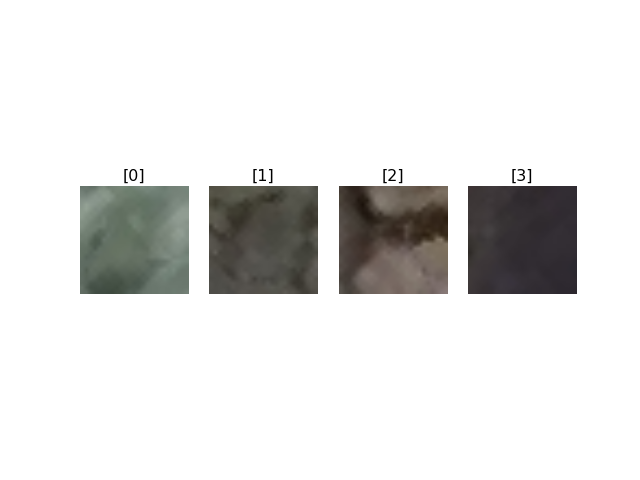

<IPython.core.display.Javascript object>


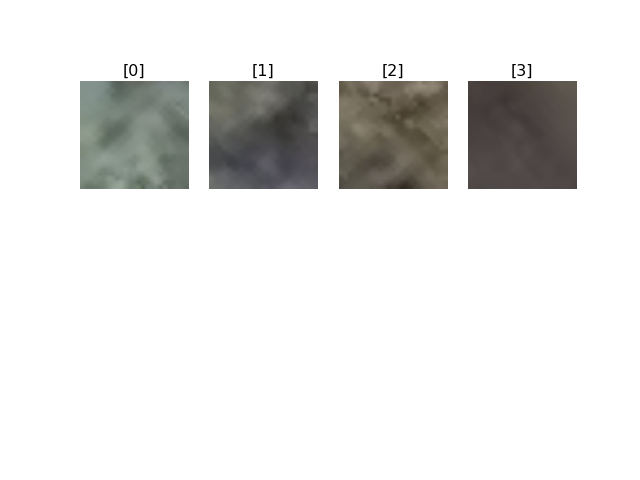

<IPython.core.display.Javascript object>


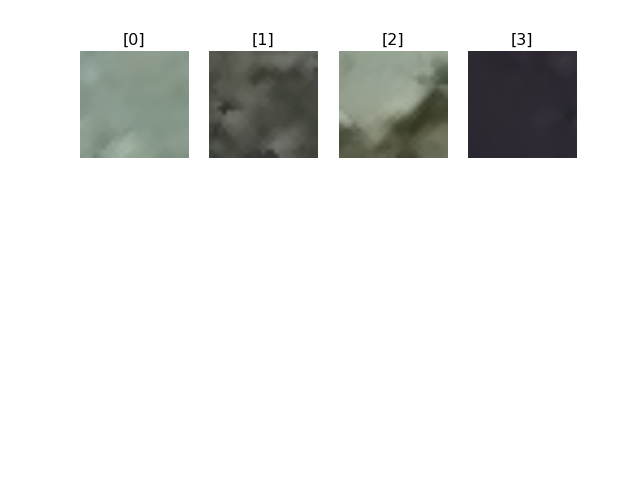

Training dataset dimensions:  (80000, 25, 25, 3) Training labels dimensions:  (80000, 1)
Validation dataset dimensions:  (10000, 25, 25, 3) Validation labels dimensions:  (10000, 1)
Test dataset dimensions:  (10000, 25, 25, 3) Test labels dimensions:  (10000, 1)
train_labels_shape (80000, 1)
num_classes 4


In [3]:
num_classes = 4
image_size = 25
transect1_path = '../Images/Transect 1 Hi-Res.tiff'
transect1_truth_path = '../Images/Transect 1 Truth data.tif'
Transect1, Transect1_truth = load_data(transect1_path, transect1_truth_path, truth_key=[16,160,198,38])
train_datasets, train_labels, valid_datasets, valid_labels, test_datasets, test_labels = \
    generate_training(Transect1, Transect1_truth, image_size = image_size, toremove = 3, figureson=True,
                      N_train=20000, N_valid = 2500, N_test = 2500)

print("Training dataset dimensions: ", train_datasets.shape, "Training labels dimensions: ", train_labels.shape)
print("Validation dataset dimensions: ", valid_datasets.shape, "Validation labels dimensions: ", valid_labels.shape)
print("Test dataset dimensions: ", test_datasets.shape, "Test labels dimensions: ", test_labels.shape)

model = Sequential()
batch_size = 32
epochs = 10

if train_labels.shape[-1] != num_classes:
    print("train_labels_shape", train_labels.shape)
    print("num_classes",num_classes)
    train_labels = keras.utils.to_categorical(train_labels, num_classes)
    valid_labels = keras.utils.to_categorical(valid_labels, num_classes)
    test_labels = keras.utils.to_categorical(test_labels, num_classes)
    #print(train_labels)

In [9]:
# design a fully connected NN model
# Model initiation
model = Sequential()
batch_size = 32
epochs = 10
#patch1_size = 5
#stride1 = 1
#patch2_size = 5
#stride2 = 1
#depth1 = 64
#depth2 = 128
depth3 = 256
depth4 = 64

# basically running 25x25 image patch through 2 FC layers (depth3 and depth4)
#model.add(Conv2D(depth1, (patch1_size,patch1_size), strides=(stride1,stride1), activation='relu', 
#                 kernel_initializer = TruncatedNormal(mean=0,stddev=0.1), input_shape=(image_size,image_size,3)))
#model.add(Conv2D(depth2, (patch2_size,patch2_size), strides=(stride2,stride2), activation='relu', 
#                 kernel_initializer = TruncatedNormal(mean=0,stddev=0.1)))
model.add(Flatten(input_shape=(image_size,image_size,3)))
model.add(Dense(depth3, activation='relu',
                kernel_initializer = TruncatedNormal(mean=0,stddev=0.1)))
model.add(Dense(depth4, activation='relu', kernel_initializer = TruncatedNormal(mean=0,stddev=0.1)))
model.add(Dense(num_classes, activation = 'softmax', kernel_initializer = TruncatedNormal(mean=0,stddev=0.1)))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.fit(train_datasets, train_labels,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(valid_datasets, valid_labels))
score = model.evaluate(test_datasets, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#model.save('./firstKerasmodel.h5')
model.summary()
#sgd = SGD(lr = 0.01)
#model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
#model.fit_generator(datagen.flow(train_datasets,train_labels,batch_size=batch_size,seed=1), steps_per_epoch=1000, epochs=epochs)
#score = model.evaluate_generator(datagen.flow(valid_datasets,valid_labels, batch_size=batch_size), steps=5)

Train on 80000 samples, validate on 10000 samples
Epoch 1/10
80000/80000 [==============================] - 21s - loss: 0.4023 - acc: 0.8397 - val_loss: 0.3253 - val_acc: 0.8743
Epoch 2/10
80000/80000 [==============================] - 20s - loss: 0.3182 - acc: 0.8785 - val_loss: 0.3283 - val_acc: 0.8671
Epoch 3/10
80000/80000 [==============================] - 20s - loss: 0.2940 - acc: 0.8890 - val_loss: 0.2938 - val_acc: 0.8878
Epoch 4/10
80000/80000 [==============================] - 20s - loss: 0.2759 - acc: 0.8966 - val_loss: 0.2672 - val_acc: 0.9012
Epoch 5/10
80000/80000 [==============================] - 20s - loss: 0.2634 - acc: 0.9019 - val_loss: 0.2667 - val_acc: 0.9004
Epoch 6/10
80000/80000 [==============================] - 20s - loss: 0.2536 - acc: 0.9048 - val_loss: 0.2837 - val_acc: 0.8954
Epoch 7/10
80000/80000 [==============================] - 20s - loss: 0.2469 - acc: 0.9076 - val_loss: 0.2614 - val_acc: 0.9042
Epoch 8/10
80000/80000 [==============================

In [14]:
range(12,12)
Transect1_truth.shape[0]

13598

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 1875)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               480256    
_________________________________________________________________
dense_17 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 260       
Total params: 496,964
Trainable params: 496,964
Non-trainable params: 0
_________________________________________________________________


In [38]:
#model = load_model('firstKerasmodel.h5')

def load_whole_data(img1, img1_truth, image_size, depth=255, offset=0, lines=None, toremove = False):
    crop_len = int(np.floor(image_size/2))
    
    if lines is None:
        lines = img1.shape[0]-2*crop_len
    
    if offset + lines + 2*crop_len > img1.shape[0]:
        print("Too many lines specified, reverting to maximum possible")
        lines = im1.shape[0] - offset - 2*crop_len
    
    whole_datasets = []
    whole_labels = []
    for i in range(offset+crop_len,lines+offset+crop_len):
        for j in range(crop_len, img1.shape[1]-crop_len):
            whole_datasets.append(img1[i-crop_len:i+crop_len+1, j-crop_len:j+crop_len+1,:])
            whole_labels.append(img1_truth[i,j])
            
    whole_datasets = np.asarray(whole_datasets) 
    whole_labels = np.asarray(whole_labels).reshape((len(whole_labels),1))
    
    if toremove is not None:
        whole_datasets = np.delete(whole_datasets,toremove,-1) # Remove specific last dimension of array
    
    whole_dataset = rescale(whole_datasets,depth)
    return whole_dataset, whole_labels

def classifyback(predictions):
    return np.argmax(predictions,1)

whole_predict = []
offstart = 0
crop_len = int(np.floor(image_size/2))
num_lines = Transect1_truth.shape[0] - 2*crop_len
for offset in range(offstart,offstart+num_lines):
    if (offset % 100 == 0):
        print('Now on step %d ', offset)
    temp_dataset, temp_labelset = load_whole_data(Transect1, Transect1_truth, image_size=25, offset = offset, lines=1, toremove=3)
    print("temp dataset shape",temp_dataset.shape)
    print("temp labelset shape",temp_labelset.shape)
    
    ## plot processed transect
    #plt.figure()
    #plt.axis("off")
    #plt.subplot(1,1,1)
    #plt.imshow(cv2.cvtColor(temp_dataset[1000,:,:,:], cv2.COLOR_BGR2RGB))
    #plt.title(offset)
    #plt.axis("off")
    #plt.show()
    temp_predict = model.predict_on_batch(temp_dataset)
    print("temp_predict",temp_predict[0:3,:])
    print("max predictions",np.argmax(temp_predict[100:110,:],1))
    whole_predict.append(classifyback(temp_predict))
    #print("whole predict shape", whole_predict.shape)
    print("whole predict",whole_predict[0:3])

whole_predict = np.asarray(whole_predict)
print(whole_predict.shape)

Now on step %d  0
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.76713598  0.01286742  0.20654146  0.01345506]
 [ 0.78288645  0.01424683  0.18939498  0.01347185]
 [ 0.80117488  0.01475062  0.17152171  0.01255276]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.81103837  0.01007202  0.16600694  0.0128828 ]
 [ 0.84296191  0.00939345  0.13567905  0.01196548]
 [ 0.86282498  0.00856742  0.11736915  0.01123839]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.81670254  0.00810696  0.16369735  0.01149314]
 [ 0.85921049  0.00696606  0.12270679  0.01111657]
 [ 0.88340706  0.00659158  0.09947617  0.01052528]]
max predictions [0 0 0 0 0 0 0 0 0 0]
w

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.7934249   0.01169191  0.18554191  0.00934116]
 [ 0.78198493  0.01185231  0.19764437  0.00851833]
 [ 0.80648327  0.01019936  0.17591554  0.00740185]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.77287447  0.01434076  0.20363019  0.00915459]
 [ 0.77331018  0.01229239  0.20626999  0.00812745]
 [ 0.78229523  0.01240037  0.19800319  0.00730128]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.72943872  0.01670751  0.2448886   0.00896511]
 [ 0.72335976  0.01660997

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.39899933  0.12680179  0.46807751  0.00612141]
 [ 0.44970456  0.12262711  0.42220289  0.00546542]
 [ 0.49611717  0.10965402  0.38880077  0.005428  ]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.41326016  0.10535649  0.47530541  0.00607793]
 [ 0.49657643  0.09914258  0.39826781  0.00601324]
 [ 0.56744409  0.08195519  0.34515321  0.00544754]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.48206511  0.09730131  0.41361547  0.00701804]
 [ 0.51645321  0.08622701

temp_predict [[ 0.48451787  0.0854787   0.423706    0.0062975 ]
 [ 0.49635634  0.08587137  0.41114414  0.00662818]
 [ 0.57150686  0.06431568  0.35745054  0.00672691]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.43120095  0.10299493  0.45935401  0.00645011]
 [ 0.49171731  0.08236299  0.41975072  0.00616895]
 [ 0.51270795  0.07814186  0.40291861  0.0062316 ]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.41894913  0.09724002  0.47769386  0.00611702]
 [ 0.45615795  0.09057384  0.44722992  0.00603825]
 [ 0.47754979  0.08385993  0.4325192   0.

temp_predict [[ 0.68180078  0.02282825  0.27604705  0.01932396]
 [ 0.70229     0.02254421  0.2554231   0.01974273]
 [ 0.70131254  0.02574772  0.25307178  0.019868  ]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.72630906  0.01931583  0.23707063  0.01730444]
 [ 0.73453557  0.01931513  0.22668608  0.01946321]
 [ 0.74229592  0.02105512  0.21711537  0.01953361]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.77020329  0.01750728  0.19640535  0.01588412]
 [ 0.77269894  0.01896405  0.19163254  0.01670446]
 [ 0.77240521  0.02123245  0.18916549  0.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.93137997  0.00328959  0.05433087  0.01099957]
 [ 0.92113703  0.00409678  0.06582994  0.00893614]
 [ 0.88928986  0.00638683  0.09642645  0.0078969 ]]
max predictions [0 0 2 2 2 2 2 2 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.92030352  0.00325568  0.06466347  0.01177732]
 [ 0.91483992  0.00371123  0.07244159  0.00900724]
 [ 0.87556493  0.00602521  0.11029399  0.00811596]]
max predictions [0 2 2 2 2 2 2 2 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.90939736  0.00302283  0.07337078  0.01420898]
 [ 0.89722753  0.00413483

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.66299975  0.00746441  0.32550052  0.00403532]
 [ 0.66759086  0.00734098  0.32104427  0.00402399]
 [ 0.66763359  0.00747709  0.32074991  0.00413939]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.66494119  0.00704209  0.32381213  0.00420468]
 [ 0.64552736  0.00874323  0.34155446  0.00417495]
 [ 0.64785218  0.00747639  0.34066314  0.00400825]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.67710358  0.00767965  0.3110092   0.00420752]
 [ 0.66583216  0.00720751

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.69800627  0.0093071   0.28769827  0.00498837]
 [ 0.73258162  0.00756152  0.25505868  0.00479824]
 [ 0.73902965  0.006615    0.2499238   0.0044316 ]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.66927654  0.01023906  0.31551924  0.00496517]
 [ 0.71707338  0.00819481  0.27011859  0.00461321]
 [ 0.72460538  0.00786873  0.26284182  0.00468404]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.70767105  0.00979129  0.27767122  0.00486647]
 [ 0.69478738  0.00936275

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.08394206  0.09055892  0.82389241  0.00160665]
 [ 0.0864534   0.08546456  0.82664365  0.00143839]
 [ 0.09461966  0.08514699  0.8186698   0.0015635 ]]
max predictions [1 1 1 1 1 1 1 1 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.08063243  0.08702117  0.83085811  0.00148825]
 [ 0.08254028  0.09052056  0.82535619  0.001583  ]
 [ 0.08047469  0.08920733  0.82884002  0.00147792]]
max predictions [1 1 1 1 1 1 1 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.07809655  0.09695897  0.82342041  0.00152398]
 [ 0.07774361  0.09419155

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.24970858e-04   3.78457099e-01   6.20974302e-01   4.43648314e-04]
 [  9.65417785e-05   3.59264523e-01   6.40249193e-01   3.89776251e-04]
 [  9.72660055e-05   3.38872939e-01   6.60665274e-01   3.64504813e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.64366084e-05   3.49179029e-01   6.50269389e-01   4.65112913e-04]
 [  8.39649001e-05   3.37503672e-01   6.62069380e-01   3.42958898e-04]
 [  7.00332239e-05   3.30659598e-01   6.68953598e-01   3.16711434e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.73691863e-06   9.66192722e-01   3.25789601e-02   1.22057146e-03]
 [  6.24023005e-06   9.65663314e-01   3.30874845e-02   1.24304579e-03]
 [  5.89273122e-06   9.64535177e-01   3.43111344e-02   1.14778720e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.39957761e-06   9.67542708e-01   3.08569204e-02   1.59401959e-03]
 [  4.15626255e-06   9.71256554e-01   2.66000591e-02   2.13920092e-03]
 [  3.61486877e-06   9.76004004e-01   2.20813509e-02   1.91103306e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.39943268e-05   9.63157654e-01   2.45513730e-02   1.22770155e-02]
 [  1.22978772e-05   9.66682494e-01   2.25629322e-02   1.07422471e-02]
 [  1.39774284e-05   9.67897058e-01   2.22358201e-02   9.85317770e-03]]
max predictions [2 2 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.28636239e-05   9.65278149e-01   2.39101220e-02   1.07988138e-02]
 [  1.30288900e-05   9.67159569e-01   2.12348439e-02   1.15925958e-02]
 [  1.32408359e-05   9.67543721e-01   2.21152939e-02   1.03277164e-02]]
max predictions [2 2 2 2 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.42793151e-05   9.80506420e-01   1.60790607e-02   3.40017187e-03]
 [  1.18583221e-05   9.81037140e-01   1.50521751e-02   3.89889977e-03]
 [  1.14805835e-05   9.78742719e-01   1.70520283e-02   4.19371622e-03]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.57812738e-05   9.80847061e-01   1.58796329e-02   3.25760688e-03]
 [  1.21487201e-05   9.80511606e-01   1.59798954e-02   3.49637819e-03]
 [  1.03227412e-05   9.80231762e-01   1.56042548e-02   4.15370008e-03]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.22485498e-05   9.62204874e-01   3.56643982e-02   2.07837718e-03]
 [  5.29684185e-05   9.64410126e-01   3.33324261e-02   2.20452179e-03]
 [  4.93562547e-05   9.66272175e-01   3.10713891e-02   2.60707806e-03]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.63715691e-05   9.55480099e-01   4.26171049e-02   1.83628243e-03]
 [  6.50209404e-05   9.59926009e-01   3.78382318e-02   2.17075180e-03]
 [  5.11979051e-05   9.66305017e-01   3.13104466e-02   2.33333441e-03]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.91847449e-04   8.93607497e-01   1.04087584e-01   2.01307167e-03]
 [  1.79700655e-04   9.17747736e-01   8.04661736e-02   1.60632923e-03]
 [  1.38265386e-04   9.34357584e-01   6.43811971e-02   1.12295675e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.53577105e-04   8.87011766e-01   1.11069329e-01   1.66532455e-03]
 [  2.09102262e-04   9.12325740e-01   8.58997777e-02   1.56534882e-03]
 [  1.64680780e-04   9.29548919e-01   6.89931437e-02   1.29322615e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.86730449e-03   7.43381202e-01   2.52977431e-01   7.74022017e-04]
 [  1.50933967e-03   7.42680073e-01   2.55217582e-01   5.93042350e-04]
 [  9.77826887e-04   7.10779727e-01   2.87740499e-01   5.01946721e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.00911698e-03   8.07126760e-01   1.89176276e-01   6.87884865e-04]
 [  1.10043830e-03   7.64907897e-01   2.33501598e-01   4.90098028e-04]
 [  8.69138225e-04   7.97344446e-01   2.01246187e-01   5.40232286e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00601872e-03   7.73446262e-01   2.24907205e-01   6.40547194e-04]
 [  7.59517949e-04   7.60069430e-01   2.38324344e-01   8.46596726e-04]
 [  6.99830125e-04   7.90155709e-01   2.08032459e-01   1.11193559e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.07993230e-04   7.96393275e-01   2.02032149e-01   7.66513345e-04]
 [  7.50911015e-04   7.90637851e-01   2.07743749e-01   8.67561030e-04]
 [  5.83689543e-04   7.83754826e-01   2.14764580e-01   8.96958925e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.28724659e-03   9.34645414e-01   6.32902905e-02   7.77086359e-04]
 [  1.22440385e-03   9.25692916e-01   7.19764382e-02   1.10613031e-03]
 [  1.07359444e-03   9.25259411e-01   7.22591504e-02   1.40789710e-03]]
max predictions [1 1 1 1 1 1 1 1 1 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.00595171e-03   9.42475617e-01   5.46923988e-02   8.26007163e-04]
 [  1.60228705e-03   9.37696218e-01   5.96914254e-02   1.01002282e-03]
 [  1.49379601e-03   9.25675750e-01   7.14049414e-02   1.42544846e-03]]
max predictions [1 1 1 1 1 1 1 1 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.04181037  0.86878741  0.08673972  0.0026625 ]
 [ 0.05725139  0.86125809  0.07771178  0.0037787 ]
 [ 0.05105476  0.88512552  0.06043324  0.00338652]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.04385229  0.88837057  0.06589527  0.00188182]
 [ 0.0607144   0.87210476  0.06414302  0.00303793]
 [ 0.07453353  0.87242502  0.04923509  0.00380642]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.04699505  0.88393176  0.06704435  0.00202887]
 [ 0.05819144  0.86837214

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.85280579  0.01162092  0.12022003  0.01535323]
 [ 0.82394862  0.01625985  0.14502764  0.01476387]
 [ 0.82980925  0.0174014   0.13644472  0.01634472]]
max predictions [0 0 0 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.87651968  0.00575433  0.10151267  0.0162133 ]
 [ 0.86435902  0.00836673  0.11061204  0.01666221]
 [ 0.83884865  0.01298454  0.13193716  0.01622967]]
max predictions [0 0 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.89684647  0.00320514  0.08657621  0.01337219]
 [ 0.87608433  0.00441672

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.58115166  0.02386397  0.38791931  0.00706505]
 [ 0.54752535  0.02760824  0.41812849  0.00673792]
 [ 0.53705633  0.03304349  0.42354673  0.00635346]]
max predictions [2 2 2 2 0 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.56241184  0.02622377  0.40436712  0.00699729]
 [ 0.53632843  0.0328352   0.42351717  0.00731921]
 [ 0.47497237  0.04104     0.4770954   0.00689221]]
max predictions [2 2 2 0 2 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.49037904  0.03098587  0.47056717  0.00806798]
 [ 0.4727591   0.038527  

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.18075387  0.26128936  0.55168164  0.00627523]
 [ 0.18864296  0.27601799  0.5285638   0.00677519]
 [ 0.20490505  0.26850668  0.51935482  0.00723348]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.18251032  0.27057964  0.54052514  0.00638495]
 [ 0.20364052  0.27583182  0.51392835  0.00659932]
 [ 0.19349273  0.28556216  0.51412487  0.00682023]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.20768882  0.27230451  0.51355106  0.00645557]
 [ 0.19543211  0.27497923

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.22459291  0.7008937   0.06148444  0.01302895]
 [ 0.36527434  0.56785089  0.05590813  0.01096665]
 [ 0.40753275  0.50562376  0.07569772  0.01114575]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.20551969  0.72168583  0.05697577  0.01581884]
 [ 0.28844711  0.64262986  0.05473322  0.01418988]
 [ 0.38521969  0.53899127  0.06124886  0.01454013]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.13960007  0.77495462  0.06612318  0.01932213]
 [ 0.15268026  0.76378763

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.09862439e-05   9.55598414e-01   4.31256481e-02   1.22488406e-03]
 [  5.53940336e-05   9.57905769e-01   4.09030244e-02   1.13590050e-03]
 [  9.70374967e-05   9.53735054e-01   4.52992357e-02   8.68723146e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.16848995e-05   9.51625049e-01   4.67365868e-02   1.58663094e-03]
 [  5.61624183e-05   9.59046602e-01   3.97122316e-02   1.18504046e-03]
 [  8.47274277e-05   9.59401190e-01   3.94864604e-02   1.02762168e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.71446824e-04   9.16964531e-01   8.05265382e-02   2.33751908e-03]
 [  1.97817470e-04   9.21694815e-01   7.58540481e-02   2.25343020e-03]
 [  1.91744373e-04   9.23422575e-01   7.38003924e-02   2.58527789e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.60174648e-04   9.03187454e-01   9.44336653e-02   2.21867952e-03]
 [  2.17710432e-04   9.04093325e-01   9.29540321e-02   2.73490837e-03]
 [  2.57741311e-04   9.09798920e-01   8.68645832e-02   3.07880924e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.40683972e-05   8.92565966e-01   1.05364099e-01   1.99587783e-03]
 [  1.05303174e-04   8.79987061e-01   1.17511563e-01   2.39612907e-03]
 [  1.52017630e-04   8.64618123e-01   1.32901654e-01   2.32814113e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.80309196e-05   8.72334301e-01   1.25971228e-01   1.59644056e-03]
 [  1.18089112e-04   8.80134463e-01   1.17740132e-01   2.00735987e-03]
 [  1.40019591e-04   8.55495036e-01   1.42155215e-01   2.20973860e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.57571392e-05   8.66211534e-01   1.31912127e-01   1.78060704e-03]
 [  1.72014916e-04   8.90446484e-01   1.07270256e-01   2.11127964e-03]
 [  1.58468509e-04   8.96409214e-01   1.01676293e-01   1.75599637e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99551921e-05   8.79388571e-01   1.18481748e-01   2.02976237e-03]
 [  1.60296157e-04   9.02628720e-01   9.51835588e-02   2.02739239e-03]
 [  1.76167217e-04   8.81798208e-01   1.16525874e-01   1.49973237e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.92701399e-05   9.54858661e-01   3.97909917e-02   5.29105263e-03]
 [  5.84964837e-05   9.57600594e-01   3.76600176e-02   4.68088826e-03]
 [  6.61357335e-05   9.55208898e-01   4.03545350e-02   4.37045889e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.79362274e-05   9.52297449e-01   4.14511114e-02   6.18358515e-03]
 [  5.51805715e-05   9.57992077e-01   3.52381468e-02   6.71463646e-03]
 [  5.73642101e-05   9.60607529e-01   3.32025215e-02   6.13250164e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[ 0.00476653  0.97750562  0.01476362  0.00296423]
 [ 0.00570418  0.97834259  0.0123042   0.00364905]
 [ 0.00745264  0.97375715  0.01413475  0.0046555 ]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00524044  0.9796412   0.01313894  0.00197937]
 [ 0.0061509   0.97620845  0.01374151  0.00389904]
 [ 0.00836059  0.9764747   0.01087981  0.00428504]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00553723  0.97866082  0.01398669  0.00181532]
 [ 0.00729901  0.97733605  0.01269876  0.00266623]
 [ 0.01044665  0.97500789  0.01153309  0.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.94476616e-01   2.63155694e-03   1.19994523e-03   1.69179216e-03]
 [  9.96295273e-01   1.53435359e-03   1.20280415e-03   9.67587461e-04]
 [  9.94836807e-01   1.56850251e-03   2.37766234e-03   1.21695211e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.99184728  0.00474491  0.00190662  0.00150125]
 [ 0.99372452  0.00296404  0.00187023  0.00144124]
 [ 0.99537152  0.00129913  0.00205204  0.00127727]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.99047416  0

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.92962420e-01   8.04519281e-04   3.56007623e-03   2.67293747e-03]
 [  9.94935870e-01   3.92637652e-04   2.50310451e-03   2.16844957e-03]
 [  9.96317863e-01   2.72628240e-04   1.59277639e-03   1.81669684e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.89049792e-01   1.25155365e-03   7.04862922e-03   2.65001925e-03]
 [  9.95341897e-01   5.87920484e-04   2.55629793e-03   1.51394692e-03]
 [  9.97600853e-01   2.64072441e-04   1.13044481e-03   1.00449543e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  9.95728433e-01   6.98139265e-05   1.33974745e-03   2.86198733e-03]
 [  9.92420137e-01   9.72168273e-05   2.36527040e-03   5.11730788e-03]
 [  9.89329875e-01   1.27246094e-04   3.89197282e-03   6.65098336e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.92527127e-01   2.15465407e-04   2.69456510e-03   4.56278399e-03]
 [  9.89172578e-01   3.04469868e-04   3.32401344e-03   7.19892979e-03]
 [  9.90509629e-01   2.12435945e-04   2.18936661e-03   7.08855689e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.82821643e-01   8.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.80598718  0.09254151  0.09508844  0.00638286]
 [ 0.78593564  0.07056874  0.13361003  0.00988552]
 [ 0.8738817   0.03943311  0.07834572  0.00833946]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.86327499  0.060173    0.07309499  0.00345703]
 [ 0.80841362  0.06586729  0.12057281  0.00514636]
 [ 0.75814176  0.07824858  0.15680252  0.00680712]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.90201908  0.05051557  0.04571593  0.00174936]
 [ 0.67068744  0.10245027

temp_predict [[ 0.31172088  0.65858632  0.02698546  0.0027073 ]
 [ 0.34216332  0.61461437  0.04003724  0.00318507]
 [ 0.27233067  0.6737507   0.05029409  0.00362454]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.2594935   0.71354866  0.02265419  0.00430362]
 [ 0.16637872  0.78653234  0.04331096  0.00377795]
 [ 0.17268671  0.76531774  0.05841126  0.00358431]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.098895    0.87691641  0.0195145   0.00467418]
 [ 0.09004509  0.87030184  0.03496737  0.00468567]
 [ 0.1278854   0.81023806  0.05774016  0.

temp_predict [[  5.72847312e-05   9.86116052e-01   1.25477454e-02   1.27903046e-03]
 [  1.24087761e-04   9.82159078e-01   1.55616440e-02   2.15508020e-03]
 [  1.15727024e-04   9.84440446e-01   1.26064308e-02   2.83739949e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.57952662e-05   9.85907435e-01   1.27097573e-02   1.32698577e-03]
 [  9.56119766e-05   9.81008410e-01   1.63206011e-02   2.57526664e-03]
 [  1.04171959e-04   9.82830763e-01   1.39904656e-02   3.07459733e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.11426515e-05   9.

temp_predict [[  7.10216627e-05   9.70793724e-01   2.69842874e-02   2.15086364e-03]
 [  6.19980419e-05   9.69653130e-01   2.64958683e-02   3.78900976e-03]
 [  4.58670584e-05   9.68231678e-01   2.66302004e-02   5.09235403e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.20829921e-05   9.67365682e-01   2.93489285e-02   3.21335625e-03]
 [  4.49751569e-05   9.67857957e-01   2.78028511e-02   4.29407367e-03]
 [  3.69728987e-05   9.65907454e-01   2.82100681e-02   5.84543776e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.45089208e-05   9.

temp_predict [[  4.85588425e-05   9.78290498e-01   1.99463479e-02   1.71472109e-03]
 [  6.74457478e-05   9.76765096e-01   2.11175401e-02   2.04987056e-03]
 [  9.59829777e-05   9.71963167e-01   2.54630782e-02   2.47780979e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.40098920e-05   9.80608106e-01   1.76928751e-02   1.65500015e-03]
 [  6.03852750e-05   9.76773858e-01   2.12511253e-02   1.91467127e-03]
 [  8.10089696e-05   9.73802090e-01   2.36508343e-02   2.46598851e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.95092902e-05   9.

temp_predict [[  1.56660226e-05   9.70509648e-01   2.82290541e-02   1.24564802e-03]
 [  1.65464080e-05   9.71404791e-01   2.69565359e-02   1.62214146e-03]
 [  1.72515229e-05   9.71721232e-01   2.69450862e-02   1.31638849e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.95096600e-05   9.68137443e-01   3.03186048e-02   1.52451871e-03]
 [  2.05462256e-05   9.69322860e-01   2.87176613e-02   1.93897379e-03]
 [  2.59038316e-05   9.66786265e-01   3.14490944e-02   1.73872465e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.78054395e-05   9.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.66956539e-04   9.86256301e-01   1.27328327e-02   8.43903865e-04]
 [  2.01924558e-04   9.82053280e-01   1.64695103e-02   1.27529667e-03]
 [  2.68535805e-04   9.77542520e-01   2.04698276e-02   1.71921181e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.41040713e-04   9.88592744e-01   1.05660828e-02   7.00095552e-04]
 [  2.14211192e-04   9.86629248e-01   1.22129256e-02   9.43582854e-04]
 [  2.65848881e-04   9.84622777e-01   1.38549097e-02   1.25639513e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.51531549e-05   9.80712175e-01   1.82563104e-02   1.01626525e-03]
 [  1.39937956e-05   9.75068986e-01   2.26229597e-02   2.29421980e-03]
 [  1.46507691e-05   9.74256992e-01   2.38909423e-02   1.83751131e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.88537906e-05   9.78277266e-01   1.98997334e-02   1.80412026e-03]
 [  1.64220837e-05   9.73824382e-01   2.38266140e-02   2.33254675e-03]
 [  2.03086274e-05   9.66286898e-01   2.95545198e-02   4.13828064e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[ 0.00307636  0.98320264  0.01197427  0.00174676]
 [ 0.00446763  0.98421627  0.00944936  0.00186682]
 [ 0.00278588  0.98808008  0.00813551  0.00099851]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.77629325e-03   9.77102876e-01   1.72009878e-02   1.91980286e-03]
 [  4.41049878e-03   9.82028484e-01   1.23310536e-02   1.23001158e-03]
 [  5.91386249e-03   9.82572556e-01   1.08495653e-02   6.64023391e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.81148513e-03   9.69461203e-01   2.54998356e-02   1.22753438e-03]
 [  6.748269

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.3230764   0.6303156   0.04460971  0.00199825]
 [ 0.26251778  0.69510645  0.03999329  0.00238252]
 [ 0.29626623  0.6706664   0.02988621  0.00318112]]
max predictions [1 1 1 1 1 1 0 1 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.24148981  0.71005851  0.04674517  0.00170649]
 [ 0.14471519  0.81354296  0.04040469  0.00133715]
 [ 0.10997701  0.85138309  0.03676952  0.00187039]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.06289715e-01   8.45586777e-01   4.69862968e-02   1.13717292e-03]
 [  4

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.30425769e-03   9.61492538e-01   3.18416692e-02   2.36145314e-03]
 [  2.30038376e-03   9.72561419e-01   2.45754793e-02   5.62791596e-04]
 [  1.80744845e-03   9.67258692e-01   3.06719765e-02   2.61814945e-04]]
max predictions [1 1 1 1 1 1 1 2 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.03745801e-03   9.59316194e-01   3.08137983e-02   2.83257198e-03]
 [  3.06989090e-03   9.67873156e-01   2.80467086e-02   1.01023633e-03]
 [  2.43566721e-03   9.76918638e-01   2.02968791e-02   3.48804926e-04]]
max predictions [1 1 1 1 2 1 2 2 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.13086189  0.49454147  0.37072632  0.00387034]
 [ 0.13996194  0.52157521  0.33272365  0.00573924]
 [ 0.11868081  0.58002341  0.2945019   0.00679387]]
max predictions [2 2 2 2 2 2 2 2 2 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.13381548  0.45193398  0.41068476  0.0035657 ]
 [ 0.16645929  0.47511336  0.353928    0.0044993 ]
 [ 0.14552161  0.54834026  0.3005873   0.00555088]]
max predictions [2 2 2 2 2 2 2 2 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.14964452  0.43160471  0.41492066  0.00383009]
 [ 0.1357653   0.47895694

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.06095501e-05   9.52666223e-01   4.50145304e-02   2.29864963e-03]
 [  2.00810573e-05   9.45199728e-01   5.15433922e-02   3.23685515e-03]
 [  2.07138273e-05   9.29340124e-01   6.71037510e-02   3.53544299e-03]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.24461067e-05   9.62541163e-01   3.62600870e-02   1.18638319e-03]
 [  1.50639089e-05   9.49797630e-01   4.86609489e-02   1.52637332e-03]
 [  1.42933286e-05   9.37781453e-01   6.05766848e-02   1.62755011e-03]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.18026699e-04   9.78205264e-01   2.14923341e-02   1.84372228e-04]
 [  9.66233201e-05   9.71809506e-01   2.76420247e-02   4.51977539e-04]
 [  8.02199502e-05   9.67733383e-01   3.16768698e-02   5.09506790e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.18304808e-04   9.76121426e-01   2.35331971e-02   2.26995704e-04]
 [  1.17346885e-04   9.72125828e-01   2.74434425e-02   3.13410041e-04]
 [  1.04669161e-04   9.72056806e-01   2.73974333e-02   4.41092649e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.05519090e-03   9.06552851e-01   8.99681151e-02   4.23806341e-04]
 [  2.59033567e-03   8.95577431e-01   1.01222284e-01   6.09925715e-04]
 [  2.97909905e-03   7.91294515e-01   2.04974174e-01   7.52228079e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.98414566e-03   8.87528777e-01   1.09056272e-01   4.30818880e-04]
 [  2.49886420e-03   8.34422529e-01   1.62565321e-01   5.13220381e-04]
 [  1.56410586e-03   7.43857801e-01   2.53770173e-01   8.07809993e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.88822800e-03   9.16575015e-01   7.56428242e-02   8.94001627e-04]
 [  5.06640086e-03   9.26209152e-01   6.74453825e-02   1.27901044e-03]
 [  2.70866812e-03   8.84940565e-01   1.11093901e-01   1.25699316e-03]]
max predictions [1 1 2 2 2 2 1 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.43265899e-03   9.07721579e-01   8.49678516e-02   8.77878338e-04]
 [  5.83458180e-03   9.33244705e-01   6.02687709e-02   6.51957234e-04]
 [  1.78602932e-03   8.87615502e-01   1.09897383e-01   7.01153476e-04]]
max predictions [1 2 2 2 2 1 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.39379796e-05   7.71411419e-01   2.27752984e-01   7.71624385e-04]
 [  4.93194384e-05   8.10628414e-01   1.88455895e-01   8.66389542e-04]
 [  5.50256482e-05   8.21570516e-01   1.77784085e-01   5.90348325e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.94395970e-05   8.21731508e-01   1.77507609e-01   7.01481651e-04]
 [  6.53871612e-05   8.22629809e-01   1.76483944e-01   8.20827729e-04]
 [  5.21958864e-05   8.49075317e-01   1.50319785e-01   5.52658457e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.18488392e-04   8.03426027e-01   1.95809051e-01   5.46525524e-04]
 [  1.81630778e-04   7.97986329e-01   2.01492712e-01   3.39297636e-04]
 [  1.29007865e-04   8.33864272e-01   1.65636420e-01   3.70237656e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.86826364e-04   8.23225796e-01   1.76213041e-01   3.74379102e-04]
 [  1.99205577e-04   8.40750992e-01   1.58659279e-01   3.90466419e-04]
 [  1.55290458e-04   8.44061375e-01   1.55390307e-01   3.93035909e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.07163854e-03   6.39391005e-01   3.59228194e-01   3.09182622e-04]
 [  1.94202841e-03   6.40362084e-01   3.57371867e-01   3.24026565e-04]
 [  1.75919989e-03   6.44306242e-01   3.53711277e-01   2.23350973e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.42502094e-04   5.78065813e-01   4.20879692e-01   5.12020197e-04]
 [  4.75922279e-04   5.22728324e-01   4.76521999e-01   2.73752812e-04]
 [  5.93852135e-04   5.80116630e-01   4.19010401e-01   2.79206753e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.38233017e-05   9.64124799e-01   3.56787965e-02   1.82652220e-04]
 [  2.56816566e-05   9.60622787e-01   3.90822403e-02   2.69297190e-04]
 [  2.68496606e-05   9.53792512e-01   4.59517576e-02   2.28906778e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.36972355e-05   9.53183532e-01   4.65173163e-02   2.75463390e-04]
 [  3.24844514e-05   9.56552982e-01   4.31681089e-02   2.46393873e-04]
 [  4.17495175e-05   9.48748350e-01   5.09640239e-02   2.45853647e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.02305518e-05   9.72582400e-01   2.59035416e-02   1.45391014e-03]
 [  5.43548049e-05   9.77610648e-01   2.11750064e-02   1.16006646e-03]
 [  1.05160230e-04   9.75446284e-01   2.28209347e-02   1.62763475e-03]]
max predictions [2 2 2 2 2 2 1 1 2 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
Now on step %d  1000
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.04000488e-05   9.66768205e-01   3.02327629e-02   2.93870713e-03]
 [  7.29976091e-05   9.73246396e-01   2.34757680e-02   3.20496620e-03]
 [  9.38989397e-05   9.79894578e-01   1.77117456e-02   2.29974766e-03]]
max predictions [2 2 2 2 2 2 2 2 2 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset sh

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.93351918e-04   9.25523460e-01   6.64982274e-02   7.58492062e-03]
 [  2.69428070e-04   9.43330586e-01   5.09924889e-02   5.40749589e-03]
 [  1.84755554e-04   9.36269760e-01   6.06950745e-02   2.85045640e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.99873917e-04   9.46830988e-01   4.93279435e-02   3.64123867e-03]
 [  1.43168305e-04   9.48389888e-01   4.92447689e-02   2.22222810e-03]
 [  1.10883208e-04   9.50245202e-01   4.85845543e-02   1.05942972e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.84513585e-05   9.49725151e-01   4.82887104e-02   1.93774479e-03]
 [  3.17971644e-05   9.45679247e-01   5.25513142e-02   1.73766748e-03]
 [  4.00668650e-05   9.42332804e-01   5.54936491e-02   2.13347841e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.59442854e-05   9.60205853e-01   3.80310044e-02   1.71716791e-03]
 [  2.43128434e-05   9.64989007e-01   3.29722241e-02   2.01447378e-03]
 [  3.27117996e-05   9.54684913e-01   4.37174775e-02   1.56496349e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.92174130e-04   9.55275536e-01   4.03325967e-02   3.69965401e-03]
 [  1.49476156e-03   9.57524598e-01   3.49226557e-02   6.05795719e-03]
 [  1.29418273e-03   9.52154338e-01   3.87757681e-02   7.77573790e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.23504175e-04   9.61060822e-01   3.48842628e-02   3.23142926e-03]
 [  1.80292118e-03   9.61382449e-01   3.37880664e-02   3.02645564e-03]
 [  2.33843434e-03   9.67172921e-01   2.64054779e-02   4.08322131e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[ 0.01969388  0.90317905  0.07594408  0.00118298]
 [ 0.06707443  0.83974218  0.09041501  0.00276838]
 [ 0.10551505  0.78220534  0.10690635  0.00537324]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.02559699  0.90977407  0.06315713  0.00147179]
 [ 0.07256529  0.82380205  0.10048049  0.00315223]
 [ 0.14358036  0.71791899  0.1317296   0.00677104]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.04711005  0.89141119  0.05902781  0.002451  ]
 [ 0.09567937  0.81913686  0.08079534  0.0043884 ]
 [ 0.23811279  0.64556247  0.10573434  0.

temp_predict [[  8.52280064e-04   9.15652871e-01   7.97679499e-02   3.72695434e-03]
 [  5.70419128e-04   9.39773262e-01   5.43816015e-02   5.27464179e-03]
 [  3.14640813e-04   9.49432492e-01   4.54775244e-02   4.77535045e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.40222726e-04   9.35526013e-01   6.06313013e-02   3.60255223e-03]
 [  2.11247243e-04   9.50415134e-01   4.63513955e-02   3.02222930e-03]
 [  1.36943519e-04   9.58287358e-01   3.82388793e-02   3.33678932e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00389123e-04   9.

temp_predict [[  1.43585610e-03   9.70399320e-01   2.71773934e-02   9.87435924e-04]
 [  1.20484550e-03   9.86928940e-01   1.13380197e-02   5.28192904e-04]
 [  9.82275116e-04   9.92499053e-01   6.10450003e-03   4.14182228e-04]]
max predictions [1 1 1 1 1 1 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.21964507e-03   9.66239154e-01   3.06365192e-02   9.04771674e-04]
 [  2.18931376e-03   9.72732842e-01   2.36027297e-02   1.47514301e-03]
 [  3.02490615e-03   9.80813920e-01   1.49017451e-02   1.25945045e-03]]
max predictions [1 1 1 1 1 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00466939  0.949530

temp_predict [[ 0.80216688  0.155808    0.03937373  0.00265139]
 [ 0.7663002   0.17337637  0.05802093  0.00230251]
 [ 0.65437621  0.29827887  0.04547588  0.00186897]]
max predictions [1 1 1 2 2 2 2 1 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.75149918  0.19760427  0.04423521  0.00666143]
 [ 0.75999671  0.19825782  0.03718609  0.00455939]
 [ 0.60614979  0.34307274  0.04665159  0.00412583]]
max predictions [1 1 1 1 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.75759733  0.19792959  0.03754583  0.00692722]
 [ 0.82987261  0.14659783  0.01943076  0.00409885]
 [ 0.60330957  0.34911716  0.03868321  0.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.1777702   0.69790173  0.03948407  0.084844  ]
 [ 0.03829888  0.90033197  0.02994225  0.0314269 ]
 [ 0.00504607  0.97392356  0.01713566  0.00389468]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.26940632  0.53252512  0.08185812  0.1162104 ]
 [ 0.05509606  0.87682104  0.04294436  0.02513856]
 [ 0.00928432  0.94837177  0.03600506  0.00633888]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.37426624  0.47955352  0.06528256  0.08089769]
 [ 0.09694854  0.79932112

temp_predict [[ 0.00701272  0.89121181  0.09631474  0.00546072]
 [ 0.00409601  0.88697869  0.10573279  0.00319253]
 [ 0.00268595  0.87560934  0.11971195  0.00199276]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.0024806   0.91565126  0.07579076  0.00607733]
 [ 0.00154608  0.92527193  0.06781531  0.00536667]
 [ 0.00171761  0.93162072  0.06203724  0.00462447]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.94803903e-04   9.49044704e-01   4.55933698e-02   4.46712133e-03]
 [  9.18118923e-04   9.49676991e-01   4.34110984e-02   5.99382818e-03]
 

temp_predict [[ 0.00931791  0.90669638  0.08053321  0.0034525 ]
 [ 0.01203718  0.85953796  0.12571019  0.0027147 ]
 [ 0.02305594  0.83648449  0.1376245   0.00283507]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.01017913  0.83576787  0.15052146  0.0035315 ]
 [ 0.0153207   0.84903103  0.13270675  0.0029415 ]
 [ 0.01319722  0.80292302  0.1814926   0.00238717]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00777598  0.83478296  0.15492882  0.00251222]
 [ 0.00632215  0.75592834  0.23583359  0.00191579]
 [ 0.01029089  0.70506525  0.28263745  0.

temp_predict [[ 0.00117996  0.79282826  0.19210657  0.01388522]
 [ 0.00129864  0.80716598  0.17089553  0.02063997]
 [ 0.0014401   0.85817981  0.12118286  0.01919727]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.64966749e-04   8.46612215e-01   1.40599862e-01   1.24229658e-02]
 [  6.13109092e-04   8.58482361e-01   1.29566550e-01   1.13379657e-02]
 [  5.86987531e-04   8.67758393e-01   1.21906199e-01   9.74842347e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.12581435e-04   8.76382709e-01   1.12745300e-01   1.06593631e-02]
 [  1.809546

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.72394958e-06   9.78403568e-01   1.15472265e-02   1.00405253e-02]
 [  8.53753772e-06   9.79358971e-01   1.22610433e-02   8.37142207e-03]
 [  8.35880746e-06   9.77589130e-01   1.35177607e-02   8.88474099e-03]]
max predictions [1 1 2 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.38497602e-06   9.77860332e-01   1.41702732e-02   7.96212628e-03]
 [  7.77529476e-06   9.76524472e-01   1.37532596e-02   9.71450005e-03]
 [  7.18117280e-06   9.77129161e-01   1.45065840e-02   8.35707877e-03]]
max predictions [1 1 1 2 2 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.40319491e-06   9.81130958e-01   1.58052538e-02   3.05933086e-03]
 [  4.20366359e-06   9.79967058e-01   1.64773650e-02   3.55136883e-03]
 [  5.46071942e-06   9.78817046e-01   1.70271341e-02   4.15033055e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.65546953e-06   9.80320811e-01   1.61546040e-02   3.52101075e-03]
 [  5.09313350e-06   9.77827728e-01   1.89511199e-02   3.21603869e-03]
 [  5.07372397e-06   9.78005111e-01   1.81709435e-02   3.81879346e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.28611078e-04   9.09140944e-01   8.64119232e-02   4.31850506e-03]
 [  1.21266799e-04   9.25187230e-01   7.08233342e-02   3.86810256e-03]
 [  1.00953570e-04   9.41363335e-01   5.54633178e-02   3.07233841e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.27442865e-04   9.01889622e-01   9.44558755e-02   3.52705526e-03]
 [  1.27674197e-04   9.18859482e-01   7.76067227e-02   3.40617984e-03]
 [  1.17825737e-04   9.40294921e-01   5.68413436e-02   2.74594524e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.06525076e-04   8.79405081e-01   1.18279316e-01   2.20916001e-03]
 [  8.20010246e-05   9.18187618e-01   7.96258599e-02   2.10449612e-03]
 [  3.70167254e-05   9.20927703e-01   7.80152306e-02   1.02007564e-03]]
max predictions [1 1 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.39761856e-05   9.32840586e-01   6.38607889e-02   3.23471264e-03]
 [  3.28247916e-05   9.31186557e-01   6.71420097e-02   1.63859117e-03]
 [  2.56383992e-05   9.41314638e-01   5.72495647e-02   1.41017325e-03]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.46256825e-05   9.30311203e-01   4.00624909e-02   2.96116434e-02]
 [  1.02249542e-05   9.52994764e-01   3.54956053e-02   1.14993900e-02]
 [  1.04842538e-05   9.61725652e-01   3.40321027e-02   4.23182873e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.79678300e-05   9.31125998e-01   3.78829166e-02   3.09731383e-02]
 [  9.09035771e-06   9.55320358e-01   3.19832340e-02   1.26872910e-02]
 [  1.13905116e-05   9.65396225e-01   2.98377369e-02   4.75460943e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.10561905e-05   9.62134004e-01   2.08408572e-02   1.70141142e-02]
 [  1.42714161e-05   9.55127537e-01   2.21165717e-02   2.27417741e-02]
 [  1.57931736e-05   9.55828071e-01   2.06932370e-02   2.34629158e-02]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.08864106e-05   9.60270464e-01   2.36845817e-02   1.60340760e-02]
 [  1.19465149e-05   9.60115850e-01   2.27400158e-02   1.71322618e-02]
 [  1.32424721e-05   9.61673319e-01   2.00780313e-02   1.82353482e-02]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.73877230e-06   9.37048256e-01   1.32444240e-02   4.97005917e-02]
 [  6.42644682e-06   9.29673433e-01   1.31537160e-02   5.71664050e-02]
 [  7.80668779e-06   9.16523993e-01   1.43241361e-02   6.91440105e-02]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.45790874e-06   9.03898358e-01   1.15739591e-02   8.45232159e-02]
 [  5.48494017e-06   9.17422354e-01   1.21889608e-02   7.03832135e-02]
 [  6.75090178e-06   9.08812344e-01   1.33345043e-02   7.78465047e-02]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.59875968e-06   9.10252571e-01   1.00567704e-02   7.96840489e-02]
 [  7.52694859e-06   9.12559390e-01   9.98384878e-03   7.74493366e-02]
 [  8.31003945e-06   9.02929902e-01   1.01265404e-02   8.69352594e-02]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.43925478e-06   9.04328585e-01   9.83924419e-03   8.58257562e-02]
 [  6.64688014e-06   9.09168839e-01   9.50049609e-03   8.13240558e-02]
 [  8.46358944e-06   9.10917640e-01   9.94062331e-03   7.91332573e-02]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.17280340e-06   8.22962344e-01   7.74670253e-03   1.69281721e-01]
 [  7.86032342e-06   7.86273479e-01   6.99212356e-03   2.06726477e-01]
 [  1.05007257e-05   7.91538537e-01   7.30178505e-03   2.01149210e-01]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.32710987e-06   8.06853175e-01   7.66958296e-03   1.85469955e-01]
 [  8.43315775e-06   7.77145445e-01   8.43404792e-03   2.14412123e-01]
 [  7.98178098e-06   7.27164507e-01   7.26366043e-03   2.65563875e-01]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.88366025e-05   9.19326007e-01   1.30755808e-02   6.75596744e-02]
 [  4.22570592e-05   9.12803054e-01   1.27234645e-02   7.44312853e-02]
 [  4.28489147e-05   8.82950306e-01   1.31596411e-02   1.03847213e-01]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.69483384e-05   9.45188046e-01   1.24980900e-02   4.22668979e-02]
 [  5.34631363e-05   9.23778772e-01   1.51397223e-02   6.10280521e-02]
 [  4.05085666e-05   9.27383125e-01   1.40994675e-02   5.84769249e-02]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.21442007  0.709418    0.06666466  0.00949728]
 [ 0.13225368  0.80014688  0.05982089  0.00777852]
 [ 0.11030971  0.81827259  0.06410868  0.00730897]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.31243211  0.60687256  0.06967954  0.01101586]
 [ 0.19951718  0.73417509  0.05915963  0.00714812]
 [ 0.13785453  0.80226111  0.05493437  0.00494997]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.46782452  0.45397225  0.06654306  0.01166015]
 [ 0.35953832  0.58318949

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.97572362e-01   6.09758581e-06   1.11571443e-03   1.30591576e-03]
 [  9.96919036e-01   9.72616363e-06   1.34997850e-03   1.72136130e-03]
 [  9.96552229e-01   1.00189754e-05   1.51354400e-03   1.92432967e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98102844e-01   4.71816429e-06   8.75862024e-04   1.01654883e-03]
 [  9.98028457e-01   5.17676199e-06   8.46072682e-04   1.12028932e-03]
 [  9.97368336e-01   7.45536317e-06   1.09196000e-03   1.53219933e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98081446e-01   1.14964041e-06   7.96651351e-04   1.12061959e-03]
 [  9.98232841e-01   1.29099863e-06   7.60748109e-04   1.00502011e-03]
 [  9.98353124e-01   1.52746748e-06   7.62701384e-04   8.82610213e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98576522e-01   7.40480516e-07   6.09340903e-04   8.13363586e-04]
 [  9.98602569e-01   7.42423197e-07   5.91654680e-04   8.05027899e-04]
 [  9.98757839e-01   8.78362073e-07   5.68205141e-04   6.73194532e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98562753e-01   6.97572204e-06   5.92805562e-04   8.37414933e-04]
 [  9.98708487e-01   5.19955756e-06   5.14404150e-04   7.71816005e-04]
 [  9.98830616e-01   4.44434863e-06   4.60451178e-04   7.04557810e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98276949e-01   1.36563276e-05   7.40730145e-04   9.68678447e-04]
 [  9.98686135e-01   8.81782489e-06   5.42036607e-04   7.63002376e-04]
 [  9.98788655e-01   6.94905157e-06   5.40825306e-04   6.63699349e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.03993243  0.94728279  0.00635535  0.00642944]
 [ 0.11437573  0.86490971  0.0071762   0.01353832]
 [ 0.20095232  0.76917535  0.00884631  0.02102597]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.01209355  0.97458625  0.00791583  0.00540444]
 [ 0.02601133  0.96049291  0.00715269  0.00634308]
 [ 0.07680483  0.90717047  0.00734966  0.00867516]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00530726  0.98031861  0.01053725  0.00383693]
 [ 0.00859439  0.98116916

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.08844106e-04   9.63106096e-01   3.61325741e-02   6.52496296e-04]
 [  7.97989123e-05   9.62271452e-01   3.69955264e-02   6.53124356e-04]
 [  8.58646381e-05   9.62544024e-01   3.66025083e-02   7.67643738e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.11013059e-05   9.66714025e-01   3.24697681e-02   7.65127246e-04]
 [  4.31876615e-05   9.60800171e-01   3.84451263e-02   7.11546978e-04]
 [  4.25253238e-05   9.58321214e-01   4.08258103e-02   8.10564612e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.52841414e-04   9.54048634e-01   4.48917821e-02   9.06780479e-04]
 [  1.44926758e-04   9.59099472e-01   3.95909436e-02   1.16459315e-03]
 [  1.38703486e-04   9.57297444e-01   4.15733084e-02   9.90515109e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.63881690e-04   9.53974724e-01   4.50220853e-02   8.39257962e-04]
 [  1.64520432e-04   9.57881927e-01   4.08488363e-02   1.10464124e-03]
 [  1.55651200e-04   9.54504132e-01   4.41428721e-02   1.19735498e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.07752619e-05   9.75557148e-01   2.29470413e-02   1.40497158e-03]
 [  8.42057925e-05   9.75422025e-01   2.34432034e-02   1.05064036e-03]
 [  7.88990801e-05   9.74614799e-01   2.39437465e-02   1.36264879e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.90087758e-05   9.75567997e-01   2.26735938e-02   1.66946789e-03]
 [  9.72651687e-05   9.74172354e-01   2.42389385e-02   1.49133452e-03]
 [  9.29939924e-05   9.73246157e-01   2.53676716e-02   1.29313674e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.53982162e-05   9.60157394e-01   2.70235818e-02   1.27936639e-02]
 [  2.30087699e-05   9.58687961e-01   2.80241743e-02   1.32648880e-02]
 [  2.59849894e-05   9.61319685e-01   2.72024609e-02   1.14519261e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.44777511e-05   9.62523162e-01   2.64622811e-02   1.09900478e-02]
 [  2.52083901e-05   9.62214828e-01   2.58351378e-02   1.19248750e-02]
 [  2.89893032e-05   9.62655842e-01   2.77087521e-02   9.60632693e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.03533316e-04   9.81429756e-01   1.35251367e-02   4.84148692e-03]
 [  1.92992113e-04   9.79885101e-01   1.48377614e-02   5.08424081e-03]
 [  1.89375380e-04   9.80105579e-01   1.49525870e-02   4.75243898e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.21012218e-04   9.82929707e-01   1.33498209e-02   3.49956681e-03]
 [  2.16979694e-04   9.83496428e-01   1.32017918e-02   3.08469753e-03]
 [  1.84247969e-04   9.84337628e-01   1.24502201e-02   3.02787567e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.29900659e-04   9.50530648e-01   2.06074174e-02   2.86320169e-02]
 [  2.86076101e-04   9.63423252e-01   1.69935133e-02   1.92971788e-02]
 [  3.76345386e-04   9.73044634e-01   1.47845997e-02   1.17944228e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.19671536e-04   9.60168362e-01   1.62584018e-02   2.33536400e-02]
 [  2.90378812e-04   9.68979120e-01   1.39738321e-02   1.67567041e-02]
 [  3.62034189e-04   9.75691259e-01   1.26366280e-02   1.13099990e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.65618819e-05   9.62561846e-01   1.57708824e-02   2.15707254e-02]
 [  1.10615110e-04   9.53348279e-01   1.56393982e-02   3.09017040e-02]
 [  1.18250275e-04   9.45092499e-01   1.47961797e-02   3.99930328e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.36202453e-05   9.66761172e-01   1.74776074e-02   1.56775266e-02]
 [  9.23944026e-05   9.57654297e-01   1.67794079e-02   2.54739225e-02]
 [  1.10772293e-04   9.52914655e-01   1.70978811e-02   2.98767332e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.36796312e-04   8.21861684e-01   8.64764582e-03   1.69353917e-01]
 [  1.87274156e-04   8.39610040e-01   7.01252790e-03   1.53190151e-01]
 [  2.17530833e-04   8.60996783e-01   5.72213857e-03   1.33063674e-01]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.30075379e-04   8.81787539e-01   5.84931299e-03   1.12233035e-01]
 [  1.55388567e-04   8.85211170e-01   5.26697189e-03   1.09366439e-01]
 [  1.95637534e-04   9.10134137e-01   4.02837293e-03   8.56418386e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00171175  0.98309892  0.00380518  0.0113841 ]
 [ 0.00183418  0.98654139  0.00433342  0.00729101]
 [ 0.00188069  0.9898991   0.0037502   0.00447003]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00199306  0.98407042  0.00484674  0.00908973]
 [ 0.00194028  0.98726696  0.00372009  0.00707262]
 [ 0.00232853  0.98866898  0.00399153  0.00501105]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00172269  0.98750466  0.00448008  0.00629261]
 [ 0.00235899  0.98758906

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.07681759  0.88635266  0.02185317  0.01497662]
 [ 0.28353834  0.66389614  0.03079387  0.0217716 ]
 [ 0.43093428  0.50673997  0.03627329  0.02605242]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.49239358  0.44063076  0.04481313  0.02216254]
 [ 0.46738505  0.45775592  0.05448725  0.02037177]
 [ 0.57630646  0.370303    0.03768202  0.01570855]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.72672468  0.22101846  0.03989698  0.01235986]
 [ 0.58995515  0.33179566

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99321342e-01   1.86532347e-07   1.79749200e-04   4.98674286e-04]
 [  9.99068677e-01   1.23131002e-07   2.99832493e-04   6.31384377e-04]
 [  9.99199808e-01   1.14834059e-07   2.56324274e-04   5.43767062e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98909354e-01   1.97061325e-07   2.66235089e-04   8.24179966e-04]
 [  9.99139428e-01   1.95278332e-07   3.06005270e-04   5.54330938e-04]
 [  9.99335110e-01   1.39064809e-07   2.73295358e-04   3.91479232e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.97224689e-01   2.00883733e-06   6.87060994e-04   2.08621076e-03]
 [  9.97136831e-01   2.23578058e-06   7.60289433e-04   2.10067024e-03]
 [  9.97655511e-01   1.99294959e-06   6.89310487e-04   1.65307627e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.97073770e-01   2.40186250e-06   7.58988434e-04   2.16485979e-03]
 [  9.96968925e-01   2.57706984e-06   9.00844752e-04   2.12763250e-03]
 [  9.97290552e-01   2.36886603e-06   8.24042654e-04   1.88300654e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.88230228e-01   4.76034475e-04   8.30599386e-03   2.98764626e-03]
 [  9.89531994e-01   5.06506709e-04   7.34480890e-03   2.61663040e-03]
 [  9.83329833e-01   5.22745249e-04   1.15442900e-02   4.60314704e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.94052708e-01   6.21870044e-04   3.74660268e-03   1.57875044e-03]
 [  9.93360460e-01   5.11555409e-04   4.08776430e-03   2.04023183e-03]
 [  9.84066248e-01   1.08793564e-03   1.07514653e-02   4.09433851e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.06481156e-04   9.35631573e-01   5.19183204e-02   1.22436536e-02]
 [  7.56464578e-05   9.38286722e-01   4.15934585e-02   2.00441703e-02]
 [  5.31109545e-05   9.30431843e-01   4.75705042e-02   2.19445731e-02]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.04540759e-05   9.54483390e-01   3.70276421e-02   8.40850268e-03]
 [  4.27073646e-05   9.43748355e-01   4.26109917e-02   1.35979420e-02]
 [  2.77032705e-05   9.32053864e-01   4.49413396e-02   2.29770821e-02]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.38909221e-05   9.72613633e-01   2.38149259e-02   3.49752745e-03]
 [  7.49558603e-05   9.70372021e-01   2.61863284e-02   3.36670526e-03]
 [  5.44534560e-05   9.71275926e-01   2.43082047e-02   4.36153682e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.09313463e-05   9.76964176e-01   2.04763189e-02   2.48855259e-03]
 [  6.70507070e-05   9.77312326e-01   2.00077686e-02   2.61272187e-03]
 [  5.55863990e-05   9.74007249e-01   2.17645764e-02   4.17255983e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.54500407e-05   9.75588202e-01   2.20798757e-02   2.29644729e-03]
 [  4.29730426e-05   9.67959285e-01   2.70389374e-02   4.95888898e-03]
 [  2.79742744e-05   9.70022023e-01   2.52077524e-02   4.74223914e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.00118479e-05   9.66195285e-01   2.77038384e-02   6.06081495e-03]
 [  2.90818607e-05   9.65823412e-01   2.95264367e-02   4.62101912e-03]
 [  3.30566727e-05   9.64556634e-01   3.13002206e-02   4.11021663e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.57128122e-04   9.58467603e-01   4.04278152e-02   8.47518037e-04]
 [  2.46725598e-04   9.55751300e-01   4.25769947e-02   1.42495427e-03]
 [  1.76395712e-04   9.59231734e-01   3.90020236e-02   1.58983946e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.79164654e-04   9.61902022e-01   3.65581550e-02   9.60669364e-04]
 [  5.68920223e-04   9.65125322e-01   3.32796611e-02   1.02601724e-03]
 [  6.58611069e-04   9.54381108e-01   4.27672938e-02   2.19295360e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.01569494  0.79635769  0.18573111  0.00221631]
 [ 0.01861203  0.74788994  0.23023777  0.00326036]
 [ 0.01487273  0.77955127  0.20252873  0.00304714]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.02575346  0.73799407  0.23403159  0.00222086]
 [ 0.01984509  0.70524621  0.27181867  0.00309005]
 [ 0.01886628  0.68512142  0.29199198  0.00402034]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.0234007   0.72432333  0.24991713  0.00235879]
 [ 0.02089618  0.6911    

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.09778906  0.59544814  0.3027589   0.0040039 ]
 [ 0.09290145  0.58924615  0.31514624  0.00270611]
 [ 0.04840244  0.54097325  0.40929496  0.0013293 ]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.04925368  0.46375844  0.48489013  0.00209763]
 [ 0.06608737  0.47110564  0.46108991  0.00171701]
 [ 0.03398158  0.42586622  0.53901953  0.0011328 ]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.04407628  0.43393642  0.52032912  0.00165812]
 [ 0.04055366  0.3700211 

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00265214  0.57247245  0.42390841  0.00096698]
 [ 0.0025485   0.6097402   0.38629809  0.00141326]
 [ 0.00416566  0.70773858  0.28666672  0.00142901]]
max predictions [1 1 1 1 0 0 0 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00517511  0.67803556  0.3151212   0.00166816]
 [ 0.00646142  0.68954509  0.30189613  0.00209733]
 [ 0.00472414  0.69646382  0.29539505  0.00341702]]
max predictions [1 1 1 1 0 0 0 1 0 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00965071  0.6222012   0.36641183  0.00173629]
 [ 0.01061774  0.68603784

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.8513068   0.10123184  0.01024231  0.03721899]
 [ 0.78697151  0.15713015  0.01531084  0.04058742]
 [ 0.7056731   0.20679341  0.03548176  0.05205173]]
max predictions [0 0 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.73215646  0.20963565  0.01945857  0.03874933]
 [ 0.52164525  0.40597752  0.03248042  0.03989679]
 [ 0.69082659  0.24967457  0.03836715  0.02113166]]
max predictions [0 0 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.63082951  0.31439939  0.01601641  0.03875471]
 [ 0.67883593  0.26615408

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.89420311e-03   8.48332286e-01   1.47006541e-01   7.67096411e-04]
 [  4.90247365e-03   8.02927911e-01   1.91274911e-01   8.94637487e-04]
 [  4.04652255e-03   7.72590041e-01   2.22621232e-01   7.42276141e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.29458690e-03   8.43580782e-01   1.52425364e-01   6.99259283e-04]
 [  3.73037718e-03   8.05389702e-01   1.90231368e-01   6.48503948e-04]
 [  5.34181530e-03   7.36697555e-01   2.57297367e-01   6.63187064e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.68639618  0.14538603  0.14897583  0.01924188]
 [ 0.5349192   0.21002115  0.24590835  0.00915132]
 [ 0.52689642  0.21634585  0.25173381  0.00502398]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.59650666  0.26777908  0.12013704  0.01557722]
 [ 0.33530274  0.41592962  0.23892978  0.00983788]
 [ 0.31524137  0.35945988  0.32019717  0.00510159]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.19277471  0.51412451  0.27996224  0.01313847]
 [ 0.28061831  0.48574978

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.98846450e-03   8.69021118e-01   1.28150418e-01   8.39967397e-04]
 [  1.78956136e-03   8.81153822e-01   1.16082527e-01   9.74042749e-04]
 [  1.83026516e-03   8.75466168e-01   1.21765889e-01   9.37753997e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.94676074e-03   8.63650680e-01   1.32604703e-01   7.97802582e-04]
 [  3.60011985e-03   8.75999689e-01   1.19406290e-01   9.93945403e-04]
 [  3.36120301e-03   8.49476993e-01   1.45844519e-01   1.31737615e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.97201061  0.00570438  0.00840893  0.01387614]
 [ 0.94307619  0.03233065  0.01338339  0.01120986]
 [ 0.88961315  0.07082696  0.02513854  0.01442131]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.98666233  0.00245598  0.00636542  0.00451617]
 [ 0.97682661  0.0064721   0.01118771  0.00551357]
 [ 0.96141505  0.0150467   0.01811103  0.00542708]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.90223229e-01   7.73069041e-04   6.76315045e-03   2.24043150e-03]
 [  9

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.15177511  0.22020257  0.62415981  0.00386251]
 [ 0.1451726   0.24423234  0.60615414  0.00444089]
 [ 0.15347545  0.32297099  0.51625681  0.00729683]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.07802991  0.25936151  0.65978819  0.00282031]
 [ 0.08439923  0.26425079  0.64813524  0.00321473]
 [ 0.12974973  0.26878086  0.59679222  0.00467722]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.06200418  0.358502    0.57661092  0.00288289]
 [ 0.10286268  0.30885705

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00881364  0.6699273   0.31808248  0.00317648]
 [ 0.00914874  0.67534673  0.31224352  0.00326105]
 [ 0.00756967  0.74638444  0.24321552  0.00283043]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.0084935   0.74717683  0.24103123  0.00329843]
 [ 0.00755904  0.70952988  0.28009534  0.00281567]
 [ 0.00565485  0.75806892  0.23401998  0.00225626]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00699476  0.84753346  0.14300613  0.00246559]
 [ 0.00497848  0.77886486

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.04937654  0.84335852  0.09446523  0.01279974]
 [ 0.12333405  0.73268569  0.12029129  0.02368888]
 [ 0.16633436  0.69601625  0.11462755  0.02302182]]
max predictions [0 0 0 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.14938486  0.74025434  0.08234366  0.02801728]
 [ 0.21841249  0.66785878  0.08318911  0.0305396 ]
 [ 0.43976146  0.40505829  0.1096858   0.04549449]]
max predictions [0 0 0 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.48614681  0.37197644  0.08052292  0.06135384]
 [ 0.50482124  0.31426877

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.02924004  0.95256937  0.01509754  0.00309312]
 [ 0.04578389  0.94492429  0.00545781  0.00383398]
 [ 0.0495487   0.93875438  0.00685726  0.00483964]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.01620378  0.97718585  0.00498266  0.00162768]
 [ 0.0626125   0.92643434  0.00644541  0.00450781]
 [ 0.11976042  0.86443144  0.00651162  0.00929653]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.01065832  0.98189902  0.00566266  0.00177993]
 [ 0.02102941  0.96880877

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.98105401  0.009501    0.00536266  0.00408246]
 [ 0.98920727  0.00414504  0.00318272  0.00346493]
 [ 0.99073255  0.00244557  0.00203645  0.0047853 ]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.96375853  0.02926223  0.00336649  0.00361282]
 [ 0.97503114  0.01777051  0.00277076  0.0044276 ]
 [ 0.97396517  0.01562824  0.00252329  0.00788325]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.84705895  0.13906087  0.00652259  0.00735753]
 [ 0.88782376  0.10145789

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.56333977  0.26009861  0.1705935   0.00596814]
 [ 0.5411737   0.32116103  0.13313279  0.00453255]
 [ 0.5230121   0.33013645  0.14330909  0.00354234]]
max predictions [1 1 1 1 1 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.35989347  0.4155148   0.21786954  0.00672222]
 [ 0.55090529  0.33170027  0.11205322  0.00534126]
 [ 0.67471415  0.23400807  0.08607141  0.00520646]]
max predictions [1 1 1 1 1 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.47025499  0.44493067  0.07575892  0.00905543]
 [ 0.63924515  0.26803634

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.01349108  0.79091161  0.19415906  0.00143824]
 [ 0.05405595  0.70645165  0.23580284  0.0036896 ]
 [ 0.17530891  0.60211891  0.20884727  0.0137249 ]]
max predictions [1 1 1 1 1 1 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.01933988  0.75247473  0.22675678  0.00142858]
 [ 0.0354435   0.74142915  0.21987455  0.00325282]
 [ 0.15311044  0.6175105   0.21350795  0.01587103]]
max predictions [1 1 1 1 1 1 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.01907139  0.75878245  0.22025619  0.00188997]
 [ 0.0433846   0.71162826

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.40905122e-04   8.10352027e-01   1.88374445e-01   4.32584580e-04]
 [  1.01492775e-03   7.76012957e-01   2.22601146e-01   3.70919355e-04]
 [  1.42220326e-03   7.57364213e-01   2.40915671e-01   2.97919585e-04]]
max predictions [1 1 1 1 1 1 1 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.97093911e-03   7.77798414e-01   2.19505712e-01   7.24919664e-04]
 [  2.83765933e-03   7.63489008e-01   2.32992113e-01   6.81160309e-04]
 [  3.86972423e-03   8.02302063e-01   1.93292275e-01   5.35899599e-04]]
max predictions [1 1 1 1 1 1 1 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00147947  0.58744508  0.40865216  0.0024232 ]
 [ 0.00164783  0.6409204   0.35544923  0.00198263]
 [ 0.00193733  0.74386823  0.25300115  0.00119332]]
max predictions [1 1 1 1 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00162309  0.62832701  0.36786282  0.00218719]
 [ 0.00129417  0.64929402  0.34789282  0.00151902]
 [ 0.00126327  0.63049525  0.36685216  0.00138929]]
max predictions [1 1 1 1 1 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00124809  0.69776046  0.29917011  0.0018214 ]
 [ 0.00111168  0.60776633

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.34332108e-03   9.29789245e-01   6.49932772e-02   8.74066434e-04]
 [  4.05588979e-03   9.27128851e-01   6.80458844e-02   7.69506791e-04]
 [  2.74298782e-03   9.32045519e-01   6.47110566e-02   5.00501308e-04]]
max predictions [1 1 1 1 1 1 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.22475750e-03   9.39389288e-01   5.60193434e-02   1.36654254e-03]
 [  2.78431689e-03   9.53573704e-01   4.25211042e-02   1.12080551e-03]
 [  2.71124556e-03   9.47713137e-01   4.86905240e-02   8.85210466e-04]]
max predictions [1 1 1 1 1 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[ 0.00957051  0.91492331  0.07258798  0.00291816]
 [ 0.02191535  0.92056984  0.0549949   0.00251982]
 [ 0.01984728  0.90860319  0.06914269  0.00240691]]
max predictions [2 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00794659  0.85636193  0.13173129  0.00396013]
 [ 0.01087149  0.8669461   0.11890091  0.00328147]
 [ 0.01404659  0.90448302  0.07899333  0.002477  ]]
max predictions [1 2 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00436209  0.54872948  0.44286671  0.00404171]
 [ 0.00635619  0.67723274  0.31229588  0.00411508]
 [ 0.00815825  0.73689091  0.25178266  0.

temp_predict [[ 0.00428076  0.70092243  0.29354787  0.00124888]
 [ 0.00444814  0.70430791  0.29017586  0.00106811]
 [ 0.00455925  0.71749038  0.27703694  0.00091346]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00550283  0.82528424  0.16780943  0.00140354]
 [ 0.00556791  0.81238973  0.18077013  0.00127225]
 [ 0.0042248   0.81405163  0.1807152   0.00100833]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00447057  0.83199674  0.16138947  0.00214318]
 [ 0.00434359  0.85051751  0.14368407  0.00145487]
 [ 0.00512744  0.86562222  0.12762     0.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.57768899  0.37670931  0.03912487  0.00647685]
 [ 0.59738517  0.35541469  0.03284988  0.01435022]
 [ 0.45973027  0.47224528  0.04932262  0.01870193]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.5547021   0.36202946  0.07564648  0.00762195]
 [ 0.67715341  0.25867608  0.05375322  0.01041742]
 [ 0.60162151  0.32989341  0.05341076  0.01507433]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.64240187  0.27672532  0.07021823  0.01065453]
 [ 0.68032706  0.20936896

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.65749121  0.15124205  0.18096069  0.01030606]
 [ 0.40324736  0.32039982  0.26847973  0.00787306]
 [ 0.41007197  0.35275239  0.22912645  0.00804913]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.49239692  0.2549606   0.23886889  0.01377358]
 [ 0.51367623  0.28340861  0.19318634  0.00972882]
 [ 0.50359887  0.30531281  0.18316546  0.00792274]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.50226259  0.24694532  0.23936671  0.01142542]
 [ 0.44052878  0.30991045

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.39019966  0.25710967  0.33181673  0.02087395]
 [ 0.24231513  0.17409129  0.5744071   0.00918648]
 [ 0.21279606  0.19909367  0.58180326  0.00630692]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.44974062  0.24800448  0.28323892  0.019016  ]
 [ 0.36508632  0.1833344   0.43896678  0.01261249]
 [ 0.24864362  0.12902592  0.6144585   0.00787196]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.49572968  0.27617481  0.21229634  0.01579913]
 [ 0.40848938  0.17889854

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.19687698e-03   6.38926148e-01   3.59451324e-01   4.25718026e-04]
 [  8.20846355e-04   6.84260845e-01   3.14592749e-01   3.25644680e-04]
 [  5.07004443e-04   6.75480068e-01   3.23730260e-01   2.82749272e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.16326427e-03   6.59403443e-01   3.39101732e-01   3.31620860e-04]
 [  1.11252326e-03   6.89629853e-01   3.08960229e-01   2.97324586e-04]
 [  1.07258104e-03   7.05348551e-01   2.93303192e-01   2.75742728e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.34286377  0.5710277   0.07216818  0.01394027]
 [ 0.32541767  0.55865335  0.10265362  0.01327532]
 [ 0.21784596  0.57862771  0.18854536  0.014981  ]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.36128113  0.55544502  0.07260785  0.01066607]
 [ 0.44425416  0.44376868  0.09674306  0.01523399]
 [ 0.3800723   0.46999663  0.13469639  0.01523465]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.97548509  0.00137356  0.01132385  0.01181743]
 [ 0.98161304  0.00145424  0.00962632  0.00730638]
 [ 0.97047013  0.00216917  0.01604255  0.01131812]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.83208835e-01   5.89935924e-04   1.00392411e-02   6.16209721e-03]
 [  9.79265213e-01   1.17597415e-03   1.24083720e-02   7.15042977e-03]
 [  9.74493206e-01   1.16119091e-03   1.72926467e-02   7.05299014e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.77338552e-

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.95231634  0.00561539  0.03157681  0.01049138]
 [ 0.96769261  0.00512998  0.01912318  0.00805422]
 [ 0.97409761  0.00581409  0.01251082  0.00757752]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.98513043  0.00130635  0.00761715  0.005946  ]
 [ 0.97487986  0.00247813  0.01458211  0.00805978]
 [ 0.97787112  0.00331921  0.00894171  0.00986791]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.91549492e-01   5.30654681e-04   2.77515431e-03   5.14474558e-03]
 [  9

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.98206216  0.00166672  0.01465188  0.00161919]
 [ 0.9574911   0.00291956  0.03701686  0.00257255]
 [ 0.97109592  0.00209905  0.02129481  0.00551021]]
max predictions [2 2 2 2 2 2 2 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.97372818  0.00204109  0.02257982  0.00165085]
 [ 0.95356047  0.00402098  0.03902219  0.00339634]
 [ 0.93926513  0.00505135  0.04905271  0.00663084]]
max predictions [2 2 2 2 2 2 2 2 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.95723605  0.0027628   0.0373925   0.00260868]
 [ 0.92651671  0.00465155

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.92947340e-01   1.08295688e-04   3.03676422e-03   3.90756363e-03]
 [  9.92994726e-01   9.93710782e-05   3.78452800e-03   3.12135904e-03]
 [  9.91099775e-01   1.36281538e-04   6.25139568e-03   2.51269108e-03]]
max predictions [2 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.94517148e-01   5.69153308e-05   3.01856338e-03   2.40740622e-03]
 [  9.96152341e-01   4.16539151e-05   2.00606044e-03   1.79992639e-03]
 [  9.92249727e-01   1.11016525e-04   4.53096256e-03   3.10827675e-03]]
max predictions [2 1 1 1 1 1 1 1 2 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98725712e-01   4.00245824e-07   9.90301603e-04   2.83637550e-04]
 [  9.99241710e-01   2.78694529e-07   5.41346264e-04   2.16629283e-04]
 [  9.99377668e-01   2.61097057e-07   4.33121895e-04   1.88917635e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.96777713e-01   9.49827381e-07   2.38345331e-03   8.37973610e-04]
 [  9.99132216e-01   3.71623742e-07   6.04784640e-04   2.62570305e-04]
 [  9.99373376e-01   2.98888409e-07   4.08803142e-04   2.17593770e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.53377128e-01   1.77899361e-04   3.73010449e-02   9.14397463e-03]
 [  9.47345495e-01   2.92525976e-04   4.30689789e-02   9.29300860e-03]
 [  9.67734456e-01   1.42261168e-04   2.41558459e-02   7.96748232e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.92262816e-01   5.16556494e-04   9.33241248e-02   1.38964877e-02]
 [  9.06261146e-01   7.35959504e-04   7.24127665e-02   2.05901712e-02]
 [  9.51053977e-01   4.26053535e-04   3.71209048e-02   1.13990009e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.01018092e-02   7.80251145e-01   1.68321148e-01   1.32591336e-03]
 [  1.83942057e-02   7.99148858e-01   1.81979015e-01   4.77886933e-04]
 [  6.50560763e-03   6.55037940e-01   3.38176161e-01   2.80272216e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.11763984e-01   8.34494710e-01   4.89220172e-02   4.81925439e-03]
 [  2.08288133e-02   9.40252900e-01   3.82875688e-02   6.30862894e-04]
 [  9.52762645e-03   9.24769878e-01   6.53452054e-02   3.57314420e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.86625338  0.01291549  0.05927541  0.06155569]
 [ 0.89175725  0.02326615  0.0496793   0.03529721]
 [ 0.8739751   0.04704836  0.05327018  0.02570636]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.90426201  0.01462679  0.04234255  0.03876869]
 [ 0.90013236  0.02884352  0.04562666  0.02539736]
 [ 0.92874956  0.025408    0.03437099  0.01147142]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.91589898  0.01654128  0.04006322  0.02749652]
 [ 0.9296205   0.01296649

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.67115521e-01   1.52551365e-04   2.52774842e-02   7.45442975e-03]
 [  9.60628986e-01   1.40341275e-04   2.87608057e-02   1.04698082e-02]
 [  9.55904186e-01   1.38117117e-04   3.11398637e-02   1.28178243e-02]]
max predictions [2 2 2 2 2 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.78494942e-01   4.24371865e-05   1.40871881e-02   7.37542054e-03]
 [  9.67935622e-01   5.48604257e-05   2.40674522e-02   7.94216618e-03]
 [  9.72413182e-01   5.98712795e-05   1.81658510e-02   9.36118886e-03]]
max predictions [2 2 2 2 2 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.80014193  0.00721147  0.18971869  0.00292787]
 [ 0.73370713  0.00333934  0.26015165  0.00280195]
 [ 0.76399523  0.00222724  0.23149411  0.00228347]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.73832637  0.01248145  0.24562359  0.00356862]
 [ 0.72211564  0.00781182  0.26674217  0.00333037]
 [ 0.76333112  0.00592946  0.22797111  0.00276826]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.66449678  0.02711378  0.30285686  0.00553254]
 [ 0.69657087  0.01656779

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.18923172  0.20140064  0.60637361  0.00299408]
 [ 0.28714365  0.22825228  0.48035431  0.00424979]
 [ 0.15752286  0.26939553  0.56961787  0.00346369]]
max predictions [1 1 1 2 2 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.11698572  0.21108352  0.66913199  0.0027988 ]
 [ 0.10229065  0.21554224  0.67997867  0.00218848]
 [ 0.0985457   0.28706729  0.61183101  0.00255604]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.03938793  0.13660009  0.82204491  0.0019671 ]
 [ 0.03582662  0.18704884

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.41644804e-02   2.73881573e-02   9.58249927e-01   1.97427100e-04]
 [  1.74148362e-02   3.74096073e-02   9.44998801e-01   1.76801739e-04]
 [  1.03509659e-02   3.72472145e-02   9.52268422e-01   1.33352572e-04]]
max predictions [1 1 1 1 1 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.25617394e-02   2.23730467e-02   9.64866698e-01   1.98552196e-04]
 [  1.01891942e-02   1.89406779e-02   9.70694959e-01   1.75210473e-04]
 [  1.01285372e-02   2.63731051e-02   9.63356853e-01   1.41536220e-04]]
max predictions [1 1 1 1 1 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.04924607  0.75033343  0.19604993  0.00437058]
 [ 0.06639539  0.77475786  0.15211818  0.00672854]
 [ 0.06351991  0.59668046  0.33232814  0.00747148]]
max predictions [0 0 0 0 0 0 2 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.06599069  0.84610146  0.07986685  0.00804094]
 [ 0.05962292  0.83622813  0.09751409  0.00663496]
 [ 0.03605248  0.80773574  0.14933218  0.00687963]]
max predictions [2 2 2 1 1 0 1 2 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.03057541  0.93705982  0.02701632  0.00534848]
 [ 0.02912055  0.90846854

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.88881862  0.07714066  0.03134809  0.00269265]
 [ 0.91009265  0.04323577  0.0409636   0.00570797]
 [ 0.93138391  0.02408866  0.04011876  0.00440867]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.95664316  0.0225228   0.01841192  0.00242212]
 [ 0.95713425  0.02087957  0.01668759  0.00529856]
 [ 0.94581985  0.019682    0.02647832  0.00801979]]
max predictions [1 1 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.96917969  0.01574563  0.01128936  0.0037853 ]
 [ 0.98788851  0.0036028 

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.97164887  0.00915298  0.00477265  0.01442548]
 [ 0.90298319  0.06076419  0.01532221  0.02093036]
 [ 0.86706918  0.09395676  0.02414905  0.01482496]]
max predictions [0 0 0 0 0 0 0 0 0 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.95400524  0.0300281   0.00542669  0.01054005]
 [ 0.95615619  0.02892713  0.00967854  0.00523821]
 [ 0.80771178  0.14740039  0.0337925   0.01109534]]
max predictions [2 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.92140061  0.05469555  0.01756398  0.00633979]
 [ 0.87457907  0.08791074

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00950039  0.79675496  0.18717809  0.00656657]
 [ 0.00706211  0.70218563  0.28576079  0.00499142]
 [ 0.00533894  0.68460155  0.30535567  0.0047038 ]]
max predictions [1 1 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.01082477  0.74068093  0.23715603  0.01133824]
 [ 0.00964424  0.71981287  0.26256722  0.0079756 ]
 [ 0.0121222   0.68752515  0.29350585  0.00684679]]
max predictions [1 1 1 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00965877  0.75750905  0.21637037  0.01646185]
 [ 0.0123163   0.73540139

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.82715309e-01   5.12166822e-04   3.86894797e-04   1.63856335e-02]
 [  9.71141517e-01   1.28393958e-03   5.80817345e-04   2.69936584e-02]
 [  9.60316420e-01   1.63916405e-03   1.15498109e-03   3.68894003e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.87904370e-01   7.08101201e-04   1.84800650e-04   1.12027153e-02]
 [  9.80027974e-01   1.32765924e-03   3.88655870e-04   1.82556733e-02]
 [  9.58067238e-01   4.90649184e-03   8.22579721e-04   3.62037085e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.84025604  0.02355906  0.1264037   0.00978127]
 [ 0.8230589   0.00945497  0.15509138  0.01239477]
 [ 0.9277305   0.00410386  0.06115954  0.00700611]]
max predictions [0 0 0 0 0 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.78926957  0.03222149  0.17178337  0.00672558]
 [ 0.77983463  0.01615385  0.19526283  0.00874873]
 [ 0.78458148  0.01351979  0.19245893  0.0094398 ]]
max predictions [0 0 0 0 0 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.78293419  0.04763674  0.15953743  0.0098917 ]
 [ 0.44285661  0.05773166

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.65515409e-03   2.40877211e-01   7.55766213e-01   7.01486657e-04]
 [  2.57482752e-03   1.86486319e-01   8.10250282e-01   6.88605243e-04]
 [  2.10057897e-03   1.13913037e-01   8.83479536e-01   5.06909622e-04]]
max predictions [1 1 1 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.43419774e-03   2.44404346e-01   7.51549542e-01   6.11937838e-04]
 [  5.55825327e-03   2.11867109e-01   7.81979501e-01   5.95102611e-04]
 [  5.78193972e-03   1.38928011e-01   8.54751289e-01   5.38740482e-04]]
max predictions [1 1 1 1 1 1 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.40292354e-03   3.54835868e-01   6.41933501e-01   8.27785581e-04]
 [  2.25133728e-03   2.91948766e-01   7.05111742e-01   6.88171422e-04]
 [  1.24083285e-03   2.00394362e-01   7.97957778e-01   4.06984240e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.0046734   0.48263985  0.51139247  0.00129424]
 [ 0.00267693  0.41873235  0.57763582  0.00095493]
 [ 0.00348932  0.42699587  0.56870413  0.00081067]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00294383  0

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.13489033  0.67784637  0.08800838  0.09925491]
 [ 0.06278609  0.79978031  0.0904981   0.04693549]
 [ 0.03033367  0.87136805  0.08597916  0.01231917]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.21697241  0.57518554  0.0672423   0.14059974]
 [ 0.11675472  0.73936152  0.086384    0.05749982]
 [ 0.04156101  0.85768414  0.08251147  0.01824342]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.18488155  0.6463902   0.06719635  0.10153185]
 [ 0.08548646  0.81464279

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.39287137e-03   5.53234071e-02   9.42775071e-01   5.08721860e-04]
 [  2.04781233e-03   5.60006276e-02   9.41185951e-01   7.65651348e-04]
 [  1.82493159e-03   4.41935770e-02   9.53347206e-01   6.34254131e-04]]
max predictions [1 1 1 1 1 1 1 1 1 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.47836204e-04   4.64968272e-02   9.52054799e-01   5.00460621e-04]
 [  1.27813569e-03   5.74598573e-02   9.40374196e-01   8.87799892e-04]
 [  1.13799551e-03   5.70919551e-02   9.40984309e-01   7.85756623e-04]]
max predictions [1 1 1 1 1 1 1 1 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.52022427e-04   5.84559739e-01   4.14373577e-01   4.14609560e-04]
 [  5.42668509e-04   6.83441162e-01   3.15677851e-01   3.38298996e-04]
 [  1.57365680e-03   7.80441761e-01   2.17480347e-01   5.04200347e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.94484101e-04   6.10477328e-01   3.88233334e-01   5.94877463e-04]
 [  8.85174552e-04   6.09109759e-01   3.89502496e-01   5.02555806e-04]
 [  1.47657655e-03   5.97858429e-01   3.99831116e-01   8.33957864e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00324269  0.51377225  0.48037338  0.00261159]
 [ 0.00422091  0.4741202   0.51793438  0.00372452]
 [ 0.00453724  0.43484253  0.55664718  0.003973  ]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00331464  0.48814559  0.50581133  0.0027285 ]
 [ 0.00459274  0.43182218  0.56050128  0.00308382]
 [ 0.00482203  0.39255476  0.59907669  0.0035466 ]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00293237  0.51187474  0.48298466  0.00220826]
 [ 0.00369066  0.44959611

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00227697  0.14585997  0.85025239  0.00161071]
 [ 0.00233998  0.14940391  0.84667641  0.0015797 ]
 [ 0.00148195  0.18412496  0.81260985  0.00178332]]
max predictions [1 2 2 2 1 1 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00210347  0.10238431  0.89426291  0.00124925]
 [ 0.00178974  0.10427016  0.89255625  0.00138388]
 [ 0.00195292  0.1223649   0.87410599  0.00157614]]
max predictions [1 1 2 2 1 1 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00252211  0.10298172  0.89342231  0.00107386]
 [ 0.00234756  0.07734454

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.48752204e-04   5.80929697e-01   4.16410446e-01   2.01110658e-03]
 [  1.16816722e-03   6.43221617e-01   3.52303863e-01   3.30632576e-03]
 [  2.46550282e-03   7.41995394e-01   2.49919623e-01   5.61945094e-03]]
max predictions [1 1 1 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.60128891e-04   5.12712300e-01   4.84795988e-01   1.83152256e-03]
 [  1.68009929e-03   5.93110919e-01   4.01594728e-01   3.61423567e-03]
 [  2.52342154e-03   7.18387187e-01   2.74785191e-01   4.30418178e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.99217834e-04   3.32159966e-01   6.66442752e-01   7.98136112e-04]
 [  6.86746731e-04   2.87284374e-01   7.11151063e-01   8.77777056e-04]
 [  1.12168887e-03   2.28092134e-01   7.70089626e-01   6.96577015e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.02787896e-03   2.98615515e-01   6.99545562e-01   8.11038597e-04]
 [  9.38244571e-04   2.24231526e-01   7.74129748e-01   7.00446195e-04]
 [  1.01352995e-03   1.65606573e-01   8.32723737e-01   6.56125369e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.67177185e-03   4.82784092e-01   5.11877179e-01   1.66701316e-03]
 [  2.31674942e-03   3.52768868e-01   6.43787444e-01   1.12696248e-03]
 [  4.90092847e-04   2.76513129e-01   7.22352266e-01   6.44579588e-04]]
max predictions [2 2 2 1 1 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.15083391e-03   3.90832186e-01   6.06691301e-01   1.32577762e-03]
 [  8.88339360e-04   2.65878707e-01   7.32389569e-01   8.43380403e-04]
 [  5.50686964e-04   2.81833440e-01   7.17015445e-01   6.00429485e-04]]
max predictions [2 2 2 1 1 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00180419  0.46983978  0.52639019  0.0019658 ]
 [ 0.00236889  0.44217223  0.55321288  0.00224607]
 [ 0.00532472  0.47906515  0.5126611   0.00294901]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00138216  0.39796215  0.59844077  0.00221487]
 [ 0.00161389  0.32909638  0.66704023  0.0022495 ]
 [ 0.00286419  0.45075008  0.54316461  0.00322109]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00141443  0.39628041  0.60016     0.00214519]
 [ 0.0013635   0.39868653

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.23195369e-04   8.96530688e-01   1.00906074e-01   2.04009144e-03]
 [  4.83272073e-04   8.70782912e-01   1.25396580e-01   3.33720190e-03]
 [  7.05714570e-04   8.70794475e-01   1.24021448e-01   4.47834004e-03]]
max predictions [1 1 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.72648380e-04   8.98593247e-01   1.00411437e-01   7.22632627e-04]
 [  4.20739874e-04   9.13106799e-01   8.51500481e-02   1.32245361e-03]
 [  5.92275755e-04   9.09925699e-01   8.75007659e-02   1.98119180e-03]]
max predictions [1 1 1 1 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.93738698e-05   8.95657480e-01   1.02407590e-01   1.88555149e-03]
 [  3.96402065e-05   9.00871396e-01   9.82731730e-02   8.15825770e-04]
 [  3.08040253e-05   9.25282776e-01   7.41938427e-02   4.92603402e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.04372937e-05   7.79644310e-01   2.18829587e-01   1.43565668e-03]
 [  3.16814221e-05   8.58302712e-01   1.40763164e-01   9.02332133e-04]
 [  2.82771343e-05   8.80018771e-01   1.19496472e-01   4.56476933e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.47254938e-04   7.59990752e-01   2.37590834e-01   1.57112884e-03]
 [  5.49335557e-04   8.24359894e-01   1.73873752e-01   1.21698412e-03]
 [  2.55862717e-04   8.68203580e-01   1.30775169e-01   7.65389763e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.57956868e-04   7.45495081e-01   2.52552181e-01   1.39478769e-03]
 [  4.03957732e-04   7.89748311e-01   2.08755776e-01   1.09192228e-03]
 [  2.81011075e-04   8.31370652e-01   1.67332366e-01   1.01603626e-03]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.94321308e-04   9.59196508e-01   3.56061123e-02   4.20293026e-03]
 [  4.14293812e-04   9.33488011e-01   6.25808761e-02   3.51679022e-03]
 [  2.89035437e-04   9.13534403e-01   8.39174315e-02   2.25918810e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.32320046e-03   9.50647771e-01   4.06012386e-02   6.42783567e-03]
 [  1.22559990e-03   9.48300779e-01   4.61146310e-02   4.35896218e-03]
 [  4.31320834e-04   9.20913577e-01   7.57897496e-02   2.86536152e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00118141  0.85569435  0.13786787  0.00525627]
 [ 0.00093337  0.8429141   0.15141001  0.00474252]
 [ 0.0016457   0.85836959  0.13614112  0.00384371]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.77957267e-04   8.59763801e-01   1.33903146e-01   5.45516238e-03]
 [  8.51412828e-04   8.74069571e-01   1.20755412e-01   4.32362268e-03]
 [  9.78389871e-04   8.80775690e-01   1.14079140e-01   4.16683266e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.39311853e-

temp_predict [[ 0.72619796  0.25219327  0.01395714  0.00765164]
 [ 0.58704811  0.38962683  0.01544793  0.00787711]
 [ 0.54593438  0.43459132  0.01289862  0.00657566]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.76202691  0.21381699  0.01521387  0.00894214]
 [ 0.72934037  0.24801296  0.01385515  0.00879151]
 [ 0.65916783  0.32148811  0.01188195  0.00746214]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.85071421  0.1236115   0.01795692  0.00771733]
 [ 0.79947513  0.17629749  0.01505953  0.00916781]
 [ 0.7850998   0.1936298   0.01263371  0.

temp_predict [[  9.98497367e-01   6.95605377e-06   5.83849440e-04   9.11895186e-04]
 [  9.98729527e-01   6.66492679e-06   3.99539393e-04   8.64299829e-04]
 [  9.98788416e-01   8.05391574e-06   3.39837774e-04   8.63728288e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98783886e-01   3.28168858e-06   4.67798091e-04   7.45012716e-04]
 [  9.99012589e-01   3.19063224e-06   3.32391181e-04   6.51731214e-04]
 [  9.99100804e-01   4.30650380e-06   2.97839491e-04   5.97011764e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99125898e-01   1.

temp_predict [[  9.99715626e-01   1.25110802e-07   1.58306604e-04   1.25920895e-04]
 [  9.99705255e-01   1.42118367e-07   1.53995759e-04   1.40642063e-04]
 [  9.99753773e-01   1.66062279e-07   1.20119839e-04   1.26018320e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99734581e-01   1.39581815e-07   1.51578177e-04   1.13693328e-04]
 [  9.99740303e-01   1.42047739e-07   1.32404399e-04   1.27121806e-04]
 [  9.99713957e-01   1.93271234e-07   1.44188802e-04   1.41627199e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99765098e-01   1.

temp_predict [[  9.99960303e-01   3.98832134e-10   6.46582521e-06   3.32097370e-05]
 [  9.99905348e-01   9.73119474e-10   1.82272433e-05   7.63682474e-05]
 [  9.99839544e-01   1.32375799e-09   2.48133183e-05   1.35612689e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99897242e-01   1.40877621e-09   2.84609960e-05   7.42660850e-05]
 [  9.99864936e-01   1.53443047e-09   3.35094883e-05   1.01567523e-04]
 [  9.99768674e-01   1.97663730e-09   6.10945208e-05   1.70189174e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99817073e-01   1.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98479784e-01   6.91255986e-09   1.35496340e-03   1.65212201e-04]
 [  9.99446452e-01   5.21264498e-09   4.46612772e-04   1.06928594e-04]
 [  9.99817073e-01   2.96263747e-09   1.00529542e-04   8.24399540e-05]]
max predictions [0 0 0 0 0 0 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.97685671e-01   1.80404065e-08   2.15870026e-03   1.55688700e-04]
 [  9.98352885e-01   2.87130550e-08   1.42754323e-03   2.19560228e-04]
 [  9.99707043e-01   6.71763045e-09   2.16830857e-04   7.62108830e-05]]
max predictions [0 0 0 0 0 0 0 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99806106e-01   4.94998764e-11   4.26518345e-05   1.51266679e-04]
 [  9.99823987e-01   3.47120145e-11   3.28524548e-05   1.43139638e-04]
 [  9.99728143e-01   5.99618480e-11   7.85153679e-05   1.93267450e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99848247e-01   3.37874867e-11   3.84456616e-05   1.13204755e-04]
 [  9.99816239e-01   4.01416365e-11   4.17849551e-05   1.41964090e-04]
 [  9.99800622e-01   3.39471749e-11   4.89961822e-05   1.50437481e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99638677e-01   9.15766490e-11   2.12944258e-04   1.48339270e-04]
 [  9.99717414e-01   7.49933379e-11   1.34052301e-04   1.48546897e-04]
 [  9.99754965e-01   5.28330539e-11   7.65876612e-05   1.68439758e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99725640e-01   4.79210248e-11   1.34921458e-04   1.39441341e-04]
 [  9.99737322e-01   5.15205344e-11   1.05704123e-04   1.56931637e-04]
 [  9.99786079e-01   3.39843188e-11   6.50561997e-05   1.48820560e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99939203e-01   2.56964393e-12   3.60664962e-05   2.46515265e-05]
 [  9.99974966e-01   1.26545410e-12   1.44454598e-05   1.06296775e-05]
 [  9.99968410e-01   1.70209983e-12   2.16665812e-05   9.90614626e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99951005e-01   1.91529930e-12   3.30368275e-05   1.59663359e-05]
 [  9.99964833e-01   1.18543456e-12   2.50839676e-05   1.01678133e-05]
 [  9.99987602e-01   5.44807851e-13   8.09307676e-06   4.32411889e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99878287e-01   4.36513022e-12   8.85135305e-05   3.31652991e-05]
 [  9.99891043e-01   3.43180020e-12   8.01092174e-05   2.88423162e-05]
 [  9.99872684e-01   4.21883101e-12   9.70598849e-05   3.02440985e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99852538e-01   5.99285725e-12   1.10455730e-04   3.69433146e-05]
 [  9.99854922e-01   5.10735421e-12   1.08367727e-04   3.67155226e-05]
 [  9.99839306e-01   5.29015156e-12   1.28913132e-04   3.17162558e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99838591e-01   7.42168965e-11   1.27628839e-04   3.36809680e-05]
 [  9.99859214e-01   4.76020091e-11   1.07590517e-04   3.30889707e-05]
 [  9.99857068e-01   3.70575549e-11   1.05639578e-04   3.73176263e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99837995e-01   7.11269932e-11   1.29477747e-04   3.25720503e-05]
 [  9.99860764e-01   5.32801858e-11   1.11220237e-04   2.79510459e-05]
 [  9.99874711e-01   3.80396201e-11   9.39193196e-05   3.12895572e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99941230e-01   2.37725145e-10   3.07389200e-05   2.79781780e-05]
 [  9.99937654e-01   1.72578549e-10   3.39215730e-05   2.83382087e-05]
 [  9.99941349e-01   1.12428435e-10   3.44018372e-05   2.41574435e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99945283e-01   2.78923551e-10   2.97413826e-05   2.49021887e-05]
 [  9.99937773e-01   2.02424688e-10   3.39090911e-05   2.83665504e-05]
 [  9.99937057e-01   1.31523334e-10   3.70819871e-05   2.58989567e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99927878e-01   1.14509335e-09   3.32345735e-05   3.88519693e-05]
 [  9.99931574e-01   7.22334914e-10   3.31473311e-05   3.53046089e-05]
 [  9.99921918e-01   5.94773952e-10   4.19039898e-05   3.61765196e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99928832e-01   1.21674470e-09   3.22026572e-05   3.90038804e-05]
 [  9.99921441e-01   9.23287946e-10   3.90821187e-05   3.94889903e-05]
 [  9.99905348e-01   7.89104448e-10   5.16219225e-05   4.30731925e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99971151e-01   3.37698175e-10   1.47928768e-05   1.40773618e-05]
 [  9.99973059e-01   2.13142046e-10   1.38399355e-05   1.30766230e-05]
 [  9.99973774e-01   1.42301601e-10   1.42126055e-05   1.20060768e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99975681e-01   3.10583559e-10   1.20513196e-05   1.22501388e-05]
 [  9.99975801e-01   2.10348683e-10   1.29419113e-05   1.12156831e-05]
 [  9.99977469e-01   1.30295663e-10   1.24052885e-05   1.01499991e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99949098e-01   8.94634297e-11   2.97669776e-05   2.10998187e-05]
 [  9.99953151e-01   6.46947496e-11   2.88267292e-05   1.79558901e-05]
 [  9.99952435e-01   4.96496282e-11   2.94379042e-05   1.81520863e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99952912e-01   8.62193095e-11   2.79042415e-05   1.91790532e-05]
 [  9.99951363e-01   6.01192082e-11   3.02404787e-05   1.83673692e-05]
 [  9.99955058e-01   4.04294584e-11   2.84469570e-05   1.63993063e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99966741e-01   8.46593490e-11   1.77778020e-05   1.55395610e-05]
 [  9.99963284e-01   5.22894124e-11   2.04641819e-05   1.62094166e-05]
 [  9.99969602e-01   3.17253133e-11   1.71533666e-05   1.32602790e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99961495e-01   1.08765989e-10   2.21010741e-05   1.64859848e-05]
 [  9.99963999e-01   7.21695551e-11   1.96163473e-05   1.63780405e-05]
 [  9.99961734e-01   4.42798090e-11   2.37605946e-05   1.45749291e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99915361e-01   4.27125678e-06   8.79053061e-07   7.95114684e-05]
 [  9.99920726e-01   8.14445116e-07   3.55290041e-07   7.80661067e-05]
 [  9.99857664e-01   6.45623629e-07   6.96952100e-07   1.41011536e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99811351e-01   2.70886594e-05   1.92453990e-06   1.59701434e-04]
 [  9.99851584e-01   2.61895502e-06   1.17375373e-06   1.44584032e-04]
 [  9.99884248e-01   3.90109193e-07   2.86437967e-07   1.15170609e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.0105797   0.93420762  0.01214258  0.04307012]
 [ 0.02990452  0.93416673  0.00876658  0.02716213]
 [ 0.02225166  0.95342654  0.00564005  0.01868169]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00900875  0.93988186  0.01076353  0.04034586]
 [ 0.01204133  0.9273122   0.00879441  0.05185197]
 [ 0.01844017  0.95113569  0.00575049  0.02467363]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00441286  0.95690554  0.01088287  0.02779874]
 [ 0.00756368  0.9459821 

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00198893  0.81535399  0.00894014  0.17371696]
 [ 0.00564084  0.88778448  0.00677071  0.09980392]
 [ 0.01041074  0.91416156  0.00336423  0.07206342]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00265939  0.85710883  0.00546467  0.1347671 ]
 [ 0.00542456  0.88096225  0.00493654  0.10867673]
 [ 0.01316756  0.91421139  0.00301063  0.06961038]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00236906  0.71853215  0.00553943  0.2735593 ]
 [ 0.00702355  0.89724314

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.07318199e-04   8.00428867e-01   2.39003040e-02   1.75563425e-01]
 [  1.30366607e-04   8.05832326e-01   2.27679703e-02   1.71269372e-01]
 [  1.76902700e-04   8.74000669e-01   2.10523047e-02   1.04770064e-01]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.23715779e-05   8.58667433e-01   2.47911271e-02   1.16449058e-01]
 [  1.48356616e-04   8.57324660e-01   2.56622955e-02   1.16864651e-01]
 [  1.86571066e-04   8.94703329e-01   2.66449545e-02   7.84651861e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.50936272e-04   8.55755985e-01   1.34700745e-01   8.89231171e-03]
 [  9.41996463e-04   7.71743119e-01   2.19747558e-01   7.56727438e-03]
 [  9.83860577e-04   6.17889464e-01   3.76399338e-01   4.72733425e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00082984  0.78901583  0.20392141  0.00623283]
 [ 0.00086523  0.66713929  0.32655045  0.00544507]
 [ 0.00083655  0.43555063  0.56072158  0.00289131]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.13876890e-02   5.58048300e-02   9.32677507e-01   1.29955952e-04]
 [  6.51129289e-03   3.96614745e-02   9.53760505e-01   6.67028144e-05]
 [  6.30147895e-03   3.31160761e-02   9.60511804e-01   7.06018836e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.19802551e-02   3.98451313e-02   9.48055267e-01   1.19332413e-04]
 [  6.53126417e-03   2.91946027e-02   9.64213133e-01   6.10270545e-05]
 [  4.66493983e-03   2.59495098e-02   9.69329119e-01   5.63568319e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.86376802e-04   7.00413510e-02   9.29516673e-01   1.55562331e-04]
 [  2.40904614e-04   7.06494302e-02   9.28971171e-01   1.38393982e-04]
 [  2.26620512e-04   6.41942695e-02   9.35459018e-01   1.20111865e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.38007085e-04   1.13826968e-01   8.85709167e-01   1.25825944e-04]
 [  3.56573146e-04   1.12996206e-01   8.86522532e-01   1.24673228e-04]
 [  3.13279801e-04   1.23364352e-01   8.76189709e-01   1.32690882e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[ 0.01352844  0.77018869  0.21305889  0.00322398]
 [ 0.01891783  0.76655883  0.21088971  0.00363361]
 [ 0.01316099  0.70011342  0.28347692  0.00324862]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.01266528  0.80875504  0.17436372  0.00421598]
 [ 0.01082269  0.73225254  0.25283065  0.00409401]
 [ 0.01354095  0.7899403   0.1937151   0.00280378]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00922017  0.85455626  0.13293976  0.00328386]
 [ 0.01227882  0.84794003  0.13698246  0.00279875]
 [ 0.01100583  0.85153973  0.13478597  0.

temp_predict [[  9.95607793e-01   4.62729304e-06   5.17683184e-05   4.33581276e-03]
 [  9.91297960e-01   6.91747391e-06   1.16803873e-04   8.57837033e-03]
 [  9.83536541e-01   1.27043259e-05   3.20908555e-04   1.61299035e-02]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.96402264e-01   2.86174941e-06   8.94690020e-05   3.50540946e-03]
 [  9.91196394e-01   7.12698875e-06   1.80777366e-04   8.61578621e-03]
 [  9.91450250e-01   8.18344324e-06   3.88886139e-04   8.15271772e-03]]
max predictions [1 1 1 1 1 1 1 1 1 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.96942222e-01   5.

temp_predict [[ 0.01289141  0.90788722  0.03764387  0.04157752]
 [ 0.01708752  0.82583582  0.06399748  0.09307922]
 [ 0.0286956   0.84283251  0.0462971   0.08217487]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00877563  0.87865537  0.08558784  0.02698118]
 [ 0.0077842   0.83292371  0.12132733  0.03796477]
 [ 0.00942484  0.84541267  0.10193595  0.04322654]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00321682  0.8298552   0.1551372   0.01179084]
 [ 0.0032104   0.80271602  0.18306156  0.01101196]
 [ 0.00440845  0.83757812  0.1478322   0.

temp_predict [[  1.27818566e-04   4.30118918e-01   5.67237496e-01   2.51570670e-03]
 [  1.19866185e-04   4.91086245e-01   5.05655885e-01   3.13801225e-03]
 [  1.48791703e-04   5.67321897e-01   4.28490162e-01   4.03914880e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.29476161e-04   4.88281339e-01   5.08097529e-01   3.49164009e-03]
 [  1.47404615e-04   5.18881857e-01   4.76930887e-01   4.03987663e-03]
 [  1.38985866e-04   5.90076268e-01   4.05647576e-01   4.13714582e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.07680076e-04   4.

temp_predict [[  1.12287371e-05   9.15985405e-01   4.81709465e-02   3.58324237e-02]
 [  1.27460771e-05   9.01359737e-01   5.96604012e-02   3.89670767e-02]
 [  1.59109150e-05   9.04697835e-01   5.97376004e-02   3.55485976e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.37425944e-06   9.03487027e-01   5.50389625e-02   4.14666906e-02]
 [  1.13432143e-05   9.14060533e-01   5.02223782e-02   3.57056595e-02]
 [  1.66874288e-05   9.13120508e-01   5.47814667e-02   3.20812650e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.32756029e-06   9.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.40376214e-05   8.99992228e-01   8.88514817e-02   1.11422483e-02]
 [  1.66146947e-05   9.06599343e-01   8.33363086e-02   1.00476798e-02]
 [  1.43441421e-05   9.20361757e-01   6.79262504e-02   1.16975158e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.37750376e-05   8.99069011e-01   9.10759121e-02   9.84129123e-03]
 [  1.40044658e-05   9.11198974e-01   7.89813921e-02   9.80567187e-03]
 [  1.80202114e-05   9.18707907e-01   7.14648217e-02   9.80926026e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.87726577e-05   6.52999938e-01   3.44553113e-01   2.40811752e-03]
 [  2.94101537e-05   6.33344829e-01   3.64206880e-01   2.41888920e-03]
 [  3.41603700e-05   6.44647181e-01   3.53186637e-01   2.13197549e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.49020265e-05   5.99930227e-01   3.98139358e-01   1.89557916e-03]
 [  2.63617094e-05   6.17144823e-01   3.80923897e-01   1.90486410e-03]
 [  3.50967603e-05   6.56034768e-01   3.41675252e-01   2.25488958e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.55247888e-05   5.28411150e-01   4.70640719e-01   8.52585013e-04]
 [  5.16042528e-05   5.85560322e-01   4.13597465e-01   7.90699036e-04]
 [  3.26365989e-05   6.04154527e-01   3.95416707e-01   3.96117248e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.63354266e-05   4.77614850e-01   5.21708012e-01   6.40909653e-04]
 [  2.28317058e-05   5.61347008e-01   4.38111484e-01   5.18696615e-04]
 [  2.20927668e-05   6.70780957e-01   3.28742772e-01   4.54157300e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.49907584e-03   1.12905145e-01   8.82954776e-01   1.64110330e-03]
 [  7.28949322e-04   6.42366186e-02   9.34072375e-01   9.62113612e-04]
 [  1.32298062e-03   1.07489474e-01   8.90044689e-01   1.14282127e-03]]
max predictions [2 2 2 2 2 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.62566488e-03   1.02040112e-01   8.93864691e-01   2.46953662e-03]
 [  8.32349644e-04   8.84224772e-02   9.09352362e-01   1.39285962e-03]
 [  5.80336491e-04   8.47653896e-02   9.13473487e-01   1.18075858e-03]]
max predictions [2 2 2 2 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00992839  0.29579559  0.69068938  0.00358656]
 [ 0.00487834  0.2389221   0.75392663  0.00227288]
 [ 0.00169626  0.12450124  0.87233192  0.00147061]]
max predictions [1 1 1 1 1 2 1 2 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.0175736   0.4418456   0.53434581  0.00623505]
 [ 0.0063993   0.31657094  0.67312592  0.00390378]
 [ 0.00160358  0.12085826  0.87601352  0.00152467]]
max predictions [1 1 1 1 1 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00932114  0.41281906  0.5731737   0.00468605]
 [ 0.0023298   0.202565  

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.82969184e-04   9.86211121e-01   1.18489591e-02   9.57009092e-04]
 [  7.14283960e-04   9.54542875e-01   4.36181650e-02   1.12467853e-03]
 [  4.97305824e-04   9.30681884e-01   6.79012612e-02   9.19609214e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.02226481e-04   9.81998324e-01   1.64020993e-02   7.97366316e-04]
 [  6.73017639e-04   9.68739748e-01   2.93204319e-02   1.26679079e-03]
 [  4.14664275e-04   9.50027823e-01   4.83714715e-02   1.18612836e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.28800079  0.61145961  0.09712317  0.00341642]
 [ 0.22381398  0.65635103  0.11017329  0.00966167]
 [ 0.20871845  0.67274028  0.10961094  0.00893036]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.24901709  0.67125821  0.07193878  0.0077859 ]
 [ 0.19174011  0.73822719  0.05399968  0.01603301]
 [ 0.20986772  0.65424937  0.1147831   0.02109984]]
max predictions [2 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.38410437  0.5523507   0.05711981  0.0064251 ]
 [ 0.14709425  0.78147185

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.98528004  0.00390196  0.00908574  0.00173231]
 [ 0.96841854  0.00950796  0.02026284  0.00181067]
 [ 0.93754333  0.02126786  0.03996604  0.00122267]]
max predictions [2 2 2 2 2 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.97962886  0.00496813  0.0134276   0.00197549]
 [ 0.95646924  0.01297687  0.02938998  0.00116394]
 [ 0.8890124   0.03581001  0.07396372  0.0012139 ]]
max predictions [2 2 2 2 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.86247957  0.03578047  0.09540632  0.00633377]
 [ 0.78497785  0.05606313

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.01251914  0.7098338   0.24929555  0.0283515 ]
 [ 0.04063183  0.77737308  0.13927947  0.04271567]
 [ 0.05204421  0.8187533   0.09303495  0.03616753]]
max predictions [1 1 1 1 1 1 1 1 1 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00984788  0.64265615  0.31993458  0.02756135]
 [ 0.0164339   0.77274132  0.17747495  0.03334977]
 [ 0.05132507  0.82641029  0.09491533  0.02734935]]
max predictions [1 1 1 1 1 1 1 1 1 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00722928  0.52676874  0.44914913  0.01685281]
 [ 0.03623955  0.68559039

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.35804102e-05   3.95353884e-03   9.95933950e-01   5.89919327e-05]
 [  6.39322170e-05   3.68963531e-03   9.96206880e-01   3.94960916e-05]
 [  6.16259786e-05   6.23204280e-03   9.93661523e-01   4.47981220e-05]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.03449623e-05   4.19720588e-03   9.95670199e-01   6.23574961e-05]
 [  5.30065772e-05   3.34584853e-03   9.96550918e-01   5.02694456e-05]
 [  8.33847371e-05   4.48313449e-03   9.95387971e-01   4.55572699e-05]]
max predictions [1 1 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.75742927e-05   2.26501063e-01   7.73076594e-01   3.74696479e-04]
 [  3.33817916e-05   2.83181489e-01   7.16474771e-01   3.10309289e-04]
 [  3.80512392e-05   4.45599228e-01   5.54085493e-01   2.77207000e-04]]
max predictions [1 1 1 1 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.77632530e-05   1.49078101e-01   8.50634575e-01   2.39505316e-04]
 [  3.07170812e-05   2.53173113e-01   7.46507466e-01   2.88767886e-04]
 [  2.93917565e-05   3.74501288e-01   6.25083804e-01   3.85569612e-04]]
max predictions [1 1 1 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.02099762e-03   7.11829066e-01   2.77207404e-01   7.94256758e-03]
 [  1.98710081e-03   7.44386554e-01   2.48019248e-01   5.60714491e-03]
 [  5.11547260e-04   5.71372271e-01   4.23622698e-01   4.49345168e-03]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.0022116   0.69601256  0.29677436  0.0050015 ]
 [ 0.00188085  0.71338385  0.27995601  0.00477929]
 [ 0.00094583  0.5176841   0.47607511  0.00529496]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.48941840e-

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.38804651e-04   6.96892917e-01   2.99229175e-01   3.43911187e-03]
 [  7.36080809e-04   6.79281354e-01   3.16977084e-01   3.00542987e-03]
 [  1.19496288e-03   7.19964504e-01   2.75042892e-01   3.79761658e-03]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.0010322   0.71558821  0.27975625  0.0036233 ]
 [ 0.00110467  0.74985033  0.24577947  0.00326545]
 [ 0.00110395  0.78763855  0.20802812  0.00322945]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00088456  0

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00091909  0.87209964  0.1156164   0.01136479]
 [ 0.00091182  0.87487429  0.11180633  0.01240756]
 [ 0.00123243  0.87063074  0.110365    0.01777178]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00100115  0.86657882  0.11974516  0.01267492]
 [ 0.00108339  0.87663645  0.10851274  0.0137675 ]
 [ 0.00109046  0.87817419  0.10258029  0.01815503]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.76802418e-04   8.71969998e-01   1.04942746e-01   2.24103946e-02]
 [  9

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.99792339e-04   9.20723140e-01   4.00096737e-02   3.87673452e-02]
 [  9.47093824e-04   9.39237893e-01   4.26227376e-02   1.71922129e-02]
 [  9.58501594e-04   9.43926394e-01   3.97905186e-02   1.53245060e-02]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.35705088e-04   9.28567350e-01   3.75340283e-02   3.29628065e-02]
 [  1.45526743e-03   9.38709140e-01   3.69318016e-02   2.29036659e-02]
 [  2.21187621e-03   9.38855350e-01   3.61682922e-02   2.27644257e-02]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.0528422   0.82414502  0.07111293  0.05189992]
 [ 0.0586761   0.83366907  0.05562938  0.05202554]
 [ 0.09162569  0.80384648  0.04570545  0.05882241]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.02742671  0.82893807  0.09125759  0.0523776 ]
 [ 0.03430067  0.84308904  0.06917684  0.05343347]
 [ 0.05531134  0.86008447  0.0390901   0.04551404]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.01491121  0.83130962  0.09017264  0.06360652]
 [ 0.02631388  0.85898185

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00947598  0.90284252  0.02394529  0.06373623]
 [ 0.00998946  0.91145408  0.01975697  0.05879953]
 [ 0.0177438   0.90866196  0.02003222  0.05356198]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.01328149  0.89170408  0.02388427  0.07113019]
 [ 0.01545173  0.90155959  0.02018439  0.0628043 ]
 [ 0.02037679  0.90378052  0.01685905  0.05898369]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.01978127  0.87378329  0.02265294  0.08378246]
 [ 0.02512067  0.89037913

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98420835e-01   1.04222772e-06   3.56138946e-04   1.22195273e-03]
 [  9.98903513e-01   1.02155070e-06   2.36248496e-04   8.59160791e-04]
 [  9.99246836e-01   7.26451788e-07   9.92793211e-05   6.53271272e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99179661e-01   1.32516413e-06   2.42299502e-04   5.76774182e-04]
 [  9.99413133e-01   1.17535785e-06   1.16407668e-04   4.69327206e-04]
 [  9.99610364e-01   1.23463872e-06   7.14064372e-05   3.17091588e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99934196e-01   6.11423445e-09   3.19636529e-05   3.38656610e-05]
 [  9.99964833e-01   8.47041814e-09   1.93947417e-05   1.57075683e-05]
 [  9.99982715e-01   8.56571081e-09   1.02531203e-05   7.02253328e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99669313e-01   1.74267090e-08   2.05554301e-04   1.25138846e-04]
 [  9.99849558e-01   1.30105811e-08   9.84010330e-05   5.19965142e-05]
 [  9.99938846e-01   9.43415124e-09   3.92597212e-05   2.19794001e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99855161e-01   1.16008092e-10   8.14833838e-05   6.32971569e-05]
 [  9.99904037e-01   1.27941963e-10   5.99253581e-05   3.60242557e-05]
 [  9.99873638e-01   1.89837271e-10   9.74248105e-05   2.89675681e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99932051e-01   3.99861151e-11   2.62722260e-05   4.16882940e-05]
 [  9.99976873e-01   9.01250949e-12   1.27281019e-05   1.04019555e-05]
 [  9.99952555e-01   3.87636138e-11   3.59566002e-05   1.14157692e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99984741e-01   1.95173348e-12   1.51024778e-05   1.75148699e-07]
 [  9.99979496e-01   3.69399086e-12   2.02246083e-05   2.43264196e-07]
 [  9.99980927e-01   3.17490240e-12   1.87193655e-05   3.93936546e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99981403e-01   3.06890516e-12   1.85086119e-05   1.65751800e-07]
 [  9.99990582e-01   3.37630293e-12   9.21647825e-06   1.92216717e-07]
 [  9.99995708e-01   1.41335923e-12   3.99660348e-06   2.76364858e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99995351e-01   7.17171870e-15   4.46735930e-06   2.16167820e-07]
 [  9.99985456e-01   1.79937242e-14   1.41546352e-05   3.20915007e-07]
 [  9.99988437e-01   1.55042097e-14   1.13839651e-05   2.55409134e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99994874e-01   9.03448052e-15   4.97563360e-06   1.42913024e-07]
 [  9.99992609e-01   8.38031274e-15   7.31479304e-06   1.34381764e-07]
 [  9.99991775e-01   1.09994115e-14   8.15167004e-06   1.40554235e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999404e-01   3.64893654e-17   6.35748506e-07   5.03812529e-08]
 [  9.99999523e-01   2.61173990e-17   4.54024587e-07   3.42122526e-08]
 [  9.99999762e-01   1.89063362e-17   2.48374420e-07   2.05893418e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999642e-01   2.14958036e-17   4.15035089e-07   3.26577734e-08]
 [  9.99999762e-01   1.40229564e-17   2.45158844e-07   1.99484536e-08]
 [  9.99999762e-01   1.28884773e-17   2.13517325e-07   1.58168056e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   1.50141685e-17   5.83805857e-08   3.04877990e-09]
 [  9.99999881e-01   1.23508339e-17   8.05566671e-08   2.93576541e-09]
 [  9.99999881e-01   1.67081600e-17   1.14796421e-07   3.78687837e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999881e-01   2.37144939e-17   1.10384214e-07   6.74257938e-09]
 [  9.99999881e-01   1.80098875e-17   1.14359452e-07   5.15826981e-09]
 [  9.99999881e-01   2.09573669e-17   1.70868461e-07   5.55720137e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998689e-01   9.74098689e-16   1.27953842e-06   5.17819849e-08]
 [  9.99997735e-01   1.19429570e-15   2.19056415e-06   7.39290016e-08]
 [  9.99998331e-01   9.66200848e-16   1.66428038e-06   4.85849405e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999404e-01   9.04034347e-16   5.81629024e-07   3.17264899e-08]
 [  9.99998927e-01   6.70249230e-16   1.07170183e-06   3.78686984e-08]
 [  9.99998093e-01   9.71796983e-16   1.90945707e-06   4.93324315e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99994159e-01   3.35439595e-15   4.66868323e-06   1.14547686e-06]
 [  9.99991059e-01   5.16502141e-15   7.67707024e-06   1.37036113e-06]
 [  9.99986529e-01   9.13602029e-15   1.20420873e-05   1.41204384e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99993443e-01   4.72717018e-15   5.42038288e-06   1.21511357e-06]
 [  9.99991655e-01   6.78719877e-15   7.03703699e-06   1.34031416e-06]
 [  9.99986410e-01   1.63798317e-14   1.18236849e-05   1.74754985e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99964952e-01   1.83288985e-14   3.38525606e-05   1.23286316e-06]
 [  9.99928951e-01   3.98699425e-14   6.88941218e-05   2.19870140e-06]
 [  9.99901533e-01   8.05113287e-14   9.48454253e-05   3.58454963e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
Now on step %d  4000
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99913573e-01   4.86576416e-14   8.39746863e-05   2.49631603e-06]
 [  9.99948263e-01   4.82957654e-14   4.92321051e-05   2.55331315e-06]
 [  9.99955416e-01   6.20194678e-14   4.19023563e-05   2.56962994e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset sh

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99981999e-01   9.06519732e-14   1.72137716e-05   8.09595292e-07]
 [  9.99964595e-01   1.32904931e-13   3.40900224e-05   1.36856193e-06]
 [  9.99971628e-01   8.53447900e-14   2.72067718e-05   1.17165780e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99977946e-01   1.62443301e-13   2.05738706e-05   1.48618199e-06]
 [  9.99976397e-01   1.68251657e-13   2.22547260e-05   1.29468128e-06]
 [  9.99962449e-01   2.21679866e-13   3.54120202e-05   2.12410714e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99757111e-01   2.18653810e-11   1.60316558e-04   8.25352327e-05]
 [  9.99751866e-01   4.03917247e-11   1.59581105e-04   8.86095877e-05]
 [  9.99939084e-01   1.09872753e-11   4.81568350e-05   1.27239800e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99560058e-01   2.70068690e-11   3.29420785e-04   1.10462810e-04]
 [  9.99919534e-01   5.99660903e-12   6.45155160e-05   1.60034851e-05]
 [  9.99922276e-01   7.82004496e-12   6.61420127e-05   1.15423218e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98643339e-01   5.51603023e-07   2.22979317e-04   1.13305869e-03]
 [  9.98964787e-01   9.50664401e-08   2.56771600e-04   7.78355577e-04]
 [  9.99114811e-01   3.24865468e-08   2.70284741e-04   6.14974939e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.97874975e-01   2.69077759e-06   7.39609706e-04   1.38267316e-03]
 [  9.95349765e-01   3.52752181e-06   2.31230166e-03   2.33434746e-03]
 [  9.96533990e-01   8.20922480e-07   1.62618188e-03   1.83891004e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.51732816e-03   6.86884284e-01   3.06849539e-01   7.48812105e-04]
 [  1.32147744e-02   8.11808109e-01   1.74442962e-01   5.34162216e-04]
 [  1.27043324e-02   7.65123010e-01   2.21856952e-01   3.15785757e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.06194988e-02   8.09750199e-01   1.78545102e-01   1.08517346e-03]
 [  1.32642947e-02   8.42548788e-01   1.43377259e-01   8.09690624e-04]
 [  1.12628257e-02   8.84315193e-01   1.04009926e-01   4.12115915e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.01388004  0.77857155  0.20281108  0.0047373 ]
 [ 0.01582896  0.8652209   0.11530098  0.00364914]
 [ 0.01857594  0.86914223  0.1089164   0.00336542]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.01513687  0.74501902  0.23759435  0.00224971]
 [ 0.01067246  0.77332932  0.21400395  0.00199432]
 [ 0.01116581  0.82955247  0.1578701   0.00141162]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00714388  0.66001338  0.33060363  0.0022391 ]
 [ 0.00903261  0.66219383

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.63512218  0.31846866  0.01342626  0.0329829 ]
 [ 0.64000499  0.29869673  0.01587678  0.04542161]
 [ 0.62588018  0.32219672  0.01387162  0.0380514 ]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.37933734  0.50618339  0.02168553  0.09279367]
 [ 0.47911122  0.41782638  0.019727    0.0833354 ]
 [ 0.44560528  0.45143914  0.01977277  0.08318283]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.24318299  0.59721661  0.02462126  0.13497916]
 [ 0.24505195  0.59090465

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.09391323  0.86344123  0.02192777  0.02071784]
 [ 0.21068662  0.75083649  0.0155669   0.02290994]
 [ 0.34484553  0.60444283  0.01993589  0.03077579]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.20397097  0.75248951  0.02229114  0.02124835]
 [ 0.26057738  0.70326227  0.01382293  0.02233747]
 [ 0.46427107  0.49772203  0.01313531  0.02487159]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.23306504  0.72301859  0.02395778  0.01995853]
 [ 0.42978552  0.54321229

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.60350100e-04   9.01778400e-01   6.39486089e-02   3.38126682e-02]
 [  4.31631022e-04   9.02106702e-01   6.22240193e-02   3.52376178e-02]
 [  3.70133785e-04   8.93082261e-01   5.41959107e-02   5.23517393e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.54460882e-04   9.03199017e-01   6.21882156e-02   3.41583192e-02]
 [  4.51718312e-04   9.03207541e-01   5.50051108e-02   4.13356461e-02]
 [  4.08415712e-04   8.92502785e-01   5.17535396e-02   5.53351641e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.69254184e-05   8.24670196e-01   3.73567492e-02   1.37896106e-01]
 [  7.79834591e-05   8.13057125e-01   3.66914533e-02   1.50173411e-01]
 [  8.14000086e-05   7.67274201e-01   3.44703980e-02   1.98174015e-01]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.49001925e-05   7.96679795e-01   3.62185352e-02   1.67046785e-01]
 [  5.79102962e-05   7.84749031e-01   3.63577306e-02   1.78835332e-01]
 [  5.79122025e-05   7.50649273e-01   3.67853604e-02   2.12507471e-01]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.03195053e-06   9.10713732e-01   2.04448216e-02   6.88334256e-02]
 [  8.96569054e-06   8.97378862e-01   2.03263797e-02   8.22857767e-02]
 [  1.23926711e-05   8.72244954e-01   2.18299683e-02   1.05912648e-01]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.81399160e-06   8.97956192e-01   2.00856812e-02   8.19513276e-02]
 [  7.18470847e-06   8.75087321e-01   2.02225056e-02   1.04682982e-01]
 [  9.74784143e-06   8.76070142e-01   2.15373654e-02   1.02382764e-01]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00861391e-04   8.09746504e-01   4.24060300e-02   1.47746548e-01]
 [  8.93973265e-05   7.87798703e-01   4.30560745e-02   1.69055864e-01]
 [  9.32700204e-05   7.67181754e-01   4.27164584e-02   1.90008506e-01]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.13228081e-04   8.01520348e-01   4.18731943e-02   1.56493247e-01]
 [  9.52394257e-05   7.84598827e-01   4.21159491e-02   1.73190027e-01]
 [  9.11609386e-05   7.62341022e-01   4.29161116e-02   1.94651708e-01]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.82032070e-05   8.68385196e-01   3.77880074e-02   9.37286392e-02]
 [  9.77729142e-05   8.79818261e-01   4.22432162e-02   7.78407156e-02]
 [  8.43374146e-05   8.56458604e-01   4.21031713e-02   1.01353794e-01]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.01480902e-04   8.65400374e-01   3.43506560e-02   1.00147419e-01]
 [  1.02083031e-04   8.60755026e-01   4.10273001e-02   9.81155783e-02]
 [  7.65279183e-05   8.53139818e-01   3.98180708e-02   1.06965661e-01]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.22659725e-05   9.66285527e-01   2.46220622e-02   9.06016678e-03]
 [  3.63813342e-05   9.67511714e-01   2.55611092e-02   6.89089438e-03]
 [  5.19772730e-05   9.59698975e-01   3.16576846e-02   8.59134272e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.06993458e-05   9.67576623e-01   2.50246692e-02   7.35793402e-03]
 [  4.22383564e-05   9.64354813e-01   2.82242522e-02   7.37869972e-03]
 [  5.40702968e-05   9.60652292e-01   3.18164825e-02   7.47719454e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.24850563e-04   9.16890085e-01   6.88153952e-02   1.40696298e-02]
 [  3.06855800e-04   9.08886015e-01   7.74369836e-02   1.33702485e-02]
 [  4.26553714e-04   8.97823870e-01   9.10797864e-02   1.06698098e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.09984806e-04   9.16089833e-01   6.83637261e-02   1.53364372e-02]
 [  2.97046383e-04   9.09095049e-01   7.76008219e-02   1.30070671e-02]
 [  3.67439730e-04   9.05222476e-01   8.35025012e-02   1.09076183e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.30315360e-04   9.38237846e-01   3.62359732e-02   2.52959430e-02]
 [  2.45851727e-04   9.49075758e-01   3.27983499e-02   1.78800486e-02]
 [  2.64382601e-04   9.54470694e-01   3.46195400e-02   1.06453616e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.05599504e-04   9.25216556e-01   3.62058170e-02   3.82720679e-02]
 [  3.15732119e-04   9.43044901e-01   3.39137726e-02   2.27255598e-02]
 [  3.59848171e-04   9.51792598e-01   3.39312293e-02   1.39163239e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.15353054e-04   9.32756424e-01   3.71371061e-02   2.99911983e-02]
 [  1.41137934e-04   9.25411999e-01   4.22949344e-02   3.21520083e-02]
 [  1.46545630e-04   9.14934814e-01   4.33820672e-02   4.15365547e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
Now on step %d  4300
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.15974093e-04   9.35426354e-01   3.55751589e-02   2.88824998e-02]
 [  1.40478616e-04   9.23341393e-01   4.08323631e-02   3.56858820e-02]
 [  1.67704740e-04   9.17968750e-01   4.64826748e-02   3.53808552e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset sh

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.38767625e-05   9.48561788e-01   4.00805213e-02   1.12639014e-02]
 [  7.81012932e-05   9.49386179e-01   3.97801436e-02   1.07556926e-02]
 [  6.75506162e-05   9.48759735e-01   3.94364633e-02   1.17362617e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.78499060e-05   9.56102908e-01   3.32135670e-02   1.06356358e-02]
 [  4.38156712e-05   9.55146790e-01   3.42348553e-02   1.05745066e-02]
 [  3.56495148e-05   9.54250813e-01   3.65590118e-02   9.15453676e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.48150204e-05   9.25221920e-01   6.04283065e-02   1.43048903e-02]
 [  8.51792065e-05   9.20279086e-01   7.31661916e-02   6.46955194e-03]
 [  1.08220927e-04   9.10100162e-01   8.57407674e-02   4.05085180e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.12848089e-05   9.22235072e-01   6.47064075e-02   1.29972287e-02]
 [  4.53865650e-05   9.22431111e-01   6.78372681e-02   9.68618039e-03]
 [  6.77273420e-05   9.27882373e-01   6.71019480e-02   4.94789844e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.54801872e-05   8.44740391e-01   1.48724124e-01   6.43998012e-03]
 [  1.16328374e-04   7.99974740e-01   1.94903791e-01   5.00515150e-03]
 [  8.57354098e-05   8.54076087e-01   1.38717413e-01   7.12071918e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.21295034e-05   8.03514898e-01   1.89957172e-01   6.44585025e-03]
 [  7.38581730e-05   7.85258591e-01   2.09081903e-01   5.58574079e-03]
 [  8.59797947e-05   8.12197208e-01   1.83656290e-01   4.06057527e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.58768253e-05   8.38418365e-01   1.51942402e-01   9.55334771e-03]
 [  8.77119091e-05   8.50932837e-01   1.36781543e-01   1.21978000e-02]
 [  9.74884169e-05   8.36622000e-01   1.51181489e-01   1.20990537e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.46107908e-05   8.59218061e-01   1.30867586e-01   9.83970612e-03]
 [  6.62611565e-05   8.66591990e-01   1.19264953e-01   1.40769118e-02]
 [  5.64040129e-05   8.67121577e-01   1.18486501e-01   1.43355662e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.74470035e-05   8.79707277e-01   1.13628790e-01   6.61655655e-03]
 [  4.36166993e-05   8.82249594e-01   1.07943192e-01   9.76355001e-03]
 [  4.07429507e-05   8.73180985e-01   1.16954923e-01   9.82336979e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.94882661e-05   8.67559493e-01   1.25745341e-01   6.64568413e-03]
 [  5.03832634e-05   8.86743426e-01   1.06226377e-01   6.97979704e-03]
 [  4.89885206e-05   8.94103408e-01   9.68064070e-02   9.04115755e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.66689191e-05   5.54183424e-01   4.40185457e-01   5.55437664e-03]
 [  8.54161844e-05   6.56941116e-01   3.35699230e-01   7.27412710e-03]
 [  8.89414587e-05   6.05055511e-01   3.89361203e-01   5.49430214e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.58762869e-05   6.08312786e-01   3.84822160e-01   6.77913567e-03]
 [  7.27558217e-05   5.74710667e-01   4.19873625e-01   5.34294825e-03]
 [  1.16504583e-04   5.71800768e-01   4.22524810e-01   5.55787934e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.17140647e-04   9.09678280e-01   7.42266625e-02   1.59780085e-02]
 [  1.07778345e-04   9.03298378e-01   7.91556090e-02   1.74381435e-02]
 [  1.23136881e-04   9.05636966e-01   7.40186051e-02   2.02213135e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.68728787e-05   9.10396397e-01   5.97880445e-02   2.97387522e-02]
 [  9.72010748e-05   9.08529878e-01   6.47355393e-02   2.66374014e-02]
 [  8.78725477e-05   9.09728646e-01   6.60155714e-02   2.41679270e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.08664484e-04   9.12646711e-01   8.20116401e-02   5.23293298e-03]
 [  1.01683167e-04   9.09560502e-01   8.53608400e-02   4.97694546e-03]
 [  6.75898191e-05   8.98146152e-01   9.70007032e-02   4.78561688e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.28600678e-05   8.95898640e-01   1.00305676e-01   3.71276075e-03]
 [  7.45317157e-05   8.95722508e-01   1.00603819e-01   3.59908631e-03]
 [  1.05250576e-04   8.81769836e-01   1.14630692e-01   3.49422521e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.17473779e-05   7.44733930e-01   2.51231790e-01   3.97241348e-03]
 [  7.29869134e-05   7.31784523e-01   2.64907420e-01   3.23495036e-03]
 [  5.93035438e-05   7.38342464e-01   2.58526266e-01   3.07188393e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.89008853e-05   8.07455957e-01   1.88921899e-01   3.57323955e-03]
 [  6.29237911e-05   7.92524457e-01   2.03947693e-01   3.46496468e-03]
 [  6.21271392e-05   7.51233995e-01   2.45899603e-01   2.80418363e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00221589  0.83050638  0.0675481   0.09972955]
 [ 0.00270519  0.85922706  0.06616859  0.07189909]
 [ 0.00282897  0.85917205  0.07604381  0.06195511]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00129422  0.83997786  0.06647085  0.09225697]
 [ 0.00142672  0.84643769  0.06793001  0.08420566]
 [ 0.00167687  0.86897552  0.06739948  0.06194809]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.40851339e-04   8.61454785e-01   6.38928637e-02   7.38115162e-02]
 [  1

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.73881752e-04   9.90435600e-01   6.13133097e-03   2.95915105e-03]
 [  5.20736619e-04   9.84802902e-01   6.80902461e-03   7.86731392e-03]
 [  4.34700603e-04   9.79561150e-01   9.56084672e-03   1.04432572e-02]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.37299721e-04   9.89007950e-01   7.62133533e-03   2.93340627e-03]
 [  5.56030660e-04   9.83446836e-01   9.09587275e-03   6.90118736e-03]
 [  4.84971155e-04   9.77148056e-01   1.05160056e-02   1.18509186e-02]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.59984012e-03   9.28930342e-01   6.56241998e-02   3.84572358e-03]
 [  1.50746619e-03   9.22535479e-01   7.23416507e-02   3.61542706e-03]
 [  8.83715111e-04   9.47810888e-01   4.84510325e-02   2.85435980e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00135427  0.93563044  0.06007634  0.002939  ]
 [ 0.00128515  0.93890518  0.05705235  0.00275732]
 [ 0.00154147  0.94760638  0.04735602  0.00349612]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00154115  0

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.46336912e-04   9.77250040e-01   1.80335566e-02   4.57006181e-03]
 [  2.37453161e-04   9.71398532e-01   2.08128076e-02   7.55119929e-03]
 [  3.84955521e-04   9.66869473e-01   2.16877311e-02   1.10577391e-02]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.48162483e-04   9.67345774e-01   2.32910663e-02   9.11493786e-03]
 [  2.84421432e-04   9.66917634e-01   2.04925574e-02   1.23053463e-02]
 [  2.58535787e-04   9.66442645e-01   2.22240631e-02   1.10747730e-02]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00260678  0.91069555  0.08069165  0.00600598]
 [ 0.00250297  0.91957343  0.07200509  0.00591852]
 [ 0.00333561  0.9278366   0.06244492  0.00638292]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00262894  0.91287619  0.07959282  0.004902  ]
 [ 0.00318387  0.91840428  0.07337458  0.00503729]
 [ 0.00351426  0.92032927  0.07023516  0.00592121]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.0022923   0.91435689  0.07931672  0.00403423]
 [ 0.00278388  0.91834855

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00101098  0.89784747  0.09584276  0.00529869]
 [ 0.00101402  0.897596    0.09561094  0.00577911]
 [ 0.00120132  0.90148509  0.09031017  0.00700343]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.92361277e-04   9.03331578e-01   9.07823220e-02   4.99365898e-03]
 [  1.17475260e-03   8.99245203e-01   9.35037583e-02   6.07622648e-03]
 [  1.22877106e-03   8.98806036e-01   9.25657526e-02   7.39955157e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00095337  0

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00146031  0.92905021  0.06655468  0.00293493]
 [ 0.00208691  0.93195033  0.06287165  0.00309107]
 [ 0.00211747  0.93175006  0.06324607  0.0028864 ]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00166254  0.93411225  0.06077999  0.00344538]
 [ 0.00201949  0.93008029  0.06508692  0.00281327]
 [ 0.00203795  0.93390983  0.06165607  0.0023962 ]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00178884  0.93091261  0.06379376  0.0035048 ]
 [ 0.00185186  0.93693149

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00100793  0.91640949  0.05986324  0.02271938]
 [ 0.00132172  0.92053658  0.05760879  0.02053276]
 [ 0.00193249  0.92445368  0.05424989  0.01936397]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.001045    0.91046971  0.06120193  0.02728331]
 [ 0.00153264  0.90807498  0.06209972  0.02829267]
 [ 0.00189811  0.91148847  0.05975818  0.02685522]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00091615  0.91399068  0.05080454  0.03428868]
 [ 0.00163081  0.89926052

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.08870948e-04   9.75432038e-01   1.93396695e-02   4.31943266e-03]
 [  1.25007902e-03   9.79015350e-01   1.67691782e-02   2.96543702e-03]
 [  1.17061823e-03   9.79141891e-01   1.70917474e-02   2.59584980e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00188384  0.98386776  0.00989142  0.00435695]
 [ 0.00142307  0.98341334  0.01259187  0.00257175]
 [ 0.0017281   0.98592257  0.01092527  0.00142412]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00198546  0

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00380302  0.96514767  0.02130075  0.00974858]
 [ 0.00414119  0.96710271  0.0202544   0.00850171]
 [ 0.0041466   0.97015172  0.01754616  0.00815566]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00382673  0.95302975  0.02094162  0.02220187]
 [ 0.00408031  0.95736158  0.02175101  0.01680701]
 [ 0.00381848  0.95603251  0.01805533  0.02209359]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00287428  0.93015379  0.02547092  0.04150091]
 [ 0.0027673   0.93245286

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.89638633  0.05546175  0.02907433  0.01907759]
 [ 0.9327473   0.02362535  0.01955739  0.02406994]
 [ 0.94728613  0.01058699  0.01290454  0.02922234]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.96132052  0.01659629  0.01267927  0.0094039 ]
 [ 0.96302122  0.01037656  0.01095397  0.0156483 ]
 [ 0.9699719   0.00375034  0.00673879  0.01953896]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.98333472  0.00629637  0.00586371  0.00450517]
 [ 0.98170692  0.00410486

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99907374e-01   5.15914811e-10   2.42317492e-05   6.84176921e-05]
 [  9.99896288e-01   7.26863236e-10   3.63405998e-05   6.73739560e-05]
 [  9.99891877e-01   1.06378595e-09   3.83286897e-05   6.97376236e-05]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99922752e-01   3.08317843e-10   2.25033982e-05   5.47148957e-05]
 [  9.99927998e-01   3.21773413e-10   2.52023583e-05   4.67948448e-05]
 [  9.99916673e-01   4.82657914e-10   3.47681816e-05   4.84569027e-05]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999166e-01   1.09623269e-16   8.62445233e-07   3.77353153e-08]
 [  9.99999523e-01   6.43921196e-17   4.85033581e-07   4.60458764e-08]
 [  9.99999166e-01   9.21923895e-17   7.68917459e-07   1.24426307e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998212e-01   1.77998415e-16   1.62146591e-06   1.10176636e-07]
 [  9.99998212e-01   1.97893274e-16   1.54854820e-06   2.22174833e-07]
 [  9.99999166e-01   9.59732269e-17   6.20734113e-07   2.45247094e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998331e-01   6.95963266e-15   6.95525500e-07   9.65472054e-07]
 [  9.99997854e-01   6.58198429e-15   9.61997443e-07   1.15343948e-06]
 [  9.99997973e-01   6.60016289e-15   1.00473437e-06   1.07143308e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99996901e-01   1.05164866e-14   3.37845876e-07   2.74456374e-06]
 [  9.99998093e-01   4.11577544e-15   2.13906858e-07   1.61120590e-06]
 [  9.99998093e-01   8.48422335e-15   4.41632523e-07   1.45241393e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998212e-01   1.95929859e-15   1.38145617e-06   4.14542399e-07]
 [  9.99997973e-01   1.50933426e-15   1.61925266e-06   3.74392755e-07]
 [  9.99997973e-01   1.83727905e-15   1.72603120e-06   3.81664165e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998689e-01   1.24348407e-15   1.09640075e-06   2.86360404e-07]
 [  9.99997139e-01   1.76854476e-15   2.22568315e-06   5.56231385e-07]
 [  9.99995112e-01   1.84646406e-15   4.42177588e-06   4.51584498e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99996066e-01   9.01334641e-17   3.83007637e-06   1.59953871e-07]
 [  9.99997139e-01   6.73001889e-17   2.78265861e-06   1.40989158e-07]
 [  9.99995828e-01   8.83874050e-17   3.90330797e-06   1.94952037e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99997973e-01   5.22800944e-17   1.92816219e-06   9.16853935e-08]
 [  9.99997377e-01   6.02838047e-17   2.45502315e-06   1.26519367e-07]
 [  9.99997735e-01   4.71193642e-17   2.17097704e-06   1.22263430e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998093e-01   3.45497659e-17   1.76865569e-06   7.17836031e-08]
 [  9.99997854e-01   4.31610535e-17   2.05446440e-06   6.90880029e-08]
 [  9.99997735e-01   4.20783138e-17   2.19814820e-06   6.94090829e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998808e-01   2.08844013e-17   1.24224050e-06   4.60809879e-08]
 [  9.99998450e-01   2.31978353e-17   1.50581934e-06   4.35846701e-08]
 [  9.99998331e-01   3.17029609e-17   1.64261792e-06   4.90183254e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998689e-01   8.15203451e-18   1.33001220e-06   2.39833167e-08]
 [  9.99998808e-01   7.47425347e-18   1.23075495e-06   2.07384616e-08]
 [  9.99998331e-01   1.48427337e-17   1.62002868e-06   3.31656871e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998689e-01   1.17046776e-17   1.34494837e-06   2.25257288e-08]
 [  9.99997497e-01   3.61076844e-17   2.51205392e-06   4.82072693e-08]
 [  9.99996543e-01   3.75766778e-17   3.35449613e-06   6.88068837e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99995470e-01   1.94578308e-14   4.11725205e-06   3.36315225e-07]
 [  9.99997497e-01   3.19418666e-15   2.40814052e-06   1.41858592e-07]
 [  9.99994874e-01   7.25592140e-15   4.98054214e-06   1.69905164e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998093e-01   7.20365438e-15   1.79151903e-06   6.59227339e-08]
 [  9.99997973e-01   3.71115119e-15   1.84980911e-06   9.73940359e-08]
 [  9.99995708e-01   1.06022707e-14   4.22197127e-06   1.27758554e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999523e-01   3.67091241e-17   4.98927250e-07   3.44284032e-08]
 [  9.99998808e-01   6.88962901e-17   1.04319827e-06   6.04767294e-08]
 [  9.99997377e-01   9.33672506e-17   2.54546876e-06   6.22878105e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999404e-01   2.97923226e-17   5.89001104e-07   5.00435604e-08]
 [  9.99998689e-01   6.50686409e-17   1.16469312e-06   7.70743327e-08]
 [  9.99997258e-01   8.44088515e-17   2.63528204e-06   8.36963139e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998331e-01   4.84714273e-17   1.57841021e-06   9.62380966e-08]
 [  9.99997020e-01   1.88587545e-16   2.73963201e-06   2.22211014e-07]
 [  9.99997258e-01   2.41616069e-16   2.52345899e-06   2.68189069e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998689e-01   6.98995940e-17   1.24762346e-06   1.07443746e-07]
 [  9.99997616e-01   2.29328109e-16   2.03584909e-06   3.09520459e-07]
 [  9.99997973e-01   2.92153893e-16   1.80022607e-06   2.61911708e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99976516e-01   6.75612791e-14   2.15834389e-05   1.96072301e-06]
 [  9.99988794e-01   2.77367427e-14   1.02568993e-05   1.00071838e-06]
 [  9.99995232e-01   1.49314714e-14   4.14149417e-06   5.50158063e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99991298e-01   9.11149106e-15   7.42988232e-06   1.30790750e-06]
 [  9.99997973e-01   3.12462577e-15   1.65521305e-06   3.84353967e-07]
 [  9.99998808e-01   2.92907551e-15   9.95705932e-07   1.96802318e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999642e-01   2.11783697e-17   3.24752307e-07   2.39008209e-08]
 [  9.99999523e-01   2.56915069e-17   4.61293212e-07   3.10439070e-08]
 [  9.99999404e-01   3.03293216e-17   6.14501459e-07   4.72324935e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999642e-01   2.18204075e-17   3.80177539e-07   2.35899957e-08]
 [  9.99999523e-01   2.69575581e-17   4.75750170e-07   2.85664949e-08]
 [  9.99999404e-01   2.92429589e-17   5.38305358e-07   3.67697623e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998569e-01   3.40515252e-17   1.47483377e-06   3.95496436e-08]
 [  9.99998212e-01   4.45437190e-17   1.79233268e-06   4.75800128e-08]
 [  9.99998331e-01   3.88114335e-17   1.65936740e-06   4.78327955e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998569e-01   3.61017982e-17   1.45242575e-06   5.18202157e-08]
 [  9.99998569e-01   3.61381743e-17   1.47224239e-06   5.82063890e-08]
 [  9.99998450e-01   3.76579665e-17   1.46282900e-06   6.34816359e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999046e-01   1.18615516e-17   9.37048867e-07   5.18804661e-08]
 [  9.99999285e-01   8.01308140e-18   7.67475740e-07   4.34238920e-08]
 [  9.99999046e-01   1.01778586e-17   9.84381700e-07   5.04284401e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998927e-01   9.61728984e-18   1.05841639e-06   4.31702709e-08]
 [  9.99999404e-01   7.25464198e-18   6.14991563e-07   4.08444407e-08]
 [  9.99999523e-01   5.07441970e-18   4.44692176e-07   3.76446074e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   1.96652492e-18   5.56942901e-08   1.45611816e-08]
 [  9.99999881e-01   4.28136401e-18   7.57781109e-08   1.41773651e-08]
 [  9.99999881e-01   7.19110872e-18   8.58405045e-08   1.18765575e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   1.71863936e-18   2.65775455e-08   1.20271730e-08]
 [  1.00000000e+00   4.23256656e-18   4.85014127e-08   9.55492219e-09]
 [  9.99999881e-01   9.16108071e-18   6.61873116e-08   8.99082231e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999881e-01   1.00111949e-20   7.35050989e-08   1.07410580e-09]
 [  9.99999881e-01   2.76780934e-20   1.58218867e-07   2.59210897e-09]
 [  9.99999881e-01   8.06410430e-20   1.76775430e-07   4.01528055e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999881e-01   3.12950278e-20   1.20158958e-07   1.84140003e-09]
 [  9.99999762e-01   5.17754027e-20   1.95537851e-07   2.85103141e-09]
 [  9.99999642e-01   2.06137829e-19   3.08542042e-07   8.95850061e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999285e-01   3.24763549e-17   6.70230861e-07   1.07854818e-08]
 [  9.99999642e-01   1.47247182e-17   3.81100307e-07   6.34171782e-09]
 [  9.99999762e-01   9.45408297e-18   2.32358900e-07   4.76657158e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999404e-01   2.40426729e-17   6.09657718e-07   9.44922007e-09]
 [  9.99999523e-01   1.78949656e-17   5.19394348e-07   7.87233834e-09]
 [  9.99999642e-01   1.17127294e-17   3.24014820e-07   5.07213072e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  9.99999762e-01   6.89641570e-18   2.25716974e-07   2.28790427e-08]
 [  9.99999523e-01   1.14236091e-17   5.05104083e-07   5.21179295e-08]
 [  9.99999523e-01   8.06881683e-18   4.13002397e-07   6.32489332e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999523e-01   1.55019354e-17   4.42955098e-07   4.07472598e-08]
 [  9.99999523e-01   1.27121547e-17   4.95461109e-07   5.09605549e-08]
 [  9.99999285e-01   1.11900968e-17   5.73817033e-07   6.47537561e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999404e-01   2.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999166e-01   4.71117012e-17   8.66605490e-07   2.33737936e-08]
 [  9.99998569e-01   5.66303862e-17   1.39490180e-06   3.22261435e-08]
 [  9.99998569e-01   4.51314242e-17   1.41542318e-06   3.34766064e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998689e-01   6.37881918e-17   1.34086815e-06   3.14075983e-08]
 [  9.99998450e-01   6.11613044e-17   1.56530882e-06   3.77261529e-08]
 [  9.99998450e-01   4.42313227e-17   1.56909607e-06   4.25422364e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99992967e-01   5.29130979e-15   6.56861266e-06   4.53155621e-07]
 [  9.99994874e-01   2.19055616e-15   4.85255487e-06   2.83755554e-07]
 [  9.99995708e-01   1.65438431e-15   4.06857953e-06   1.90907997e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99993920e-01   5.91422544e-15   5.74654314e-06   4.15588005e-07]
 [  9.99993801e-01   4.44303721e-15   5.89234060e-06   3.54511116e-07]
 [  9.99993920e-01   2.97718528e-15   5.82867187e-06   2.22277734e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99989748e-01   1.06358110e-10   1.25888641e-06   8.99363476e-06]
 [  9.99992013e-01   3.31094908e-11   2.07241055e-06   5.91205298e-06]
 [  9.99993920e-01   7.81739864e-12   2.64015330e-06   3.47532455e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99985099e-01   2.70078043e-10   2.27100850e-06   1.26778341e-05]
 [  9.99994755e-01   3.26315364e-11   7.41936844e-07   4.50601146e-06]
 [  9.99993443e-01   1.46117545e-11   1.82397969e-06   4.72282090e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99894381e-01   2.80594548e-09   9.64347146e-06   9.59434401e-05]
 [  9.99940395e-01   7.81636256e-10   6.15770159e-06   5.33650455e-05]
 [  9.99962091e-01   2.37830311e-10   4.08632195e-06   3.38458121e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99908686e-01   2.53525800e-09   9.14105021e-06   8.21223148e-05]
 [  9.99948621e-01   8.08839273e-10   6.43880958e-06   4.49583931e-05]
 [  9.99970555e-01   2.26748231e-10   3.58309148e-06   2.58986875e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99986529e-01   1.16239518e-10   1.06545599e-06   1.23875498e-05]
 [  9.99993086e-01   3.92827784e-11   8.20817149e-07   6.08963819e-06]
 [  9.99996424e-01   1.74933037e-11   6.29913700e-07   2.93397420e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99989748e-01   8.44612991e-11   9.81756784e-07   9.34647051e-06]
 [  9.99995708e-01   2.61295863e-11   6.21115646e-07   3.69319559e-06]
 [  9.99996185e-01   1.80905742e-11   8.08009304e-07   2.94518145e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99996543e-01   1.25325436e-13   1.87168985e-06   1.53069413e-06]
 [  9.99996543e-01   1.02898958e-13   2.41230782e-06   1.03424100e-06]
 [  9.99996305e-01   8.74929063e-14   2.87881198e-06   7.95247217e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99996066e-01   1.00114788e-13   2.54261704e-06   1.39571807e-06]
 [  9.99995470e-01   8.92176212e-14   3.31429874e-06   1.16978310e-06]
 [  9.99995351e-01   7.01513636e-14   3.80868505e-06   8.47220406e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999166e-01   1.21488771e-15   8.48017407e-07   5.11204874e-08]
 [  9.99998689e-01   1.02783329e-15   1.27895771e-06   4.99933464e-08]
 [  9.99999404e-01   2.04388852e-16   5.91157516e-07   2.14616485e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998450e-01   3.17846128e-15   1.41524765e-06   1.33311218e-07]
 [  9.99999285e-01   7.28073681e-16   7.54695691e-07   5.05838358e-08]
 [  9.99998927e-01   4.37859865e-16   1.05940001e-06   3.86121286e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999046e-01   7.42143881e-18   1.01303885e-06   3.96075635e-08]
 [  9.99999642e-01   1.41384306e-18   3.69984292e-07   1.49752211e-08]
 [  9.99999166e-01   1.96198246e-18   8.16942418e-07   3.72273163e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998093e-01   1.76173721e-17   1.85784995e-06   3.76662470e-08]
 [  9.99998093e-01   7.88294438e-18   1.93681694e-06   4.49806166e-08]
 [  9.99999404e-01   2.31934206e-18   6.49639844e-07   1.90548111e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99989152e-01   1.11584148e-14   1.03808761e-05   4.94619428e-07]
 [  9.99966383e-01   2.28608907e-14   3.24863904e-05   1.12727798e-06]
 [  9.99913573e-01   3.06114658e-14   8.42633308e-05   2.18714854e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99981403e-01   6.99886426e-15   1.77900365e-05   8.48366312e-07]
 [  9.99962330e-01   1.43222226e-14   3.62523097e-05   1.46203706e-06]
 [  9.99984264e-01   3.86963571e-15   1.52958764e-05   4.81758661e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.94738996e-01   3.50521390e-09   3.47720389e-03   1.78377656e-03]
 [  9.87757921e-01   1.75184347e-08   6.39155181e-03   5.85058099e-03]
 [  9.59865391e-01   1.83860848e-07   2.61880942e-02   1.39463795e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.93848026e-01   1.03772440e-08   4.20993892e-03   1.94202689e-03]
 [  9.26362813e-01   5.18420222e-07   5.95925562e-02   1.40440399e-02]
 [  8.91227186e-01   1.77547361e-06   9.97721180e-02   8.99895094e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  1.04200905e-02   9.63772595e-01   2.51257010e-02   6.81619276e-04]
 [  5.29160909e-03   9.37508047e-01   5.65020703e-02   6.98318181e-04]
 [  3.89040471e-03   9.12945807e-01   8.21676105e-02   9.96133080e-04]]
max predictions [1 1 1 1 1 1 1 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.24415591e-03   9.65190768e-01   2.60908175e-02   4.74273402e-04]
 [  4.77440609e-03   9.33254838e-01   6.10236414e-02   9.47145803e-04]
 [  3.66605259e-03   8.98072600e-01   9.70086306e-02   1.25269091e-03]]
max predictions [1 1 1 1 1 1 1 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.32556807e-03   9.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.50615330e-05   9.70437229e-01   2.51107868e-02   4.38705599e-03]
 [  5.37183732e-05   9.70096171e-01   2.36095581e-02   6.24053366e-03]
 [  3.58342186e-05   9.73647058e-01   2.04751212e-02   5.84186800e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.89130354e-05   9.70314860e-01   2.49387827e-02   4.66747768e-03]
 [  5.58681313e-05   9.71284926e-01   2.20996179e-02   6.55956240e-03]
 [  3.14892131e-05   9.73891199e-01   1.98129844e-02   6.26434060e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.82721176e-05   9.49039340e-01   3.66406739e-02   1.42916469e-02]
 [  2.59568278e-05   9.45581257e-01   3.53751592e-02   1.90176796e-02]
 [  2.38458979e-05   9.38124418e-01   3.46693583e-02   2.71823406e-02]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.89785967e-05   9.49837446e-01   4.02665436e-02   9.86700691e-03]
 [  1.87097285e-05   9.53945577e-01   3.28408368e-02   1.31948395e-02]
 [  2.96609942e-05   9.48374629e-01   3.30916010e-02   1.85042173e-02]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.64399126e-03   9.79787230e-01   1.14935385e-02   6.07520714e-03]
 [  1.61820080e-03   9.81395781e-01   1.19660217e-02   5.01997769e-03]
 [  9.73230577e-04   9.73548651e-01   1.91346277e-02   6.34351978e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.45482109e-03   9.79602337e-01   1.48382625e-02   4.10456210e-03]
 [  7.98567897e-04   9.75509167e-01   1.86375827e-02   5.05474396e-03]
 [  1.38663570e-03   9.63624656e-01   2.58512627e-02   9.13743768e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.52679311e-04   9.62373793e-01   2.50876900e-02   1.22859376e-02]
 [  2.18183093e-04   9.54164624e-01   2.97096260e-02   1.59076117e-02]
 [  2.58669024e-04   9.43582714e-01   3.57161090e-02   2.04424299e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.34881853e-04   9.67347801e-01   2.41203643e-02   8.29695631e-03]
 [  3.07118928e-04   9.61018920e-01   2.88005453e-02   9.87347122e-03]
 [  3.00166954e-04   9.47957337e-01   3.24222483e-02   1.93203352e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00332218  0.9647789   0.02863258  0.00326633]
 [ 0.00316137  0.95362401  0.03986202  0.00335261]
 [ 0.00233279  0.93926412  0.05479418  0.00360898]]
max predictions [1 1 1 1 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00486118  0.96323746  0.02884815  0.00305317]
 [ 0.00357611  0.95501411  0.0381033   0.00330648]
 [ 0.00278075  0.94723231  0.04710564  0.00288119]]
max predictions [1 1 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00545969  0.9625687   0.02847437  0.00349722]
 [ 0.00429409  0.95641106

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.07760274e-01   6.98139658e-04   2.76216000e-01   1.53255668e-02]
 [  7.13639736e-01   1.03895972e-03   2.67189920e-01   1.81313511e-02]
 [  7.81353414e-01   1.43080053e-03   2.00160339e-01   1.70554258e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.17200363e-01   1.47099548e-04   1.72373697e-01   1.02788806e-02]
 [  8.25517654e-01   2.16638728e-04   1.64182797e-01   1.00829983e-02]
 [  8.50614667e-01   3.18255916e-04   1.36214167e-01   1.28528913e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99994397e-01   2.66065951e-13   2.45588217e-06   3.13389228e-06]
 [  9.99994755e-01   4.31348344e-13   2.55033865e-06   2.73604087e-06]
 [  9.99993682e-01   6.94623937e-13   2.86353111e-06   3.45220724e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99995232e-01   1.79575999e-13   2.55469467e-06   2.28924932e-06]
 [  9.99995589e-01   2.04128137e-13   2.33357378e-06   2.04798835e-06]
 [  9.99995708e-01   2.34297607e-13   2.24818200e-06   1.98455473e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99994874e-01   3.14934950e-16   4.83336044e-06   2.61155691e-07]
 [  9.99994516e-01   4.81730136e-16   5.09330494e-06   3.25026377e-07]
 [  9.99995351e-01   6.05910408e-16   4.30675209e-06   3.78595530e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99995708e-01   1.96084038e-16   4.08657615e-06   2.28794420e-07]
 [  9.99994874e-01   3.61604003e-16   4.78609672e-06   3.68319462e-07]
 [  9.99994397e-01   5.26126415e-16   5.12408542e-06   4.17767410e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99994397e-01   2.20196612e-15   5.53627433e-06   8.38162038e-08]
 [  9.99997854e-01   1.13502786e-15   2.07689413e-06   9.49676533e-08]
 [  9.99998450e-01   3.19912671e-16   1.43373381e-06   8.62700844e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99994636e-01   1.36250459e-15   5.32571767e-06   4.53265940e-08]
 [  9.99996305e-01   4.62241708e-16   3.62542801e-06   7.75866908e-08]
 [  9.99998927e-01   5.51329609e-17   1.09628400e-06   2.88019528e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99535799e-01   1.59846129e-14   4.55524889e-04   8.66212667e-06]
 [  9.99869823e-01   6.05361064e-15   1.26688145e-04   3.40603242e-06]
 [  9.99967694e-01   1.32752435e-15   3.12714037e-05   1.06673315e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99816358e-01   5.46064269e-15   1.80049494e-04   3.61439243e-06]
 [  9.99967694e-01   8.52994471e-16   3.16116093e-05   7.44391627e-07]
 [  9.99983788e-01   5.53110026e-16   1.55537327e-05   6.99830821e-07]]
max predictions [2 2 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99997973e-01   2.62204653e-18   2.01004855e-06   4.80065303e-08]
 [  9.99997139e-01   3.98288706e-18   2.78204311e-06   7.80074316e-08]
 [  9.99997258e-01   3.50108951e-18   2.57333750e-06   1.35923798e-07]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998093e-01   1.21988616e-18   1.86545583e-06   4.91517262e-08]
 [  9.99996424e-01   2.40852743e-18   3.51371159e-06   9.83447848e-08]
 [  9.99995112e-01   4.77937307e-18   4.69968973e-06   2.31325714e-07]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999642e-01   7.01600185e-20   3.73497556e-07   6.11457596e-09]
 [  9.99999762e-01   5.09314943e-20   2.33439678e-07   5.79913317e-09]
 [  9.99999762e-01   4.15706596e-20   2.14096190e-07   6.13328899e-09]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999762e-01   6.24776044e-20   2.90479932e-07   5.78160630e-09]
 [  9.99999762e-01   5.84003730e-20   2.43150822e-07   7.16070092e-09]
 [  9.99999762e-01   6.00816046e-20   2.28572020e-07   8.86222651e-09]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999881e-01   4.64579165e-21   1.75538631e-07   3.04956460e-09]
 [  9.99999881e-01   2.66485302e-21   1.48711408e-07   2.01597383e-09]
 [  9.99999881e-01   1.61685163e-21   1.06466516e-07   1.14400567e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999881e-01   3.25391790e-21   1.07020298e-07   3.44905771e-09]
 [  9.99999881e-01   1.71538781e-21   7.33980627e-08   1.80464099e-09]
 [  1.00000000e+00   1.01213585e-21   5.42232570e-08   9.28140287e-10]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   8.16668896e-22   3.24246585e-08   9.45814121e-11]
 [  1.00000000e+00   1.04659350e-21   5.88080660e-08   1.35574163e-10]
 [  9.99999881e-01   1.74962775e-21   1.06659812e-07   2.26606567e-10]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   1.98414699e-21   3.28095631e-08   1.14668136e-10]
 [  9.99999881e-01   1.91510669e-21   6.64002471e-08   1.53372384e-10]
 [  9.99999881e-01   1.80053167e-21   1.02770350e-07   1.94073618e-10]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999881e-01   1.08152004e-18   9.07587179e-08   9.26871746e-10]
 [  9.99999881e-01   7.24322099e-19   1.53867504e-07   3.34120109e-09]
 [  9.99999881e-01   1.99606747e-19   1.23478586e-07   6.72870426e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999881e-01   1.16253907e-18   9.83980328e-08   1.78742376e-09]
 [  9.99999881e-01   6.92382691e-19   1.73174854e-07   6.47437615e-09]
 [  9.99999881e-01   1.17430528e-19   1.16977212e-07   7.09660641e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998093e-01   5.11319975e-17   1.91474533e-06   2.81054486e-08]
 [  9.99998093e-01   1.57143551e-16   1.85971476e-06   1.72977028e-08]
 [  9.99997377e-01   6.44684505e-16   2.56709700e-06   2.76496461e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998569e-01   2.48585194e-17   1.37828272e-06   3.27948761e-08]
 [  9.99999046e-01   2.80665095e-17   9.38633775e-07   2.04908748e-08]
 [  9.99998808e-01   1.56709671e-16   1.20725156e-06   4.29349996e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  9.99999046e-01   1.29311517e-19   9.40059920e-07   3.68393671e-09]
 [  9.99999523e-01   3.95989583e-20   4.18972888e-07   1.67441128e-09]
 [  9.99999166e-01   6.69042291e-20   8.06232094e-07   2.69395661e-09]]
max predictions [0 0 0 1 1 1 1 1 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998927e-01   1.24787252e-19   1.01801857e-06   3.68144271e-09]
 [  9.99999404e-01   5.58519975e-20   6.13378461e-07   1.89057214e-09]
 [  9.99999523e-01   6.34200797e-20   5.06417962e-07   2.39760056e-09]]
max predictions [0 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999285e-01   1.

temp_predict [[  9.99553144e-01   1.03640208e-10   4.20721597e-04   2.61347977e-05]
 [  9.99184310e-01   4.26275598e-10   8.00230249e-04   1.54712034e-05]
 [  9.94038582e-01   1.00667501e-08   5.91586204e-03   4.56313901e-05]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99293923e-01   1.30281133e-10   6.91966503e-04   1.41055789e-05]
 [  9.98250544e-01   1.10535603e-09   1.73548853e-03   1.39654439e-05]
 [  9.92353261e-01   1.46368517e-08   7.62367807e-03   2.31104586e-05]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99188244e-01   9.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99965191e-01   2.85467044e-13   5.73444368e-06   2.90415883e-05]
 [  9.99899864e-01   3.97542161e-13   1.67154521e-05   8.34560415e-05]
 [  9.99849319e-01   9.37154109e-13   3.04542700e-05   1.20126620e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99932766e-01   9.21158115e-13   1.50745409e-05   5.21966977e-05]
 [  9.99903083e-01   5.98937458e-13   3.64523403e-05   6.04501583e-05]
 [  9.99953985e-01   4.25938229e-13   1.26212008e-05   3.34219549e-05]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99993324e-01   8.22277562e-15   2.72984551e-07   6.46176022e-06]
 [  9.99997735e-01   5.69816597e-15   1.73025569e-07   2.10364556e-06]
 [  9.99997020e-01   1.29852116e-14   8.85170266e-07   2.11218753e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99996424e-01   2.73319439e-14   2.54476589e-07   3.33835351e-06]
 [  9.99996781e-01   4.43455290e-14   6.68846781e-07   2.51311371e-06]
 [  9.99999046e-01   1.53871819e-14   4.00500141e-07   5.72184092e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999642e-01   3.30318075e-13   1.70324711e-07   2.27018489e-07]
 [  9.99997616e-01   1.91931627e-12   1.47787921e-06   9.56499207e-07]
 [  9.99993324e-01   8.78068180e-13   5.37611822e-06   1.27855822e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998808e-01   9.85169194e-13   7.74996636e-07   3.42100293e-07]
 [  9.99998450e-01   1.60587537e-12   9.78546154e-07   6.28359828e-07]
 [  9.99969125e-01   1.99076745e-11   2.74563299e-05   3.43561214e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99982715e-01   1.53525806e-13   1.54366207e-05   1.95467851e-06]
 [  9.99903202e-01   1.22178363e-12   9.04576737e-05   6.35062952e-06]
 [  9.99985218e-01   4.32361476e-13   1.33825224e-05   1.40339080e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99967337e-01   1.54423945e-12   2.65040744e-05   6.24411132e-06]
 [  9.99957800e-01   7.55056553e-13   3.67363245e-05   5.43786518e-06]
 [  9.99986768e-01   2.61097486e-13   1.09080966e-05   2.26123302e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99918938e-01   1.02037025e-11   3.68590518e-05   4.42422534e-05]
 [  9.99958873e-01   3.38891870e-12   1.83746215e-05   2.27443525e-05]
 [  9.99957681e-01   5.95028323e-12   3.37480669e-05   8.52995163e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99881506e-01   7.09980382e-12   9.53778726e-05   2.30807400e-05]
 [  9.99958992e-01   2.83823117e-12   3.29809918e-05   7.97990833e-06]
 [  9.99960184e-01   4.64519482e-12   3.52854222e-05   4.49539129e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99731958e-01   2.73626477e-09   2.05316013e-04   6.27262707e-05]
 [  9.99949813e-01   2.72337292e-10   3.13541314e-05   1.88068007e-05]
 [  9.99972463e-01   4.46125983e-11   1.64017492e-05   1.11004774e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99558508e-01   4.50428805e-09   3.71054601e-04   7.04536506e-05]
 [  9.99802172e-01   1.29871236e-09   1.58850569e-04   3.89941415e-05]
 [  9.99973893e-01   4.00877456e-11   1.84925757e-05   7.59515888e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99048769e-01   8.59874572e-09   9.13670461e-04   3.74643969e-05]
 [  9.99695063e-01   1.75032666e-09   2.71209341e-04   3.37226702e-05]
 [  9.99967694e-01   8.24758734e-11   2.30422174e-05   9.28992449e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99378920e-01   2.37708520e-09   6.06135349e-04   1.49172720e-05]
 [  9.99926448e-01   3.16377341e-10   6.37400735e-05   9.71537702e-06]
 [  9.99991059e-01   1.95353074e-11   6.65947937e-06   2.29394300e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99963045e-01   2.80677925e-10   2.63824604e-05   1.05816498e-05]
 [  9.99935031e-01   7.48974716e-10   6.03092849e-05   4.63287233e-06]
 [  9.99889612e-01   2.28562302e-09   1.08820757e-04   1.54126997e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99909997e-01   6.37282893e-10   7.16100112e-05   1.83016182e-05]
 [  9.99863386e-01   1.33294109e-09   1.29624488e-04   6.94678329e-06]
 [  9.99958754e-01   1.28395927e-09   4.05862666e-05   7.61617571e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99674559e-01   1.18134892e-06   1.88436912e-04   1.35855924e-04]
 [  9.99511242e-01   5.61460922e-07   2.62608577e-04   2.25576718e-04]
 [  9.99329329e-01   4.50889360e-07   4.98475682e-04   1.71768232e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99695063e-01   1.13847989e-06   1.55586997e-04   1.48104082e-04]
 [  9.99488473e-01   4.18307764e-07   3.17858532e-04   1.93193468e-04]
 [  9.99577463e-01   2.04336274e-07   2.85136513e-04   1.37134077e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99959111e-01   8.07749316e-08   1.31940278e-05   2.75871298e-05]
 [  9.99916911e-01   6.67894966e-08   2.77641193e-05   5.51938501e-05]
 [  9.99980211e-01   4.68255834e-09   2.77646677e-06   1.70059102e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99921560e-01   4.66944350e-08   2.96520047e-05   4.87151337e-05]
 [  9.99964237e-01   8.97544172e-09   7.71838404e-06   2.80192762e-05]
 [  9.99967575e-01   4.90072560e-09   4.57939177e-06   2.79485685e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99926925e-01   4.36513938e-06   2.18238656e-05   4.68080070e-05]
 [  9.99867439e-01   9.23283551e-07   2.19765316e-05   1.09642009e-04]
 [  9.99965072e-01   4.28986802e-08   3.89999559e-06   3.10139440e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99866128e-01   5.38132281e-06   8.47800329e-05   4.37919844e-05]
 [  9.99953270e-01   2.10246000e-07   1.63588520e-05   3.02145927e-05]
 [  9.99974966e-01   1.34894860e-08   2.41467251e-06   2.25913609e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.39435375e-01   2.03144222e-01   1.11344678e-03   5.63070290e-02]
 [  9.22223926e-01   5.16604371e-02   3.72454728e-04   2.57431623e-02]
 [  9.41537321e-01   4.19864617e-02   3.52869276e-04   1.61232725e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.18637085e-01   3.54194224e-01   1.50926958e-03   2.56594568e-02]
 [  7.80943155e-01   1.93387106e-01   8.19365901e-04   2.48503704e-02]
 [  9.01811063e-01   7.57047161e-02   4.03154263e-04   2.20810119e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.76456238e-04   9.52636003e-01   4.14066836e-02   5.68089169e-03]
 [  3.23184853e-04   9.53173578e-01   4.23519351e-02   4.15141601e-03]
 [  5.21188427e-04   9.55811620e-01   3.85553241e-02   5.11188898e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.26336168e-04   9.50047612e-01   4.54138406e-02   4.31232993e-03]
 [  2.72048055e-04   9.54362214e-01   4.13279831e-02   4.03773971e-03]
 [  3.52417352e-04   9.61068630e-01   3.49199437e-02   3.65899573e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.0190042   0.86816418  0.10699777  0.00583392]
 [ 0.01651338  0.87534475  0.10309429  0.00504762]
 [ 0.01478453  0.89707726  0.08349619  0.00464203]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.02336034  0.92461985  0.04761651  0.00440333]
 [ 0.01875843  0.93777192  0.04020394  0.00326569]
 [ 0.01625884  0.92999595  0.04992597  0.00381911]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.02362688  0.95462579  0.01807428  0.00367304]
 [ 0.01382653  0.96108121

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00114885  0.87146938  0.07265497  0.05472678]
 [ 0.00134769  0.86418879  0.07995657  0.0545069 ]
 [ 0.001819    0.8705852   0.08691189  0.04068397]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.80479284e-04   9.04191017e-01   6.34316877e-02   3.15967761e-02]
 [  1.06081297e-03   9.07699943e-01   6.73478469e-02   2.38914210e-02]
 [  1.47737295e-03   9.12675619e-01   7.04557002e-02   1.53913209e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.35023423e-

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.71952670e-05   9.45897758e-01   3.77015397e-02   1.63835492e-02]
 [  1.69645227e-05   9.50095177e-01   3.62208523e-02   1.36670312e-02]
 [  1.71978481e-05   9.48704898e-01   3.93392853e-02   1.19385719e-02]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.45528538e-05   9.49869931e-01   3.73080522e-02   1.28074586e-02]
 [  1.61802709e-05   9.55182970e-01   3.63849588e-02   8.41583684e-03]
 [  1.68161696e-05   9.51988995e-01   3.99531126e-02   8.04115180e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.53332403e-05   3.31311971e-01   6.68071210e-01   6.01528445e-04]
 [  1.14689165e-05   1.93545982e-01   8.05981278e-01   4.61249758e-04]
 [  1.01063570e-05   1.20228514e-01   8.79431248e-01   3.30171082e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.45488984e-05   2.14633837e-01   7.84814298e-01   5.37336338e-04]
 [  1.10128994e-05   1.00360543e-01   8.99336815e-01   2.91626697e-04]
 [  7.55151132e-06   6.04343712e-02   9.39364970e-01   1.93171902e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.41653332e-06   7.42695481e-03   9.92513239e-01   5.33976563e-05]
 [  6.46844592e-06   7.38995988e-03   9.92543817e-01   5.97833932e-05]
 [  3.98616385e-06   6.66525681e-03   9.93292332e-01   3.84675550e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.69272958e-06   1.18285902e-02   9.88084853e-01   7.98813635e-05]
 [  5.27160182e-06   1.13210827e-02   9.88606036e-01   6.77000426e-05]
 [  4.95375207e-06   1.03140268e-02   9.89631593e-01   4.94664018e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.87697411e-06   5.77857256e-01   4.20454293e-01   1.68156414e-03]
 [  7.38428889e-06   5.65035820e-01   4.32721168e-01   2.23563914e-03]
 [  1.17109321e-05   5.53075910e-01   4.44785714e-01   2.12663133e-03]]
max predictions [1 1 1 1 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.58926353e-06   6.37251616e-01   3.61381561e-01   1.35928718e-03]
 [  8.30220597e-06   5.78967333e-01   4.19475049e-01   1.54933403e-03]
 [  1.04876108e-05   5.96922815e-01   4.01541382e-01   1.52533606e-03]]
max predictions [1 1 1 1 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.53386199e-05   1.72158301e-01   8.27595055e-01   1.91345214e-04]
 [  5.09624697e-05   1.78578824e-01   8.21101904e-01   2.68301810e-04]
 [  5.78149484e-05   1.53394669e-01   8.46296966e-01   2.50540819e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.65396333e-05   1.52900264e-01   8.46880436e-01   1.72704938e-04]
 [  4.51884953e-05   1.35112569e-01   8.64647627e-01   1.94585038e-04]
 [  5.68403448e-05   1.84910744e-01   8.14511061e-01   5.21351350e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.86826058e-06   4.95983899e-01   5.02542317e-01   1.46587321e-03]
 [  3.00330817e-06   5.70214033e-01   4.28382874e-01   1.40017085e-03]
 [  1.53106907e-06   6.14510834e-01   3.83762062e-01   1.72550953e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.95867301e-06   5.14816880e-01   4.84266073e-01   9.13033437e-04]
 [  1.92413381e-06   5.10217369e-01   4.88750726e-01   1.02990633e-03]
 [  1.28471311e-06   6.37996018e-01   3.60138088e-01   1.86456682e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.72462665e-07   2.25991040e-01   7.73768187e-01   2.40350098e-04]
 [  1.03771208e-06   2.06935003e-01   7.92872310e-01   1.91652245e-04]
 [  1.33799620e-06   2.19288185e-01   7.80573726e-01   1.36650851e-04]]
max predictions [1 1 1 1 1 1 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.98802377e-07   1.53834701e-01   8.45986605e-01   1.78395756e-04]
 [  4.99832197e-07   1.69890195e-01   8.29977453e-01   1.31929861e-04]
 [  1.04973753e-06   2.00008318e-01   7.99761355e-01   2.29325073e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.65512328e-08   1.10895562e-04   9.99887943e-01   1.06638163e-06]
 [  5.63634472e-08   1.95111134e-04   9.99803007e-01   1.83491238e-06]
 [  7.97803779e-08   2.66462797e-04   9.99731243e-01   2.10105623e-06]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.27996699e-07   1.01716985e-04   9.99897242e-01   9.03365333e-07]
 [  6.50261640e-08   1.53784888e-04   9.99844670e-01   1.41052453e-06]
 [  8.65632757e-08   2.40397494e-04   9.99757707e-01   1.77368418e-06]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.81733294e-08   3.43136116e-06   9.99996543e-01   1.57223994e-08]
 [  3.30902061e-08   2.74284844e-06   9.99997258e-01   1.32376536e-08]
 [  4.43684947e-08   3.42968633e-06   9.99996543e-01   2.08178736e-08]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.47442901e-08   3.55414022e-06   9.99996424e-01   1.75076504e-08]
 [  4.05994349e-08   3.27012140e-06   9.99996662e-01   1.65324359e-08]
 [  2.96507725e-08   3.06334186e-06   9.99996901e-01   1.37073899e-08]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.70782336e-08   4.18715426e-05   9.99957919e-01   1.64850150e-07]
 [  4.64925805e-08   2.75352668e-05   9.99972343e-01   1.20613848e-07]
 [  3.76875491e-08   1.81250962e-05   9.99981761e-01   9.73902274e-08]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.19910124e-08   3.33516255e-05   9.99966502e-01   7.55233600e-08]
 [  5.51737003e-08   2.97740462e-05   9.99970078e-01   7.85901335e-08]
 [  1.58557025e-08   1.60056770e-05   9.99984026e-01   5.68386653e-08]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.81140591e-09   8.38805136e-06   9.99991655e-01   2.82676265e-08]
 [  4.18471968e-09   1.13570322e-05   9.99988675e-01   3.47363276e-08]
 [  7.20317894e-09   9.84477629e-06   9.99990106e-01   3.04457899e-08]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.73051173e-09   7.72897238e-06   9.99992251e-01   2.74426544e-08]
 [  4.69101957e-09   1.11989411e-05   9.99988794e-01   3.49712685e-08]
 [  4.87098406e-09   1.23964019e-05   9.99987602e-01   3.35811166e-08]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.73789783e-09   3.96269070e-06   9.99996066e-01   7.23563609e-09]
 [  2.76978795e-09   4.36637220e-06   9.99995589e-01   8.36669134e-09]
 [  3.98177269e-09   5.04478157e-06   9.99994993e-01   1.25125892e-08]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.41429402e-09   4.50777679e-06   9.99995470e-01   8.11335976e-09]
 [  2.17380602e-09   5.11887174e-06   9.99994874e-01   8.27362800e-09]
 [  4.30947100e-09   7.11733446e-06   9.99992847e-01   1.48385020e-08]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.23354160e-09   1.98575185e-06   9.99997973e-01   3.66148156e-09]
 [  1.03469655e-09   2.02201500e-06   9.99997973e-01   3.48775120e-09]
 [  1.29741440e-09   1.94662016e-06   9.99998093e-01   4.46744153e-09]]
max predictions [2 2 2 2 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.86895174e-09   3.76477533e-06   9.99996185e-01   5.54824187e-09]
 [  1.43633616e-09   2.37193694e-06   9.99997616e-01   3.13913207e-09]
 [  1.79622306e-09   2.67459768e-06   9.99997377e-01   5.09021358e-09]]
max predictions [2 2 2 2 2 2 2 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.61868189e-07   5.13923696e-05   9.99948144e-01   1.44593088e-07]
 [  4.16870421e-07   5.53123318e-05   9.99944091e-01   1.40453068e-07]
 [  2.78539233e-07   4.43192403e-05   9.99955297e-01   9.92982194e-08]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.70367342e-07   5.57254389e-05   9.99943495e-01   1.54497258e-07]
 [  7.08821801e-07   6.81839592e-05   9.99930978e-01   1.73766395e-07]
 [  4.38428032e-07   6.35761535e-05   9.99935865e-01   1.36883244e-07]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.93554015e-07   6.70316454e-04   9.99328971e-01   5.51308915e-07]
 [  1.33056574e-07   7.66137731e-04   9.99233007e-01   7.39995698e-07]
 [  1.51229187e-07   9.13441938e-04   9.99085188e-01   1.14006741e-06]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.59992098e-07   7.72872241e-04   9.99226332e-01   5.96587256e-07]
 [  2.03905842e-07   1.00209366e-03   9.98996913e-01   8.66365497e-07]
 [  1.65242312e-07   1.03175011e-03   9.98967171e-01   9.54410666e-07]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.88948183e-06   1.44111095e-02   9.85548317e-01   3.66135937e-05]
 [  2.89505783e-06   1.50138149e-02   9.84942317e-01   4.10105604e-05]
 [  3.22887468e-06   1.89103596e-02   9.81030941e-01   5.55790975e-05]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.71541557e-06   1.89904794e-02   9.80966330e-01   3.64504231e-05]
 [  4.08144660e-06   1.77394412e-02   9.82217073e-01   3.94422786e-05]
 [  3.28219357e-06   2.15641521e-02   9.78357792e-01   7.47925587e-05]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.76548098e-06   3.37211490e-02   9.66226220e-01   4.58083014e-05]
 [  8.28502652e-06   2.77199056e-02   9.72222149e-01   4.96426546e-05]
 [  9.35909702e-06   2.32987944e-02   9.76626337e-01   6.55162657e-05]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.27621727e-06   5.07603399e-02   9.49179232e-01   5.32191989e-05]
 [  7.39233019e-06   4.23657149e-02   9.57561135e-01   6.58059289e-05]
 [  9.36650758e-06   4.03466187e-02   9.59560454e-01   8.34897801e-05]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.60472643e-05   5.90238333e-01   4.09565717e-01   1.69843988e-04]
 [  3.54801232e-05   6.20426536e-01   3.79297286e-01   2.40659196e-04]
 [  4.38158750e-05   6.10087156e-01   3.89648646e-01   2.20406437e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.91606957e-05   6.10860109e-01   3.88945431e-01   1.65299280e-04]
 [  3.53859868e-05   6.47524595e-01   3.52211446e-01   2.28528486e-04]
 [  3.73112525e-05   6.82082593e-01   3.17635864e-01   2.44197901e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.59931350e-04   8.24300587e-01   1.74614012e-01   7.25481950e-04]
 [  3.85203806e-04   8.47341835e-01   1.51473314e-01   7.99667148e-04]
 [  2.49424978e-04   8.72830391e-01   1.25990555e-01   9.29708942e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.55233472e-04   8.36768568e-01   1.61212683e-01   1.56345405e-03]
 [  3.73983377e-04   8.51550877e-01   1.46436036e-01   1.63916312e-03]
 [  3.04020272e-04   8.83598566e-01   1.13957889e-01   2.13961792e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.11571891e-04   9.79417384e-01   1.65316947e-02   3.33932228e-03]
 [  7.92934326e-04   9.76051331e-01   1.90273393e-02   4.12837835e-03]
 [  8.66134709e-04   9.77821767e-01   1.79428551e-02   3.36930831e-03]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00112124  0.97461832  0.02050688  0.00375349]
 [ 0.00124741  0.98071176  0.0149735   0.00306742]
 [ 0.00115885  0.97942644  0.01657227  0.00284261]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00134803  0

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99591649e-01   6.10882944e-09   5.19538589e-05   3.56372359e-04]
 [  9.99192297e-01   9.33333943e-09   1.54654335e-04   6.53074589e-04]
 [  9.98969197e-01   6.84395873e-09   1.31398949e-04   8.99503124e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98949587e-01   4.46297044e-09   1.69668579e-04   8.80742911e-04]
 [  9.98904228e-01   3.57669228e-09   1.12737980e-04   9.82946949e-04]
 [  9.98759389e-01   3.33846328e-09   1.37501091e-04   1.10311667e-03]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99997497e-01   1.62806138e-15   1.83662110e-06   7.69824510e-07]
 [  9.99997973e-01   1.69487460e-15   1.45259105e-06   6.31148566e-07]
 [  9.99997854e-01   2.01071794e-15   1.37985728e-06   6.98417921e-07]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998808e-01   5.12441434e-16   9.47403748e-07   2.60780411e-07]
 [  9.99998927e-01   4.99731334e-16   8.19590809e-07   2.85547259e-07]
 [  9.99998569e-01   1.04644748e-15   1.06131085e-06   3.75120663e-07]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999285e-01   3.46659649e-18   6.91990465e-07   1.82734183e-08]
 [  9.99999046e-01   4.40671248e-18   9.25568600e-07   2.31367547e-08]
 [  9.99998808e-01   6.17447727e-18   1.14515672e-06   2.83221198e-08]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999166e-01   2.78218559e-18   8.38436677e-07   1.54968554e-08]
 [  9.99999046e-01   3.00141617e-18   9.15805003e-07   1.86037816e-08]
 [  9.99999046e-01   3.32963647e-18   9.95051096e-07   2.15708447e-08]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999881e-01   6.68523070e-18   1.55300754e-07   1.10215863e-08]
 [  9.99999881e-01   4.97634958e-18   1.25050690e-07   7.76443709e-09]
 [  9.99999881e-01   4.01315690e-18   1.26546709e-07   7.77633780e-09]]
max predictions [1 1 1 1 1 1 1 1 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999881e-01   7.01349484e-18   1.09356122e-07   1.19006165e-08]
 [  9.99999881e-01   6.50500707e-18   9.78981944e-08   7.91366617e-09]
 [  9.99999881e-01   4.90411604e-18   9.17488876e-08   6.76387124e-09]]
max predictions [1 1 1 1 1 1 1 1 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999285e-01   8.07039334e-16   7.66576022e-07   5.43853140e-08]
 [  9.99999046e-01   1.20381117e-15   9.33368995e-07   5.82155160e-08]
 [  9.99998689e-01   1.83826902e-15   1.19966285e-06   7.78701974e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998689e-01   1.34029687e-15   1.18509399e-06   8.52760849e-08]
 [  9.99998450e-01   2.04435531e-15   1.48754111e-06   9.44422425e-08]
 [  9.99998331e-01   2.15948361e-15   1.49145853e-06   8.82455211e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99997735e-01   3.85091062e-16   2.11674251e-06   1.32240643e-07]
 [  9.99997735e-01   2.82376671e-16   2.17348793e-06   1.41088506e-07]
 [  9.99997735e-01   2.01722379e-16   2.14814168e-06   1.43567490e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99997616e-01   4.28186457e-16   2.30845558e-06   1.59739471e-07]
 [  9.99997020e-01   3.31946203e-16   2.76696596e-06   1.84793734e-07]
 [  9.99996781e-01   3.71254673e-16   3.00685406e-06   2.03318820e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 

temp_predict [[  9.99999285e-01   1.64222797e-17   7.00480030e-07   2.98358827e-09]
 [  9.99999762e-01   3.55253104e-18   2.09615891e-07   2.08296891e-09]
 [  9.99999881e-01   2.20250404e-18   1.48179112e-07   3.19816662e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999762e-01   5.36215159e-18   1.98339251e-07   3.05304471e-09]
 [  9.99999881e-01   2.75243956e-18   1.15800212e-07   4.03132683e-09]
 [  9.99999881e-01   7.61499008e-19   6.32376143e-08   4.05726075e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999881e-01   3.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99991179e-01   1.82353058e-17   8.81739834e-06   3.88011223e-08]
 [  9.99994636e-01   1.65485422e-17   5.36493962e-06   2.95610327e-08]
 [  9.99994993e-01   1.88730273e-17   5.03495767e-06   2.40473561e-08]]
max predictions [0 0 0 0 0 0 0 0 0 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99993086e-01   1.89184743e-17   6.88505588e-06   3.67172497e-08]
 [  9.99996305e-01   1.34824071e-17   3.63865979e-06   2.83806134e-08]
 [  9.99995708e-01   1.80219759e-17   4.32653815e-06   3.19625215e-08]]
max predictions [0 0 0 0 0 0 0 0 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  9.99996424e-01   1.52120381e-16   3.27826410e-06   2.14159201e-07]
 [  9.99995589e-01   1.15708883e-16   4.19184062e-06   2.79603341e-07]
 [  9.99994159e-01   1.51837697e-16   5.32421245e-06   4.89176500e-07]]
max predictions [0 0 0 0 0 0 2 0 1 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99996066e-01   1.40988621e-16   3.83553015e-06   1.71453976e-07]
 [  9.99994636e-01   1.59120976e-16   4.99074440e-06   3.22156467e-07]
 [  9.99993801e-01   1.78491256e-16   5.66923563e-06   4.26011752e-07]]
max predictions [0 0 0 0 0 0 0 0 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99994755e-01   1.

temp_predict [[  9.99996066e-01   4.28378575e-16   3.19994092e-06   6.61120168e-07]
 [  9.99995589e-01   5.74781735e-16   3.83412362e-06   6.43660428e-07]
 [  9.99993443e-01   6.63909347e-16   5.73875286e-06   8.00087662e-07]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99995351e-01   6.35003131e-16   4.17560886e-06   4.58552563e-07]
 [  9.99993205e-01   7.04966728e-16   6.23853521e-06   6.28939233e-07]
 [  9.99993920e-01   7.23741690e-16   5.54144845e-06   5.40857798e-07]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99988914e-01   9.

temp_predict [[  9.99723256e-01   8.92178855e-13   2.46748124e-04   2.99932108e-05]
 [  9.99579728e-01   1.75595335e-12   3.91052425e-04   2.91969827e-05]
 [  9.99325991e-01   4.85401389e-12   6.26648427e-04   4.74026747e-05]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99654651e-01   9.36680421e-13   2.91270990e-04   5.41575901e-05]
 [  9.99477684e-01   1.92619380e-12   4.53678455e-04   6.85962659e-05]
 [  9.99005139e-01   6.30853573e-12   8.85201502e-04   1.09624896e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99594033e-01   1.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99679089e-01   8.56143108e-12   2.75836035e-04   4.50857115e-05]
 [  9.99802887e-01   6.47905731e-12   1.71580075e-04   2.55178456e-05]
 [  9.99822795e-01   5.61835908e-12   1.51303830e-04   2.60409743e-05]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99886394e-01   6.37184533e-12   9.31290997e-05   2.04899661e-05]
 [  9.99874830e-01   4.52196136e-12   1.04844745e-04   2.03007894e-05]
 [  9.99881148e-01   3.77623930e-12   1.03208513e-04   1.56491096e-05]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99818861e-01   5.32095852e-12   1.10724955e-04   7.04823542e-05]
 [  9.99860287e-01   4.62038741e-12   8.63122696e-05   5.33820494e-05]
 [  9.99880672e-01   7.09196113e-12   5.97084399e-05   5.95462625e-05]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99947548e-01   9.19737268e-13   3.10503929e-05   2.14366373e-05]
 [  9.99926925e-01   2.38810816e-12   4.53171961e-05   2.77959480e-05]
 [  9.99931097e-01   2.87111437e-12   3.80012680e-05   3.09132010e-05]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  9.99972701e-01   1.50833274e-14   2.13870244e-05   5.97202825e-06]
 [  9.99979973e-01   1.88594952e-14   8.98373128e-06   1.11418822e-05]
 [  9.99967933e-01   2.54508227e-14   1.10308611e-05   2.09693007e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99962211e-01   8.53406785e-15   3.27302441e-05   5.06311426e-06]
 [  9.99971986e-01   7.79135887e-15   2.21902010e-05   5.84538884e-06]
 [  9.99973655e-01   7.19839600e-15   1.57115428e-05   1.06615216e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99924302e-01   7.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99996305e-01   1.96576217e-16   3.40698966e-06   1.99327616e-07]
 [  9.99997973e-01   1.54041226e-16   1.82132851e-06   1.86462216e-07]
 [  9.99998093e-01   1.11891080e-16   1.67337066e-06   2.32898941e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99996066e-01   2.21108448e-16   3.69460622e-06   1.92715376e-07]
 [  9.99995947e-01   2.21708095e-16   3.77510014e-06   2.41506768e-07]
 [  9.99996424e-01   2.32085995e-16   3.15998432e-06   3.82899458e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99996305e-01   3.07546043e-16   3.27424573e-06   4.89733907e-07]
 [  9.99997616e-01   2.02250173e-16   2.12390046e-06   2.77307379e-07]
 [  9.99997139e-01   2.36652800e-16   2.66267625e-06   2.52739767e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99997377e-01   2.17880154e-16   2.32316802e-06   3.73063841e-07]
 [  9.99998093e-01   2.75882866e-16   1.71435113e-06   2.70722012e-07]
 [  9.99997616e-01   4.10987268e-16   2.19299704e-06   2.46153974e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99603570e-01   3.78237676e-12   3.50129820e-04   4.63034085e-05]
 [  9.99810755e-01   2.00202593e-12   1.74187400e-04   1.50866217e-05]
 [  9.99900818e-01   7.87289667e-13   9.11881507e-05   7.93334129e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99647021e-01   4.27515835e-12   3.12767806e-04   4.01678953e-05]
 [  9.99636054e-01   5.46442709e-12   3.34978075e-04   2.89154796e-05]
 [  9.99535799e-01   5.77460649e-12   4.42570512e-04   2.17100223e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.76583624  0.03047748  0.19284277  0.01084357]
 [ 0.63567269  0.05206841  0.30131984  0.01093907]
 [ 0.6868763   0.08123654  0.22393836  0.00794881]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.61137658  0.08324349  0.29316506  0.01221478]
 [ 0.44641426  0.1663975   0.37654534  0.01064295]
 [ 0.51255423  0.17824079  0.30147806  0.00772686]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.2158822   0.28138065  0.49185029  0.01088688]
 [ 0.16487136  0.32238632

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.85400164e-06   8.03018775e-05   9.99912739e-01   7.31183718e-08]
 [  3.80575557e-06   7.40417672e-05   9.99922037e-01   6.89365294e-08]
 [  2.94818210e-06   8.01416900e-05   9.99916792e-01   6.91856528e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.53748987e-06   5.23956405e-05   9.99944091e-01   4.63002081e-08]
 [  3.45035983e-06   5.36541156e-05   9.99942899e-01   5.04443669e-08]
 [  3.03545971e-06   5.22029550e-05   9.99944806e-01   4.98326216e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.55138007e-07   1.89154325e-05   9.99980688e-01   3.10933963e-08]
 [  3.05202946e-07   1.40384063e-05   9.99985695e-01   2.12512088e-08]
 [  1.55133137e-07   7.95001506e-06   9.99991894e-01   1.19957813e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.83833162e-07   2.22299477e-05   9.99977231e-01   2.69692180e-08]
 [  1.67761783e-07   1.08217891e-05   9.99989033e-01   1.40618663e-08]
 [  2.18398398e-07   9.68546647e-06   9.99990106e-01   1.30775986e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.91671762e-08   3.02895251e-06   9.99996901e-01   3.61174535e-09]
 [  4.86358189e-08   4.04346838e-06   9.99995947e-01   4.34509007e-09]
 [  6.46071854e-08   4.65638459e-06   9.99995232e-01   5.87380322e-09]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.86741598e-08   3.80585971e-06   9.99996185e-01   4.43324222e-09]
 [  4.07356850e-08   4.15473278e-06   9.99995828e-01   4.26928093e-09]
 [  6.62943620e-08   5.22695518e-06   9.99994755e-01   5.75237324e-09]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.58672651e-06   5.12824445e-05   9.99945045e-01   1.18756745e-07]
 [  5.90190211e-06   6.38193087e-05   9.99930024e-01   1.87633077e-07]
 [  5.78570052e-06   4.99353264e-05   9.99944210e-01   1.56739347e-07]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.68752887e-06   6.75307092e-05   9.99927640e-01   1.55169616e-07]
 [  6.95928611e-06   6.88073706e-05   9.99923944e-01   2.10806803e-07]
 [  1.34735619e-05   1.05768566e-04   9.99880433e-01   3.90151598e-07]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.88137823e-06   1.29228283e-04   9.99866366e-01   4.70008160e-07]
 [  4.50475090e-06   1.78876056e-04   9.99816120e-01   5.33699620e-07]
 [  4.13017278e-06   1.34997317e-04   9.99860525e-01   3.68165672e-07]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.72517444e-06   2.48245808e-04   9.99744475e-01   6.21657023e-07]
 [  6.38152960e-06   2.33260318e-04   9.99759853e-01   4.88389276e-07]
 [  4.90770753e-06   2.13848893e-04   9.99780834e-01   4.71131557e-07]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  7.98029134e-07   8.41390574e-05   9.99914885e-01   1.14854664e-07]
 [  7.97639643e-07   7.74004075e-05   9.99921679e-01   8.70399219e-08]
 [  5.44109696e-07   4.59923904e-05   9.99953508e-01   5.72888297e-08]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.63148853e-07   8.45222530e-05   9.99914646e-01   9.38673992e-08]
 [  8.67673236e-07   8.45890027e-05   9.99914408e-01   9.00282444e-08]
 [  8.49298601e-07   6.18809645e-05   9.99937177e-01   6.18194065e-08]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.92343564e-07   1.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.96066731e-08   1.73895081e-04   9.99825776e-01   1.87372649e-07]
 [  6.48675282e-08   1.23935344e-04   9.99875903e-01   1.38550035e-07]
 [  8.75385737e-08   1.10332207e-04   9.99889493e-01   9.90337057e-08]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.36161177e-07   1.97240239e-04   9.99802411e-01   1.96748289e-07]
 [  8.65181207e-08   1.43840880e-04   9.99855876e-01   1.14030016e-07]
 [  1.10741659e-07   9.90312765e-05   9.99900699e-01   8.38656007e-08]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.32895661e-06   1.80572359e-04   9.99817908e-01   1.80639773e-07]
 [  1.42077647e-06   1.81688883e-04   9.99816716e-01   1.94841476e-07]
 [  2.28883505e-06   1.64150450e-04   9.99833345e-01   2.38276556e-07]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.02261718e-07   1.60616852e-04   9.99838352e-01   1.42116960e-07]
 [  2.57913666e-06   1.63584613e-04   9.99833584e-01   1.90787503e-07]
 [  2.25767440e-06   1.49494939e-04   9.99848008e-01   2.42531740e-07]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.63927472e-06   1.02731958e-03   9.98966694e-01   1.31198510e-06]
 [  5.67586176e-06   1.22459454e-03   9.98768032e-01   1.69065845e-06]
 [  3.36402604e-06   9.96717135e-04   9.98998344e-01   1.53336896e-06]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.89761179e-06   1.48674683e-03   9.98503685e-01   1.60945024e-06]
 [  5.22883647e-06   1.46671257e-03   9.98526573e-01   1.42718227e-06]
 [  6.03673971e-06   1.67929207e-03   9.98312831e-01   1.91346453e-06]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.63768365e-04   3.83326784e-02   9.61331308e-01   7.22517871e-05]
 [  4.27985215e-04   5.88971972e-02   9.40559745e-01   1.15002629e-04]
 [  3.51004273e-04   7.75092617e-02   9.21997905e-01   1.41772296e-04]]
max predictions [1 1 1 1 1 2 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.22859822e-04   5.36472015e-02   9.45950747e-01   7.91060593e-05]
 [  4.65332123e-04   8.61237347e-02   9.13263559e-01   1.47374056e-04]
 [  4.67812817e-04   1.23215333e-01   8.76149297e-01   1.67594771e-04]]
max predictions [1 1 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.45580394e-02   8.94039869e-01   8.09275657e-02   4.74596862e-04]
 [  2.53596995e-02   9.04239655e-01   6.98920861e-02   5.08578785e-04]
 [  4.55065519e-02   8.59069526e-01   9.45511982e-02   8.72654899e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.17480241e-02   8.26478958e-01   1.11082427e-01   6.90539076e-04]
 [  8.10419843e-02   8.04919124e-01   1.13088146e-01   9.50746587e-04]
 [  6.97501823e-02   8.17343712e-01   1.12077564e-01   8.28496646e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99877691e-01   1.26290081e-08   9.58434466e-05   2.64481714e-05]
 [  9.99926805e-01   1.54455133e-08   5.15805077e-05   2.15553991e-05]
 [  9.99841332e-01   3.14224877e-08   1.26351995e-04   3.22787637e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99949574e-01   1.31895916e-08   4.32804081e-05   7.15592842e-06]
 [  9.99966145e-01   7.54455431e-09   2.81476714e-05   5.77191167e-06]
 [  9.99974012e-01   8.85490081e-09   1.95814791e-05   6.44981446e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99996901e-01   3.61412052e-14   2.04527805e-06   1.06028324e-06]
 [  9.99998450e-01   1.50058358e-14   1.20938080e-06   4.03771963e-07]
 [  9.99996185e-01   1.69195898e-14   3.04067748e-06   6.73857642e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99994636e-01   7.72207819e-14   4.13466387e-06   1.21714925e-06]
 [  9.99992013e-01   7.19486658e-14   6.51473056e-06   1.43385034e-06]
 [  9.99995232e-01   1.58876191e-14   4.29594684e-06   4.66433335e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99985576e-01   2.93527791e-15   1.21598787e-05   2.31598233e-06]
 [  9.99997735e-01   1.09343769e-15   2.01147486e-06   2.13822759e-07]
 [  9.99998927e-01   7.05115965e-16   9.94290190e-07   6.53223822e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99991655e-01   1.02097201e-15   7.30093780e-06   1.09761083e-06]
 [  9.99995828e-01   1.70877017e-15   3.87182445e-06   3.67632680e-07]
 [  9.99999285e-01   6.74291166e-16   6.72915689e-07   5.47225518e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999881e-01   1.30447402e-16   8.49050181e-08   2.88959079e-08]
 [  9.99999762e-01   1.11405730e-16   1.70789093e-07   9.06794568e-08]
 [  9.99999523e-01   3.18182342e-16   2.96622346e-07   2.73633702e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999762e-01   1.83925211e-16   1.10572799e-07   6.21346530e-08]
 [  9.99999285e-01   5.30931527e-16   3.58943112e-07   3.62547866e-07]
 [  9.99998093e-01   5.83198066e-16   3.09798764e-07   1.52159419e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   8.84248729e-17   4.13305568e-09   2.67817413e-09]
 [  1.00000000e+00   9.39885758e-17   5.58291191e-09   2.06712603e-09]
 [  1.00000000e+00   6.93467621e-16   3.62438684e-08   9.68388481e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   2.94990024e-16   1.14657528e-08   7.65681474e-09]
 [  1.00000000e+00   1.62586121e-16   8.78278517e-09   3.32945160e-09]
 [  1.00000000e+00   2.85863958e-16   2.09300222e-08   7.88019960e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99955773e-01   2.07638743e-13   4.28735657e-05   1.27566523e-06]
 [  9.99915838e-01   9.25847181e-13   8.33580998e-05   7.95180256e-07]
 [  9.99928474e-01   1.98966820e-12   7.03886471e-05   1.09804819e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99972820e-01   2.66182530e-13   2.61621317e-05   1.08957647e-06]
 [  9.99970913e-01   5.04056432e-13   2.83398549e-05   6.58693239e-07]
 [  9.99968171e-01   2.25547467e-12   3.09607894e-05   8.10782467e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99978542e-01   6.80738696e-15   2.10144462e-05   4.20471537e-07]
 [  9.99959946e-01   2.62365830e-14   3.76267380e-05   2.42713577e-06]
 [  9.99983072e-01   3.01802752e-14   1.39615859e-05   2.99139651e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99974251e-01   7.98881157e-15   2.53198868e-05   4.27555761e-07]
 [  9.99971271e-01   1.15219927e-14   2.68198746e-05   1.85061367e-06]
 [  9.99967456e-01   2.39453334e-14   2.87884031e-05   3.73841362e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99997735e-01   2.34828216e-13   1.63109655e-06   6.29477370e-07]
 [  9.99999046e-01   7.17462250e-14   7.60044713e-07   2.73291420e-07]
 [  9.99998927e-01   1.48606679e-14   6.79818470e-07   3.05263768e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998331e-01   1.71693714e-13   9.58205419e-07   6.71745511e-07]
 [  9.99999046e-01   3.96139420e-14   6.40286771e-07   3.19520382e-07]
 [  9.99999285e-01   3.45972742e-14   4.55638968e-07   2.57605734e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99993324e-01   8.73035673e-15   6.04987235e-06   6.28460839e-07]
 [  9.99997497e-01   6.53327693e-15   2.19816866e-06   3.15032139e-07]
 [  9.99993801e-01   1.66073989e-14   5.61304887e-06   6.21979893e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99993920e-01   1.49968691e-14   5.50367531e-06   6.38446977e-07]
 [  9.99997377e-01   8.64502155e-15   2.30012620e-06   3.88461814e-07]
 [  9.99998331e-01   4.49683735e-15   1.43691761e-06   1.86833603e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99996901e-01   7.12221979e-15   3.00139391e-06   1.04355784e-07]
 [  9.99995589e-01   1.34882052e-14   4.31567514e-06   9.15125611e-08]
 [  9.99998450e-01   5.26134896e-15   1.59001638e-06   5.26563397e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99992967e-01   8.58222422e-15   6.89925264e-06   8.51348645e-08]
 [  9.99997258e-01   4.42233869e-15   2.77921640e-06   3.71940310e-08]
 [  9.99996662e-01   7.03119043e-15   3.19814899e-06   6.44211013e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999285e-01   8.96479025e-16   3.84870162e-07   3.48085422e-07]
 [  9.99998927e-01   8.94866062e-16   4.94745052e-07   6.12940767e-07]
 [  9.99998450e-01   1.95216700e-15   9.40184862e-07   6.41303302e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999046e-01   1.01614202e-15   5.28129078e-07   4.56465216e-07]
 [  9.99999285e-01   1.15351509e-15   2.08382033e-07   4.51601039e-07]
 [  9.99999166e-01   1.33547460e-15   3.24628900e-07   4.63131158e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99997616e-01   7.70588815e-10   2.10820826e-06   2.15617760e-07]
 [  9.99995708e-01   9.67080749e-10   3.62012611e-06   7.61472904e-07]
 [  9.99994516e-01   1.21827604e-09   4.30876116e-06   1.14679335e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998927e-01   1.06688852e-10   8.43683779e-07   2.02725246e-07]
 [  9.99997973e-01   1.30343084e-10   1.53361145e-06   4.65663476e-07]
 [  9.99998808e-01   1.11036846e-10   8.35518108e-07   4.08382846e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999523e-01   4.54166308e-16   3.09102774e-07   1.28202586e-07]
 [  9.99999642e-01   9.11083355e-16   2.82689427e-07   1.76058990e-07]
 [  9.99999642e-01   3.55440462e-16   1.23689532e-07   1.95110871e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999642e-01   1.19760493e-16   2.66048886e-07   8.93350887e-08]
 [  9.99999762e-01   1.47892945e-16   1.17877349e-07   1.07873646e-07]
 [  9.99999404e-01   7.22237042e-16   2.11928594e-07   3.95915123e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99996424e-01   1.49372990e-14   3.30957664e-06   2.75837380e-07]
 [  9.99999762e-01   9.34127628e-16   2.42989017e-07   2.88746378e-08]
 [  9.99999762e-01   7.68304570e-16   1.92389223e-07   1.61874443e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99997497e-01   2.61109104e-14   2.23606617e-06   2.21091213e-07]
 [  9.99999285e-01   1.54081832e-14   6.13103452e-07   1.26975323e-07]
 [  9.99999642e-01   2.63772540e-15   3.06634149e-07   1.87000602e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99997020e-01   1.02164662e-13   2.95706081e-06   3.38821486e-08]
 [  9.99997973e-01   2.08295176e-14   2.03088939e-06   5.25627968e-08]
 [  9.99994516e-01   2.16834200e-14   5.39292660e-06   9.30763377e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99997020e-01   1.45949875e-14   2.93006701e-06   1.93851637e-08]
 [  9.99998212e-01   1.43489785e-15   1.79573749e-06   7.93006194e-09]
 [  9.99996781e-01   1.57358785e-15   3.24554640e-06   4.90978813e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99986291e-01   2.48247728e-16   1.35559203e-05   8.90798617e-08]
 [  9.99947667e-01   1.63817813e-15   5.19978494e-05   3.65954179e-07]
 [  9.99847531e-01   3.40416125e-15   1.51822154e-04   6.18230899e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99923825e-01   1.07837448e-15   7.54343055e-05   6.93930019e-07]
 [  9.99929547e-01   1.42448104e-15   6.98235017e-05   5.78196705e-07]
 [  9.99880791e-01   4.40426555e-15   1.18613360e-04   5.73067666e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  9.99973297e-01   2.09829903e-15   2.57036827e-05   9.92788500e-07]
 [  9.99990940e-01   1.02053515e-15   8.52532321e-06   4.95804727e-07]
 [  9.99994993e-01   8.80558935e-16   4.65116864e-06   3.37890981e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99983788e-01   1.09133048e-15   1.54976751e-05   7.18896217e-07]
 [  9.99992251e-01   1.17844518e-15   7.25707014e-06   5.13147597e-07]
 [  9.99994278e-01   7.93051696e-16   5.35137588e-06   3.53566548e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99989033e-01   4.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99994516e-01   4.15822635e-16   5.36959669e-06   1.71655600e-07]
 [  9.99996305e-01   4.53747450e-16   3.61999696e-06   1.34989435e-07]
 [  9.99997258e-01   3.21635218e-16   2.60121419e-06   8.07040976e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99994397e-01   6.58884113e-16   5.34279934e-06   2.29754434e-07]
 [  9.99995708e-01   4.70262793e-16   4.18307991e-06   1.50414962e-07]
 [  9.99996305e-01   3.91856711e-16   3.62638934e-06   1.06392044e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  9.99990582e-01   1.09538364e-15   8.88698924e-06   4.33644431e-07]
 [  9.99991775e-01   8.74283638e-16   8.00091311e-06   2.49113043e-07]
 [  9.99990225e-01   1.31837428e-15   9.50503909e-06   2.43126209e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99987245e-01   2.79810028e-15   1.20524819e-05   6.85235136e-07]
 [  9.99990582e-01   3.94023633e-15   9.09277696e-06   3.98378006e-07]
 [  9.99986768e-01   5.00778923e-15   1.29296795e-05   4.04632260e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99986649e-01   8.

whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99988556e-01   1.09259058e-13   9.50830417e-06   1.93916026e-06]
 [  9.99975681e-01   6.88817899e-14   2.01121675e-05   4.21828872e-06]
 [  9.99968529e-01   4.74792799e-14   2.43288650e-05   7.21175002e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99980211e-01   1.11015763e-13   1.67795970e-05   3.01158525e-06]
 [  9.99960661e-01   5.33745343e-14   3.46287088e-05   4.72232341e-06]
 [  9.99894738e-01   1.00436464e-13   9.13463518e-05   1.39450767e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99985337e-01   4.33862134e-15   1.39311587e-05   7.51850450e-07]
 [  9.99988437e-01   6.83250741e-15   1.06621064e-05   8.95091205e-07]
 [  9.99990106e-01   6.70476383e-15   9.10639756e-06   8.81708218e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99984264e-01   3.24059792e-15   1.50834276e-05   5.74632054e-07]
 [  9.99992609e-01   3.48450339e-15   6.96856387e-06   5.03666229e-07]
 [  9.99989629e-01   6.17619706e-15   9.50980211e-06   8.27525071e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99996305e-01   4.64035379e-14   2.71966383e-06   9.33377123e-07]
 [  9.99994278e-01   7.29079611e-14   4.97680730e-06   6.64910260e-07]
 [  9.99987483e-01   9.27427826e-14   1.18600628e-05   6.98326687e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99995232e-01   8.25301063e-14   3.88049421e-06   8.48578736e-07]
 [  9.99981523e-01   2.24980624e-13   1.72566470e-05   1.15304681e-06]
 [  9.99984384e-01   7.46776298e-14   1.51707663e-05   4.39916477e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99991298e-01   6.52999764e-15   6.87119018e-06   1.77584036e-06]
 [  9.99985695e-01   6.40835228e-15   1.24826474e-05   1.83643124e-06]
 [  9.99993920e-01   2.18713076e-15   5.05838079e-06   1.06042978e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
Now on step %d  7100
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99988794e-01   5.26360631e-15   8.73000681e-06   2.44877288e-06]
 [  9.99990344e-01   2.64474349e-15   7.61335559e-06   2.00159752e-06]
 [  9.99985695e-01   2.31304073e-15   1.17350210e-05   2.61091668e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset sh

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99962687e-01   3.06624816e-13   3.10176583e-05   6.36853520e-06]
 [  9.99965668e-01   1.11396156e-13   3.00024276e-05   4.27628947e-06]
 [  9.99972701e-01   3.94003305e-14   2.49641253e-05   2.40373970e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99886751e-01   8.19968496e-13   9.51178517e-05   1.80875122e-05]
 [  9.99950647e-01   2.60478244e-13   4.27334926e-05   6.72603528e-06]
 [  9.99944806e-01   2.06772940e-13   5.02826770e-05   4.85445071e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99978781e-01   5.16012573e-14   1.79280487e-05   3.34111019e-06]
 [  9.99976277e-01   1.18484188e-13   1.94827608e-05   4.30395130e-06]
 [  9.99956489e-01   1.42985897e-13   4.10614593e-05   2.54139650e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99944568e-01   2.44761432e-13   5.05556854e-05   4.94217602e-06]
 [  9.99969602e-01   2.25941214e-13   2.83972258e-05   2.04293383e-06]
 [  9.99976039e-01   1.46106502e-13   2.29649249e-05   9.97393840e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  9.99914765e-01   4.54936089e-11   2.68431795e-05   5.83580004e-05]
 [  9.99959111e-01   2.53849962e-11   8.58359363e-06   3.22741907e-05]
 [  9.99971628e-01   2.13981975e-11   7.27572751e-06   2.11433180e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99941826e-01   5.56931966e-11   2.54486258e-05   3.27609305e-05]
 [  9.99968529e-01   2.59455755e-11   1.38312435e-05   1.75940240e-05]
 [  9.99974251e-01   3.15689419e-11   1.15258827e-05   1.42280051e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99916673e-01   6.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99917746e-01   2.40617357e-12   8.24930521e-06   7.40362229e-05]
 [  9.99906898e-01   1.26689664e-12   6.10435836e-06   8.69642536e-05]
 [  9.99949455e-01   6.70196646e-13   2.44591774e-06   4.80494309e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99846816e-01   3.73861445e-12   1.44940277e-05   1.38583753e-04]
 [  9.99790967e-01   2.99457442e-12   1.33241510e-05   1.95746557e-04]
 [  9.99879479e-01   2.84494824e-12   6.96307234e-06   1.13585920e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99997854e-01   1.16043340e-12   8.02908687e-07   1.28869033e-06]
 [  9.99997497e-01   5.04921409e-13   1.22733786e-06   1.32583409e-06]
 [  9.99998569e-01   2.13784238e-14   5.81008180e-07   8.91476304e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99990821e-01   4.53280555e-12   2.77580807e-06   6.49511912e-06]
 [  9.99998450e-01   1.20994401e-13   5.09366203e-07   1.12148291e-06]
 [  9.99999762e-01   1.32601303e-15   1.42123511e-07   1.62569464e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99996901e-01   1.27795420e-12   1.79881351e-06   1.32170248e-06]
 [  9.99997735e-01   8.26729364e-13   1.27229248e-06   9.00831992e-07]
 [  9.99997497e-01   1.12663676e-12   1.46545824e-06   1.12279167e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998808e-01   5.52979917e-13   6.52091217e-07   6.13764257e-07]
 [  9.99997973e-01   9.11891548e-13   1.00874763e-06   1.10415226e-06]
 [  9.99995947e-01   2.50495176e-12   1.52959001e-06   2.50627841e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99984622e-01   4.88279176e-13   4.76220839e-06   1.06020207e-05]
 [  9.99987721e-01   2.66127100e-13   4.72295551e-06   7.51644711e-06]
 [  9.99993324e-01   2.02993167e-13   4.00226963e-06   2.67700602e-06]]
max predictions [1 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99990463e-01   3.49574292e-13   2.20607876e-06   7.31542605e-06]
 [  9.99993086e-01   3.03851779e-13   3.86261581e-06   3.05028743e-06]
 [  9.99993801e-01   1.80974159e-13   4.90687626e-06   1.36200561e-06]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99848247e-01   1.44770411e-11   2.20565489e-05   1.29667664e-04]
 [  9.99933720e-01   6.36325628e-12   1.18262869e-05   5.44608265e-05]
 [  9.99932170e-01   4.20365956e-12   2.05146807e-05   4.72998872e-05]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99610960e-01   1.33283773e-10   6.05096029e-05   3.28576309e-04]
 [  9.99770105e-01   7.07590028e-11   3.36077574e-05   1.96300491e-04]
 [  9.99922156e-01   2.96633308e-11   2.18253663e-05   5.60269764e-05]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99876261e-01   3.05032638e-10   2.26105549e-05   1.01111829e-04]
 [  9.99427199e-01   1.53940050e-09   1.50987718e-04   4.21917299e-04]
 [  9.98170733e-01   3.47859697e-09   6.20244478e-04   1.20900525e-03]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99677420e-01   1.41163203e-09   1.03402039e-04   2.19179521e-04]
 [  9.99148369e-01   3.29943806e-09   2.84245092e-04   5.67439187e-04]
 [  9.98287857e-01   3.37267503e-09   5.59755659e-04   1.15229830e-03]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99053657e-01   1.25763648e-07   4.88498845e-05   8.97445541e-04]
 [  9.98634040e-01   8.43886028e-08   6.37269331e-05   1.30217732e-03]
 [  9.99038935e-01   2.04233874e-08   1.60969503e-05   9.45033331e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98930752e-01   1.65258029e-07   7.85117954e-05   9.90617787e-04]
 [  9.98874128e-01   1.08695353e-07   5.43586175e-05   1.07130641e-03]
 [  9.98927534e-01   3.05700603e-08   2.81089979e-05   1.04439794e-03]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  9.99445736e-01   6.84369866e-07   2.11046776e-04   3.42591811e-04]
 [  9.99691844e-01   3.83773397e-07   1.37035633e-04   1.70716419e-04]
 [  9.99725163e-01   3.92386426e-07   1.37996656e-04   1.36444360e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99720514e-01   1.22589370e-06   5.07571858e-05   2.27457960e-04]
 [  9.99894142e-01   3.79571588e-07   2.19655522e-05   8.35605242e-05]
 [  9.99892116e-01   6.14116800e-07   2.63974998e-05   8.09382836e-05]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99922037e-01   1.

temp_predict [[  9.99332845e-01   8.43406906e-06   1.03679951e-04   5.55046136e-04]
 [  9.99557674e-01   6.00049725e-06   6.63887040e-05   3.69948859e-04]
 [  9.99678850e-01   4.55606551e-06   6.99416050e-05   2.46667274e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99416232e-01   7.08485004e-06   5.59510663e-05   5.20741509e-04]
 [  9.99684095e-01   5.26787107e-06   9.15075798e-05   2.19112437e-04]
 [  9.99876022e-01   1.66555958e-06   3.76749595e-05   8.46738039e-05]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99887228e-01   3.

temp_predict [[  9.99826729e-01   1.60574473e-07   7.74196305e-05   9.57486554e-05]
 [  9.99573410e-01   7.29882004e-07   2.61935551e-04   1.63993245e-04]
 [  9.99763310e-01   1.99363683e-07   1.61141914e-04   7.53477143e-05]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99824703e-01   1.11013449e-07   6.69920264e-05   1.08182103e-04]
 [  9.99743402e-01   2.72355493e-07   1.21788726e-04   1.34586880e-04]
 [  9.99670744e-01   3.73050824e-07   1.74078654e-04   1.54810157e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99769866e-01   4.

temp_predict [[  9.99956846e-01   2.88747048e-09   2.36300220e-05   1.95707435e-05]
 [  9.99921799e-01   3.80427556e-09   3.51717899e-05   4.30141336e-05]
 [  9.99862194e-01   3.34031425e-09   3.35032273e-05   1.04243620e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99902725e-01   1.22300952e-08   5.71660494e-05   4.00930476e-05]
 [  9.99858022e-01   9.92769600e-09   6.72703245e-05   7.47854065e-05]
 [  9.99881387e-01   4.34571135e-09   3.85501080e-05   8.01499336e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99838829e-01   1.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99971867e-01   1.62490366e-09   1.41047331e-05   1.41231458e-05]
 [  9.99956250e-01   3.82626730e-09   3.14501376e-05   1.23290238e-05]
 [  9.99971151e-01   3.19704418e-09   1.91566633e-05   9.63637831e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99975681e-01   8.23093649e-10   1.62256874e-05   8.08605273e-06]
 [  9.99943495e-01   3.80131127e-09   4.04205166e-05   1.60552336e-05]
 [  9.99953508e-01   3.22984550e-09   3.52425450e-05   1.11884792e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99995947e-01   7.62745173e-14   2.94648703e-06   1.07763583e-06]
 [  9.99992728e-01   1.55998288e-13   5.78278787e-06   1.37775157e-06]
 [  9.99994516e-01   1.87467338e-13   4.03438753e-06   1.38546727e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99985456e-01   6.51531021e-13   1.10186593e-05   3.53823680e-06]
 [  9.99997497e-01   8.03371177e-14   1.85785416e-06   5.94671803e-07]
 [  9.99998212e-01   1.10767969e-13   1.32685443e-06   4.94440883e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99978662e-01   7.89487833e-13   1.85204790e-05   2.89180957e-06]
 [  9.99982953e-01   7.98882878e-13   1.47700166e-05   2.20634843e-06]
 [  9.99998927e-01   6.24939485e-14   7.73701402e-07   3.42453518e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99970078e-01   5.27008287e-13   2.29361594e-05   7.09070946e-06]
 [  9.99977708e-01   3.60509555e-13   1.63596887e-05   5.92655533e-06]
 [  9.99992132e-01   1.05235041e-13   5.31470459e-06   2.47704156e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99997973e-01   3.64224276e-13   1.78977359e-06   1.94106491e-07]
 [  9.99999166e-01   5.34620769e-14   7.34329149e-07   1.17896391e-07]
 [  9.99999642e-01   4.37196140e-15   3.21066807e-07   3.93298762e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998927e-01   2.09380121e-13   9.94115794e-07   6.16868263e-08]
 [  9.99999285e-01   6.74142681e-14   7.40057601e-07   4.68773500e-08]
 [  9.99999762e-01   7.72575278e-15   2.89879978e-07   3.08236636e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99994874e-01   6.29792131e-16   5.09479332e-06   4.95549273e-08]
 [  9.99987364e-01   5.19067973e-15   1.25729903e-05   9.28919377e-08]
 [  9.99994993e-01   4.25528135e-15   4.86439831e-06   6.96644733e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99991179e-01   1.22891267e-15   8.76351169e-06   3.91284196e-08]
 [  9.99993443e-01   2.42335258e-15   6.58241197e-06   3.97672899e-08]
 [  9.99997139e-01   1.47737581e-15   2.90790308e-06   2.48744385e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998689e-01   1.47653208e-16   1.18088587e-06   6.11746671e-08]
 [  9.99998927e-01   1.55307580e-16   9.88078000e-07   6.22376817e-08]
 [  9.99998689e-01   1.43464061e-16   1.22288327e-06   6.02869221e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998689e-01   1.57020810e-16   1.19070853e-06   7.95804098e-08]
 [  9.99998689e-01   1.58659753e-16   1.20018694e-06   8.12314482e-08]
 [  9.99998927e-01   1.19129334e-16   9.72918770e-07   7.48445004e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999762e-01   5.35032398e-17   1.29709861e-07   1.45150182e-07]
 [  9.99999762e-01   5.34958911e-17   1.08502398e-07   1.20060434e-07]
 [  9.99999762e-01   1.25447631e-16   1.68814154e-07   1.04648691e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998927e-01   3.78853776e-16   6.69677263e-07   3.21898654e-07]
 [  9.99998927e-01   3.32687172e-16   6.56921316e-07   3.10244303e-07]
 [  9.99999642e-01   1.56247787e-16   2.77974664e-07   7.52604024e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999762e-01   1.22211639e-15   2.85737656e-07   3.61857708e-08]
 [  9.99997973e-01   5.74939029e-15   1.94903487e-06   1.48541602e-07]
 [  9.99994516e-01   3.29142519e-15   5.20091817e-06   2.40876631e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999166e-01   2.80815330e-15   7.70314898e-07   1.11626321e-07]
 [  9.99996781e-01   4.53078601e-15   2.96422604e-06   2.57593285e-07]
 [  9.99990821e-01   7.96259590e-15   8.40364100e-06   8.33542515e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999166e-01   4.16371039e-14   8.88811257e-07   3.06018038e-08]
 [  9.99999046e-01   1.64237740e-14   8.93954166e-07   7.44205906e-08]
 [  9.99998689e-01   1.78168163e-14   1.11629936e-06   2.07602753e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998450e-01   3.76456746e-14   1.55215901e-06   4.54095748e-08]
 [  9.99998212e-01   2.75906346e-14   1.71078761e-06   7.75855042e-08]
 [  9.99996543e-01   3.59287422e-14   3.15827356e-06   4.14926149e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998689e-01   2.19243721e-15   3.72494100e-07   1.00050113e-06]
 [  9.99998093e-01   2.54672632e-15   6.29369538e-07   1.27606233e-06]
 [  9.99999404e-01   3.92796309e-16   2.11213518e-07   3.47587900e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999166e-01   9.00757071e-16   1.65420744e-07   6.80643836e-07]
 [  9.99998927e-01   1.50764390e-15   2.63861466e-07   7.75915225e-07]
 [  9.99999166e-01   1.23659240e-15   3.94500887e-07   4.71435840e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99988556e-01   4.55010205e-12   8.15402291e-06   3.35440541e-06]
 [  9.99989629e-01   2.74469249e-12   7.68530754e-06   2.79845085e-06]
 [  9.99988079e-01   1.41773312e-12   1.04808578e-05   1.40891984e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998331e-01   4.00076429e-13   7.50287256e-07   9.97454094e-07]
 [  9.99995828e-01   5.28759707e-13   2.62928370e-06   1.50741903e-06]
 [  9.99996424e-01   3.74920581e-13   2.37283462e-06   1.13602562e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99907374e-01   2.55517552e-11   8.67021154e-05   5.96339760e-06]
 [  9.99940395e-01   7.10165737e-12   5.61274137e-05   3.43318493e-06]
 [  9.99966145e-01   3.64485959e-12   3.23073073e-05   1.56353940e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99824345e-01   3.79113824e-11   1.70288753e-04   5.31752403e-06]
 [  9.99912262e-01   1.80786063e-11   8.43375019e-05   3.35713821e-06]
 [  9.99935627e-01   5.58149013e-12   6.23828601e-05   2.01518606e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99943614e-01   9.37835434e-11   3.76282769e-05   1.86960442e-05]
 [  9.99876022e-01   1.06493377e-10   6.80429584e-05   5.58854881e-05]
 [  9.99910235e-01   8.79945977e-11   6.49560316e-05   2.48339638e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99876022e-01   1.72835052e-10   1.04931692e-04   1.90937772e-05]
 [  9.99898434e-01   1.40694317e-10   8.11249556e-05   2.04162861e-05]
 [  9.99964833e-01   6.65008534e-11   2.36201849e-05   1.15877356e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  9.99983191e-01   7.76188228e-12   1.56496026e-05   1.22015706e-06]
 [  9.99982953e-01   3.50600842e-12   1.57205632e-05   1.32103389e-06]
 [  9.99973655e-01   2.23720912e-12   2.52911523e-05   1.09283246e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
Now on step %d  7600
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99993682e-01   3.16697753e-12   5.71373221e-06   5.77217804e-07]
 [  9.99984264e-01   1.86312380e-12   1.46957664e-05   1.09495136e-06]
 [  9.99980927e-01   1.11912855e-12   1.80780917e-05   9.32269415e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[

temp_predict [[  9.99994993e-01   6.25913470e-12   4.85468490e-06   1.40736020e-07]
 [  9.99997735e-01   1.61042913e-12   2.23603706e-06   5.61124587e-08]
 [  9.99997258e-01   6.65410056e-13   2.72104126e-06   4.42139303e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99996185e-01   8.75435575e-12   3.66122913e-06   1.42542433e-07]
 [  9.99999404e-01   1.00378072e-12   5.86018700e-07   2.25805046e-08]
 [  9.99998808e-01   3.24716979e-13   1.21443531e-06   2.21673258e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99996781e-01   2.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99438107e-01   7.28627048e-10   4.20855940e-04   1.41054406e-04]
 [  9.98689592e-01   8.09954603e-10   1.14219915e-03   1.68199782e-04]
 [  9.99340951e-01   6.49913567e-10   6.10706862e-04   4.83969598e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99716103e-01   9.75025172e-10   1.53992572e-04   1.29871041e-04]
 [  9.99246597e-01   1.25008093e-09   5.10053011e-04   2.43314469e-04]
 [  9.99512911e-01   1.02222197e-09   4.04435152e-04   8.27132972e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998093e-01   3.67906140e-12   1.64906214e-06   2.49996617e-07]
 [  9.99999046e-01   1.75656603e-12   6.43667533e-07   3.47410122e-07]
 [  9.99998689e-01   1.05854615e-12   7.56913835e-07   5.52160486e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999404e-01   4.56211566e-13   4.59592911e-07   8.40962215e-08]
 [  9.99999762e-01   2.39723063e-13   1.64031817e-07   8.63876011e-08]
 [  9.99999881e-01   1.62827092e-14   5.58722881e-08   7.19818516e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99997497e-01   5.65588465e-10   9.97217398e-07   1.54347799e-06]
 [  9.99998569e-01   7.92317809e-11   1.09504015e-06   3.84471520e-07]
 [  9.99998569e-01   7.63566363e-11   1.24183975e-06   2.66077507e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99997854e-01   3.03152115e-10   6.44734541e-07   1.51379822e-06]
 [  9.99999046e-01   1.65338784e-10   3.53630980e-07   5.67006225e-07]
 [  9.99999642e-01   4.12012646e-11   2.73616791e-07   1.59993959e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99975801e-01   7.51923857e-10   1.45477406e-06   2.27282580e-05]
 [  9.99970317e-01   1.11219423e-09   3.53070368e-06   2.60495854e-05]
 [  9.99945998e-01   8.04898925e-10   1.47302526e-05   3.92481707e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99978662e-01   1.51288937e-09   8.41839483e-06   1.29054051e-05]
 [  9.99961495e-01   1.91150140e-09   1.17266381e-05   2.68654348e-05]
 [  9.99913335e-01   3.61206332e-09   3.26795198e-05   5.40157598e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99777615e-01   1.63995693e-07   4.29288448e-05   1.79371040e-04]
 [  9.99868274e-01   9.55472501e-08   2.48065062e-05   1.06752064e-04]
 [  9.99808013e-01   1.70036458e-07   3.99018936e-05   1.51977089e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99850512e-01   2.86997050e-07   3.14813769e-05   1.17749383e-04]
 [  9.99835730e-01   2.03651268e-07   4.34916619e-05   1.20490877e-04]
 [  9.99754608e-01   2.97691059e-07   8.96683632e-05   1.55541798e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99350965e-01   2.78451466e-06   3.24261549e-04   3.21998756e-04]
 [  9.98118699e-01   5.47316495e-06   9.56493372e-04   9.19324521e-04]
 [  9.97955680e-01   4.35493894e-06   9.15208017e-04   1.12465525e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98628855e-01   1.95371013e-06   4.56135283e-04   9.13138792e-04]
 [  9.96960163e-01   3.79773337e-06   1.18292170e-03   1.85319199e-03]
 [  9.91470039e-01   1.28985112e-05   3.95575818e-03   4.56126407e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98485029e-01   4.52129534e-08   3.05843336e-04   1.20926648e-03]
 [  9.98687685e-01   8.68201582e-08   4.54969995e-04   8.57165025e-04]
 [  9.98469889e-01   2.32355049e-07   7.29344378e-04   8.00470647e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98054981e-01   1.15181955e-07   4.07526502e-04   1.53746095e-03]
 [  9.98259723e-01   1.50479821e-07   5.23687806e-04   1.21642556e-03]
 [  9.97984409e-01   6.84807787e-07   9.94464266e-04   1.02043268e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99904752e-01   1.23789352e-08   7.11790881e-06   8.80520456e-05]
 [  9.99938726e-01   1.18984138e-08   9.24303913e-06   5.19429632e-05]
 [  9.99827325e-01   2.71775473e-08   4.43621539e-05   1.28321844e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99874711e-01   3.59625254e-08   1.01390788e-05   1.15198069e-04]
 [  9.99845386e-01   7.85356846e-08   2.02589781e-05   1.34201982e-04]
 [  9.99866366e-01   4.46038477e-08   2.10298913e-05   1.12617781e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99985218e-01   2.00260386e-09   9.47468607e-07   1.38386386e-05]
 [  9.99986410e-01   2.70353251e-09   4.81785378e-07   1.31261259e-05]
 [  9.99987721e-01   2.25720598e-08   3.04267678e-06   9.16952104e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99953032e-01   6.45795373e-09   5.29515091e-06   4.17248048e-05]
 [  9.99948263e-01   3.18624025e-08   1.88896374e-05   3.29207141e-05]
 [  9.99960780e-01   1.26598863e-07   1.29896816e-05   2.60663837e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99827206e-01   1.10232043e-06   8.64443500e-05   8.53496967e-05]
 [  9.99774754e-01   1.20344112e-06   1.15167662e-04   1.08914777e-04]
 [  9.99817073e-01   2.87461347e-07   6.42091982e-05   1.18518292e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99755561e-01   1.32731964e-06   1.54763373e-04   8.83436223e-05]
 [  9.99770224e-01   6.03934893e-07   9.68344320e-05   1.32436646e-04]
 [  9.99796093e-01   1.73862631e-07   5.72524259e-05   1.46590246e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.97212708e-01   1.58982823e-06   2.57753185e-03   2.08317957e-04]
 [  9.98608291e-01   7.55686983e-07   1.22968329e-03   1.61351345e-04]
 [  9.99044716e-01   6.29795750e-07   5.32745267e-04   4.21923207e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98646319e-01   6.64100185e-07   1.14742073e-03   2.05562232e-04]
 [  9.98678267e-01   6.70172597e-07   1.05283805e-03   2.68080563e-04]
 [  9.99475896e-01   5.96689574e-07   2.88357754e-04   2.35199492e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99942899e-01   4.43099168e-10   2.32540988e-05   3.38325153e-05]
 [  9.99712765e-01   5.22878318e-09   7.96142413e-05   2.07653400e-04]
 [  9.99865174e-01   6.48635479e-10   4.76207824e-05   8.71708617e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99822319e-01   1.58529490e-09   6.96116404e-05   1.08100372e-04]
 [  9.99717295e-01   3.77894072e-09   9.24197593e-05   1.90373059e-04]
 [  9.99611437e-01   8.31874036e-09   9.72350754e-05   2.91374774e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99241590e-01   2.66001138e-07   1.96085050e-04   5.62181405e-04]
 [  9.99808013e-01   1.89839412e-07   7.46736259e-05   1.17010059e-04]
 [  9.99941826e-01   7.86232945e-08   2.13175153e-05   3.66655258e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99413013e-01   1.68214328e-07   2.55702122e-04   3.31200834e-04]
 [  9.99681950e-01   2.23004264e-07   1.21941150e-04   1.95867498e-04]
 [  9.99787867e-01   2.43459823e-07   1.14785071e-04   9.70946057e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99849439e-01   6.43411013e-09   3.83949991e-05   1.12177469e-04]
 [  9.99779403e-01   8.74788242e-09   1.23527629e-04   9.71302652e-05]
 [  9.98024940e-01   8.87882123e-08   1.51453435e-03   4.60472162e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99860525e-01   4.93398256e-09   6.40093713e-05   7.54326975e-05]
 [  9.99199569e-01   5.95125336e-08   5.22005255e-04   2.78526684e-04]
 [  9.97859776e-01   1.48110374e-07   1.71704753e-03   4.23004007e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99375641e-01   4.10194456e-09   2.86834111e-04   3.37540230e-04]
 [  9.99272883e-01   1.36907801e-08   3.68415611e-04   3.58629390e-04]
 [  9.99772489e-01   6.07200379e-09   1.25159640e-04   1.02323924e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.97396708e-01   2.95608160e-08   9.28299967e-04   1.67498924e-03]
 [  9.98004496e-01   2.11014104e-08   1.10015727e-03   8.95327015e-04]
 [  9.99398589e-01   1.68959247e-08   3.18176899e-04   2.83229456e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99949932e-01   2.31052982e-10   2.90598182e-05   2.09848076e-05]
 [  9.99923587e-01   5.55392399e-10   4.73211403e-05   2.90423195e-05]
 [  9.99943137e-01   6.99992231e-10   3.20065519e-05   2.47679873e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99907494e-01   3.98611061e-10   4.39909927e-05   4.85107848e-05]
 [  9.99957085e-01   4.37559877e-10   1.98046728e-05   2.30738151e-05]
 [  9.99920964e-01   4.64298849e-10   5.13599589e-05   2.76593637e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99645591e-01   2.07445847e-08   3.50082613e-04   4.30660884e-06]
 [  9.99350846e-01   2.57932005e-08   6.36315555e-04   1.28621241e-05]
 [  9.98566926e-01   1.01796502e-07   1.41139550e-03   2.15363707e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98701334e-01   4.26275619e-08   1.28662121e-03   1.19664774e-05]
 [  9.98385191e-01   7.08196310e-08   1.59059896e-03   2.41297403e-05]
 [  9.99202907e-01   4.75065498e-08   7.71146500e-04   2.59174831e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99913216e-01   4.92757883e-11   5.69775420e-06   8.10823040e-05]
 [  9.99850988e-01   1.66724995e-10   1.31821753e-05   1.35723836e-04]
 [  9.99647379e-01   2.70102718e-10   5.53641476e-05   2.97258754e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99882340e-01   9.70327568e-11   8.80277821e-06   1.08802218e-04]
 [  9.99859691e-01   1.23568281e-10   1.34350848e-05   1.26837243e-04]
 [  9.99651074e-01   4.91439944e-10   5.71002347e-05   2.91825447e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99343932e-01   1.98363659e-09   1.31740773e-04   5.24304807e-04]
 [  9.99309778e-01   2.30936448e-09   1.81490468e-04   5.08677505e-04]
 [  9.99553621e-01   1.10198140e-09   1.90827544e-04   2.55600578e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99420524e-01   1.66071989e-09   7.51263142e-05   5.04377182e-04]
 [  9.99433815e-01   1.83893656e-09   1.53354747e-04   4.12780617e-04]
 [  9.99370396e-01   2.90423086e-09   2.85450427e-04   3.44135420e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99316573e-01   6.10182749e-09   6.04586501e-04   7.88610341e-05]
 [  9.99066651e-01   1.08431291e-08   8.88275506e-04   4.51813285e-05]
 [  9.99484897e-01   6.42412656e-09   4.88840451e-04   2.62326175e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99716938e-01   1.67467584e-09   2.33594910e-04   4.94770175e-05]
 [  9.99516964e-01   3.56532781e-09   4.53695422e-04   2.93458888e-05]
 [  9.99619842e-01   3.20171090e-09   3.65627377e-04   1.45052009e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98547137e-01   1.18232291e-09   1.43600500e-03   1.67537946e-05]
 [  9.99682426e-01   5.01475417e-10   3.05665686e-04   1.19467923e-05]
 [  9.99794304e-01   1.55010546e-10   1.95124871e-04   1.06550870e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99671340e-01   4.78013296e-10   3.21526808e-04   7.13125428e-06]
 [  9.99712765e-01   3.66018410e-10   2.78237421e-04   8.89848616e-06]
 [  9.99536633e-01   3.25315441e-10   4.53099201e-04   1.02896001e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99833703e-01   9.17243810e-08   5.75731974e-05   1.08532775e-04]
 [  9.99815881e-01   2.84590868e-07   9.80269979e-05   8.58841086e-05]
 [  9.99784172e-01   8.93915512e-07   1.59743708e-04   5.51906815e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99901295e-01   1.19053524e-07   7.42467746e-05   2.43713966e-05]
 [  9.99829531e-01   4.93876883e-07   1.43859303e-04   2.60906163e-05]
 [  9.99837518e-01   6.31831995e-07   1.48614330e-04   1.32458763e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99964118e-01   1.93892227e-08   1.11280906e-05   2.47468088e-05]
 [  9.99962807e-01   3.39689237e-08   1.85451227e-05   1.85916433e-05]
 [  9.99974608e-01   3.54956065e-08   1.19417173e-05   1.35016771e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99971151e-01   3.62948427e-08   1.06891775e-05   1.80707775e-05]
 [  9.99976873e-01   3.06331849e-08   1.08671411e-05   1.22824058e-05]
 [  9.99963284e-01   1.13382598e-07   2.34001782e-05   1.32555424e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99647856e-01   6.39846789e-08   2.16981003e-04   1.35033872e-04]
 [  9.99618649e-01   1.05086166e-07   2.66789750e-04   1.14388000e-04]
 [  9.99823034e-01   5.07669604e-08   8.59397769e-05   9.11092648e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98504758e-01   3.96828966e-07   1.17401988e-03   3.20862018e-04]
 [  9.99499321e-01   1.55764553e-07   3.08087707e-04   1.92393010e-04]
 [  9.99617100e-01   6.09446431e-08   1.90041261e-04   1.92698499e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99760091e-01   7.79086918e-07   2.21014823e-04   1.80632942e-05]
 [  9.99861717e-01   5.34565459e-07   1.12612535e-04   2.51339170e-05]
 [  9.99899983e-01   1.48070228e-07   8.17092878e-05   1.82920303e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99611318e-01   3.97733515e-07   3.51704628e-04   3.66989480e-05]
 [  9.99735773e-01   2.56756493e-07   2.40536465e-04   2.35123480e-05]
 [  9.99598920e-01   2.34430146e-07   3.55088996e-04   4.57806818e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99848247e-01   1.66994354e-07   1.83728152e-05   1.33285183e-04]
 [  9.99939203e-01   1.51792264e-07   7.69613416e-06   5.28712771e-05]
 [  9.99894142e-01   7.06295054e-07   3.65400010e-05   6.85447230e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99798477e-01   2.80452383e-07   1.96609290e-05   1.81660289e-04]
 [  9.99921560e-01   2.54479403e-07   1.29503578e-05   6.52417293e-05]
 [  9.99939084e-01   4.53210276e-07   2.08020228e-05   3.95591233e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.96797383e-01   1.29103000e-07   3.88484506e-04   2.81409197e-03]
 [  9.92956042e-01   4.93781442e-07   1.28708454e-03   5.75643126e-03]
 [  9.92452681e-01   1.07710889e-06   1.97957316e-03   5.56674320e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.96109664e-01   4.87452638e-08   1.02522929e-04   3.78783583e-03]
 [  9.93357360e-01   2.04830599e-07   2.45432369e-04   6.39690179e-03]
 [  9.95516121e-01   3.99218379e-07   3.95491661e-04   4.08797478e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99908447e-01   6.96052815e-09   8.80389780e-06   8.27773620e-05]
 [  9.99745071e-01   1.82115780e-08   1.70503808e-05   2.37861765e-04]
 [  9.99347150e-01   8.69306973e-08   4.58115537e-05   6.06911781e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99758422e-01   3.92339183e-09   4.75475390e-05   1.94065098e-04]
 [  9.98919845e-01   2.44386289e-08   1.26810497e-04   9.53358132e-04]
 [  9.98621225e-01   5.51170416e-08   2.05521384e-04   1.17329776e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99700069e-01   1.97920008e-06   1.17935408e-04   1.79964351e-04]
 [  9.99117434e-01   6.38534038e-06   2.34645850e-04   6.41495863e-04]
 [  9.98602569e-01   1.71584652e-05   3.31348798e-04   1.04900391e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99453247e-01   2.77483446e-06   1.41018492e-04   4.02926758e-04]
 [  9.99197900e-01   3.44871000e-06   1.57536560e-04   6.41111750e-04]
 [  9.98606980e-01   1.66162954e-05   2.95005681e-04   1.08143804e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99982595e-01   5.93114446e-09   1.26610448e-05   4.80581502e-06]
 [  9.99939442e-01   1.99358396e-08   3.67337561e-05   2.38371867e-05]
 [  9.99913812e-01   1.09702407e-08   2.70568362e-05   5.91809803e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99975204e-01   2.57615951e-09   2.06621189e-05   4.17429828e-06]
 [  9.99942541e-01   5.91174043e-09   4.31086992e-05   1.43390189e-05]
 [  9.99910355e-01   5.85193582e-09   4.55211048e-05   4.41115662e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99976635e-01   1.55469373e-10   3.16928981e-06   2.01270359e-05]
 [  9.99957681e-01   1.44456960e-10   1.59584579e-06   4.07593761e-05]
 [  9.99790847e-01   4.17967050e-10   6.16798161e-06   2.02915457e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99972939e-01   1.05907332e-10   2.27088117e-06   2.48262386e-05]
 [  9.99939084e-01   2.54391730e-10   2.72602301e-06   5.82057328e-05]
 [  9.99672890e-01   8.68798644e-10   1.07940459e-05   3.16262158e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99977946e-01   3.59592023e-10   1.35671880e-05   8.41651035e-06]
 [  9.99969363e-01   2.10089904e-10   2.15578166e-05   9.07150206e-06]
 [  9.99812782e-01   2.39510989e-09   1.32585847e-04   5.47218187e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99979377e-01   3.20284854e-10   1.84541477e-05   2.11918814e-06]
 [  9.99968767e-01   4.87839324e-10   2.49188342e-05   6.35400238e-06]
 [  9.99776900e-01   3.53595198e-09   1.85553930e-04   3.75102245e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99891639e-01   3.43273086e-07   7.52299311e-05   3.27807211e-05]
 [  9.99846458e-01   3.11635972e-07   9.49215537e-05   5.82355424e-05]
 [  9.99835849e-01   3.21934550e-07   1.12315756e-04   5.15182037e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99708831e-01   9.17670320e-07   1.79706956e-04   1.10492525e-04]
 [  9.99797523e-01   2.30685032e-07   1.29784792e-04   7.24140627e-05]
 [  9.99934196e-01   7.78526967e-08   3.49651782e-05   3.07329028e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99972701e-01   5.36073230e-09   2.08068905e-05   6.45479076e-06]
 [  9.99727428e-01   4.78344589e-07   2.40470254e-04   3.16144469e-05]
 [  9.98781145e-01   3.77307492e-06   1.12462626e-03   9.03723776e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99934077e-01   1.75072017e-07   4.95651329e-05   1.62472788e-05]
 [  9.98819768e-01   8.61192711e-06   1.01669657e-03   1.54875583e-04]
 [  9.99287665e-01   1.86861507e-05   6.34117227e-04   5.96131358e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99827504e-01   3.96446057e-06   1.52884168e-05   1.53256507e-04]
 [  9.99894261e-01   2.51547453e-06   8.29446253e-06   9.49159439e-05]
 [  9.99950767e-01   2.32350726e-06   7.96836775e-06   3.89458983e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99606550e-01   5.02737475e-06   1.94068289e-05   3.69030487e-04]
 [  9.99934077e-01   2.15916111e-06   3.98721704e-06   5.98815132e-05]
 [  9.99991417e-01   5.07559264e-07   4.80524079e-07   7.57583211e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99281943e-01   5.50651157e-06   2.02021474e-04   5.10596728e-04]
 [  9.99277651e-01   4.56708949e-06   2.13770618e-04   5.04010299e-04]
 [  9.99777853e-01   1.75867842e-06   5.89964511e-05   1.61404343e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99310732e-01   8.82509812e-06   3.98934033e-04   2.81481276e-04]
 [  9.99244928e-01   1.06351963e-05   3.39906081e-04   4.04674473e-04]
 [  9.99653935e-01   2.70004352e-06   1.10094028e-04   2.33200233e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99909759e-01   1.88114118e-05   3.81177633e-05   3.32236414e-05]
 [  9.99885201e-01   9.25231689e-06   7.50918189e-05   3.03550041e-05]
 [  9.99855995e-01   1.01507694e-05   7.80354530e-05   5.57682506e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99847889e-01   1.28084530e-05   7.84599397e-05   6.08916962e-05]
 [  9.99848723e-01   6.35967717e-06   8.41019573e-05   6.08341688e-05]
 [  9.99820054e-01   3.51394306e-06   7.49477767e-05   1.01584279e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99384642e-01   5.42576629e-07   2.31791069e-04   3.82893399e-04]
 [  9.99375880e-01   1.11777456e-06   3.50107002e-04   2.72929348e-04]
 [  9.99206007e-01   5.85492580e-06   5.80551976e-04   2.07636243e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99705017e-01   1.63040212e-07   1.10062603e-04   1.84776000e-04]
 [  9.99707520e-01   9.13920644e-07   1.43823097e-04   1.47611965e-04]
 [  9.99132335e-01   7.28486839e-06   6.22101477e-04   2.38347959e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99938846e-01   4.31507624e-06   7.71066334e-06   4.90694583e-05]
 [  9.99959111e-01   2.15738737e-06   8.45309660e-06   3.03197794e-05]
 [  9.99959826e-01   8.39080803e-06   1.21604244e-05   1.96163401e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99876738e-01   3.27901798e-05   2.16443768e-05   6.87608335e-05]
 [  9.99947309e-01   1.82638723e-05   5.08454241e-06   2.93319936e-05]
 [  9.99827325e-01   6.04655870e-05   2.63763650e-05   8.59605643e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99544203e-01   3.92779391e-08   1.60520460e-04   2.95318605e-04]
 [  9.97491479e-01   7.32052925e-08   5.06485580e-04   2.00195750e-03]
 [  9.95943487e-01   7.06936021e-08   3.82388243e-04   3.67399002e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99700785e-01   9.93191041e-09   1.15969953e-04   1.83278724e-04]
 [  9.99570668e-01   2.95042191e-09   6.61997110e-05   3.63074505e-04]
 [  9.99638081e-01   1.14302923e-09   4.73395376e-05   3.14617995e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99856234e-01   7.49597484e-06   1.22480516e-04   1.37249854e-05]
 [  9.99968410e-01   1.61705680e-06   2.14908378e-05   8.40747725e-06]
 [  9.99986887e-01   1.81906103e-07   9.52008486e-06   3.36898370e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99940395e-01   3.13341525e-06   2.20933180e-05   3.44022665e-05]
 [  9.99979258e-01   6.24688710e-07   8.24564358e-06   1.19761125e-05]
 [  9.99992132e-01   1.85042907e-07   3.52972347e-06   4.05951869e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.90680277e-01   3.68910805e-05   3.53097799e-03   5.75186033e-03]
 [  9.94549930e-01   5.95552156e-05   2.49284226e-03   2.89768563e-03]
 [  9.98378515e-01   4.12013760e-05   9.56375618e-04   6.23900269e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.96433854e-01   8.23883420e-06   1.41271413e-03   2.14519957e-03]
 [  9.97412145e-01   2.90396620e-05   1.15437026e-03   1.40443107e-03]
 [  9.98969793e-01   3.08787749e-05   5.66739647e-04   4.32618457e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99948502e-01   1.83092175e-09   6.26688688e-07   5.09216952e-05]
 [  9.99971509e-01   6.00403449e-10   2.56296147e-07   2.82237306e-05]
 [  9.99895096e-01   3.24128946e-09   1.74643390e-06   1.03163111e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99934793e-01   2.83207652e-10   6.99708437e-07   6.44931861e-05]
 [  9.99931574e-01   4.03862166e-10   9.76499678e-07   6.74368275e-05]
 [  9.99880195e-01   2.88666557e-09   2.89977879e-06   1.16972878e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99959469e-01   8.43495656e-08   1.31672959e-05   2.72540947e-05]
 [  9.99985933e-01   1.64101444e-08   7.51921561e-06   6.52045219e-06]
 [  9.99994159e-01   3.34075501e-09   4.08425967e-06   1.77862000e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99972820e-01   1.50830584e-08   1.02669319e-05   1.68978258e-05]
 [  9.99983430e-01   8.17884427e-09   7.96666791e-06   8.54147038e-06]
 [  9.99991536e-01   2.31162334e-09   5.83979136e-06   2.66849565e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99853849e-01   1.20511547e-08   1.09680579e-04   3.64585394e-05]
 [  9.99849319e-01   1.58958962e-08   1.01064186e-04   4.96066095e-05]
 [  9.99833345e-01   3.11163397e-08   1.24936138e-04   4.17593801e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99812543e-01   3.30966543e-08   1.02303049e-04   8.51824807e-05]
 [  9.99717772e-01   1.15687200e-07   1.50205116e-04   1.31893525e-04]
 [  9.99582708e-01   2.06149849e-07   2.38139954e-04   1.78962422e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99972224e-01   4.00150611e-06   3.26365785e-06   2.04804510e-05]
 [  9.99953270e-01   4.28260728e-06   6.21681011e-06   3.62743194e-05]
 [  9.99729455e-01   1.72663367e-05   1.54960253e-05   2.37701810e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99964237e-01   2.56958401e-06   6.32699266e-06   2.68108652e-05]
 [  9.99881148e-01   2.39639007e-06   1.27516432e-05   1.03658815e-04]
 [  9.99663949e-01   4.31195258e-06   2.29608231e-05   3.08802119e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99932408e-01   6.99119528e-06   1.10603960e-05   4.94411215e-05]
 [  9.99860168e-01   7.08701009e-06   9.39464735e-06   1.23396661e-04]
 [  9.99871254e-01   9.11313327e-06   8.81176766e-06   1.10863046e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99917030e-01   2.04637308e-06   1.41387854e-05   6.67527347e-05]
 [  9.99860406e-01   2.62436629e-06   1.99055885e-05   1.17066091e-04]
 [  9.99867201e-01   1.45265324e-06   1.17114396e-05   1.19617413e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99929428e-01   5.99227903e-08   9.17224042e-06   6.12776057e-05]
 [  9.99792039e-01   1.29507171e-07   2.41151683e-05   1.83800454e-04]
 [  9.99831915e-01   2.94675800e-07   3.97515250e-05   1.28015381e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99715030e-01   1.22910578e-07   3.15923244e-05   2.53205304e-04]
 [  9.99607623e-01   3.19579669e-07   4.02540572e-05   3.51809489e-04]
 [  9.99863148e-01   3.78767936e-07   1.99560709e-05   1.16588773e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99285519e-01   3.77333208e-06   2.01461939e-04   5.09226229e-04]
 [  9.99600828e-01   6.56963550e-07   4.93926855e-05   3.49043024e-04]
 [  9.99724209e-01   3.14421470e-07   3.24030007e-05   2.43054266e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
Now on step %d  8500
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99563038e-01   5.02184139e-06   1.28228479e-04   3.03736422e-04]
 [  9.99365628e-01   3.09908160e-06   1.12979309e-04   5.18379733e-04]
 [  9.99456346e-01   1.25651331e-06   4.83978874e-05   4.93961677e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset sh

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98808622e-01   4.44562247e-05   3.94102273e-04   7.52826571e-04]
 [  9.97275889e-01   2.12338855e-04   1.02440768e-03   1.48730818e-03]
 [  9.98964906e-01   2.50002140e-05   3.40318365e-04   6.69726345e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.96417522e-01   1.84110948e-04   6.98732038e-04   2.69970042e-03]
 [  9.99189079e-01   2.80549411e-05   2.51200370e-04   5.31542755e-04]
 [  9.99193370e-01   1.51729682e-05   2.11445309e-04   5.80119551e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.94824886e-01   3.13898269e-03   1.94571714e-03   9.03830878e-05]
 [  9.97839153e-01   1.17147132e-03   9.34302632e-04   5.51438607e-05]
 [  9.80460227e-01   1.26117449e-02   6.63744751e-03   2.90593278e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.83523905e-01   1.25110392e-02   3.42847244e-03   5.36673761e-04]
 [  9.90711868e-01   5.92202507e-03   3.20169423e-03   1.64373196e-04]
 [  9.96673226e-01   1.97400316e-03   1.20086351e-03   1.51983200e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.82250392e-01   9.74740274e-03   7.85457843e-04   7.21675577e-03]
 [  9.71348464e-01   1.23542752e-02   1.38710754e-03   1.49101885e-02]
 [  9.87971604e-01   3.00881406e-03   2.49929028e-04   8.76968727e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.86085534e-01   4.67863539e-03   1.04198523e-03   8.19390267e-03]
 [  9.86015558e-01   3.83631466e-03   8.95089936e-04   9.25302040e-03]
 [  9.94909942e-01   3.10414121e-04   1.32953995e-04   4.64668125e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99273241e-01   8.75188853e-05   5.03376126e-04   1.35847615e-04]
 [  9.99791443e-01   2.74985614e-05   1.66628466e-04   1.44148617e-05]
 [  9.99950409e-01   6.53141069e-06   4.04032617e-05   2.66789993e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99408841e-01   1.34632457e-04   3.77606921e-04   7.90086342e-05]
 [  9.99287665e-01   7.87427125e-05   6.08733390e-04   2.48455453e-05]
 [  9.99844790e-01   1.22236461e-05   1.40680073e-04   2.21854839e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  6.58554509e-02   9.81408954e-02   8.34477305e-01   1.52640219e-03]
 [  6.18181331e-03   5.43533787e-02   9.38966453e-01   4.98345646e-04]
 [  4.00217669e-03   1.00883693e-01   8.94516349e-01   5.97806706e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.63281665e-03   4.01711687e-02   9.54602659e-01   5.93283854e-04]
 [  1.50421448e-03   3.48571353e-02   9.63389814e-01   2.48836004e-04]
 [  8.85769899e-04   8.25215206e-02   9.16233540e-01   3.59207712e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.01930976e-04   8.

temp_predict [[  9.72559064e-06   2.34882846e-01   7.64314890e-01   7.92471459e-04]
 [  8.13707265e-06   2.10207269e-01   7.88679421e-01   1.10514427e-03]
 [  1.15161629e-05   2.08369076e-01   7.90496767e-01   1.12259644e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.46947032e-05   2.87910730e-01   7.11628139e-01   4.46395919e-04]
 [  1.93863252e-05   2.01927438e-01   7.97560036e-01   4.93130588e-04]
 [  1.43269417e-05   2.14443550e-01   7.84954786e-01   5.87266462e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.67248909e-05   3.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.74283323e-03   9.61444616e-01   3.48569155e-02   9.55595577e-04]
 [  1.77157950e-03   9.30848956e-01   6.57634661e-02   1.61594315e-03]
 [  1.05153793e-03   9.45956588e-01   5.14896102e-02   1.50214450e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.68995971e-03   9.76576090e-01   2.02415138e-02   4.92470746e-04]
 [  3.22819804e-03   9.67510045e-01   2.80563608e-02   1.20552815e-03]
 [  3.25555867e-03   9.48391140e-01   4.63080183e-02   2.04521022e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.37173736  0.62411201  0.0029046   0.00124597]
 [ 0.49521339  0.4944568   0.00884841  0.00148136]
 [ 0.64648688  0.32391885  0.0267163   0.00287798]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.45145455  0.53579104  0.01000419  0.00275014]
 [ 0.28283301  0.6883527   0.02580571  0.00300856]
 [ 0.358767    0.53955638  0.09646929  0.00520735]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.43251604  0.54361922  0.02055428  0.00331038]
 [ 0.2811228   0.68139035

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.84044433e-01   6.55825948e-03   7.34275579e-03   2.05449807e-03]
 [  9.91049290e-01   3.85031221e-03   4.34793252e-03   7.52419815e-04]
 [  9.93454337e-01   2.01618462e-03   3.96906910e-03   5.60557004e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.63834226e-01   1.18364738e-02   2.06739362e-02   3.65536730e-03]
 [  9.75806892e-01   8.64744559e-03   1.32693332e-02   2.27622967e-03]
 [  9.95404124e-01   1.79913442e-03   2.22020061e-03   5.76538907e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99548972e-01   1.00872412e-05   2.08480269e-04   2.32293940e-04]
 [  9.98207092e-01   4.16626026e-05   1.17389311e-03   5.77327388e-04]
 [  9.96879220e-01   2.11483257e-05   1.59526058e-03   1.50432484e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98887956e-01   3.72662071e-05   5.80302963e-04   4.94501146e-04]
 [  9.98910189e-01   1.14230706e-05   6.61595957e-04   4.16794064e-04]
 [  9.97803509e-01   9.54928237e-06   1.00484840e-03   1.18210423e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99323130e-01   1.92824609e-05   5.14419924e-04   1.43181504e-04]
 [  9.99549568e-01   7.83626183e-06   2.99853826e-04   1.42742574e-04]
 [  9.99910712e-01   6.72244141e-07   4.52787026e-05   4.32696907e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99577343e-01   2.02062201e-05   2.45871226e-04   1.56526454e-04]
 [  9.99561727e-01   1.45471486e-05   2.72263569e-04   1.51478700e-04]
 [  9.99861836e-01   6.86883595e-07   7.80566770e-05   5.93234072e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99985456e-01   2.09878212e-10   9.44451676e-06   5.17438866e-06]
 [  9.99988198e-01   3.09879733e-10   8.20379319e-06   3.51847098e-06]
 [  9.99932528e-01   3.52176110e-09   5.23558228e-05   1.51940430e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99987245e-01   4.22149232e-10   7.87638419e-06   4.85163901e-06]
 [  9.99991298e-01   5.61561520e-10   6.17455680e-06   2.48762149e-06]
 [  9.99981284e-01   1.99428252e-09   1.55535599e-05   3.21829589e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99820054e-01   1.43326076e-06   7.20339012e-05   1.06551532e-04]
 [  9.99873400e-01   6.91226660e-07   3.43610736e-05   9.14822303e-05]
 [  9.99890327e-01   5.64297693e-07   2.17602428e-05   8.72135497e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99691367e-01   9.81997164e-06   1.53835077e-04   1.45031881e-04]
 [  9.99772608e-01   7.07184745e-06   6.06832327e-05   1.59713672e-04]
 [  9.99973416e-01   3.53274061e-07   6.06053891e-06   2.01269922e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

 [  9.99971509e-01   7.32541636e-08   1.01109745e-05   1.82042677e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99861121e-01   1.52882023e-07   3.84400701e-05   1.00300211e-04]
 [  9.99962449e-01   2.91357853e-08   1.10407254e-05   2.64373248e-05]
 [  9.99948621e-01   5.69231240e-08   2.23176357e-05   2.90516055e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99929190e-01   3.78927894e-08   2.06753193e-05   5.02427793e-05]
 [  9.99933124e-01   4.37655814e-08   1.69203595e-05   4.99041671e-05]
 [  9.99899864e-01   5.89148890e-08 

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99026537e-01   5.84686932e-05   5.83423942e-04   3.31604271e-04]
 [  9.98596370e-01   5.03243682e-05   1.02486170e-03   3.28380847e-04]
 [  9.97229993e-01   7.80576593e-05   2.15785508e-03   5.34020306e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99313831e-01   5.44239483e-05   4.03632002e-04   2.28175864e-04]
 [  9.98465776e-01   8.39467175e-05   1.22917781e-03   2.21191658e-04]
 [  9.95544732e-01   1.46699851e-04   3.73816793e-03   5.70519420e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99531984e-01   3.02051006e-08   2.15950040e-05   4.46471706e-04]
 [  9.98977184e-01   1.54273650e-07   1.03831415e-04   9.18926089e-04]
 [  9.99817908e-01   1.36643180e-07   4.02316618e-05   1.41737051e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98804212e-01   2.03125936e-07   9.96956005e-05   1.09593803e-03]
 [  9.99365985e-01   1.47258220e-07   7.48849634e-05   5.59018285e-04]
 [  9.99327064e-01   4.92187837e-07   2.87745352e-04   3.84747051e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99982119e-01   2.05685296e-06   5.35249001e-06   1.05078771e-05]
 [  9.99978662e-01   1.61103480e-06   3.03271531e-06   1.66757673e-05]
 [  9.99975085e-01   4.24398394e-07   2.86231193e-06   2.15483215e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99946475e-01   4.21023196e-06   1.54505378e-05   3.38051905e-05]
 [  9.99959230e-01   2.03619425e-06   5.05173102e-06   3.36929370e-05]
 [  9.99973297e-01   8.90529293e-07   1.84829810e-06   2.39210021e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99914169e-01   2.42333897e-07   8.24415911e-05   3.11093936e-06]
 [  9.99877453e-01   1.05436800e-06   1.14834227e-04   6.68045732e-06]
 [  9.99935269e-01   7.94607388e-07   5.83228612e-05   5.58101056e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99977231e-01   1.96772007e-07   1.94567092e-05   3.04537639e-06]
 [  9.99984503e-01   1.12112879e-07   1.20438426e-05   3.35224286e-06]
 [  9.99978781e-01   5.85801203e-08   1.73370154e-05   3.91529466e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99129117e-01   3.04030778e-04   5.51714853e-04   1.51550157e-05]
 [  9.98237252e-01   6.92039845e-04   9.43936466e-04   1.26684943e-04]
 [  9.97864664e-01   4.97419795e-04   1.45680190e-03   1.81003823e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99754965e-01   7.18028823e-05   1.68612853e-04   4.65399171e-06]
 [  9.99626756e-01   9.61480109e-05   2.61280627e-04   1.57862214e-05]
 [  9.98687685e-01   2.14683590e-04   1.01451285e-03   8.30419376e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99939203e-01   7.59133556e-09   1.68173901e-05   4.39312207e-05]
 [  9.99916315e-01   1.27522188e-08   3.00676293e-05   5.36937914e-05]
 [  9.99766171e-01   1.56643907e-07   7.89522019e-05   1.54766938e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99969244e-01   3.17048898e-09   1.02040040e-05   2.05272427e-05]
 [  9.99909878e-01   4.18443014e-09   1.87888400e-05   7.12749970e-05]
 [  9.99938011e-01   1.68790439e-08   2.03534637e-05   4.16405819e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99972939e-01   5.00713293e-09   1.34672546e-05   1.36278477e-05]
 [  9.99964237e-01   1.66576850e-08   2.01382882e-05   1.56677179e-05]
 [  9.99958515e-01   1.80418439e-07   1.98089492e-05   2.14857882e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99954462e-01   9.93947236e-09   2.96811886e-05   1.58872554e-05]
 [  9.99587119e-01   4.44085885e-07   2.29692319e-04   1.82622302e-04]
 [  9.99237657e-01   3.39357484e-06   4.51859814e-04   3.07148759e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98851657e-01   1.03527447e-03   6.39725404e-05   4.91696264e-05]
 [  9.99537826e-01   3.86520289e-04   4.03698796e-05   3.52574389e-05]
 [  9.98918533e-01   9.81417252e-04   3.90174246e-05   6.10117240e-05]]
max predictions [1 1 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99600828e-01   2.42710914e-04   7.73249631e-05   7.91301427e-05]
 [  9.98810053e-01   8.70947435e-04   2.11604609e-04   1.07438573e-04]
 [  9.99617815e-01   2.36944266e-04   7.98367473e-05   6.54532050e-05]]
max predictions [0 1 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.96024024  0.01983692  0.01680172  0.00312118]
 [ 0.93357301  0.0363488   0.02731094  0.00276719]
 [ 0.98325104  0.01057326  0.00511442  0.00106122]]
max predictions [0 0 0 1 1 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.92445916  0.0533386   0.01829547  0.0039068 ]
 [ 0.90581286  0.05999646  0.03032267  0.00386798]
 [ 0.95217842  0.02889276  0.01722341  0.00170538]]
max predictions [0 1 1 1 1 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.96111524  0.02367704  0.01119741  0.00401037]
 [ 0.98205251  0.01178031

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.93855059e-01   4.55429358e-03   1.07063516e-03   5.19938360e-04]
 [  9.95907187e-01   2.92073260e-03   8.24421528e-04   3.47626250e-04]
 [  9.98702407e-01   7.48023798e-04   3.60667502e-04   1.88925798e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.95271623e-01   3.35875177e-03   8.85774789e-04   4.83868964e-04]
 [  9.93124425e-01   4.94958228e-03   1.07908470e-03   8.46883922e-04]
 [  9.96745944e-01   1.74204737e-03   9.41340055e-04   5.70660108e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

 [ 0.04129452  0.60913515  0.33455953  0.01501083]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00338586  0.59410959  0.39172366  0.01078092]
 [ 0.00990884  0.41200745  0.56925422  0.00882954]
 [ 0.0390592   0.65415251  0.2890743   0.01771395]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00788207  0.53629518  0.44900542  0.00681736]
 [ 0.04305591  0.56549174  0.37509891  0.01635346]
 [ 0.02863024  0.64445877  0.30581483  0.02109612]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array(

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.06642198  0.4591977   0.47077754  0.00360272]
 [ 0.20211449  0.47630471  0.31919035  0.0023904 ]
 [ 0.08085158  0.3987433   0.5164125   0.00399262]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.06868713  0.48270658  0.44588849  0.00271783]
 [ 0.13629012  0.50757462  0.35329038  0.00284486]
 [ 0.07570824  0.31868875  0.6019119   0.00369109]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.08264255  0.57675105  0.33700654  0.00359982]
 [ 0.06897561  0.41649997

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98509109e-01   2.48569064e-04   1.37437135e-04   1.10489200e-03]
 [  9.99082685e-01   5.03178198e-05   5.53765822e-05   8.11648672e-04]
 [  9.99344885e-01   1.33117674e-05   3.20145627e-05   6.09704817e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98310924e-01   1.18696698e-04   2.09046775e-04   1.36137311e-03]
 [  9.98360932e-01   4.15753457e-05   1.15133960e-04   1.48238218e-03]
 [  9.99528527e-01   6.33558466e-06   3.51150338e-05   4.30006854e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.9598515   0.01124869  0.02769938  0.00120044]
 [ 0.88350958  0.05292216  0.06132282  0.00224545]
 [ 0.68810856  0.09761862  0.21073216  0.00354066]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.86019754  0.03287187  0.10206638  0.00486418]
 [ 0.77891105  0.10409164  0.10916875  0.00782855]
 [ 0.52768284  0.18768884  0.27985749  0.00477091]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.84786636  0.06198944  0.06915825  0.02098599]
 [ 0.54582584  0.29154828

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.36919618e-05   2.47723013e-02   9.74570990e-01   6.13016193e-04]
 [  4.57861242e-05   1.96650941e-02   9.79392707e-01   8.96391517e-04]
 [  5.81391760e-05   1.60041489e-02   9.83296752e-01   6.40976243e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.30505087e-05   6.05954267e-02   9.37955081e-01   1.36642123e-03]
 [  7.81142735e-05   2.91007888e-02   9.69731271e-01   1.08971854e-03]
 [  5.35604595e-05   2.43897028e-02   9.73736107e-01   1.82063365e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.92382877e-04   5.24497092e-01   4.70780283e-01   4.33019875e-03]
 [  4.57531540e-04   5.67892075e-01   4.28616971e-01   3.03345779e-03]
 [  4.34591668e-04   5.78120887e-01   4.17560220e-01   3.88428965e-03]]
max predictions [2 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.35852392e-04   5.42282403e-01   4.54161495e-01   3.02023278e-03]
 [  3.73463961e-04   4.76994067e-01   5.20663381e-01   1.96913397e-03]
 [  2.48049648e-04   4.49155033e-01   5.48069835e-01   2.52706418e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.04002406  0.26474506  0.68439436  0.01083656]
 [ 0.02181405  0.22860174  0.73291188  0.01667233]
 [ 0.01929798  0.18439725  0.78195423  0.01435057]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.0409979   0.31656721  0.6264779   0.015957  ]
 [ 0.03440819  0.24298885  0.70999157  0.01261147]
 [ 0.05714602  0.271768    0.64811581  0.02297017]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.15841538  0.48292887  0.33473581  0.02391996]
 [ 0.08082712  0.58326805

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.02155708  0.3156049   0.65928745  0.00355058]
 [ 0.01634776  0.31428006  0.66513038  0.00424181]
 [ 0.01649491  0.34011728  0.63401788  0.00936992]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.01511862  0.19185495  0.79035968  0.00266677]
 [ 0.02043503  0.27994326  0.69644463  0.00317707]
 [ 0.00566476  0.20845459  0.78333509  0.00254558]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.01681686  0.22490519  0.75598395  0.00229402]
 [ 0.00377608  0.23494706

 [ 0.35751441  0.56563538  0.07092421  0.00592595]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.65635914  0.28545529  0.05661156  0.00157392]
 [ 0.69188148  0.25353336  0.053325    0.00125999]
 [ 0.79210687  0.14329872  0.06338887  0.00120554]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.93460631e-01   8.74240994e-02   1.86191071e-02   4.96114022e-04]
 [  8.62094045e-01   1.13799512e-01   2.34583039e-02   6.48216461e-04]
 [  9.64051485e-01   2.05095410e-02   1.49659207e-02   4.73070017e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole 

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99834657e-01   1.92801645e-06   6.19345374e-05   1.01432139e-04]
 [  9.99906778e-01   8.07924778e-07   3.18990133e-05   6.04030138e-05]
 [  9.99703228e-01   5.33676302e-06   2.13838823e-04   7.75981025e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99554217e-01   3.19017704e-06   1.15968665e-04   3.26650275e-04]
 [  9.99888420e-01   8.25660607e-07   3.87677537e-05   7.20184253e-05]
 [  9.99695301e-01   6.41582619e-06   1.46320031e-04   1.51961256e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

 [  9.87022579e-01   1.79719727e-03   1.08167045e-02   3.63595784e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99240279e-01   2.96910235e-04   3.57129087e-04   1.05674546e-04]
 [  9.97736573e-01   7.63109711e-04   1.27705571e-03   2.23212584e-04]
 [  9.96368885e-01   8.44758877e-04   2.53659161e-03   2.49756209e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99930024e-01   4.17599149e-05   1.92424450e-05   9.02972442e-06]
 [  9.99719203e-01   1.49250482e-04   9.58607852e-05   3.57289864e-05]
 [  9.99475062e-01   1.54162612e-04 

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99973893e-01   5.15595495e-08   8.08628465e-06   1.80552743e-05]
 [  9.99980211e-01   5.18090850e-08   7.15905571e-06   1.26741825e-05]
 [  9.99949217e-01   2.61678252e-07   1.99576752e-05   3.06086695e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99955297e-01   3.49062539e-08   1.02119511e-05   3.44447362e-05]
 [  9.99921918e-01   1.18072258e-07   2.76569372e-05   5.02928451e-05]
 [  9.99939203e-01   8.52238671e-08   2.01951352e-05   4.05489882e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  9.99984026e-01   2.81720713e-09   1.25937695e-05   3.33510798e-06]
 [  9.99985456e-01   1.67582961e-08   1.28410638e-05   1.63140010e-06]
 [  9.99930978e-01   4.93578966e-07   6.33691816e-05   5.13533450e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99993324e-01   9.03998876e-10   6.07021548e-06   6.20555227e-07]
 [  9.99989629e-01   5.21124166e-09   9.96321251e-06   3.22976206e-07]
 [  9.99947786e-01   3.89134044e-07   5.04737109e-05   1.37146287e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998450e-01   4.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998808e-01   8.41648834e-11   9.46312070e-07   2.96652701e-07]
 [  9.99999046e-01   6.72610023e-11   8.70948554e-07   1.57761733e-07]
 [  9.99998689e-01   1.82705656e-10   9.17722843e-07   4.03023392e-07]]
max predictions [0 0 0 0 0 0 0 0 0 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998689e-01   1.52487800e-10   1.06244931e-06   1.90039557e-07]
 [  9.99996066e-01   1.06725029e-09   2.66587767e-06   1.28506269e-06]
 [  9.99986649e-01   3.03964076e-09   5.86788838e-06   7.50478557e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99802291e-01   5.02605076e-07   1.71137275e-04   2.60709039e-05]
 [  9.99660611e-01   1.02824242e-06   2.92239041e-04   4.61015115e-05]
 [  9.99062717e-01   6.81209531e-06   8.17588705e-04   1.12913833e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99851584e-01   4.47808588e-07   8.15824678e-05   6.63534011e-05]
 [  9.99572575e-01   1.71838713e-06   3.36613972e-04   8.90946976e-05]
 [  9.99738872e-01   2.06772506e-06   2.17389141e-04   4.17655065e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99920726e-01   3.10071835e-09   3.32187774e-05   4.59885159e-05]
 [  9.99496102e-01   3.50735796e-08   3.46014800e-04   1.57854302e-04]
 [  9.99644995e-01   4.82159237e-08   2.94038444e-04   6.09635244e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99848127e-01   6.08923401e-09   3.79589255e-05   1.13976472e-04]
 [  9.99855638e-01   1.12959260e-08   8.12617072e-05   6.31122020e-05]
 [  9.99685287e-01   1.07166358e-07   2.15944339e-04   9.86368250e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.68566692  0.16857973  0.14052518  0.00522821]
 [ 0.71880841  0.18012521  0.07997156  0.02109472]
 [ 0.6758436   0.23018023  0.06784642  0.02612967]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.87642813  0.08866946  0.03022223  0.00468016]
 [ 0.87594223  0.0863439   0.03054119  0.0071726 ]
 [ 0.89574349  0.07445548  0.01944831  0.01035271]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.84547818  0.09096378  0.05694469  0.00661339]
 [ 0.98739153  0.0061189 

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98873889e-01   2.35033144e-06   1.05042045e-03   7.32995250e-05]
 [  9.97203708e-01   3.07609685e-06   2.67879595e-03   1.14510658e-04]
 [  9.96994734e-01   1.09743114e-05   2.85982830e-03   1.34492075e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99167323e-01   3.37965525e-06   7.62059586e-04   6.72492388e-05]
 [  9.96275783e-01   8.55922190e-06   3.65454610e-03   6.12077274e-05]
 [  9.96813953e-01   5.90768650e-06   3.14679812e-03   3.33204371e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98935163e-01   8.24796443e-05   9.18793725e-04   6.34173193e-05]
 [  9.98776495e-01   2.19308014e-04   9.17255413e-04   8.68908028e-05]
 [  9.96854663e-01   9.38106037e-04   1.86067680e-03   3.46532674e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.96248901e-01   3.72560084e-04   3.28279147e-03   9.56896038e-05]
 [  9.91993308e-01   2.49957456e-03   5.27597312e-03   2.31221245e-04]
 [  9.82618570e-01   7.68186711e-03   9.25703812e-03   4.42558230e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.66623902e-01   1.05497544e-04   3.17821503e-02   1.48826966e-03]
 [  9.95669365e-01   3.43524880e-05   3.81521462e-03   4.81121679e-04]
 [  9.98779833e-01   1.50294418e-05   1.05080591e-03   1.54343317e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.95112479e-01   2.24275427e-05   4.66315076e-03   2.02030657e-04]
 [  9.94107604e-01   5.09964957e-05   5.58874197e-03   2.52635567e-04]
 [  9.98607457e-01   1.36591289e-05   1.28196517e-03   9.69465909e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  9.99794304e-01   2.81140757e-07   1.95751680e-04   9.81780795e-06]
 [  9.99852300e-01   9.12486584e-08   1.39711017e-04   7.84469285e-06]
 [  9.99913454e-01   1.24727313e-08   8.01451752e-05   6.39515883e-06]]
max predictions [2 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99919295e-01   2.08609919e-07   6.92681933e-05   1.11946074e-05]
 [  9.99938369e-01   3.90711676e-08   5.39335160e-05   7.80376740e-06]
 [  9.99950409e-01   1.19852430e-08   4.38829738e-05   5.71298324e-06]]
max predictions [1 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99901175e-01   2.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.96111214e-01   1.88973063e-05   2.22598994e-03   1.64392835e-03]
 [  9.95631933e-01   4.43527570e-05   2.80873710e-03   1.51496893e-03]
 [  9.92415011e-01   2.52812257e-04   3.96014052e-03   3.37208412e-03]]
max predictions [0 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.94108677e-01   6.31911898e-05   1.36890053e-03   4.45934478e-03]
 [  9.96037841e-01   7.99731424e-05   1.23515201e-03   2.64704530e-03]
 [  9.94895160e-01   2.63940048e-04   1.93555583e-03   2.90540280e-03]]
max predictions [0 0 0 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99695897e-01   1.37180350e-05   2.39803107e-04   5.06022407e-05]
 [  9.97745574e-01   2.01005925e-04   1.77743158e-03   2.75893632e-04]
 [  9.96695995e-01   7.41833413e-04   2.13533640e-03   4.26789193e-04]]
max predictions [1 1 1 1 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99895811e-01   1.67480709e-06   9.25312561e-05   1.00706684e-05]
 [  9.99440610e-01   3.46579327e-05   4.51866246e-04   7.27870865e-05]
 [  9.97826636e-01   3.60803737e-04   1.34739676e-03   4.65194636e-04]]
max predictions [1 1 1 1 1 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99995589e-01   5.91339919e-08   1.87047647e-06   2.45711271e-06]
 [  9.99993324e-01   3.22526610e-08   3.25743918e-06   3.47481546e-06]
 [  9.99990702e-01   9.13744955e-08   5.84720965e-06   3.32618856e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99992371e-01   1.78902457e-08   4.31485887e-06   3.36608605e-06]
 [  9.99990106e-01   4.83772205e-08   5.54299686e-06   4.41879456e-06]
 [  9.99988675e-01   7.47628306e-08   5.02244711e-06   6.20442597e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99905586e-01   3.36624510e-07   2.22509643e-05   7.17591392e-05]
 [  9.99911189e-01   3.03628269e-07   2.73097558e-05   6.11158175e-05]
 [  9.99916553e-01   1.49334980e-07   1.89395814e-05   6.43662352e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99815762e-01   2.20917414e-07   1.13591253e-04   7.03820479e-05]
 [  9.99920607e-01   1.04622650e-07   2.90542848e-05   5.02092953e-05]
 [  9.99520540e-01   3.86224315e-07   1.10541587e-04   3.68578447e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.97086704e-01   7.00305391e-04   1.32970803e-03   8.83299857e-04]
 [  9.92129087e-01   1.50698854e-03   2.87335808e-03   3.49048106e-03]
 [  9.84561861e-01   2.80710636e-03   5.48996776e-03   7.14112259e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.96743798e-01   8.33829341e-04   1.24050246e-03   1.18174439e-03]
 [  9.89894092e-01   3.10725183e-03   2.06656824e-03   4.93197050e-03]
 [  9.91683483e-01   1.52263371e-03   1.72006269e-03   5.07382490e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99909997e-01   1.44636476e-06   4.15335599e-05   4.71241437e-05]
 [  9.99913216e-01   8.07523236e-07   3.54233489e-05   5.05060052e-05]
 [  9.99877214e-01   8.72606563e-07   2.71849858e-05   9.47391600e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99759734e-01   1.49795835e-06   7.76695742e-05   1.60985583e-04]
 [  9.99848604e-01   5.70649661e-07   5.82133434e-05   9.26515640e-05]
 [  9.99891639e-01   4.12973606e-07   2.21992541e-05   8.57626073e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.86993670e-01   1.30553741e-03   1.15080336e-02   1.92757288e-04]
 [  9.95492339e-01   3.62651423e-04   4.03613737e-03   1.08878514e-04]
 [  9.94387269e-01   2.42707581e-04   5.26463147e-03   1.05468149e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.91123676e-01   5.76802413e-04   8.26107711e-03   3.84040759e-05]
 [  9.88256752e-01   5.85870992e-04   1.11059928e-02   5.13301093e-05]
 [  9.79692042e-01   8.21242109e-04   1.93794295e-02   1.07299296e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99795258e-01   1.36483855e-08   9.60051402e-05   1.08644992e-04]
 [  9.99938965e-01   1.88090166e-09   3.09773386e-05   2.99832063e-05]
 [  9.99971628e-01   4.46105403e-10   2.02643168e-05   8.07502238e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99947906e-01   3.42381501e-09   1.89327529e-05   3.31570445e-05]
 [  9.99962568e-01   8.20380819e-10   1.71432694e-05   2.02829469e-05]
 [  9.99985576e-01   3.41724815e-10   8.13124643e-06   6.31928879e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99621630e-01   7.71946870e-05   1.91847997e-04   1.09245309e-04]
 [  9.99708831e-01   1.84570035e-05   2.16444896e-04   5.62862515e-05]
 [  9.99811947e-01   7.12941483e-06   1.55207235e-04   2.57978572e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
Now on step %d  9500
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99479234e-01   1.23394842e-04   2.46409763e-04   1.50954555e-04]
 [  9.99684930e-01   3.34525939e-05   2.22940420e-04   5.86493479e-05]
 [  9.99764383e-01   1.33302146e-05   1.64128956e-04   5.81469649e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset sh

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.89715159e-01   2.63420725e-03   7.39141088e-03   2.59205844e-04]
 [  9.89614308e-01   1.02182524e-03   9.08518676e-03   2.78608903e-04]
 [  9.88612592e-01   5.70311677e-04   1.03309071e-02   4.86235658e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.64390814e-01   8.98615271e-03   2.63321027e-02   2.90850236e-04]
 [  9.68638957e-01   3.99047742e-03   2.71107908e-02   2.59843917e-04]
 [  9.80330765e-01   2.26348615e-03   1.66733619e-02   7.32386427e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.27563429e-01   1.93919353e-02   5.28505184e-02   1.94204811e-04]
 [  9.67963636e-01   1.21115232e-02   1.96433589e-02   2.81556626e-04]
 [  9.80139494e-01   1.18489144e-02   7.43501307e-03   5.76614460e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.52165008e-01   1.45742372e-02   3.28442082e-02   4.16448747e-04]
 [  9.79032040e-01   6.33283844e-03   1.43149383e-02   3.20206542e-04]
 [  9.44000363e-01   1.81172490e-02   3.59782092e-02   1.90414977e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.86541736  0.1146732   0.01360977  0.00629976]
 [ 0.84933293  0.13390671  0.01025292  0.00650747]
 [ 0.70671988  0.25862673  0.03215068  0.00250271]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.72809058  0.24495886  0.02092256  0.00602798]
 [ 0.72497952  0.25139973  0.0134152   0.01020558]
 [ 0.93223941  0.05781227  0.00810413  0.00184407]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.83758199  0.1442972   0.01216575  0.00595512]
 [ 0.84701037  0.13664342

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.90573591  0.06109474  0.03074852  0.0024208 ]
 [ 0.96045774  0.02812523  0.01041924  0.00099786]
 [ 0.97349745  0.01295621  0.01227942  0.00126689]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.83649492e-01   1.13020046e-02   4.33424115e-03   7.14216672e-04]
 [  9.36396301e-01   4.36878577e-02   1.79813877e-02   1.93452381e-03]
 [  9.77146924e-01   1.45826377e-02   6.95219869e-03   1.31831504e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.88299966e-

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99122918e-01   9.83479936e-07   8.22029251e-05   7.93971005e-04]
 [  9.99610603e-01   6.97092275e-07   4.49070758e-05   3.43828229e-04]
 [  9.99642849e-01   3.42924500e-06   5.07065997e-05   3.02956701e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99326706e-01   1.93523238e-06   1.48050778e-04   5.23291470e-04]
 [  9.99806821e-01   5.40579265e-07   2.35745320e-05   1.68964485e-04]
 [  9.99937415e-01   3.48038014e-07   1.04642377e-05   5.17493208e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99525070e-01   3.31692195e-06   3.79226607e-04   9.22974505e-05]
 [  9.99864101e-01   1.68791985e-06   9.90949193e-05   3.51646304e-05]
 [  9.99900699e-01   2.09412019e-06   7.15182396e-05   2.55980995e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99776542e-01   1.98328166e-06   1.38775169e-04   8.27243857e-05]
 [  9.99643564e-01   1.97401573e-06   2.39709392e-04   1.14579962e-04]
 [  9.99836802e-01   1.30287299e-06   8.66572300e-05   7.52499182e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.71741402  0.16948442  0.0979839   0.01511768]
 [ 0.62499774  0.2228962   0.14132892  0.01077713]
 [ 0.37595618  0.36053985  0.24017984  0.02332407]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.70860463  0.17749292  0.10799919  0.00590328]
 [ 0.55114371  0.28764272  0.14430033  0.01691328]
 [ 0.2789225   0.24625027  0.46217656  0.0126506 ]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.52047175  0.2053373   0.26412201  0.01006898]
 [ 0.47670275  0.22255333

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.97619212e-01   7.86626115e-05   1.98495551e-03   3.17198428e-04]
 [  9.91343021e-01   3.29330476e-04   7.57591566e-03   7.51690532e-04]
 [  9.98674750e-01   1.08904915e-05   1.21138827e-03   1.03144557e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.94074941e-01   2.68240023e-04   5.10017248e-03   5.56654413e-04]
 [  9.98871148e-01   1.88828453e-05   1.04719680e-03   6.27589834e-05]
 [  9.99144316e-01   1.05501531e-05   7.76205445e-04   6.88157816e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.25504839  0.06063569  0.67464161  0.0096743 ]
 [ 0.31499836  0.04334348  0.63608187  0.00557633]
 [ 0.26971477  0.06344935  0.65830249  0.00853343]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.19703336  0.0416608   0.75205439  0.00925147]
 [ 0.15368551  0.05187223  0.7834543   0.01098791]
 [ 0.09756592  0.04788869  0.84496361  0.00958181]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.07978728  0.03346234  0.8783074   0.00844285]
 [ 0.15795071  0.07523368

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.43652776  0.25900969  0.28803656  0.0164261 ]
 [ 0.90258276  0.04527807  0.04330232  0.00883672]
 [ 0.96945703  0.01068613  0.01536744  0.00448938]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.63837355  0.16723947  0.18018091  0.01420617]
 [ 0.82572323  0.07697447  0.0867193   0.01058302]
 [ 0.95877606  0.01120229  0.02517777  0.00484384]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.53557551  0.18412727  0.26108781  0.01920939]
 [ 0.7243197   0.0980069 

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.08090472e-04   4.17725270e-04   9.99170899e-01   1.03232916e-04]
 [  6.98184667e-05   3.96326010e-04   9.99458015e-01   7.58797323e-05]
 [  5.44425857e-05   2.31088037e-04   9.99676108e-01   3.83137667e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.05287596e-04   4.51455184e-04   9.99367416e-01   7.58971655e-05]
 [  4.54495603e-05   2.37875603e-04   9.99667883e-01   4.88434780e-05]
 [  1.11896734e-05   1.23294187e-04   9.99855161e-01   1.03822367e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.69767900e-05   7.06101418e-05   9.99828815e-01   1.35453865e-05]
 [  1.52585708e-04   1.01587015e-04   9.99731600e-01   1.41727724e-05]
 [  7.87740355e-05   4.08262167e-05   9.99875903e-01   4.57723900e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.01011983e-04   1.39005744e-04   9.98946249e-01   1.36600111e-05]
 [  1.28994195e-03   3.35467485e-04   9.98356402e-01   1.81912183e-05]
 [  7.92748702e-04   1.69058520e-04   9.99031425e-01   6.79272534e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.70104796e-09   1.22834535e-06   9.99998808e-01   1.56895421e-08]
 [  8.24649060e-09   5.08720120e-07   9.99999523e-01   1.07288347e-08]
 [  4.76963713e-09   8.68480541e-08   9.99999881e-01   5.49229062e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.49873444e-10   1.14576252e-07   9.99999881e-01   3.90909971e-09]
 [  4.67174921e-09   1.11192477e-07   9.99999881e-01   4.64835503e-09]
 [  1.20891999e-08   5.39317639e-08   9.99999881e-01   3.34532047e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.03048936e-10   2.92996081e-08   1.00000000e+00   2.04588213e-09]
 [  6.01663219e-10   3.58004399e-08   1.00000000e+00   2.50951349e-09]
 [  1.67359449e-09   6.60468231e-08   9.99999881e-01   4.97506258e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.94923666e-10   2.64426401e-08   1.00000000e+00   1.47984647e-09]
 [  9.59136326e-10   3.90922885e-08   1.00000000e+00   2.84550161e-09]
 [  9.03299990e-10   4.52768916e-08   1.00000000e+00   2.78399481e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.35944233e-11   6.09062356e-09   1.00000000e+00   1.63341937e-10]
 [  3.76210972e-11   5.12336351e-09   1.00000000e+00   1.68752123e-10]
 [  5.28626344e-11   6.64828415e-09   1.00000000e+00   1.86000548e-10]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.61213317e-11   3.03990744e-09   1.00000000e+00   1.17148971e-10]
 [  2.73117067e-11   3.41917694e-09   1.00000000e+00   1.34231293e-10]
 [  3.11714404e-11   3.17473159e-09   1.00000000e+00   1.25922689e-10]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.07831013e-09   4.07179890e-08   1.00000000e+00   1.49096391e-09]
 [  3.04810555e-09   2.05978310e-08   1.00000000e+00   1.05623787e-09]
 [  1.05412667e-09   1.45327981e-08   1.00000000e+00   5.47441426e-10]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.02928031e-08   4.47352306e-08   1.00000000e+00   2.81806378e-09]
 [  4.88505680e-09   2.54005528e-08   1.00000000e+00   1.38833500e-09]
 [  2.43555354e-09   1.56596656e-08   1.00000000e+00   7.63631935e-10]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.98607157e-08   1.87516818e-07   9.99999762e-01   1.51636286e-08]
 [  3.32843690e-08   1.36584660e-07   9.99999881e-01   1.71048864e-08]
 [  2.65598050e-08   8.31466380e-08   9.99999881e-01   9.64386704e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.68531944e-08   1.01481639e-07   9.99999881e-01   9.08747300e-09]
 [  3.00190912e-08   6.63380888e-08   9.99999881e-01   8.04265898e-09]
 [  1.62833516e-08   4.24757367e-08   1.00000000e+00   5.29197886e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.88893137e-11   3.88137300e-09   1.00000000e+00   2.16534943e-10]
 [  1.39733685e-11   2.94514324e-09   1.00000000e+00   1.45188195e-10]
 [  1.84780524e-11   4.04232203e-09   1.00000000e+00   1.68182412e-10]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.77360374e-11   4.57718841e-09   1.00000000e+00   2.89984647e-10]
 [  1.13829770e-11   2.95303515e-09   1.00000000e+00   1.49349921e-10]
 [  1.06530097e-11   3.63619090e-09   1.00000000e+00   2.16646062e-10]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.93884500e-10   1.82547296e-07   9.99999762e-01   4.53287896e-09]
 [  1.08301895e-10   1.20637651e-07   9.99999881e-01   5.17433207e-09]
 [  1.89158911e-10   1.79181498e-07   9.99999762e-01   6.89919677e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.87447535e-10   4.13558979e-07   9.99999642e-01   1.17646595e-08]
 [  4.30981029e-10   2.97841268e-07   9.99999642e-01   1.65126313e-08]
 [  1.61602190e-10   2.10612782e-07   9.99999762e-01   1.80867357e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.09569157e-07   1.06447205e-05   9.99989152e-01   1.13146697e-07]
 [  4.94655694e-08   5.48757725e-06   9.99994397e-01   6.22192360e-08]
 [  1.30751843e-07   9.80319601e-06   9.99989986e-01   1.35742482e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.18497143e-07   1.23998952e-05   9.99987125e-01   1.26489709e-07]
 [  2.56567319e-07   1.29699883e-05   9.99986649e-01   1.37801052e-07]
 [  7.41657118e-08   9.67498909e-06   9.99990106e-01   9.89130271e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.16229272e-08   1.28272486e-05   9.99986768e-01   3.88639990e-07]
 [  1.32083088e-07   2.04347525e-05   9.99978542e-01   7.83996484e-07]
 [  1.27177842e-07   2.33957144e-05   9.99975681e-01   7.81193989e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.50907866e-07   2.18181758e-05   9.99977112e-01   9.67662913e-07]
 [  1.26738058e-07   2.55505965e-05   9.99973416e-01   9.61766659e-07]
 [  2.32492042e-07   3.81195096e-05   9.99960303e-01   1.34360710e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.51621777  0.45385551  0.00885329  0.02107346]
 [ 0.47330061  0.49512815  0.00541038  0.02616088]
 [ 0.81048286  0.16245165  0.00503336  0.02203204]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.14324629e-01   3.62457335e-01   4.69642878e-03   1.85215287e-02]
 [  8.33455205e-01   1.35115892e-01   3.44338082e-03   2.79856138e-02]
 [  9.75799203e-01   1.70810819e-02   9.52946197e-04   6.16684882e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.71308208e-

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99902129e-01   7.15555473e-08   5.41225127e-05   4.35910952e-05]
 [  9.99952912e-01   1.54620388e-08   2.49340337e-05   2.21193350e-05]
 [  9.99947429e-01   1.03102797e-08   2.40057379e-05   2.85639071e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99982119e-01   1.12169660e-08   9.93223057e-06   7.96845779e-06]
 [  9.99979615e-01   1.70813585e-08   9.41888993e-06   1.09447710e-05]
 [  9.99943852e-01   3.33284973e-08   3.26767804e-05   2.34510389e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99992251e-01   7.88981207e-12   3.01670957e-06   4.78351058e-06]
 [  9.99977469e-01   2.68002738e-11   1.07879177e-05   1.17916106e-05]
 [  9.99992728e-01   8.21996030e-12   3.39611643e-06   3.93283335e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99985695e-01   2.50695385e-11   6.69911515e-06   7.65939058e-06]
 [  9.99974370e-01   8.13740256e-11   1.24939161e-05   1.30640501e-05]
 [  9.99990582e-01   1.48828901e-11   5.48556272e-06   3.88067656e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.91683722e-01   1.00643898e-04   8.08788277e-03   1.27795414e-04]
 [  9.96104836e-01   4.31917797e-05   3.76286847e-03   8.90769297e-05]
 [  9.97510672e-01   7.82072166e-05   2.29012314e-03   1.20876983e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.47284102e-01   3.01495864e-04   5.22124544e-02   2.01935822e-04]
 [  9.46432590e-01   7.83067080e-04   5.25282994e-02   2.56032916e-04]
 [  9.84402299e-01   3.15671787e-04   1.50800599e-02   2.01937481e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.97888625e-01   3.15717858e-04   9.46097774e-04   8.49626027e-04]
 [  9.98632967e-01   2.27063225e-04   5.51694713e-04   5.88323106e-04]
 [  9.96035874e-01   4.12679830e-04   2.24136375e-03   1.30999624e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98782933e-01   2.46790063e-04   4.86203469e-04   4.83960757e-04]
 [  9.97896791e-01   3.90392728e-04   8.73273588e-04   8.39465065e-04]
 [  9.98166800e-01   2.77175975e-04   1.08466949e-03   4.71295323e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.34474838e-01   2.58103043e-01   7.17973337e-03   2.42434355e-04]
 [  1.06582761e-01   8.63587379e-01   2.93323919e-02   4.97544417e-04]
 [  6.43587530e-01   3.00459683e-01   5.06365597e-02   5.31628262e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.39203095  0.55969167  0.04727984  0.00099754]
 [ 0.31293866  0.52791607  0.1547316   0.00441364]
 [ 0.62847811  0.20111768  0.15892968  0.0114745 ]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.92561477  0

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99838948e-01   1.13063106e-06   1.50145410e-04   9.76481533e-06]
 [  9.99957204e-01   3.47863534e-08   4.17762240e-05   1.13191606e-06]
 [  9.99994278e-01   6.89824808e-10   5.61749130e-06   1.18880898e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99902487e-01   7.32019430e-07   8.74624966e-05   9.27389920e-06]
 [  9.99957800e-01   4.22291819e-08   4.07399857e-05   1.46487889e-06]
 [  9.99935389e-01   2.53750887e-08   6.14598102e-05   3.06015750e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99768794e-01   1.25583846e-08   8.66550545e-05   1.44554695e-04]
 [  9.99700665e-01   5.44911360e-09   1.19185657e-04   1.80195610e-04]
 [  9.99679327e-01   4.54900562e-09   1.20680743e-04   2.00012975e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99912739e-01   3.94006960e-09   4.69468214e-05   4.02405458e-05]
 [  9.99795496e-01   3.82505361e-09   1.32408939e-04   7.21219694e-05]
 [  9.99825060e-01   1.52409640e-09   6.34511161e-05   1.11520872e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  9.99605238e-01   2.02684578e-06   2.25692405e-04   1.67079386e-04]
 [  9.99191821e-01   7.26779092e-07   2.52755854e-04   5.54730766e-04]
 [  9.99388814e-01   4.95465088e-07   9.19483136e-05   5.18666930e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99136031e-01   2.14237207e-06   4.69846331e-04   3.91926413e-04]
 [  9.99347389e-01   2.43350382e-06   3.39087564e-04   3.11173615e-04]
 [  9.99317646e-01   2.83223267e-06   1.54956331e-04   5.24552830e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99215603e-01   2.

temp_predict [[  9.99250233e-01   1.60065213e-07   3.28203168e-04   4.21447738e-04]
 [  9.99483943e-01   9.46492946e-08   2.33304949e-04   2.82636815e-04]
 [  9.99378204e-01   1.81558548e-07   3.58020072e-04   2.63467606e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99706805e-01   8.43726511e-08   1.19602446e-04   1.73396824e-04]
 [  9.99676466e-01   5.04151529e-08   1.61257063e-04   1.62319513e-04]
 [  9.99744833e-01   1.38058329e-08   1.77927242e-04   7.72399217e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99705851e-01   1.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99373734e-01   3.72295239e-04   1.54258450e-04   9.97537718e-05]
 [  9.98845935e-01   6.90752582e-04   4.37660201e-04   2.56293988e-05]
 [  9.99530673e-01   1.79579016e-04   2.75990809e-04   1.37706184e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99364674e-01   3.83392005e-04   1.79306880e-04   7.26922153e-05]
 [  9.98875201e-01   7.55827059e-04   3.31305258e-04   3.78054283e-05]
 [  9.97402847e-01   2.18798383e-03   3.84480227e-04   2.46171767e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99831200e-01   2.97164238e-10   4.30091904e-06   1.64501602e-04]
 [  9.99650836e-01   1.54346447e-09   4.71738858e-05   3.01989901e-04]
 [  9.99726713e-01   7.84532272e-10   8.73860045e-05   1.85960394e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99195635e-01   1.36329625e-09   7.84430085e-05   7.25870312e-04]
 [  9.99628425e-01   5.38581291e-10   1.19521472e-04   2.52006110e-04]
 [  9.99240756e-01   1.76328319e-09   2.83709669e-04   4.75511653e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99927759e-01   2.16838589e-06   5.05187345e-05   1.95773609e-05]
 [  9.99739349e-01   1.03979573e-05   2.26959761e-04   2.33310820e-05]
 [  9.97759104e-01   6.74679832e-05   2.09498079e-03   7.85008888e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99948144e-01   3.31893375e-06   4.09125823e-05   7.65867844e-06]
 [  9.99715626e-01   1.45160839e-05   2.55537656e-04   1.43454881e-05]
 [  9.99699712e-01   1.55269390e-05   2.67703464e-04   1.71734173e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99904156e-01   6.36975074e-07   7.71855775e-05   1.80072075e-05]
 [  9.99769628e-01   1.82485178e-06   1.68451879e-04   6.02360851e-05]
 [  9.99857783e-01   8.35057790e-07   1.07542866e-04   3.38970021e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99841213e-01   3.12723103e-07   1.16896612e-04   4.14810311e-05]
 [  9.99830723e-01   3.70228520e-07   1.32760426e-04   3.61658058e-05]
 [  9.99658227e-01   5.96011773e-07   2.43169692e-04   9.79088727e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99916434e-01   8.27010815e-09   2.30635487e-05   6.05841706e-05]
 [  9.99915600e-01   4.56897897e-09   2.04505632e-05   6.38604615e-05]
 [  9.99945998e-01   1.56718394e-09   1.57591276e-05   3.82322978e-05]]
max predictions [0 0 0 0 0 0 0 1 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99979734e-01   4.98951824e-10   3.98795055e-06   1.63587538e-05]
 [  9.99945760e-01   1.17832877e-09   1.57192862e-05   3.84478735e-05]
 [  9.99930143e-01   1.35170752e-09   2.08762849e-05   4.89775339e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  9.99967813e-01   1.17619976e-08   1.20090854e-05   2.01017101e-05]
 [  9.99956727e-01   9.98814631e-09   1.02436570e-05   3.29860159e-05]
 [  9.99903202e-01   1.08332436e-08   1.63812456e-05   8.04825831e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99946475e-01   1.14478116e-08   1.70093754e-05   3.64974367e-05]
 [  9.99936223e-01   1.48178083e-08   1.00523166e-05   5.37888591e-05]
 [  9.99788225e-01   3.20031646e-08   2.15870714e-05   1.90209437e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99940515e-01   3.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99742925e-01   6.84660222e-07   2.55089079e-04   1.36083827e-06]
 [  9.99947190e-01   1.61373094e-07   5.23837116e-05   3.09736919e-07]
 [  9.99967813e-01   5.74736276e-08   3.13407945e-05   8.23371124e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99493241e-01   9.89563773e-07   5.03314193e-04   2.48609331e-06]
 [  9.99948144e-01   2.40713888e-07   5.04683376e-05   1.18410560e-06]
 [  9.99971151e-01   5.09824432e-08   2.80135919e-05   7.75841841e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  9.99992490e-01   2.00487873e-11   2.66896632e-06   4.86215094e-06]
 [  9.99998212e-01   1.82262729e-11   1.05320896e-06   6.79440802e-07]
 [  9.99999166e-01   6.29671185e-12   6.33990112e-07   2.91078464e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99989033e-01   1.27718947e-11   2.93082599e-06   7.99815280e-06]
 [  9.99998927e-01   5.68379892e-12   4.04026395e-07   7.31025352e-07]
 [  9.99999523e-01   2.07304833e-12   4.11390289e-07   1.54623407e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99996185e-01   2.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99997973e-01   9.51718392e-12   1.55309408e-06   4.86842964e-07]
 [  9.99990344e-01   3.34948631e-11   6.96589041e-06   2.70704572e-06]
 [  9.99984860e-01   9.16684437e-12   1.01828637e-05   5.01353634e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998808e-01   5.26388828e-12   5.17410456e-07   7.06341325e-07]
 [  9.99997497e-01   3.63201027e-12   1.69274119e-06   8.81226299e-07]
 [  9.99995112e-01   6.65868576e-12   2.32127582e-06   2.63909919e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   6.07349728e-14   1.10287788e-08   1.56039026e-09]
 [  1.00000000e+00   1.90616701e-14   1.02298596e-08   1.03323339e-09]
 [  1.00000000e+00   1.08262034e-14   8.45428438e-09   2.93523406e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   4.17326221e-14   1.13377512e-08   1.02647235e-09]
 [  1.00000000e+00   2.73207455e-13   1.29565176e-08   5.12897591e-09]
 [  1.00000000e+00   1.00737710e-13   4.04119085e-08   2.33624462e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999762e-01   5.91979003e-15   1.01630974e-07   1.45680616e-07]
 [  9.99999881e-01   8.51818789e-16   9.80536754e-08   3.34309611e-08]
 [  9.99999523e-01   1.14321655e-15   5.35225865e-07   5.20628873e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   1.14105608e-15   5.00357658e-08   3.56098901e-08]
 [  9.99999642e-01   5.97359737e-15   2.33322808e-07   1.60151799e-07]
 [  9.99998927e-01   2.42686290e-15   7.90423087e-07   2.21302699e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998569e-01   8.96269495e-13   1.03002219e-06   3.92887671e-07]
 [  9.99999762e-01   2.04842721e-13   2.54671676e-07   5.16246494e-08]
 [  9.99997020e-01   2.25903996e-12   2.72285251e-06   1.91921032e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99995947e-01   7.18064453e-12   2.78041352e-06   1.26297437e-06]
 [  9.99995470e-01   1.21588954e-11   3.81750760e-06   7.09117046e-07]
 [  9.99992251e-01   8.52035456e-11   6.38650818e-06   1.36275969e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99898911e-01   5.80100967e-11   2.83005975e-05   7.28396408e-05]
 [  9.99846816e-01   4.92781815e-10   8.20997739e-05   7.10306340e-05]
 [  9.99840856e-01   1.72885095e-09   1.18212934e-04   4.08460510e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99957681e-01   1.54943263e-11   1.03483853e-05   3.19475184e-05]
 [  9.99927521e-01   6.64973562e-11   3.25883302e-05   3.98766824e-05]
 [  9.99923587e-01   3.70572129e-10   5.76436432e-05   1.87310234e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.97142375e-01   9.73354472e-05   2.16856715e-03   5.91785065e-04]
 [  9.97908115e-01   7.24234924e-05   1.10394310e-03   9.15505691e-04]
 [  9.97965813e-01   4.74518747e-05   9.00419138e-04   1.08624960e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98731434e-01   1.32480536e-05   1.15859008e-03   9.67424057e-05]
 [  9.98434603e-01   1.61140852e-05   1.40603108e-03   1.43292724e-04]
 [  9.99435842e-01   9.42370207e-06   4.26949788e-04   1.27752748e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99697208e-01   1.04373621e-08   1.32083151e-04   1.70796149e-04]
 [  9.99511480e-01   1.23631914e-08   3.24129651e-04   1.64432378e-04]
 [  9.95743573e-01   1.11505251e-07   3.17821233e-03   1.07803324e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99914050e-01   5.90643312e-09   3.87737018e-05   4.71738858e-05]
 [  9.99807775e-01   5.11457854e-09   1.22066223e-04   7.02434918e-05]
 [  9.99423623e-01   7.02739689e-09   4.51268163e-04   1.25102481e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99511242e-01   3.07013607e-07   4.15867660e-04   7.26103026e-05]
 [  9.99796808e-01   5.18319005e-08   1.61365082e-04   4.18743002e-05]
 [  9.99863625e-01   1.39341196e-08   9.34027121e-05   4.28929234e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99853730e-01   7.10283103e-08   1.19953373e-04   2.62625526e-05]
 [  9.99911427e-01   2.36717010e-08   7.48853927e-05   1.37641364e-05]
 [  9.99882817e-01   1.33812597e-08   1.00201425e-04   1.68957558e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99671936e-01   1.66609254e-07   2.46906220e-05   3.03335866e-04]
 [  9.99658823e-01   4.61335731e-07   3.38903883e-05   3.06826405e-04]
 [  9.99702871e-01   6.44591069e-07   4.83847616e-05   2.48094409e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99061525e-01   2.73168808e-07   1.03834544e-04   8.34449020e-04]
 [  9.99424934e-01   4.18172647e-07   8.43214875e-05   4.90250241e-04]
 [  9.99826014e-01   2.41517284e-07   5.44751092e-05   1.19340060e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99348104e-01   1.34826441e-05   5.98212588e-04   4.02365404e-05]
 [  9.99326229e-01   2.46901345e-05   6.00458297e-04   4.87486141e-05]
 [  9.98652399e-01   2.06513032e-05   1.20435935e-03   1.22614772e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99735057e-01   2.91905098e-06   2.52561120e-04   9.51625316e-06]
 [  9.99522448e-01   8.59198826e-06   4.59366740e-04   9.65450363e-06]
 [  9.99425650e-01   1.60713007e-05   4.97184345e-04   6.11655414e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.97772992e-01   7.93417530e-06   1.31848466e-03   9.00566753e-04]
 [  9.99409080e-01   1.81854159e-06   3.06547066e-04   2.82557419e-04]
 [  9.99931931e-01   1.03047185e-07   3.22034284e-05   3.57472272e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.94084954e-01   3.58615980e-05   3.49389529e-03   2.38527358e-03]
 [  9.99066174e-01   1.81637347e-06   3.76555981e-04   5.55482809e-04]
 [  9.99779046e-01   3.08497505e-07   6.13815573e-05   1.59267671e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99857306e-01   9.45273541e-07   7.14669950e-05   7.02514590e-05]
 [  9.99193728e-01   4.44308625e-06   7.18580442e-04   8.32810620e-05]
 [  9.99275744e-01   4.62745629e-06   6.61622908e-04   5.79603548e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98440325e-01   3.57039789e-05   1.21745514e-03   3.06477828e-04]
 [  9.96210098e-01   8.93490942e-05   3.37347272e-03   3.27177171e-04]
 [  9.82155621e-01   4.90594481e-04   1.68400705e-02   5.13787614e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99072433e-01   2.85402302e-06   3.08014860e-04   6.16735430e-04]
 [  9.99611437e-01   9.12268945e-07   4.92628533e-05   3.38429818e-04]
 [  9.99025106e-01   3.96938685e-06   2.82929250e-04   6.88038592e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99263108e-01   1.02408126e-06   7.71974737e-05   6.58607227e-04]
 [  9.99140978e-01   9.29378075e-07   1.11335052e-04   7.46693404e-04]
 [  9.98654127e-01   2.15590808e-06   2.32760474e-04   1.11091684e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99930859e-01   1.29956300e-06   4.72882784e-05   2.05536235e-05]
 [  9.99979973e-01   4.60960962e-07   8.60432829e-06   1.09341227e-05]
 [  9.99914527e-01   1.50589699e-06   2.80246968e-05   5.59002219e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99930859e-01   4.98623058e-06   4.02459555e-05   2.38002503e-05]
 [  9.99975443e-01   8.12753171e-07   8.76743525e-06   1.49236566e-05]
 [  9.99947071e-01   1.75155378e-06   7.95220603e-06   4.31114859e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99907374e-01   5.07716095e-07   7.54773209e-05   1.66628161e-05]
 [  9.99847651e-01   3.34267361e-06   1.13954899e-04   3.50679038e-05]
 [  9.99803126e-01   4.45980140e-06   8.06167081e-05   1.11856505e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99750197e-01   1.31664672e-06   1.96302382e-04   5.22217197e-05]
 [  9.99905467e-01   7.05740831e-07   5.95000565e-05   3.43754873e-05]
 [  9.99874115e-01   8.88740772e-07   4.52039167e-05   7.98252368e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   4.56105032e-12   8.24408375e-10   1.43333816e-08]
 [  9.99999881e-01   5.25501604e-12   2.64422728e-09   9.35470581e-08]
 [  9.99999166e-01   5.75428039e-11   2.00280077e-08   8.18147782e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   1.37661665e-13   1.27588995e-09   4.91769248e-09]
 [  9.99999881e-01   3.42123270e-12   4.18116830e-09   1.03886222e-07]
 [  9.99999285e-01   3.05271433e-11   4.52956037e-08   7.25547068e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99827862e-01   4.41538139e-10   1.71564083e-04   6.52932385e-07]
 [  9.99666691e-01   1.87978344e-09   3.31603194e-04   1.71030194e-06]
 [  9.99948025e-01   9.14793186e-10   5.14938220e-05   5.01342583e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99902725e-01   6.40062947e-10   9.69586254e-05   4.06046240e-07]
 [  9.99886632e-01   5.33629585e-10   1.13137219e-04   2.15569983e-07]
 [  9.99919057e-01   2.14579088e-09   8.06268290e-05   3.54433240e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  9.91532862e-01   7.63257267e-05   6.80157030e-03   1.58924924e-03]
 [  9.83881474e-01   7.10423847e-05   1.16377585e-02   4.40964382e-03]
 [  9.89167333e-01   3.16738078e-05   8.26780964e-03   2.53306003e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.92867947e-01   3.06239846e-04   5.44262026e-03   1.38326839e-03]
 [  9.95123088e-01   8.86450871e-05   3.80432582e-03   9.84050683e-04]
 [  9.98213410e-01   2.47384469e-05   8.36073188e-04   9.25843255e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.90853667e-01   9.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99307752e-01   9.82310485e-06   2.87056100e-05   6.53800380e-04]
 [  9.99837041e-01   1.57147753e-07   4.53488110e-06   1.58269526e-04]
 [  9.99922514e-01   6.32808295e-09   2.69832049e-06   7.47939412e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99815524e-01   3.40572882e-07   5.24129109e-06   1.78872200e-04]
 [  9.99934196e-01   7.52359242e-09   2.66183861e-06   6.32003939e-05]
 [  9.99872088e-01   2.63416933e-09   4.09023096e-06   1.23891150e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.38547888e-03   1.57549977e-02   9.82857108e-01   2.38782650e-06]
 [  2.94698705e-03   1.72584578e-02   9.79791701e-01   2.92064033e-06]
 [  4.13095200e-04   4.73862421e-03   9.94847178e-01   1.03020329e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  3.59814410e-04   5.29878959e-03   9.94339764e-01   1.67528992e-06]
 [  7.73942505e-04   3.39380535e-03   9.95830595e-01   1.72002535e-06]
 [  8.38445965e-04   2.26057554e-03   9.96898770e-01   2.20512834e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  1.16898562e-04   4.00765380e-03   9.95751858e-01   1.23575403e-04]
 [  2.01030503e-04   6.32503349e-03   9.93307292e-01   1.66692567e-04]
 [  5.63667738e-04   8.64976086e-03   9.90579545e-01   2.07048754e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.31346736e-04   7.08977552e-03   9.92602050e-01   1.76737929e-04]
 [  3.71693517e-04   1.22666247e-02   9.87095952e-01   2.65728362e-04]
 [  7.06289371e-04   2.16478072e-02   9.77238536e-01   4.07374580e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.93502085e-04   1.

temp_predict [[ 0.00439564  0.18091151  0.810188    0.00450485]
 [ 0.00175765  0.22134236  0.7713629   0.0055371 ]
 [ 0.00108237  0.36374986  0.63031977  0.00484804]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.93830040e-03   2.69271940e-01   7.18038142e-01   6.75158948e-03]
 [  1.94841903e-03   3.09853047e-01   6.82684839e-01   5.51370950e-03]
 [  5.92345314e-04   4.38836604e-01   5.52976608e-01   7.59437680e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00246341  0.35164183  0.63858879  0.00730585]
 [ 0.00101964  0.46075267  0.528

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00687805  0.97052819  0.02031137  0.00228243]
 [ 0.01054251  0.95330596  0.02981307  0.00633842]
 [ 0.02456073  0.89867699  0.06556943  0.01119281]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.0227956   0.92641091  0.0480736   0.00271999]
 [ 0.02357381  0.92414576  0.04711163  0.00516875]
 [ 0.03246286  0.90741569  0.05316964  0.00695186]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.14740299  0.76226115  0.08230285  0.00803299]
 [ 0.13126098  0.7740407 

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.96394575e-01   2.69462774e-03   2.91121250e-04   6.19677478e-04]
 [  9.98375893e-01   9.22417268e-04   2.79678206e-04   4.21983452e-04]
 [  9.97908115e-01   1.22915639e-03   6.09551265e-04   2.53206032e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.97605205e-01   1.76705653e-03   2.64110626e-04   3.63525469e-04]
 [  9.97440100e-01   1.82502682e-03   2.88798619e-04   4.45972604e-04]
 [  9.98591840e-01   9.09681316e-04   2.96398823e-04   2.02064170e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

 [  9.59857702e-01   1.86824165e-02   2.12957393e-02   1.64043304e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.53006685e-01   2.73210034e-02   1.77151468e-02   1.95726915e-03]
 [  9.19149339e-01   3.63025554e-02   4.29642797e-02   1.58384664e-03]
 [  9.86111045e-01   6.74668374e-03   7.04091461e-03   1.01461708e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.73417222e-01   9.27660242e-03   1.51697500e-02   2.13641790e-03]
 [  9.84485269e-01   7.69269560e-03   7.22093554e-03   6.01154112e-04]
 [  9.91796374e-01   4.30965610e-03 

temp_predict [[  9.99937057e-01   1.58327467e-08   1.87441601e-05   4.41707089e-05]
 [  9.99626756e-01   4.75602526e-08   4.09245586e-05   3.32407129e-04]
 [  9.98122513e-01   1.02117305e-07   1.01912759e-04   1.77539198e-03]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99941945e-01   4.97447061e-09   1.09477305e-05   4.70762861e-05]
 [  9.99692917e-01   6.47198162e-09   2.21082719e-05   2.84949230e-04]
 [  9.99430478e-01   4.28217861e-09   1.98232410e-05   5.49696211e-04]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99917269e-01   1.

temp_predict [[  9.99887705e-01   5.58207214e-09   1.11264553e-05   1.01160062e-04]
 [  9.99922395e-01   1.04790077e-09   9.78404114e-06   6.78341748e-05]
 [  9.99992490e-01   6.00891142e-11   6.59153613e-07   6.75875071e-06]]
max predictions [0 0 0 0 0 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
Now on step %d  10700
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99983191e-01   1.32474376e-09   8.02243278e-07   1.59878764e-05]
 [  9.99968529e-01   1.06578479e-09   9.08587992e-07   3.05352332e-05]
 [  9.99989271e-01   6.68838526e-11   3.37573766e-07   1.04198971e-05]]
max predictions [0 0 0 0 0 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [

temp_predict [[  9.99633074e-01   1.82459212e-06   3.56380653e-04   8.69249743e-06]
 [  9.99934435e-01   4.00397113e-07   6.13488955e-05   3.82025701e-06]
 [  9.99855161e-01   1.41284954e-06   1.28543063e-04   1.49163552e-05]]
max predictions [0 0 0 0 0 0 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99784529e-01   7.49440403e-07   2.08271435e-04   6.51207438e-06]
 [  9.99917746e-01   4.50061179e-07   7.69597973e-05   4.79245091e-06]
 [  9.99947548e-01   1.01622038e-06   4.32158995e-05   8.05718173e-06]]
max predictions [0 0 0 0 0 0 0 1 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99856591e-01   3.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99975443e-01   1.50097677e-07   1.30149574e-05   1.15013654e-05]
 [  9.99946713e-01   1.49348955e-06   3.23583590e-05   1.94024760e-05]
 [  9.99924183e-01   2.54765746e-06   5.52172605e-05   1.81224987e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99994397e-01   9.94675986e-08   2.56166777e-06   3.02115563e-06]
 [  9.99996662e-01   1.25826659e-07   2.08550568e-06   1.15606360e-06]
 [  9.99972463e-01   1.84243970e-06   1.72140990e-05   8.60840828e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  9.92913306e-01   3.68237123e-03   3.02140508e-03   3.83084815e-04]
 [  9.01566386e-01   9.15368050e-02   6.43231859e-03   4.64575191e-04]
 [  3.54094923e-01   6.39116824e-01   6.54481165e-03   2.43409362e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.07039499e-01   1.52669415e-01   3.89847755e-02   1.30642357e-03]
 [  7.78457820e-01   2.10182413e-01   1.10066487e-02   3.53128882e-04]
 [  2.24198103e-01   7.71455348e-01   4.19664849e-03   1.49941072e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.99731684e-01   3.

temp_predict [[  9.99335110e-01   8.70188160e-06   4.97534173e-04   1.58670693e-04]
 [  9.99923587e-01   7.81541530e-07   4.87141624e-05   2.68519689e-05]
 [  9.99986887e-01   2.08418797e-07   6.85225450e-06   6.12123449e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99428093e-01   4.35277161e-06   3.90814705e-04   1.76658097e-04]
 [  9.99509096e-01   4.09609902e-06   3.98450415e-04   8.84350302e-05]
 [  9.99967575e-01   2.36130646e-07   2.43656923e-05   7.84096665e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99855280e-01   2.

temp_predict [[  9.98160899e-01   1.28594891e-03   4.22659738e-04   1.30496075e-04]
 [  9.98923719e-01   8.19359848e-04   2.10226237e-04   4.67269383e-05]
 [  9.98132408e-01   1.32773141e-03   4.76947636e-04   6.29647402e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.97561216e-01   1.14766310e-03   1.15711440e-03   1.33998998e-04]
 [  9.98751044e-01   6.76692522e-04   5.03195857e-04   6.90301385e-05]
 [  9.98604834e-01   1.02966686e-03   3.26664507e-04   3.88666667e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.96044278e-01   8.

temp_predict [[  9.99311209e-01   2.80375061e-05   5.69452473e-04   9.14068223e-05]
 [  9.99366224e-01   1.29817845e-05   5.27871947e-04   9.28717491e-05]
 [  9.98036087e-01   4.39627584e-05   1.54287892e-03   3.76987242e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99351084e-01   7.69715916e-05   5.28133532e-04   4.38647876e-05]
 [  9.99565423e-01   1.11981180e-05   3.92799033e-04   3.06266120e-05]
 [  9.99626517e-01   8.12471535e-06   3.16814112e-04   4.85460187e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99789298e-01   1.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99370158e-01   2.76272317e-07   6.21801300e-04   7.89879050e-06]
 [  9.99202669e-01   2.76588224e-07   7.84676231e-04   1.23618775e-05]
 [  9.97776687e-01   1.52139989e-06   2.19575758e-03   2.61029072e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99883175e-01   2.51069281e-07   1.07622443e-04   8.97479549e-06]
 [  9.98207688e-01   3.82665576e-06   1.73235487e-03   5.61136876e-05]
 [  9.96756017e-01   4.97507472e-06   3.19457799e-03   4.44802645e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.94195759e-01   5.04408358e-03   5.93405217e-04   1.66740661e-04]
 [  9.98323977e-01   6.46739616e-04   7.15947826e-04   3.13397613e-04]
 [  9.98442113e-01   4.12089750e-04   7.24761805e-04   4.21147037e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99811590e-01   9.61237820e-05   3.31491101e-05   5.92838333e-05]
 [  9.99879003e-01   1.67073267e-05   3.82082326e-05   6.60429723e-05]
 [  9.99449551e-01   3.97958247e-05   1.74222485e-04   3.36410187e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  9.95472848e-01   5.50005818e-04   1.54014083e-03   2.43700645e-03]
 [  9.89926219e-01   9.90663655e-04   5.29379118e-03   3.78932501e-03]
 [  9.94427800e-01   7.72613857e-04   2.14385032e-03   2.65572732e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.98296791  0.00551566  0.00639644  0.00512001]
 [ 0.9853338   0.00674583  0.00465262  0.00326771]
 [ 0.99226987  0.00364851  0.00303993  0.00104181]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.90896344  0.07734715  0.01168994  0.00199955]
 [ 0.87365162  0.10938936  0.013

temp_predict [[  9.99911785e-01   2.03046842e-08   3.01759319e-05   5.81073073e-05]
 [  9.99940157e-01   1.10660032e-08   1.20127170e-05   4.77646718e-05]
 [  9.99880791e-01   4.27361257e-09   2.28015160e-05   9.64119390e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99980330e-01   2.00253281e-09   2.66776078e-06   1.70282765e-05]
 [  9.99983788e-01   1.22617261e-09   2.29717284e-06   1.39223057e-05]
 [  9.99929547e-01   1.93666994e-09   6.07675520e-06   6.43397652e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998569e-01   3.

temp_predict [[  9.82462049e-01   1.34241115e-02   4.08552587e-03   2.82126657e-05]
 [  9.97133732e-01   2.61087739e-03   2.42461698e-04   1.28853908e-05]
 [  9.99833465e-01   1.52687717e-04   1.22694646e-05   1.59087335e-06]]
max predictions [0 0 0 0 0 0 0 0 0 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.87281144e-01   7.11045042e-03   5.52472193e-03   8.36353720e-05]
 [  9.99285638e-01   5.41141955e-04   1.59422576e-04   1.38326768e-05]
 [  9.99734223e-01   2.03646836e-04   4.43995850e-05   1.76482736e-05]]
max predictions [0 0 0 0 0 0 0 0 0 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.95645821e-01   1.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999166e-01   3.83607828e-16   6.47728086e-07   2.48915882e-07]
 [  9.99999881e-01   8.08315005e-17   6.08193105e-08   5.38242730e-08]
 [  1.00000000e+00   6.83482135e-17   2.41065337e-08   2.00950243e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999881e-01   9.95329143e-18   1.13950875e-07   4.74275978e-08]
 [  9.99999881e-01   2.13988580e-17   1.55183642e-07   3.65700252e-08]
 [  1.00000000e+00   1.51800282e-17   2.85416206e-08   9.22802812e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99976754e-01   3.20557980e-09   3.76845242e-06   1.94253316e-05]
 [  9.99948859e-01   1.26141861e-08   4.79879236e-06   4.63466204e-05]
 [  9.99977589e-01   1.21811594e-09   7.48579669e-06   1.49412481e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99954939e-01   5.30072377e-08   2.84670641e-05   1.65295805e-05]
 [  9.99989986e-01   3.33549499e-09   4.52515314e-06   5.45152034e-06]
 [  9.99993563e-01   5.40689715e-10   2.77462709e-06   3.65762139e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  9.94829834e-01   9.25504295e-08   2.74578633e-04   4.89550456e-03]
 [  9.96217668e-01   3.46308227e-08   1.28848595e-04   3.65342502e-03]
 [  9.98805642e-01   1.30908839e-09   1.20446020e-05   1.18227908e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.94181693e-01   3.45419906e-08   2.76020670e-04   5.54228714e-03]
 [  9.97341812e-01   5.88946358e-09   7.01392346e-05   2.58807233e-03]
 [  9.99630809e-01   1.13877692e-10   7.47742206e-06   3.61649727e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.92847383e-01   3.

temp_predict [[  9.48847413e-01   5.23353483e-05   5.09583130e-02   1.41910190e-04]
 [  9.38875139e-01   4.74149892e-05   6.08806610e-02   1.96740075e-04]
 [  9.79957402e-01   1.90009432e-05   1.99158117e-02   1.07703643e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.67010140e-01   4.13886301e-05   3.29279043e-02   2.04666921e-05]
 [  9.90573108e-01   1.41943710e-05   9.40561667e-03   7.13598274e-06]
 [  9.80942130e-01   5.79846928e-05   1.89606175e-02   3.92327602e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.95550632e-01   1.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99979138e-01   4.94437095e-11   1.09854118e-05   9.89487489e-06]
 [  9.99989867e-01   9.52441112e-11   5.58495185e-06   4.47113644e-06]
 [  9.99995589e-01   1.68196762e-10   2.64955884e-06   1.74839772e-06]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99988317e-01   1.41109568e-10   4.17844785e-06   7.50177833e-06]
 [  9.99994516e-01   2.42651121e-10   2.53240319e-06   2.97300699e-06]
 [  9.99995828e-01   3.41981332e-10   2.84081693e-06   1.30900901e-06]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  1.84192527e-02   9.35756508e-03   9.72109973e-01   1.13176982e-04]
 [  2.74842344e-02   1.42097361e-02   9.58204627e-01   1.01389924e-04]
 [  3.69090885e-02   2.53400449e-02   9.37633634e-01   1.17258525e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.76101835e-03   1.23814736e-02   9.79700923e-01   1.56609487e-04]
 [  7.88780488e-03   1.50740808e-02   9.76941168e-01   9.69348621e-05]
 [  1.44334473e-02   2.31136326e-02   9.62329924e-01   1.22936981e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.08220568e-02   1.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.67644478e-03   7.20600113e-02   9.20545816e-01   7.17799470e-04]
 [  3.13745514e-02   8.71571675e-02   8.79129946e-01   2.33829417e-03]
 [  8.57958663e-03   4.52753790e-02   9.44997549e-01   1.14746869e-03]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.14697656e-02   1.07261412e-01   8.80817115e-01   4.51732660e-04]
 [  3.35673080e-03   4.92529534e-02   9.47097600e-01   2.92769197e-04]
 [  7.19132926e-03   1.08119003e-01   8.83919597e-01   7.70085782e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.76989958e-01   8.01399410e-01   5.56745799e-03   1.60431489e-02]
 [  6.28382936e-02   9.22154605e-01   7.54420599e-03   7.46294018e-03]
 [  4.81817266e-03   9.90895927e-01   3.33775929e-03   9.48215777e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.51381820e-01   8.35269749e-01   5.69198234e-03   7.65648577e-03]
 [  8.26985016e-02   9.11326647e-01   2.87135737e-03   3.10350955e-03]
 [  4.78732213e-03   9.91087258e-01   3.38475662e-03   7.40627234e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.87580180e-01   4.59859293e-04   3.21824546e-03   8.74170940e-03]
 [  9.97805536e-01   1.25037128e-04   5.19977883e-04   1.54955394e-03]
 [  9.93946791e-01   1.18437991e-03   1.49420241e-03   3.37453955e-03]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.95345414e-01   9.92794157e-05   1.14024931e-03   3.41501250e-03]
 [  9.95811582e-01   3.63523577e-04   1.40911457e-03   2.41581909e-03]
 [  9.80534494e-01   5.48243104e-03   7.50480173e-03   6.47821790e-03]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[ 0.60644162  0.26850095  0.08189905  0.04315841]
 [ 0.47877237  0.38734922  0.08138079  0.05249764]
 [ 0.37652782  0.47489426  0.11763218  0.03094569]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.50760502  0.34529567  0.08412236  0.06297696]
 [ 0.51125675  0.32989994  0.10462395  0.05421931]
 [ 0.51282692  0.35256577  0.09579393  0.03881343]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.80933887  0.0961006   0.04049595  0.05406458]
 [ 0.66515553  0.22299184  0.05215082  0.05970184]
 [ 0.61805105  0.27921098  0.05110405  0.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.07656487  0.21881895  0.69485843  0.00975779]
 [ 0.02999037  0.1893651   0.77017659  0.01046785]
 [ 0.0202204   0.17393363  0.79536748  0.0104785 ]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.32394129  0.26977763  0.4025836   0.00369745]
 [ 0.11224773  0.19995613  0.68213665  0.00565948]
 [ 0.09671233  0.19500144  0.70457512  0.00371107]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.68769479e-01   1.62190914e-01   6.67651892e-01   1.38773955e-03]
 [  3

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.00464856e-03   2.47083162e-03   9.95478809e-01   4.57000751e-05]
 [  1.82778298e-04   6.84425118e-04   9.99123275e-01   9.56876374e-06]
 [  2.53961742e-04   1.38032436e-03   9.98348713e-01   1.70329167e-05]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.10958656e-03   1.94504275e-03   9.96920466e-01   2.49171844e-05]
 [  4.63137141e-04   1.36367464e-03   9.98158753e-01   1.44392034e-05]
 [  5.80845866e-04   1.58215861e-03   9.97821689e-01   1.52858120e-05]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.79313332e-04   2.84641190e-03   9.96691108e-01   1.83072843e-04]
 [  1.71892185e-04   1.57772354e-03   9.98137236e-01   1.13168055e-04]
 [  3.94571325e-05   9.01454478e-04   9.98974681e-01   8.43953821e-05]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.72755375e-05   2.61412421e-03   9.97179985e-01   1.28587679e-04]
 [  8.56059487e-05   2.01218715e-03   9.97774065e-01   1.28103886e-04]
 [  8.56416809e-05   2.08186125e-03   9.97691751e-01   1.40779477e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.29408670e-05   2.44610786e-01   7.49885798e-01   5.48044266e-03]
 [  1.40007087e-05   3.06611657e-01   6.85659468e-01   7.71486806e-03]
 [  5.16489126e-06   4.20692205e-01   5.74918270e-01   4.38426482e-03]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.61943237e-05   3.25598210e-01   6.69434249e-01   4.92132967e-03]
 [  9.81014091e-06   4.32411760e-01   5.55557728e-01   1.20206457e-02]
 [  1.11894205e-05   5.16658962e-01   4.76897866e-01   6.43200614e-03]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.0081644   0.87307465  0.11098356  0.00777723]
 [ 0.00474595  0.90740609  0.08108364  0.00676436]
 [ 0.00206153  0.90768415  0.07989685  0.01035753]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.02042187  0.87012726  0.08732028  0.02213066]
 [ 0.00947783  0.91803557  0.06423228  0.00825426]
 [ 0.00460193  0.90761727  0.07838529  0.00939552]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.03025865  0.86079693  0.07869675  0.03024764]
 [ 0.01919641  0.86689854

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.95713437  0.01639762  0.01253675  0.01393122]
 [ 0.96010143  0.01568871  0.00956004  0.01464973]
 [ 0.91912496  0.05096284  0.0181916   0.01172061]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.9280327   0.04560959  0.01287247  0.01348522]
 [ 0.95294577  0.02216816  0.01461791  0.0102682 ]
 [ 0.93031383  0.05023232  0.01215023  0.00730368]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.93535572  0.04151879  0.01346312  0.00966236]
 [ 0.92496771  0.03928351

temp_predict [[  9.97047484e-01   4.88128753e-05   6.67889020e-04   2.23582261e-03]
 [  9.96826589e-01   6.48526111e-05   8.36188148e-04   2.27223337e-03]
 [  9.97653067e-01   3.22995038e-05   6.00708241e-04   1.71384402e-03]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.97645199e-01   1.89996499e-05   7.14604568e-04   1.62111549e-03]
 [  9.98334348e-01   1.34657184e-05   4.16529365e-04   1.23569136e-03]
 [  9.98779595e-01   9.07718550e-06   3.97770404e-04   8.13568535e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99184310e-01   5.

temp_predict [[  9.99881744e-01   2.52181781e-06   9.89370892e-05   1.67568851e-05]
 [  9.99829173e-01   2.36859000e-06   1.35173046e-04   3.32515192e-05]
 [  9.99854326e-01   5.36869777e-07   9.82092097e-05   4.67963946e-05]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99902964e-01   9.77645868e-07   9.00315572e-05   6.11939004e-06]
 [  9.99806225e-01   3.59232149e-06   1.42572666e-04   4.77183930e-05]
 [  9.99730170e-01   1.72077546e-06   1.56471884e-04   1.11622328e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99723494e-01   1.

temp_predict [[  9.99985337e-01   1.47822254e-09   1.05092349e-05   4.21370578e-06]
 [  9.99988556e-01   8.21937074e-10   5.59867067e-06   5.81379572e-06]
 [  9.99929905e-01   7.79688314e-09   4.30478904e-05   2.70583041e-05]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99994040e-01   4.04530992e-11   2.37072527e-06   3.52125767e-06]
 [  9.99996543e-01   3.77451681e-11   1.27926603e-06   2.16548460e-06]
 [  9.99996662e-01   2.53461297e-11   7.44941531e-07   2.60615889e-06]]
max predictions [2 2 2 3 3 2 3 2 3 3]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999762e-01   1.

temp_predict [[  9.99988675e-01   6.12294035e-11   1.13474953e-05   3.14943911e-08]
 [  9.99998689e-01   7.38401441e-12   1.36483641e-06   3.34160042e-08]
 [  9.99997497e-01   7.43685322e-12   2.21887672e-06   2.56373454e-07]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99992490e-01   1.80772636e-11   7.49329365e-06   1.44024419e-08]
 [  9.99994755e-01   1.65783238e-11   4.98481859e-06   2.02868662e-07]
 [  9.99997020e-01   2.84283599e-12   2.45512069e-06   4.21233864e-07]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99992490e-01   6.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99970436e-01   2.62661386e-11   2.84470971e-05   1.04515425e-06]
 [  9.99963164e-01   3.66441238e-10   3.45434310e-05   2.29870125e-06]
 [  9.99976873e-01   1.53908053e-10   2.22905910e-05   8.66513460e-07]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99980330e-01   3.41607506e-11   1.67905164e-05   2.80371933e-06]
 [  9.99964952e-01   8.93732657e-11   3.24707908e-05   2.56806197e-06]
 [  9.99972820e-01   9.05534744e-11   2.66296338e-05   6.41767713e-07]]
max predictions [1 1 1 1 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   2.32049626e-16   1.05475018e-09   9.12258891e-09]
 [  1.00000000e+00   6.13483332e-17   1.41999834e-09   2.20251439e-09]
 [  1.00000000e+00   1.03063356e-16   2.41654918e-09   2.74470402e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   5.17175109e-15   6.40851194e-09   4.18874606e-08]
 [  1.00000000e+00   1.11652580e-15   1.18476216e-08   1.71078245e-08]
 [  1.00000000e+00   4.69911486e-16   8.85916851e-09   5.83069992e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   1.85922580e-13   5.00631607e-08   3.22422977e-08]
 [  9.99999762e-01   1.53187941e-13   1.22640643e-07   8.68202150e-08]
 [  9.99999523e-01   9.88734851e-14   4.04246293e-07   9.32368991e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999404e-01   8.01923361e-13   3.56369668e-07   2.44873917e-07]
 [  9.99999285e-01   4.27411036e-13   3.54228149e-07   3.47916483e-07]
 [  9.99999046e-01   1.46176474e-13   5.61087120e-07   3.20431582e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99997735e-01   4.34216682e-12   2.31905824e-06   5.11822407e-09]
 [  9.99997377e-01   1.47640442e-11   2.61522837e-06   3.39958319e-08]
 [  9.99999523e-01   2.38946168e-12   5.32705201e-07   3.04102095e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998808e-01   4.37844856e-12   1.19295225e-06   1.21635475e-08]
 [  9.99999642e-01   1.05511043e-12   3.11642111e-07   2.78717245e-08]
 [  9.99999881e-01   2.50101236e-13   1.12899464e-07   3.46095419e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99997616e-01   4.49021779e-15   1.83922577e-06   5.51834603e-07]
 [  9.99997497e-01   5.02679072e-15   2.11957217e-06   3.82727904e-07]
 [  9.99984145e-01   2.91764768e-14   1.56201404e-05   2.65244950e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99996901e-01   8.63648007e-15   2.58492400e-06   4.17774402e-07]
 [  9.99994516e-01   6.24578929e-15   5.36063226e-06   1.32355666e-07]
 [  9.99986053e-01   1.39682221e-14   1.38165879e-05   7.20761975e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99920607e-01   3.70075043e-07   6.99982193e-05   9.05058096e-06]
 [  9.99965906e-01   4.32923635e-08   3.21340885e-05   1.91032086e-06]
 [  9.99949574e-01   6.12279223e-08   4.68017861e-05   3.44791260e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99526739e-01   4.16020021e-06   4.47790168e-04   2.13171843e-05]
 [  9.99805391e-01   4.58999210e-07   1.88467864e-04   5.77432547e-06]
 [  9.99987721e-01   8.01566902e-09   1.19823026e-05   2.64557741e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99089599e-01   2.23957923e-05   1.00164631e-04   7.87904253e-04]
 [  9.98916149e-01   1.90944964e-04   4.76082612e-04   4.16760595e-04]
 [  9.98654723e-01   3.12980730e-04   9.38864774e-04   9.34048876e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.95158851e-01   3.21110681e-04   1.56478048e-03   2.95518758e-03]
 [  9.98447120e-01   3.95200885e-04   6.82630343e-04   4.75159148e-04]
 [  9.97983456e-01   4.11146524e-04   1.46374945e-03   1.41524899e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.94605839e-01   2.32418333e-08   2.77474435e-04   5.11677051e-03]
 [  9.93669689e-01   3.59692431e-09   1.36535542e-04   6.19372912e-03]
 [  9.99050081e-01   1.69025530e-10   1.37984443e-05   9.36057128e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.97978985e-01   1.21927379e-09   2.20281130e-04   1.80068775e-03]
 [  9.99692440e-01   3.04708932e-11   9.95817118e-06   2.97624734e-04]
 [  9.99774516e-01   1.39391025e-11   2.55060399e-06   2.22975286e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99997497e-01   4.53610030e-14   2.47611501e-06   1.26812374e-08]
 [  9.99999166e-01   1.21368478e-13   8.16990735e-07   6.41122089e-09]
 [  9.99999881e-01   3.08208693e-14   1.24564352e-07   7.69346642e-10]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99995708e-01   1.76237497e-13   4.28121712e-06   3.59526808e-08]
 [  9.99999404e-01   9.08120760e-14   5.48528931e-07   1.02053370e-08]
 [  9.99998450e-01   4.83689206e-13   1.49475090e-06   9.99868544e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   1.57260137e-13   3.03389065e-08   1.02364766e-08]
 [  1.00000000e+00   2.22872746e-13   4.99112787e-08   2.37577069e-08]
 [  9.99999762e-01   5.35664557e-13   1.47635745e-07   6.33132800e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   4.55028213e-13   2.46525165e-08   3.57686361e-08]
 [  1.00000000e+00   3.01147497e-12   5.25825570e-08   5.81588608e-08]
 [  9.99999523e-01   1.63838745e-12   2.30979751e-07   2.72648009e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99993443e-01   2.38376159e-12   6.35228071e-06   2.28605032e-07]
 [  9.99993920e-01   2.65186918e-12   5.65435494e-06   4.69565862e-07]
 [  9.99983549e-01   1.27180046e-11   1.47532310e-05   1.67963924e-06]]
max predictions [2 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99996901e-01   2.83709796e-13   3.02251487e-06   8.91994816e-08]
 [  9.99994278e-01   5.51154716e-13   5.47614900e-06   1.98636855e-07]
 [  9.99995112e-01   4.35461048e-13   4.40005351e-06   5.13995360e-07]]
max predictions [2 2 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.45280855e-02   5.30311326e-03   9.79926944e-01   2.41808797e-04]
 [  9.64056235e-03   2.88502546e-03   9.87323999e-01   1.50448584e-04]
 [  5.82812354e-03   1.82559085e-03   9.92018640e-01   3.27579270e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00741481  0.03279078  0.95792109  0.00187331]
 [ 0.00220812  0.01964353  0.97682959  0.00131876]
 [ 0.00780829  0.01262168  0.97786844  0.00170159]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00339986  0

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.03961484e-08   1.26282578e-06   9.99998450e-01   2.62274057e-07]
 [  2.32564421e-08   4.69952823e-07   9.99999404e-01   1.14502356e-07]
 [  1.23147803e-08   2.67414350e-07   9.99999642e-01   1.05172546e-07]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.51780204e-08   1.03532864e-06   9.99998689e-01   1.85970421e-07]
 [  5.67226515e-08   9.61935143e-07   9.99998808e-01   1.60040216e-07]
 [  2.53540655e-08   6.65289008e-07   9.99999166e-01   1.43382167e-07]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.93030369e-10   5.24982759e-08   1.00000000e+00   3.12494137e-08]
 [  1.26867947e-10   6.33119583e-08   9.99999881e-01   3.88054566e-08]
 [  1.14674478e-10   4.92382384e-08   1.00000000e+00   3.22017968e-08]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.04766591e-10   3.35255983e-08   1.00000000e+00   3.36204344e-08]
 [  7.89797672e-11   3.38792745e-08   1.00000000e+00   2.60160071e-08]
 [  1.40528908e-10   4.37943974e-08   1.00000000e+00   2.64419349e-08]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.06363285e-10   1.24516134e-07   9.99999881e-01   1.29781084e-08]
 [  9.75750369e-10   1.20119097e-07   9.99999881e-01   2.26110721e-08]
 [  1.99293160e-09   1.33487745e-07   9.99999881e-01   4.62675658e-08]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.77599263e-10   1.00421275e-07   9.99999881e-01   8.73537065e-09]
 [  2.85449220e-09   1.73026606e-07   9.99999881e-01   2.98335259e-08]
 [  9.44266620e-09   1.59838436e-07   9.99999881e-01   5.26758015e-08]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.80761128e-09   1.77713147e-07   9.99999523e-01   1.82163603e-07]
 [  8.02471423e-09   2.29254638e-07   9.99999642e-01   1.54076560e-07]
 [  8.52627746e-09   3.09818745e-07   9.99999523e-01   1.44026885e-07]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  4.01541023e-09   1.40957397e-07   9.99999762e-01   1.33569486e-07]
 [  1.75410575e-09   9.67224025e-08   9.99999762e-01   7.04651555e-08]
 [  5.05418818e-09   1.35341807e-07   9.99999762e-01   9.55847952e-08]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.68132663e-09   5.21184404e-07   9.99999285e-01   2.63604505e-07]
 [  7.77736542e-09   8.91199193e-07   9.99998569e-01   4.39933615e-07]
 [  1.48241774e-08   1.30001820e-06   9.99997854e-01   8.02192289e-07]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.49236415e-09   9.54924303e-07   9.99998569e-01   5.22877201e-07]
 [  1.06163744e-08   1.17548427e-06   9.99998212e-01   6.23205779e-07]
 [  2.83071842e-08   1.33789058e-06   9.99997735e-01   1.00592490e-06]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  5.81295678e-10   6.17304011e-07   9.99998808e-01   5.95194024e-07]
 [  5.19559729e-10   5.17698822e-07   9.99999046e-01   5.14206249e-07]
 [  1.12029885e-09   5.81676204e-07   9.99998450e-01   9.38607229e-07]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.72151252e-10   4.82681060e-07   9.99999285e-01   2.14442665e-07]
 [  3.37727318e-10   9.47813589e-07   9.99998331e-01   6.80627693e-07]
 [  5.01975850e-10   5.49364245e-07   9.99998927e-01   4.40822021e-07]]
max predictions [2 2 2 2 2 2 2 2 2 2

temp_predict [[  9.14212848e-08   4.93473999e-06   9.99993324e-01   1.66674658e-06]
 [  7.89078669e-08   2.96879989e-06   9.99995589e-01   1.32582272e-06]
 [  9.22924457e-08   2.66784286e-06   9.99995828e-01   1.46010029e-06]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.67806655e-07   9.33331830e-06   9.99987364e-01   2.94718961e-06]
 [  3.48529881e-07   7.68014979e-06   9.99987841e-01   4.20181823e-06]
 [  2.59340169e-07   7.93001800e-06   9.99988198e-01   3.55340262e-06]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.61562831e-07   2.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.56164936e-06   1.81570049e-05   9.99975324e-01   5.04210902e-06]
 [  3.49040306e-06   2.72372235e-05   9.99962091e-01   7.14136740e-06]
 [  5.59175169e-06   3.11149961e-05   9.99948740e-01   1.45819413e-05]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  2.24939663e-06   1.88497797e-05   9.99973178e-01   5.69452641e-06]
 [  2.40614236e-06   1.53793280e-05   9.99976993e-01   5.18738398e-06]
 [  8.86708585e-06   4.29468782e-05   9.99923825e-01   2.43309350e-05]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.96227455e-04   5.65807045e-01   2.29813665e-01   2.04183131e-01]
 [  1.53193731e-04   5.73839247e-01   2.40768075e-01   1.85239509e-01]
 [  1.29649969e-04   6.19105875e-01   2.22068667e-01   1.58695787e-01]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.92547930e-04   6.67227507e-01   1.62884280e-01   1.69695616e-01]
 [  1.13424692e-04   6.61199272e-01   1.36926144e-01   2.01761171e-01]
 [  6.61931335e-05   6.79321945e-01   1.21445082e-01   1.99166745e-01]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.54889925e-04   5.81966102e-01   2.76259799e-02   3.89453113e-01]
 [  5.22435235e-04   4.10824507e-01   1.87239777e-02   5.69929123e-01]
 [  4.42272780e-04   3.43609452e-01   1.46601694e-02   6.41288161e-01]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.11230591e-03   5.52046061e-01   2.52493415e-02   4.21592265e-01]
 [  4.58650757e-04   3.62477571e-01   1.40959136e-02   6.22967839e-01]
 [  2.63990863e-04   2.60208547e-01   1.08882440e-02   7.28639185e-01]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00726067  0.93040586  0.04817195  0.01416147]
 [ 0.00528188  0.9305768   0.04648885  0.01765249]
 [ 0.00669316  0.90388203  0.06404469  0.02538016]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.00885682  0.91803509  0.05872819  0.01437986]
 [ 0.00658882  0.94389093  0.03973402  0.00978608]
 [ 0.00781772  0.90948373  0.06431438  0.01838404]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.01017879  0.92624283  0.05070638  0.01287209]
 [ 0.01041901  0.92518675

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.94157791e-01   4.12158464e-04   8.14527331e-04   4.61550010e-03]
 [  9.86549973e-01   2.36047804e-03   1.97072071e-03   9.11877956e-03]
 [  9.78795946e-01   3.89632676e-03   2.14064796e-03   1.51670594e-02]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.86252129e-01   6.05774985e-04   1.93499273e-03   1.12071540e-02]
 [  9.86503005e-01   6.34057797e-04   1.65420037e-03   1.12087810e-02]
 [  9.83760774e-01   1.17922889e-03   1.85836782e-03   1.32016949e-02]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99975443e-01   4.21710711e-09   1.42840081e-05   1.02839804e-05]
 [  9.99984741e-01   7.14393655e-09   6.64932168e-06   8.56736733e-06]
 [  9.99970913e-01   1.94137790e-08   8.90271076e-06   2.01847033e-05]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99970794e-01   5.49166979e-09   1.79509680e-05   1.11625613e-05]
 [  9.99976277e-01   6.75976519e-09   1.04063356e-05   1.33337144e-05]
 [  9.99968648e-01   1.28393838e-08   1.35127002e-05   1.78802111e-05]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99624848e-01   8.85321128e-07   1.53214773e-04   2.21028982e-04]
 [  9.99187410e-01   2.13993189e-06   2.70764402e-04   5.39690605e-04]
 [  9.98226941e-01   6.24210770e-06   4.67467238e-04   1.29947276e-03]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99311328e-01   5.31354362e-06   3.23564134e-04   3.59794387e-04]
 [  9.98916864e-01   8.69206997e-06   3.47865396e-04   7.26585684e-04]
 [  9.91719365e-01   8.20403438e-05   1.70544209e-03   6.49311393e-03]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.97995019e-01   6.68650900e-05   4.52391978e-04   1.48574286e-03]
 [  9.94339883e-01   4.56916256e-04   1.33485370e-03   3.86841432e-03]
 [  9.82877195e-01   3.61013832e-03   5.05696749e-03   8.45568068e-03]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98853564e-01   6.07354923e-05   3.70827212e-04   7.14866503e-04]
 [  9.94666100e-01   7.22182973e-04   2.10800860e-03   2.50363001e-03]
 [  9.88155961e-01   2.13662931e-03   5.95031073e-03   3.75711452e-03]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999404e-01   3.30548366e-11   3.08961262e-07   1.88619964e-07]
 [  9.99999166e-01   2.90705862e-11   7.10431493e-07   1.42250485e-07]
 [  9.99998212e-01   2.83005841e-10   1.55031535e-06   2.04710034e-07]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998331e-01   1.54716642e-10   1.44240664e-06   1.81565724e-07]
 [  9.99997854e-01   2.27329502e-10   1.99407691e-06   1.57401317e-07]
 [  9.99997854e-01   3.90312199e-10   1.73393698e-06   3.97260180e-07]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99984860e-01   2.70198058e-10   1.37075858e-05   1.40286306e-06]
 [  9.99940872e-01   1.84877647e-09   4.98736699e-05   9.31526029e-06]
 [  9.99485016e-01   2.87089605e-08   4.53469838e-04   6.14902165e-05]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99980688e-01   1.41125722e-10   1.91431482e-05   1.41285781e-07]
 [  9.99913692e-01   1.95530148e-09   8.48359923e-05   1.41873159e-06]
 [  9.99912620e-01   1.45672074e-09   8.60728178e-05   1.26012367e-06]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99991059e-01   1.63476765e-09   8.58008752e-06   3.42512550e-07]
 [  9.99991775e-01   1.82203799e-08   7.39382949e-06   8.28423026e-07]
 [  9.99989986e-01   9.32004554e-08   8.48978652e-06   1.40507541e-06]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998569e-01   3.48731238e-10   1.20650895e-06   1.92329551e-07]
 [  9.99997735e-01   1.92965244e-09   1.93080041e-06   3.64983322e-07]
 [  9.99997497e-01   1.93698746e-08   2.05803235e-06   4.38861235e-07]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   2.73673682e-17   5.68863734e-10   9.05732545e-10]
 [  1.00000000e+00   8.39389997e-17   1.91003702e-09   1.02848752e-08]
 [  9.99999881e-01   4.62416419e-15   1.27729054e-08   1.65937237e-07]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   4.90614189e-16   4.60453453e-09   1.24049571e-08]
 [  1.00000000e+00   2.10372491e-15   8.50945092e-09   5.60147448e-08]
 [  9.99999881e-01   1.46573817e-14   1.77579622e-08   1.65569546e-07]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   1.97266239e-19   8.06777214e-11   2.94324070e-12]
 [  1.00000000e+00   3.92768981e-19   1.57548891e-10   1.53059631e-11]
 [  1.00000000e+00   6.37913778e-19   4.55254612e-10   7.82005988e-11]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   6.47724709e-19   1.69013040e-10   2.32841611e-11]
 [  1.00000000e+00   4.62327374e-19   3.69283770e-10   4.15856898e-11]
 [  1.00000000e+00   2.07892718e-18   1.89806326e-09   5.06558462e-10]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   2.86621910e-15   7.65449304e-09   4.90573164e-08]
 [  1.00000000e+00   6.89761164e-15   2.02134132e-09   1.68103700e-08]
 [  1.00000000e+00   2.29406778e-14   5.32513900e-09   2.15970886e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999881e-01   4.51069185e-15   1.21531016e-08   1.21040074e-07]
 [  9.99999881e-01   3.40858696e-14   7.95757593e-09   1.01617218e-07]
 [  9.99999881e-01   5.23911765e-14   1.26041506e-08   7.87438736e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998808e-01   9.44044043e-09   1.05751326e-06   1.17079210e-07]
 [  9.99998212e-01   3.06274686e-08   1.51496135e-06   2.71380429e-07]
 [  9.99997616e-01   6.03023835e-08   5.96356301e-07   1.68511644e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99996066e-01   1.45113850e-08   3.71834926e-06   2.51418214e-07]
 [  9.99991655e-01   3.16187148e-08   7.58916849e-06   7.55817098e-07]
 [  9.99992967e-01   7.14548420e-08   4.31277522e-06   2.63676907e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998093e-01   1.01426964e-13   1.23851817e-06   7.40175267e-07]
 [  9.99999166e-01   2.76342686e-14   3.86098748e-07   4.79036203e-07]
 [  9.99999285e-01   8.16459378e-15   2.68272004e-07   4.47306178e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99988556e-01   2.31541538e-13   5.63300591e-06   5.88246712e-06]
 [  9.99994755e-01   6.82932308e-14   1.67120731e-06   3.55953102e-06]
 [  9.99996424e-01   2.36785164e-14   1.14273860e-06   2.32855587e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999881e-01   1.24264481e-17   6.27416696e-08   1.45099099e-09]
 [  9.99999881e-01   1.26824672e-17   1.15125879e-07   8.06460565e-10]
 [  9.99999762e-01   1.57378920e-17   2.17154366e-07   4.30539882e-10]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999642e-01   3.78611121e-17   3.46595613e-07   5.74639181e-09]
 [  9.99998569e-01   1.38946186e-16   1.44297110e-06   5.44932366e-09]
 [  9.99998569e-01   5.69929560e-17   1.44584874e-06   1.72769632e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   7.01933821e-16   2.96942737e-08   2.17194276e-10]
 [  1.00000000e+00   1.02893261e-16   6.47126619e-09   1.29900340e-10]
 [  1.00000000e+00   1.19676905e-17   2.72604206e-09   9.59624394e-11]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   3.84554414e-17   1.02531783e-09   6.66232972e-11]
 [  1.00000000e+00   1.01924773e-17   1.65872205e-09   6.59899427e-11]
 [  1.00000000e+00   1.13539235e-18   2.72599388e-10   2.06542144e-11]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999523e-01   4.53616615e-12   4.34207408e-07   1.89722890e-10]
 [  9.99998331e-01   1.11937651e-12   1.61725313e-06   2.11983431e-10]
 [  9.99996662e-01   1.37593290e-12   3.33324533e-06   7.81790521e-10]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   1.01465081e-13   3.61098671e-08   1.03796756e-10]
 [  9.99999166e-01   3.07441843e-13   8.59513932e-07   5.84418625e-10]
 [  9.99999523e-01   4.15119057e-14   4.72435175e-07   2.45164500e-10]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   2.21956811e-17   3.63359098e-09   3.96755163e-11]
 [  1.00000000e+00   1.22809280e-17   3.44548123e-09   1.81511282e-11]
 [  1.00000000e+00   4.47859109e-17   1.06181544e-08   1.19205742e-10]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   3.76889229e-17   1.94162220e-09   3.16039139e-11]
 [  1.00000000e+00   3.22256279e-16   3.29701564e-08   1.21967006e-10]
 [  1.00000000e+00   5.59495371e-18   8.63792926e-10   2.98138042e-11]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  1.00000000e+00   8.90147963e-24   3.03116768e-11   2.24426987e-11]
 [  1.00000000e+00   5.60531900e-24   3.66150617e-11   2.21171033e-11]
 [  1.00000000e+00   6.04119779e-24   3.97884295e-11   1.65429059e-11]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   1.12408979e-23   2.51964057e-11   1.70543024e-11]
 [  1.00000000e+00   1.77713133e-23   3.32711220e-11   2.27484732e-11]
 [  1.00000000e+00   6.44410692e-24   4.08155671e-12   2.14122665e-12]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   9.

temp_predict [[  9.99999642e-01   4.03885990e-13   3.26638627e-07   3.01531919e-08]
 [  9.99999881e-01   7.07326775e-13   1.27424954e-07   1.98532195e-08]
 [  1.00000000e+00   3.32911460e-13   5.80302135e-08   7.17709714e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999642e-01   1.03828242e-13   2.38982352e-07   7.89922154e-08]
 [  1.00000000e+00   3.53175741e-14   1.98443626e-08   1.15170637e-08]
 [  1.00000000e+00   3.01508276e-13   2.09309015e-08   2.09187672e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999523e-01   1.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999642e-01   1.71215651e-15   4.16816874e-07   3.79765508e-09]
 [  9.99988556e-01   4.72418362e-14   1.13845972e-05   3.56136276e-08]
 [  9.99988317e-01   7.67536330e-14   1.16307665e-05   2.75607821e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99994755e-01   3.67506894e-14   5.20289404e-06   7.39552597e-09]
 [  9.99993920e-01   6.89070925e-14   6.08089204e-06   1.52796424e-08]
 [  9.99995708e-01   1.62481207e-13   4.27991063e-06   1.21275328e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999285e-01   2.05682300e-14   7.96723398e-08   5.55725649e-07]
 [  9.99999762e-01   1.21883018e-14   4.41112782e-08   1.84765696e-07]
 [  1.00000000e+00   2.05041138e-15   7.01074621e-09   5.72262948e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999762e-01   7.76028208e-15   3.51854865e-08   2.45101802e-07]
 [  9.99999762e-01   5.09988924e-15   2.78495680e-08   2.08268091e-07]
 [  9.99999881e-01   8.85093272e-15   2.76219900e-08   8.45686827e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   3.08768242e-18   8.90754315e-09   6.07352113e-10]
 [  1.00000000e+00   2.78371786e-17   2.98500353e-08   2.93835400e-09]
 [  1.00000000e+00   2.25784467e-16   3.67718869e-08   9.94870675e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   2.33379348e-17   3.60764787e-08   6.46429243e-10]
 [  9.99999881e-01   8.44003812e-17   1.08026022e-07   2.05579020e-09]
 [  9.99999881e-01   5.90429451e-16   1.72251802e-07   1.03033893e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   2.41503031e-19   5.50667956e-10   2.68606781e-09]
 [  1.00000000e+00   2.53590699e-19   3.57010710e-09   7.52922702e-09]
 [  1.00000000e+00   9.95947365e-20   2.30040182e-08   1.87087004e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   1.70553155e-18   9.64055857e-09   2.41409044e-08]
 [  9.99999762e-01   1.66116768e-18   6.44146638e-08   6.74210625e-08]
 [  1.00000000e+00   3.83310610e-19   5.91194791e-08   3.00696392e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999642e-01   5.25062542e-16   3.71388779e-07   7.78865683e-09]
 [  9.99999881e-01   1.98599937e-16   7.77198252e-08   3.19120774e-09]
 [  1.00000000e+00   1.38284812e-17   1.32044287e-08   4.18956481e-10]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   5.90064459e-17   4.74675161e-08   1.44254997e-09]
 [  1.00000000e+00   1.31875800e-17   1.29220403e-08   4.01763095e-10]
 [  1.00000000e+00   1.99965950e-17   3.25237615e-08   9.27575738e-10]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   2.13468226e-19   3.14692694e-09   8.03998326e-11]
 [  1.00000000e+00   2.79862162e-19   6.34802522e-09   2.31084388e-10]
 [  1.00000000e+00   1.63161841e-19   5.58794078e-09   4.48799400e-11]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   5.16432793e-19   4.15330970e-09   1.49997098e-10]
 [  1.00000000e+00   5.40451249e-20   7.60826069e-10   4.29781662e-11]
 [  1.00000000e+00   2.25504250e-20   5.47001000e-10   1.26729321e-11]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   2.67816428e-20   2.04746309e-09   4.98326311e-11]
 [  1.00000000e+00   5.38707554e-21   1.99931671e-09   3.32834350e-11]
 [  1.00000000e+00   1.62151523e-21   4.50353621e-09   2.38648528e-11]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   6.15094290e-21   2.88024093e-09   2.80338235e-11]
 [  1.00000000e+00   1.26905743e-21   3.92209509e-09   3.24788321e-11]
 [  1.00000000e+00   2.31744615e-22   2.26537566e-09   2.55389668e-11]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

 [  1.00000000e+00   2.06028729e-18   9.48099910e-09   1.34904599e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   1.56189964e-17   8.00883004e-09   7.01468883e-10]
 [  1.00000000e+00   5.75428921e-17   1.55343933e-08   2.45861997e-09]
 [  1.00000000e+00   3.91520267e-17   7.90054600e-09   2.08531459e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   8.22176024e-16   3.61837778e-08   7.55275753e-09]
 [  1.00000000e+00   2.16612879e-15   1.94803320e-08   9.15689657e-09]
 [  1.00000000e+00   5.28434718e-15 

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99995470e-01   5.06024334e-09   2.87090006e-06   1.69674604e-06]
 [  9.99995351e-01   2.14137508e-09   3.77389188e-06   8.13654253e-07]
 [  9.99973416e-01   5.65630165e-09   2.07745652e-05   5.82591247e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99995112e-01   3.68278430e-09   3.14069803e-06   1.75445507e-06]
 [  9.99903440e-01   1.22040007e-07   3.87105865e-05   5.77039718e-05]
 [  9.99955773e-01   9.02607766e-09   1.97310655e-05   2.44493640e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99997139e-01   1.72880946e-11   2.70325381e-06   7.22077189e-08]
 [  9.99996424e-01   9.42037073e-11   3.44945238e-06   6.22142622e-08]
 [  9.99996662e-01   7.38641093e-11   3.36793732e-06   3.90526580e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998331e-01   5.32324601e-11   1.56716976e-06   7.37074330e-08]
 [  9.99996305e-01   4.98914139e-11   3.64940865e-06   5.03327868e-08]
 [  9.99996305e-01   6.10551748e-11   3.71167880e-06   5.31537019e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99833822e-01   4.41164730e-07   1.78897899e-05   1.47749204e-04]
 [  9.99887705e-01   6.37496598e-08   4.55912595e-06   1.07603839e-04]
 [  9.99844432e-01   2.73720051e-08   5.77915171e-06   1.49769970e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99354303e-01   3.65608525e-06   8.68851130e-05   5.55107545e-04]
 [  9.99626994e-01   3.54743889e-07   1.96091733e-05   3.52954055e-04]
 [  9.99577940e-01   2.02347337e-07   1.11073196e-05   4.10758134e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.64297557  0.33075985  0.00883455  0.01743003]
 [ 0.87070364  0.11044173  0.00403353  0.01482109]
 [ 0.97809064  0.01236911  0.00125629  0.00828386]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.30311385  0.67331511  0.01015069  0.01342039]
 [ 0.75953758  0.21329948  0.00607377  0.02108909]
 [ 0.96780753  0.02167528  0.00129142  0.0092257 ]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.31103492  0.66397375  0.00950016  0.01549122]
 [ 0.6448791   0.32969108

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.07305206  0.86871243  0.03454973  0.02368574]
 [ 0.20775229  0.71266598  0.04482207  0.03475964]
 [ 0.31351337  0.62663406  0.02925269  0.03059989]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.12368919  0.81539881  0.03602399  0.02488797]
 [ 0.15449254  0.76196557  0.05059972  0.03294215]
 [ 0.34552428  0.59401423  0.02777521  0.03268635]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.0955874   0.82465762  0.05061876  0.02913615]
 [ 0.18469961  0.74174166

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.69406259  0.22204654  0.03164332  0.05224754]
 [ 0.78848821  0.15769784  0.02148092  0.03233296]
 [ 0.86568958  0.07804889  0.02371312  0.03254844]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.8135196   0.12118457  0.01877826  0.04651762]
 [ 0.91739035  0.04109133  0.01016824  0.03135011]
 [ 0.96319747  0.01792576  0.00610475  0.01277205]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.90800607  0.05269349  0.01245093  0.02684952]
 [ 0.95275515  0.02226111

temp_predict [[  9.98750806e-01   3.77885372e-05   5.78158011e-04   6.33288408e-04]
 [  9.98862624e-01   1.76692974e-05   6.39182050e-04   4.80523304e-04]
 [  9.99202788e-01   6.56506927e-06   3.49434820e-04   4.41157405e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98548090e-01   1.70602179e-05   9.95316892e-04   4.39543015e-04]
 [  9.98926103e-01   8.86291218e-06   6.14491524e-04   4.50618070e-04]
 [  9.99769509e-01   1.30619526e-06   1.01869402e-04   1.27242558e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99454558e-01   3.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99711573e-01   5.29117688e-06   2.19014837e-04   6.40769067e-05]
 [  9.99905229e-01   1.99440774e-06   6.18183549e-05   3.08918898e-05]
 [  9.99995470e-01   1.80744486e-08   2.00519003e-06   2.48830565e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99891520e-01   1.09404618e-06   8.04819501e-05   2.69149969e-05]
 [  9.99982595e-01   3.22772848e-07   1.12836278e-05   5.69537860e-06]
 [  9.99994516e-01   9.58385868e-08   3.51570247e-06   1.93140363e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  9.99993563e-01   3.05105919e-12   3.15288639e-06   3.30428475e-06]
 [  9.99996781e-01   1.20901065e-12   1.55178498e-06   1.61389335e-06]
 [  9.99997973e-01   1.35728153e-13   6.94240953e-07   1.32714524e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998450e-01   7.14017875e-13   9.22686183e-07   6.45581508e-07]
 [  9.99999166e-01   4.31267740e-14   5.27871805e-07   3.89192650e-07]
 [  9.99997854e-01   1.04105675e-13   9.35335379e-07   1.16084425e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999762e-01   1.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998450e-01   4.69561608e-15   1.60329728e-06   4.59468659e-08]
 [  9.99985933e-01   5.82652280e-14   1.39617323e-05   1.28695490e-07]
 [  9.99963045e-01   2.96958747e-13   3.68723486e-05   1.32353279e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999404e-01   7.81675462e-16   5.51421010e-07   3.25182867e-08]
 [  9.99997973e-01   9.90786720e-15   2.05404922e-06   3.32376793e-08]
 [  9.99989867e-01   4.18821167e-14   1.00898251e-05   4.94182899e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999762e-01   4.77373581e-15   2.63507900e-07   1.48419730e-08]
 [  9.99999404e-01   2.19791540e-15   5.12873839e-07   6.04552000e-08]
 [  9.99999762e-01   3.08557718e-16   1.65607418e-07   6.32435189e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998212e-01   7.64270171e-14   1.30925548e-06   4.25758969e-07]
 [  9.99991655e-01   9.14339269e-14   6.10699590e-06   2.21796677e-06]
 [  9.99992013e-01   3.20105033e-14   6.04658817e-06   1.93455298e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99987125e-01   8.64443066e-13   1.05792005e-05   2.26314751e-06]
 [  9.99973178e-01   1.29789484e-12   2.51877354e-05   1.72186185e-06]
 [  9.99963045e-01   1.06183742e-11   3.34175420e-05   3.52596044e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99990463e-01   3.54074978e-13   8.87207625e-06   7.51595508e-07]
 [  9.99983549e-01   1.36299576e-12   1.50003452e-05   1.37199982e-06]
 [  9.99988914e-01   1.55105627e-12   1.00538518e-05   1.12235182e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   3.84275439e-19   2.79883582e-11   6.60752078e-11]
 [  1.00000000e+00   3.13549118e-19   1.72755855e-11   3.67615938e-11]
 [  1.00000000e+00   3.73889028e-18   1.59003380e-10   1.61914454e-10]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   2.50697599e-18   1.89123855e-11   1.19796548e-10]
 [  1.00000000e+00   3.49005822e-18   1.24873431e-10   1.64904618e-10]
 [  1.00000000e+00   3.33326324e-17   1.46605517e-09   4.90338825e-10]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  9.99993324e-01   3.10948939e-13   6.57888404e-06   6.40503899e-08]
 [  9.99983430e-01   2.14116246e-12   1.60827531e-05   4.33123034e-07]
 [  9.99984384e-01   7.34844650e-12   1.46146213e-05   1.00430884e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99997377e-01   2.72877458e-14   2.51343408e-06   7.88804684e-08]
 [  9.99994397e-01   3.41320180e-13   5.36744574e-06   2.34084041e-07]
 [  9.99994397e-01   1.41447390e-12   4.95657332e-06   5.57639453e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998808e-01   2.

temp_predict [[  9.99994516e-01   1.25505628e-12   5.15909142e-06   3.27545962e-07]
 [  9.99992609e-01   1.71939355e-11   6.65873404e-06   6.71226189e-07]
 [  9.99993443e-01   9.73546313e-11   4.40929580e-06   2.15667160e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99996305e-01   9.16864132e-13   3.60286595e-06   1.37096634e-07]
 [  9.99975920e-01   8.11758855e-11   2.03590298e-05   3.70269390e-06]
 [  9.99932885e-01   1.26552113e-09   4.67163263e-05   2.03784730e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99991894e-01   1.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999166e-01   2.63076660e-14   6.12244492e-07   2.22219967e-07]
 [  9.99999285e-01   2.33597745e-14   3.63976568e-07   3.73535897e-07]
 [  9.99999762e-01   3.92916561e-15   1.29294648e-07   1.35439947e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998093e-01   1.60151433e-14   1.51784343e-06   3.36128863e-07]
 [  9.99999404e-01   8.24739209e-15   4.06686979e-07   2.36731168e-07]
 [  9.99999523e-01   2.84482410e-15   3.39516646e-07   1.46099225e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998689e-01   7.80840499e-16   1.34560014e-06   1.24413779e-09]
 [  9.99996066e-01   5.08650358e-15   3.88271837e-06   1.87527114e-08]
 [  9.99988556e-01   5.85351673e-14   1.12467696e-05   1.92425219e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999046e-01   1.02071024e-16   1.00011619e-06   6.90089930e-10]
 [  9.99995232e-01   4.26451273e-15   4.78853235e-06   8.88874663e-09]
 [  9.99998093e-01   4.86685989e-15   1.88579702e-06   2.77761547e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99997973e-01   2.44025296e-14   2.01678449e-06   1.41189416e-08]
 [  9.99994159e-01   1.57706178e-13   5.90055242e-06   4.84531419e-08]
 [  9.99999166e-01   6.86110240e-15   8.29975988e-07   1.97572572e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998689e-01   7.58059726e-14   1.29388445e-06   1.22153221e-08]
 [  9.99997616e-01   2.16875508e-13   2.24120731e-06   6.77863383e-08]
 [  9.99998331e-01   2.73518136e-14   1.68051008e-06   2.92435054e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999762e-01   5.90015368e-15   1.97381439e-07   2.74661645e-08]
 [  9.99999642e-01   9.23100741e-15   2.31528929e-07   6.41307381e-08]
 [  9.99999404e-01   1.43243368e-14   4.86986664e-07   1.42603810e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999881e-01   5.50326284e-15   1.08642610e-07   1.92137204e-08]
 [  9.99999642e-01   1.18109622e-14   2.06840923e-07   7.71993101e-08]
 [  9.99999642e-01   1.09750626e-14   2.41592659e-07   1.03243430e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  9.99999285e-01   6.65438746e-11   5.79582490e-07   1.14073131e-07]
 [  9.99995112e-01   5.02774100e-10   4.15115346e-06   6.78319964e-07]
 [  9.99994397e-01   3.42863210e-10   4.91541232e-06   6.78366007e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99995470e-01   5.50475387e-10   3.86889951e-06   6.95011693e-07]
 [  9.99996901e-01   3.35234784e-10   2.63230481e-06   4.21060690e-07]
 [  9.99992371e-01   1.27012090e-09   6.27115287e-06   1.34837023e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99992013e-01   7.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999404e-01   4.11309571e-12   5.29919248e-07   6.90238338e-08]
 [  9.99999642e-01   9.01982915e-13   3.81493038e-07   2.18585825e-08]
 [  9.99999642e-01   2.09591635e-13   3.85789747e-07   3.36123906e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999523e-01   2.32109319e-12   3.46504351e-07   7.62238344e-08]
 [  9.99999881e-01   5.68846511e-13   1.04337786e-07   6.02538552e-09]
 [  9.99999523e-01   1.20668720e-12   5.08085463e-07   7.74170505e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99961257e-01   1.62760982e-09   6.60969545e-06   3.21607004e-05]
 [  9.99985576e-01   6.22969953e-10   2.19673825e-06   1.22496422e-05]
 [  9.99990106e-01   3.65028702e-10   1.85689089e-06   7.93809158e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99970317e-01   9.40314826e-10   3.66724271e-06   2.59908229e-05]
 [  9.99946713e-01   2.65330624e-09   9.61453497e-06   4.36776827e-05]
 [  9.99968886e-01   2.07674389e-09   5.89734282e-06   2.53028029e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99976516e-01   3.00349537e-11   9.99951135e-06   1.34491156e-05]
 [  9.99960780e-01   1.78893463e-11   1.44222531e-05   2.47513981e-05]
 [  9.99940515e-01   2.74045803e-11   2.49033546e-05   3.46108063e-05]]
max predictions [0 0 0 0 0 0 0 0 0 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99994397e-01   5.86438537e-12   1.11685472e-06   4.55048985e-06]
 [  9.99966145e-01   3.66447012e-11   8.82500080e-06   2.50086650e-05]
 [  9.99962687e-01   2.29184276e-11   1.18669404e-05   2.54223742e-05]]
max predictions [0 0 0 0 0 0 0 0 0 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99982595e-01   1.80529147e-09   1.67921407e-05   6.28025759e-07]
 [  9.99997497e-01   4.08183876e-10   2.29316811e-06   2.68853682e-07]
 [  9.99997139e-01   5.53147528e-10   2.58875093e-06   2.63463193e-07]]
max predictions [0 0 0 0 0 0 0 0 0 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99997497e-01   5.35595679e-10   2.36274786e-06   8.52504556e-08]
 [  9.99997735e-01   6.27705554e-10   2.19460389e-06   7.96811861e-08]
 [  9.99999285e-01   1.18155569e-10   7.57446401e-07   3.48035449e-08]]
max predictions [0 0 0 0 0 0 0 0 0 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  9.99994993e-01   2.76048524e-11   1.62004099e-07   4.84092152e-06]
 [  9.99980330e-01   3.73847377e-11   1.80657491e-06   1.78229948e-05]
 [  9.99984145e-01   2.03269693e-11   2.32160460e-06   1.36387007e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99993801e-01   4.91327881e-11   4.70312898e-07   5.76498041e-06]
 [  9.99985814e-01   4.26218782e-11   2.02256911e-06   1.22139254e-05]
 [  9.99947548e-01   2.16729759e-10   1.53132951e-05   3.71461902e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99990344e-01   1.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99851584e-01   4.62541811e-06   1.07727064e-04   3.59861733e-05]
 [  9.99958277e-01   3.10541463e-06   3.27022535e-05   5.94734956e-06]
 [  9.99905825e-01   1.03184329e-05   7.17794828e-05   1.19849101e-05]]
max predictions [0 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99933958e-01   3.97783924e-06   3.61200400e-05   2.59925800e-05]
 [  9.99920964e-01   5.45262583e-06   4.93041989e-05   2.41527341e-05]
 [  9.99893427e-01   7.07779645e-06   8.55785984e-05   1.39886279e-05]]
max predictions [0 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99848127e-01   2.62023264e-06   8.95593184e-05   5.97168619e-05]
 [  9.99338329e-01   2.84352427e-05   3.68988491e-04   2.64284492e-04]
 [  9.98393714e-01   9.81614648e-05   8.62300745e-04   6.45825989e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99369085e-01   2.43513068e-06   2.92523502e-04   3.36094527e-04]
 [  9.99275506e-01   1.82590011e-05   3.69125599e-04   3.37085192e-04]
 [  9.98126805e-01   1.97310641e-04   7.97513116e-04   8.78356106e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99441206e-01   1.60308389e-08   4.81044728e-04   7.77269088e-05]
 [  9.98924196e-01   1.25663078e-07   7.81549024e-04   2.94116297e-04]
 [  9.98879731e-01   2.11345153e-07   7.11336965e-04   4.08715568e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98032033e-01   5.91963456e-08   1.51305099e-03   4.54993569e-04]
 [  9.95156050e-01   2.10213386e-07   3.59621109e-03   1.24755548e-03]
 [  9.95118260e-01   8.43818782e-07   3.43545200e-03   1.44546293e-03]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99923944e-01   6.24153600e-08   3.52191928e-05   4.07569496e-05]
 [  9.99562562e-01   1.66240534e-06   1.96731227e-04   2.39012705e-04]
 [  9.99079347e-01   5.89004094e-06   6.63031358e-04   2.51743768e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99686003e-01   1.02802244e-06   1.91694271e-04   1.21226803e-04]
 [  9.99487758e-01   6.56127895e-07   3.81797930e-04   1.29718712e-04]
 [  9.99217033e-01   7.18948468e-06   5.54381695e-04   2.21377501e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99993801e-01   6.45952625e-08   1.26098826e-06   4.73922728e-06]
 [  9.99995708e-01   6.93560054e-08   6.33969762e-07   3.56900796e-06]
 [  9.99988198e-01   8.39857961e-08   3.13882288e-06   8.55050075e-06]]
max predictions [1 1 1 1 2 2 2 2 2 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99947071e-01   3.29554780e-07   1.23026484e-05   4.03070662e-05]
 [  9.99982834e-01   1.23435868e-07   3.08806648e-06   1.39004824e-05]
 [  9.99991179e-01   2.43049367e-08   1.46356626e-06   7.34580681e-06]]
max predictions [1 1 1 1 1 1 2 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98438179e-01   3.51196031e-05   1.52347179e-03   3.22466053e-06]
 [  9.99637365e-01   1.57164632e-05   3.45262990e-04   1.71398938e-06]
 [  9.99956608e-01   4.68729377e-06   3.80708334e-05   7.41643248e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99910355e-01   1.62597962e-06   8.61084191e-05   1.95556822e-06]
 [  9.99969602e-01   1.41864996e-06   2.52998780e-05   3.69087411e-06]
 [  9.99997735e-01   9.94586244e-08   1.74195054e-06   3.49730641e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.96882915e-01   2.68877688e-04   2.74623488e-03   1.01953585e-04]
 [  9.98005450e-01   3.09628085e-04   1.48809387e-03   1.96770678e-04]
 [  9.96686757e-01   1.91588333e-04   2.93811248e-03   1.83468073e-04]]
max predictions [0 0 0 2 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.96963680e-01   5.39773842e-04   2.40706280e-03   8.94484110e-05]
 [  9.96995211e-01   4.54868452e-04   2.47091404e-03   7.90876802e-05]
 [  9.96815860e-01   3.86460248e-04   2.71723536e-03   8.03887233e-05]]
max predictions [0 0 0 2 1 1 1 1 1 1]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99899268e-01   5.43015197e-08   8.19584166e-05   1.87207825e-05]
 [  9.99876618e-01   5.95470659e-08   9.57728917e-05   2.75211332e-05]
 [  9.99705970e-01   1.22295845e-07   2.26626245e-04   6.72177703e-05]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99920130e-01   6.54793908e-08   5.17582994e-05   2.79665710e-05]
 [  9.99837279e-01   1.98623098e-07   1.10910463e-04   5.15284992e-05]
 [  9.99904990e-01   2.58807056e-08   6.58532372e-05   2.92407931e-05]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99771535e-01   1.96079213e-06   1.88937120e-04   3.77158503e-05]
 [  9.99827385e-01   1.56485453e-06   1.30501096e-04   4.05748942e-05]
 [  9.99863982e-01   1.59897138e-06   1.16569194e-04   1.78533446e-05]]
max predictions [1 1 1 1 1 1 1 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99843478e-01   4.13650980e-07   1.30598550e-04   2.55308842e-05]
 [  9.99929428e-01   1.61974796e-07   5.82819885e-05   1.21717612e-05]
 [  9.99958396e-01   1.60701020e-07   3.23372333e-05   9.22202798e-06]]
max predictions [1 1 1 1 1 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  9.99983907e-01   1.04531489e-06   6.06898311e-06   8.97302016e-06]
 [  9.99992609e-01   2.87530696e-07   3.51717813e-06   3.60189415e-06]
 [  9.99997258e-01   1.55737485e-08   1.77850848e-06   9.80249524e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99963045e-01   3.81013524e-06   1.00257694e-05   2.30760197e-05]
 [  9.99994755e-01   2.41776547e-07   1.48002175e-06   3.56731334e-06]
 [  9.99998569e-01   1.50279966e-08   5.94732512e-07   7.82568236e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998212e-01   4.

temp_predict [[  9.99997139e-01   7.27588129e-11   1.42775150e-06   1.46101877e-06]
 [  9.99988317e-01   1.30674449e-09   9.42871338e-06   2.27851319e-06]
 [  9.99984026e-01   4.12330525e-09   1.50151791e-05   9.59369345e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99995232e-01   3.68545784e-11   2.40056170e-06   2.42674469e-06]
 [  9.99990940e-01   1.34530206e-10   7.37182791e-06   1.64225332e-06]
 [  9.99975443e-01   1.42985090e-09   2.31435479e-05   1.48278195e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99966264e-01   2.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99721825e-01   3.80296505e-08   2.69323675e-04   8.76347349e-06]
 [  9.99710262e-01   1.44043657e-08   2.87142553e-04   2.66419329e-06]
 [  9.89534795e-01   3.70001203e-07   1.04483608e-02   1.64653393e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99717891e-01   1.25343135e-07   2.71033496e-04   1.09280145e-05]
 [  9.99229074e-01   1.23508798e-07   7.65326666e-04   5.50726509e-06]
 [  9.99236584e-01   4.41075514e-08   7.61083211e-04   2.34613640e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99995351e-01   9.37656424e-08   4.29235160e-06   2.33816976e-07]
 [  9.99993443e-01   4.29840981e-08   4.87546777e-06   1.61504738e-06]
 [  9.99982595e-01   5.96014438e-08   6.97806399e-06   1.04086248e-05]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99994278e-01   7.79836995e-08   4.27377381e-06   1.35393805e-06]
 [  9.99945283e-01   1.69731862e-07   3.29649120e-05   2.16155986e-05]
 [  9.99922156e-01   9.62724442e-08   3.46300476e-05   4.30460350e-05]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99970317e-01   3.22578547e-10   2.20758029e-05   7.59254590e-06]
 [  9.99988914e-01   1.44748946e-09   7.63324351e-06   3.39881854e-06]
 [  9.99994397e-01   2.22284391e-09   4.37372228e-06   1.18299772e-06]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99974012e-01   6.32503883e-10   1.47373266e-05   1.12363787e-05]
 [  9.99992371e-01   1.14553422e-09   5.34062838e-06   2.25537678e-06]
 [  9.99999523e-01   9.31022343e-11   4.12260221e-07   8.76168684e-08]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99377310e-01   8.52224105e-07   5.55092003e-04   6.68868597e-05]
 [  9.99056756e-01   5.38211509e-07   8.37619067e-04   1.05065323e-04]
 [  9.98519838e-01   9.77556965e-07   1.26813655e-03   2.11033519e-04]]
max predictions [2 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99494791e-01   7.65656807e-07   3.90191271e-04   1.14251954e-04]
 [  9.99730051e-01   2.22474384e-07   2.10401136e-04   5.93769364e-05]
 [  9.98942435e-01   6.23591859e-07   9.30167444e-04   1.26848929e-04]]
max predictions [1 1 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99902606e-01   1.37637581e-08   7.11908506e-05   2.62272442e-05]
 [  9.99980330e-01   1.04366293e-09   9.36413653e-06   1.03101229e-05]
 [  9.99980927e-01   9.90086679e-10   7.30883585e-06   1.17517193e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
Now on step %d  12900
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99981642e-01   1.36239753e-09   1.66045011e-05   1.78709217e-06]
 [  9.99943614e-01   1.06851470e-08   4.59121766e-05   1.05422314e-05]
 [  9.99971986e-01   3.46113982e-09   2.10155522e-05   7.04703234e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset s

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999285e-01   1.39006742e-12   7.70111512e-07   5.03778850e-08]
 [  9.99997258e-01   1.94104472e-11   2.57673878e-06   1.20591210e-07]
 [  9.99994516e-01   1.82345264e-10   5.27395105e-06   2.43229323e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99992132e-01   8.23737693e-12   7.77766218e-06   8.68076313e-08]
 [  9.99966860e-01   2.53435023e-10   3.25673973e-05   5.62323578e-07]
 [  9.99959946e-01   3.17091287e-09   3.85509302e-05   1.55872544e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99247432e-01   2.22133707e-08   7.50314794e-04   2.26224142e-06]
 [  9.99843717e-01   1.08210152e-08   1.56000155e-04   1.96829049e-07]
 [  9.99876976e-01   6.52338628e-08   1.22558195e-04   3.33499401e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99910593e-01   1.60211155e-09   8.93152464e-05   6.65102888e-08]
 [  9.99944925e-01   1.89115812e-09   5.49366014e-05   7.09980839e-08]
 [  9.99987721e-01   5.17311438e-09   1.22871779e-05   5.68652254e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99984503e-01   3.09519351e-07   8.62389425e-06   6.52158133e-06]
 [  9.99999404e-01   6.76155931e-09   1.50426132e-07   4.32601155e-07]
 [  9.99999404e-01   2.85407165e-09   4.47034765e-08   5.74637454e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99987006e-01   8.97351029e-08   9.10276594e-06   3.79175390e-06]
 [  9.99997258e-01   4.36661622e-08   9.75579951e-07   1.81822065e-06]
 [  9.99997973e-01   2.88030240e-08   6.27205850e-07   1.44184082e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98794317e-01   3.28461624e-06   6.15135359e-04   5.87199174e-04]
 [  9.98912215e-01   3.56835540e-06   5.58316999e-04   5.25868149e-04]
 [  9.99238610e-01   2.91070069e-06   3.93669266e-04   3.64850654e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98941600e-01   4.58004115e-06   3.04504996e-04   7.49389757e-04]
 [  9.99601662e-01   1.20699667e-06   1.03938837e-04   2.93255900e-04]
 [  9.99290705e-01   2.44145940e-06   3.97622498e-04   3.09284718e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99678612e-01   1.19557671e-06   9.17776561e-05   2.28489153e-04]
 [  9.99826014e-01   6.77325488e-07   6.55686235e-05   1.07749998e-04]
 [  9.99837637e-01   9.17397415e-07   1.02273909e-04   5.91580756e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98955607e-01   7.72916701e-06   4.26309824e-04   6.10272924e-04]
 [  9.98967409e-01   7.53226686e-06   6.20489998e-04   4.04610124e-04]
 [  9.99244094e-01   3.76776757e-06   5.13915846e-04   2.38195993e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.95514095e-01   1.74524132e-04   2.98089650e-03   1.33041374e-03]
 [  9.88120556e-01   3.54034040e-04   9.12835076e-03   2.39691627e-03]
 [  9.78292167e-01   4.71401407e-04   1.83001347e-02   2.93626753e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.90890920e-01   3.04007350e-04   6.76938891e-03   2.03558756e-03]
 [  9.81610060e-01   6.45065447e-04   1.37152970e-02   4.02952032e-03]
 [  9.60291386e-01   1.03357143e-03   3.44168171e-02   4.25821403e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99723136e-01   4.09250715e-05   1.54392168e-04   8.16923421e-05]
 [  9.99797285e-01   3.92174188e-05   6.78372744e-05   9.57182710e-05]
 [  9.99622226e-01   3.12310731e-05   9.66588268e-05   2.49875389e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99873638e-01   1.08076174e-05   6.88684449e-05   4.65897429e-05]
 [  9.99837875e-01   1.19047236e-05   7.13615445e-05   7.87709723e-05]
 [  9.99682307e-01   1.14218301e-05   8.89783842e-05   2.17193461e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99658942e-01   2.40210937e-07   8.04421288e-05   2.60431261e-04]
 [  9.99283135e-01   1.08943152e-06   3.08545568e-04   4.07313579e-04]
 [  9.98720825e-01   2.04624598e-06   6.18163904e-04   6.58978475e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99293566e-01   9.64588367e-07   3.03825160e-04   4.01690369e-04]
 [  9.99162674e-01   1.76843923e-06   4.18442505e-04   4.17119736e-04]
 [  9.97378945e-01   1.05188537e-05   1.72911666e-03   8.81486223e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99993086e-01   2.13652551e-11   1.30813805e-06   5.58386182e-06]
 [  9.99956012e-01   2.07039996e-10   1.48713689e-05   2.91016513e-05]
 [  9.99842167e-01   1.79959947e-09   6.77425633e-05   9.00638697e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99978065e-01   3.62347929e-11   3.55447150e-06   1.83092179e-05]
 [  9.99935508e-01   2.02113284e-10   1.42219596e-05   5.02604453e-05]
 [  9.99887228e-01   4.77276441e-10   3.98558368e-05   7.28960440e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998569e-01   1.08308046e-12   1.37417464e-06   5.33631583e-09]
 [  9.99999046e-01   1.49019826e-12   9.85229804e-07   2.02754835e-09]
 [  9.99988675e-01   7.14369813e-11   1.13229225e-05   2.33292763e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999881e-01   7.82928613e-14   1.32969348e-07   3.19681115e-10]
 [  9.99999881e-01   1.65274654e-13   1.64774860e-07   4.25403879e-10]
 [  9.99998212e-01   3.79037817e-12   1.75501600e-06   2.18832752e-09]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  9.99996901e-01   5.14121731e-11   3.10415498e-06   8.59643912e-09]
 [  9.99989629e-01   2.28501343e-10   1.03415441e-05   2.66861750e-08]
 [  9.99994874e-01   5.44612133e-10   5.00459646e-06   6.42145253e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99948621e-01   2.20789009e-09   5.11991639e-05   6.51512480e-08]
 [  9.99959826e-01   4.84577400e-09   4.00160716e-05   1.34209216e-07]
 [  9.99996543e-01   7.06062542e-10   3.38185714e-06   8.87483722e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99917150e-01   1.

temp_predict [[  9.87180293e-01   7.40205171e-04   1.15426602e-02   5.36917418e-04]
 [  9.77010131e-01   8.44618597e-04   2.08954718e-02   1.24982814e-03]
 [  9.92990136e-01   1.51994333e-04   6.28810888e-03   5.69701951e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.95993495e-01   1.31983790e-04   3.46518238e-03   4.09304863e-04]
 [  9.95454311e-01   2.94897211e-04   3.24689783e-03   1.00396853e-03]
 [  9.90191340e-01   6.36144716e-04   6.55731931e-03   2.61517591e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.97752726e-01   5.

temp_predict [[  9.99164224e-01   1.05624076e-06   6.99277327e-04   1.35373179e-04]
 [  9.99696612e-01   1.09685956e-07   2.61121022e-04   4.21388977e-05]
 [  9.99483943e-01   3.30055258e-07   4.15134331e-04   1.00614001e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99010921e-01   3.52747429e-06   7.98213470e-04   1.87217200e-04]
 [  9.97862995e-01   5.93668210e-06   1.78831059e-03   3.42748390e-04]
 [  9.98486996e-01   1.12401722e-06   1.36528723e-03   1.46615304e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.97047246e-01   4.

temp labelset shape (2981, 1)
temp_predict [[  9.95464146e-01   3.05613241e-04   3.77946021e-03   4.50797816e-04]
 [  9.97122347e-01   3.63821950e-04   1.83818128e-03   6.75692165e-04]
 [  9.96717751e-01   5.74405596e-04   2.09587719e-03   6.12032716e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.95488584e-01   2.70672288e-04   4.09280974e-03   1.47915009e-04]
 [  9.95319784e-01   5.54032449e-04   3.94241745e-03   1.83749275e-04]
 [  9.96772230e-01   6.00989559e-04   2.48553394e-03   1.41202909e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_p

temp_predict [[  9.98439014e-01   1.46564911e-04   3.07294249e-04   1.10713905e-03]
 [  9.99424100e-01   5.45150469e-05   4.45726655e-05   4.76822141e-04]
 [  9.99263823e-01   7.42385819e-05   5.09613274e-05   6.10937306e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99866366e-01   2.71068325e-06   2.01602015e-05   1.10679961e-04]
 [  9.99861956e-01   2.46981290e-06   1.33275498e-05   1.22131882e-04]
 [  9.99901652e-01   1.52726830e-06   8.03261446e-06   8.88243303e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99987721e-01   8.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98814940e-01   3.95222043e-04   7.47613085e-04   4.22763915e-05]
 [  9.99479830e-01   2.37980144e-04   2.63092370e-04   1.91851959e-05]
 [  9.98057783e-01   4.67668055e-04   1.45418383e-03   2.03165091e-05]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.95093465e-01   1.62680645e-03   3.04151885e-03   2.38201086e-04]
 [  9.99195755e-01   2.74781050e-04   4.89292666e-04   4.01504949e-05]
 [  9.99935150e-01   1.28826850e-05   5.02867988e-05   1.71053614e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99991417e-01   2.80852563e-09   7.00560395e-06   1.59473575e-06]
 [  9.99989986e-01   3.12723381e-09   9.79748529e-06   2.62467239e-07]
 [  9.99996185e-01   1.11623111e-09   3.74628371e-06   6.87374637e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998212e-01   9.56502100e-10   1.60776176e-06   2.04140179e-07]
 [  9.99995351e-01   2.49231058e-09   4.52705990e-06   1.06883952e-07]
 [  9.99979377e-01   6.21961993e-09   2.04589087e-05   8.17993921e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.91881430e-01   4.23555139e-05   8.03141203e-03   4.47998682e-05]
 [  9.98867512e-01   5.72002637e-06   1.12202007e-03   4.81258940e-06]
 [  9.98918772e-01   9.02054126e-06   1.06726447e-03   4.90994262e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.96767521e-01   3.92830189e-05   3.18214949e-03   1.10855171e-05]
 [  9.93725002e-01   3.80024539e-05   6.22878037e-03   8.20913647e-06]
 [  9.98751163e-01   1.04196779e-05   1.23691664e-03   1.39386611e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99927521e-01   8.15062208e-07   5.02102666e-05   2.14898355e-05]
 [  9.99773800e-01   4.25910093e-06   1.33026377e-04   8.89316361e-05]
 [  9.99272883e-01   4.69928164e-05   3.79794772e-04   3.00482352e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99961972e-01   9.41178158e-08   2.53802064e-05   1.25706329e-05]
 [  9.99697685e-01   1.05840691e-05   1.25891020e-04   1.65916121e-04]
 [  9.98879492e-01   3.90581154e-05   4.68404935e-04   6.13008626e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99997854e-01   6.79538995e-11   1.99839292e-06   7.28428446e-08]
 [  9.99998569e-01   6.84819493e-11   1.43383932e-06   4.45829507e-08]
 [  9.99997020e-01   6.87194912e-10   2.73175829e-06   1.94277803e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99998808e-01   6.76077458e-11   1.20142624e-06   3.05476746e-08]
 [  9.99998212e-01   2.90391516e-10   1.69460475e-06   1.54193359e-07]
 [  9.99994993e-01   1.69132897e-09   4.52581480e-06   4.50157785e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99999762e-01   5.66118333e-11   2.57865167e-07   4.24685176e-08]
 [  1.00000000e+00   6.12377770e-12   5.77847956e-08   7.97593280e-09]
 [  9.99999881e-01   2.07084124e-11   9.67087601e-08   1.45342369e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00000000e+00   7.73504091e-12   5.45594858e-08   1.47576298e-08]
 [  9.99999881e-01   1.50480132e-11   8.29709492e-08   9.23066779e-09]
 [  9.99999881e-01   1.69580929e-11   1.01494024e-07   2.14051212e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99993086e-01   4.68121009e-08   5.36776588e-06   1.58949990e-06]
 [  9.99998450e-01   2.50892107e-09   1.31405432e-06   2.11264492e-07]
 [  9.99999881e-01   1.98763492e-10   1.72164434e-07   3.22525651e-08]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99997139e-01   1.04325313e-08   2.17771935e-06   6.78528977e-07]
 [  9.99999523e-01   1.45791756e-09   3.81099539e-07   1.77078391e-07]
 [  9.99999762e-01   6.24911456e-10   1.54663255e-07   1.22629757e-07]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99954462e-01   2.44650749e-07   2.40129375e-05   2.13949152e-05]
 [  9.99584734e-01   4.81397410e-06   1.23209946e-04   2.87350005e-04]
 [  9.99312997e-01   4.90693174e-06   1.41934870e-04   5.40223205e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99384999e-01   4.60409365e-06   4.90645703e-04   1.19774057e-04]
 [  9.99482751e-01   6.10005281e-06   2.96356156e-04   2.14832166e-04]
 [  9.98934567e-01   1.37281004e-05   4.38400020e-04   6.13352924e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.97531772e-01   2.25010415e-04   1.97570800e-04   2.04570941e-03]
 [  9.97672856e-01   3.13529395e-04   2.61481386e-04   1.75210275e-03]
 [  9.98556077e-01   2.71350495e-04   1.28868181e-04   1.04365277e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98963237e-01   1.19835109e-04   7.85319426e-05   8.38488922e-04]
 [  9.98264492e-01   4.18105628e-04   2.27337761e-04   1.09016499e-03]
 [  9.99486089e-01   1.08332504e-04   8.47541960e-05   3.20855557e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp_predict [[  9.99958277e-01   2.76559240e-06   3.50419941e-05   3.88672834e-06]
 [  9.99983072e-01   1.03147090e-06   1.12129510e-05   4.65169433e-06]
 [  9.99981403e-01   6.32203182e-07   1.27949988e-05   5.30398438e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99994755e-01   1.13276519e-06   3.42031217e-06   6.22540711e-07]
 [  9.99992847e-01   4.35811216e-07   5.07473624e-06   1.52374844e-06]
 [  9.99992967e-01   1.55160947e-07   4.26066026e-06   2.62146955e-06]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99988079e-01   6.

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.83890951e-01   6.25949819e-03   9.52131674e-03   3.28288123e-04]
 [  9.78459835e-01   1.44176800e-02   6.16379268e-03   9.58620454e-04]
 [  9.95304346e-01   2.51008896e-03   1.52414269e-03   6.61521219e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.85464823  0.07034661  0.07262044  0.00238476]
 [ 0.91682273  0.05703434  0.02263818  0.00350487]
 [ 0.96776474  0.0189626   0.00858528  0.00468747]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.76277483  0

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99300122e-01   3.16492187e-05   1.96516266e-04   4.71578096e-04]
 [  9.97699320e-01   1.20998004e-04   6.80991099e-04   1.49865972e-03]
 [  9.98068273e-01   1.00128862e-04   4.71380277e-04   1.36019359e-03]]
max predictions [2 0 2 0 0 0 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99119937e-01   2.08414949e-05   1.46470440e-04   7.12760375e-04]
 [  9.96473968e-01   1.31378591e-04   5.12983592e-04   2.88174208e-03]
 [  9.98370588e-01   3.97640106e-05   3.05526395e-04   1.28419371e-03]]
max predictions [2 2 0 0 0 0 0 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.96885121e-01   2.06262121e-04   2.43660016e-03   4.71950771e-04]
 [  9.96987045e-01   1.12661291e-04   2.69670319e-03   2.03541131e-04]
 [  9.93154407e-01   4.58866096e-04   5.90920215e-03   4.77526715e-04]]
max predictions [2 2 1 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98645604e-01   1.17331118e-04   1.03822805e-03   1.98839174e-04]
 [  9.98765469e-01   7.65717123e-05   8.95306293e-04   2.62629183e-04]
 [  9.99302149e-01   3.24532630e-05   4.92310151e-04   1.73063672e-04]]
max predictions [2 2 1 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.80658793  0.01494879  0.17733802  0.00112523]
 [ 0.68649906  0.03344491  0.27785301  0.00220303]
 [ 0.38084376  0.04562927  0.57056016  0.00296683]]
max predictions [1 0 0 0 0 1 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.41614366e-01   1.62945241e-02   1.41220346e-01   8.70785443e-04]
 [  7.97607720e-01   1.61600988e-02   1.85450122e-01   7.82064511e-04]
 [  3.87893319e-01   5.52212633e-02   5.54333210e-01   2.55222060e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  8.52078140e-

whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.38304961e-01   8.71072430e-03   4.71030921e-02   5.88117167e-03]
 [  9.80525792e-01   1.57335470e-03   1.64750349e-02   1.42589200e-03]
 [  9.93604481e-01   6.96208794e-04   5.02408203e-03   6.75237330e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  6.74860954e-01   1.36924461e-01   1.79491013e-01   8.72355979e-03]
 [  9.69285667e-01   1.06879910e-02   1.88416354e-02   1.18484569e-03]
 [  9.90046799e-01   2.33393232e-03   7.26734288e-03   3.51971743e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.0702531   0.00849138  0.92010731  0.00114817]
 [ 0.13644908  0.01615406  0.84514868  0.00224813]
 [ 0.17415413  0.0271183   0.79480672  0.0039209 ]]
max predictions [0 0 0 0 0 0 2 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.00808226e-01   8.59836023e-03   8.89728725e-01   8.64715665e-04]
 [  2.07247227e-01   1.32935429e-02   7.77623832e-01   1.83536368e-03]
 [  1.56778157e-01   1.75162703e-02   8.22476268e-01   3.22933379e-03]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  1.34831816e-

whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.94335115e-01   3.57364042e-04   4.70694387e-03   6.00445026e-04]
 [  9.97662067e-01   1.69573570e-04   1.81731419e-03   3.51099996e-04]
 [  9.98074174e-01   1.06172214e-04   1.50652020e-03   3.13155469e-04]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.98462796e-01   5.58789252e-05   1.34441280e-03   1.36950068e-04]
 [  9.98544931e-01   8.55117760e-05   1.12094334e-03   2.48676602e-04]
 [  9.99420285e-01   2.72730595e-05   4.50037274e-04   1.02460392e-04]]
max predictions [0 0 1 1 1 1 0 0 0 0]
whole predict [array([0, 0, 0, ..., 

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.50619113  0.05507648  0.43195325  0.00677914]
 [ 0.27899268  0.10948071  0.6001882   0.01133846]
 [ 0.39205512  0.07656483  0.52333051  0.00804945]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.34379655  0.09042819  0.55524737  0.01052793]
 [ 0.37551638  0.10986684  0.50222445  0.01239235]
 [ 0.2971195   0.13018753  0.55614257  0.0165504 ]]
max predictions [0 0 0 0 0 0 0 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.34466821  0.08898922  0.55626577  0.01007675]
 [ 0.48416144  0.12955728

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99160767e-01   2.30390415e-05   6.51651120e-04   1.64664161e-04]
 [  9.99087811e-01   2.28208137e-05   5.60859859e-04   3.28535272e-04]
 [  9.96971130e-01   1.42564430e-04   1.27105322e-03   1.61519099e-03]]
max predictions [0 0 0 0 0 0 2 0 0 0]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.99192297e-01   1.31615989e-05   6.07109163e-04   1.87450947e-04]
 [  9.98711109e-01   2.13982894e-05   9.40162339e-04   3.27339192e-04]
 [  9.99110162e-01   9.16809040e-06   5.17255743e-04   3.63391911e-04]]
max predictions [0 0 0 0 0 2 2 2 0 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.97978628e-01   6.34447206e-04   1.14807871e-03   2.38912457e-04]
 [  9.97558951e-01   6.57007680e-04   1.66705321e-03   1.17068616e-04]
 [  9.97352600e-01   3.58163728e-04   2.20165029e-03   8.76122213e-05]]
max predictions [2 0 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.93883252e-01   1.11593585e-03   4.86389454e-03   1.36910181e-04]
 [  9.95100439e-01   7.82787625e-04   4.05212212e-03   6.46007393e-05]
 [  9.94403839e-01   3.69158690e-04   5.19756088e-03   2.93936209e-05]]
max predictions [1 2 2 2 2 2 2 2 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  9.20204163e-01   3.60930082e-03   7.55518153e-02   6.34702272e-04]
 [  9.86992240e-01   5.61304099e-04   1.22926440e-02   1.53793808e-04]
 [  9.92377281e-01   2.54399114e-04   7.28115020e-03   8.71952070e-05]]
max predictions [0 0 0 1 1 0 0 0 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[  7.74355352e-01   8.37959908e-03   2.16381788e-01   8.83284956e-04]
 [  9.13017750e-01   3.92050343e-03   8.24264362e-02   6.35263568e-04]
 [  9.73632157e-01   9.18911071e-04   2.50480585e-02   4.00848367e-04]]
max predictions [0 0 0 0 0 0 0 0 2 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)

temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.02823718  0.06925044  0.89875555  0.00375674]
 [ 0.02410578  0.03671869  0.93702024  0.00215525]
 [ 0.06324614  0.03654144  0.89803576  0.00217661]]
max predictions [2 2 2 2 2 2 0 0 0 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.08141349  0.05726969  0.8530035   0.00831334]
 [ 0.04825777  0.03117074  0.91671795  0.00385362]
 [ 0.18577424  0.06560898  0.74080229  0.00781449]]
max predictions [2 2 2 2 2 2 2 0 0 2]
whole predict [array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]
temp dataset shape (2981, 25, 25, 3)
temp labelset shape (2981, 1)
temp_predict [[ 0.22939691  0.06545874  0.69454265  0.01060179]
 [ 0.21267974  0.04826976

In [49]:
# calculate accuracy
from sklearn.metrics import accuracy_score

truth_predict = Transect1_truth[crop_len+offstart:crop_len+offstart+num_lines, crop_len:Transect1_truth.shape[1]-crop_len]

print("whole_predict_shape",whole_predict.shape)
print("whole_predict_sample",whole_predict[100:105,100:105])
print("truth_predict_shape",truth_predict.shape)
print("truth_predict_sample",truth_predict[100:105,100:105])
y_true = truth_predict.ravel()
y_pred = whole_predict.ravel()
print("y_true shape",y_true.shape)
print("y_true_samp",y_true[10000:10005])
print("y_pred shape",y_pred.shape)
print("y_pred_samp",y_pred[10000:10005])
#accuracy = 100*(whole_predict == truth_predict).sum()/(whole_predict.shape[0]*whole_predict.shape[1])
# overall accuracy
overall_accuracy = 100*accuracy_score(y_true, y_pred)
print('Final Accuracy (overall) %.1f%%' % (overall_accuracy))
# weighted accuracy
w = np.ones(y_true.shape[0])
for idx, i in enumerate(np.bincount(y_true)):
    w[y_true == idx] *= (i/float(y_true.shape[0]))
w_accuracy = 100*accuracy_score(y_true, y_pred, sample_weight=w)
print('Final Accuracy (weighted) %.1f%%' % (w_accuracy))
# per class accuracy
num_labels = len(np.unique(truth_predict))
#0  # Sand
#1  # Branching
#2  # Mounding
#3  # Rock
class_labels = ('Sand','Branching','Mounding','Rock')
for i in range(num_labels):
    true = y_true[y_true==i]
    pred = y_pred[y_true==i]
    accuracy = 100*accuracy_score(true, pred)
    print('Accuracy for class %i (%s) is %.1f%%' % (i,class_labels[i], accuracy))

whole_predict_shape (13574, 2981)
whole_predict_sample [[0 0 0 2 2]
 [0 0 2 2 2]
 [0 2 2 2 2]
 [0 0 2 2 2]
 [0 2 2 2 2]]
truth_predict_shape (13574, 2981)
truth_predict_sample [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
y_true shape (40464094,)
y_true_samp [0 0 0 0 0]
y_pred shape (40464094,)
y_pred_samp [0 0 0 0 0]
Final Accuracy (overall) 92.9%
Final Accuracy (weighted) 94.7%
Accuracy for class 0 (Sand) is 96.0%
Accuracy for class 1 (Branching) is 87.1%
Accuracy for class 2 (Mounding) is 88.0%
Accuracy for class 3 (Rock) is 94.1%


<IPython.core.display.Javascript object>


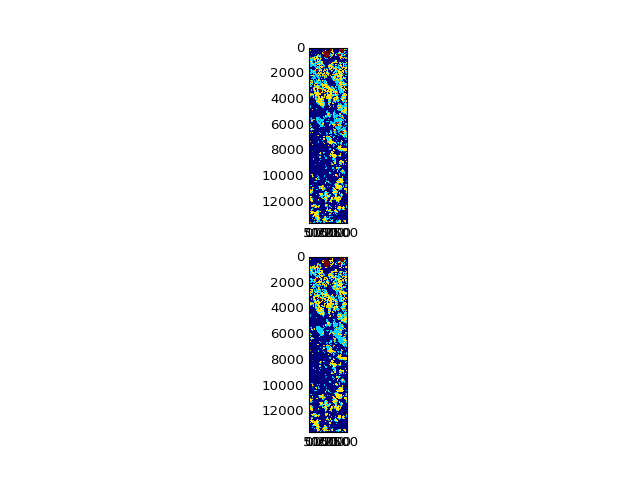

In [50]:
plt.figure()
plt.subplot(2,1,1)
plt.imshow(whole_predict)
# plt.axis('off')
plt.subplot(2,1,2)
plt.imshow(truth_predict)
# plt.axis('off')
plt.show()

In [29]:
print(Transect1_truth.shape)

(13598, 3005)
